# 3 in 1 ZeroShot-CoOp-CoCoOp - From Training to Visualization

## CELL 1: Setup - Mount Drive and Install Packages

In [ ]:
# Introduction

# ============================================================================
# CELL 1: Setup - Mount Drive and Install Packages
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install torch torchvision open_clip_torch ftfy regex tqdm scikit-learn seaborn matplotlib pillow pandas -q

print("✅ Google Drive mounted and packages installed!")
#print("🔄 Please restart runtime if this is first installation")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00
✅ Google Drive mounted and packages installed!


## CELL 2: Import All Required Libraries

In [ ]:
# ============================================================================
# CELL 2: Import All Required Libraries
# ============================================================================
!pip install python-docx -q
print("✅ python-docx installed!")

import os
import json
import random
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Optional, List, Tuple
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
from torchvision import transforms
from PIL import Image

import open_clip

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support
)

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"🖥️  Device: {device}")
if device == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print("\n✅ All libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 18.2 MB/s eta 0:00:00
✅ python-docx installed!
🖥️  Device: cuda
   GPU: NVIDIA A100-SXM4-40GB
   Memory: 42.47 GB

✅ All libraries imported successfully!


## CELL 3a: SCENARIO-BASED CONFIGURATION SYSTEM - ONE DATASET AT A TIME

In [ ]:
# ============================================================================
# SCENARIO-BASED CONFIGURATION SYSTEM - ONE DATASET AT A TIME
# Modified to run each dataset separately with different class counts
# ============================================================================

"""
SIMPLE SCENARIO CONFIGURATION - ONE DATASET AT A TIME

This configuration allows you to:
1. Test ONE dataset at a time (faster, easier to debug)
2. Test with different class counts: 10, 30, 50, or ALL classes
3. Test different shot counts: 4, 8, 16 shots
4. Run each scenario one at a time by simply changing ACTIVE_SCENARIO

How to use:
1. Set ACTIVE_SCENARIO = 'scenario_name' (e.g., 'flowers_10classes_16shot')
2. Run all cells - the configuration will be applied automatically
3. Change scenario and re-run to test another configuration

NAMING CONVENTION:
[dataset]_[classes]classes_[shots]shot
Example: flowers_30classes_16shot = Flowers102 with 30 classes and 16 shots per class
"""

# ============================================================================
# SELECT YOUR ACTIVE SCENARIO HERE
# ============================================================================
ACTIVE_SCENARIO = 'indianfood_30classes_16shot'  # <--- CHANGE THIS TO TEST DIFFERENT SCENARIOS

# ============================================================================
# SCENARIO DEFINITIONS - ONE DATASET AT A TIME
# ============================================================================

SCENARIOS = {

    # ========================================================================
    # FLOWERS102 SCENARIOS
    # ========================================================================

    'flowers_10classes_16shot': {
        'description': 'Flowers102: 10 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': True, 'max_classes': 10, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': 10, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 10, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 10, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 50,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 50,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'flowers_30classes_16shot': {
        'description': 'Flowers102: 30 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': True, 'max_classes': 30, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'flowers_50classes_16shot': {
        'description': 'Flowers102: 50 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': True, 'max_classes': 50, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': 50, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 50, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 50, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'flowers_allclasses_16shot': {
        'description': 'Flowers102: ALL classes (102), 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': True, 'max_classes': None, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': None, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': None, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': None, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    # ========================================================================
    # CALTECH101 SCENARIOS
    # ========================================================================

    'caltech_10classes_16shot': {
        'description': 'Caltech101: 10 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 10, 'shots_per_class': 16},
            'Caltech101': {'enabled': True, 'max_classes': 10, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 10, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 10, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'caltech_30classes_16shot': {
        'description': 'Caltech101: 30 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Caltech101': {'enabled': True, 'max_classes': 30, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'caltech_30classes_16shot_4': {
        'description': 'Caltech101: 30 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Caltech101': {'enabled': True, 'max_classes': 30, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 4,
        'seed': 42
    },

    'caltech_30classes_16shot_6': {
        'description': 'Caltech101: 30 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Caltech101': {'enabled': True, 'max_classes': 30, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 6,
        'seed': 42
    },
'caltech_30classes_16shot_8': {
        'description': 'Caltech101: 30 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Caltech101': {'enabled': True, 'max_classes': 30, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 8,
        'seed': 42
    },


    'caltech_30classes_8shot': {
        'description': 'Caltech101: 30 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Caltech101': {'enabled': True, 'max_classes': 30, 'shots_per_class': 8},
            'SUN397': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 8,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 8,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },
'caltech_30classes_4shot': {
        'description': 'Caltech101: 30 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 30, 'shots_per_class': 4},
            'Caltech101': {'enabled': True, 'max_classes': 30, 'shots_per_class': 4},
            'SUN397': {'enabled': False, 'max_classes': 30, 'shots_per_class': 4},
            'Indian_Food': {'enabled': False, 'max_classes': 30, 'shots_per_class': 4},
        },

        'coop': {
            'n_ctx': 4,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 4,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'caltech_50classes_16shot': {
        'description': 'Caltech101: 50 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 50, 'shots_per_class': 16},
            'Caltech101': {'enabled': True, 'max_classes': 50, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 50, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 50, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'caltech_allclasses_16shot': {
        'description': 'Caltech101: ALL classes (101), 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': None, 'shots_per_class': 16},
            'Caltech101': {'enabled': True, 'max_classes': None, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': None, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': None, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    # ========================================================================
    # SUN397 SCENARIOS
    # ========================================================================
    # Running these cases : Rajani
    'sun_10classes_16shot': {      # Done
        'description': 'SUN397: 10 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 10, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': 10, 'shots_per_class': 16},
            'SUN397': {'enabled': True, 'max_classes': 10, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 10, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'sun_30classes_16shot': { # done
        'description': 'SUN397: 30 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'SUN397': {'enabled': True, 'max_classes': 30, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'sun_50classes_16shot': {
        'description': 'SUN397: 50 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 50, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': 50, 'shots_per_class': 16},
            'SUN397': {'enabled': True, 'max_classes': 50, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': 50, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'sun_allclasses_16shot': {
        'description': 'SUN397: ALL classes (397), 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': None, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': None, 'shots_per_class': 16},
            'SUN397': {'enabled': True, 'max_classes': None, 'shots_per_class': 16},
            'Indian_Food': {'enabled': False, 'max_classes': None, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    # ========================================================================
    # INDIAN FOOD SCENARIOS
    # ========================================================================

    'indianfood_10classes_16shot': {
        'description': 'Indian Food: 10 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 10, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': 10, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 10, 'shots_per_class': 16},
            'Indian_Food': {'enabled': True, 'max_classes': 10, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'indianfood_30classes_16shot': {
        'description': 'Indian Food: 30 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Indian_Food': {'enabled': True, 'max_classes': 30, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'indianfood_30classes_8shot': {
        'description': 'Indian Food: 30 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Indian_Food': {'enabled': True, 'max_classes': 30, 'shots_per_class': 8},
        },

        'coop': {
            'n_ctx': 8,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 8,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

        'indianfood_30classes_4shot': {
        'description': 'Indian Food: 30 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 30, 'shots_per_class': 16},
            'Indian_Food': {'enabled': True, 'max_classes': 30, 'shots_per_class': 4},
        },

        'coop': {
            'n_ctx': 4,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 4,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'indianfood_50classes_16shot': {
        'description': 'Indian Food: 50 classes, 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 50, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': 50, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': 50, 'shots_per_class': 16},
            'Indian_Food': {'enabled': True, 'max_classes': 50, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'indianfood_allclasses_16shot': {
        'description': 'Indian Food: ALL classes (~80), 16-shot learning',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': None, 'shots_per_class': 16},
            'Caltech101': {'enabled': False, 'max_classes': None, 'shots_per_class': 16},
            'SUN397': {'enabled': False, 'max_classes': None, 'shots_per_class': 16},
            'Indian_Food': {'enabled': True, 'max_classes': None, 'shots_per_class': 16},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 10,
            'batch_size': 32,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    # ========================================================================
    # FEW-SHOT VARIATIONS (8-shot for quick testing)
    # ========================================================================

    'flowers_10classes_8shot': {
        'description': 'Flowers102: 10 classes, 8-shot (quick test)',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': True, 'max_classes': 10, 'shots_per_class': 8},
            'Caltech101': {'enabled': False, 'max_classes': 10, 'shots_per_class': 8},
            'SUN397': {'enabled': False, 'max_classes': 10, 'shots_per_class': 8},
            'Indian_Food': {'enabled': False, 'max_classes': 10, 'shots_per_class': 8},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 12,
            'batch_size': 24,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 12,
            'batch_size': 24,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },

    'caltech_10classes_8shot': {
        'description': 'Caltech101: 10 classes, 8-shot (quick test)',
        'clip_model': 'ViT-B-32',
        'pretrained': 'openai',
        'image_size': 224,

        'datasets': {
            'Flowers102': {'enabled': False, 'max_classes': 10, 'shots_per_class': 8},
            'Caltech101': {'enabled': True, 'max_classes': 10, 'shots_per_class': 8},
            'SUN397': {'enabled': False, 'max_classes': 10, 'shots_per_class': 8},
            'Indian_Food': {'enabled': False, 'max_classes': 10, 'shots_per_class': 8},
        },

        'coop': {
            'n_ctx': 16,
            'csc': False,
            'pos': 'end',
            'epochs': 12,
            'batch_size': 24,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'cocoop': {
            'n_ctx': 16,
            'pos': 'end',
            'epochs': 12,
            'batch_size': 24,
            'lr': 0.002,
            'weight_decay': 0.0001,
        },

        'num_workers': 2,
        'seed': 42
    },
}

# ============================================================================
# APPLY SCENARIO CONFIGURATION
# ============================================================================

def apply_scenario(scenario_name):
    """
    Apply the selected scenario configuration.
    Returns the configuration dictionary ready to use.
    """
    if scenario_name not in SCENARIOS:
        available = ', '.join(SCENARIOS.keys())
        raise ValueError(f"Scenario '{scenario_name}' not found. Available scenarios: {available}")

    scenario = SCENARIOS[scenario_name]

    print("="*70)
    print(f"🎯 APPLYING SCENARIO: {scenario_name}")
    print("="*70)
    print(f"📝 Description: {scenario['description']}")
    print()

    # Apply dataset configuration
    dataset_config = {}
    for dataset_name, config in scenario['datasets'].items():
        dataset_config[dataset_name] = {
            'path': f"{BASE_DIR}/{dataset_name.lower().replace('_', '-')}" if dataset_name != 'Indian_Food'
                   else f"{BASE_DIR}/Indian Food Images/Indian Food Images",
            'enabled': config['enabled'],
            'prompt_template': {
                'Flowers102': 'a photo of {}, a type of flower.',
                'Caltech101': 'a photo of {}.',
                'SUN397': 'a photo of a {}.',
                'Indian_Food': 'a photo of a {}'
            }[dataset_name]
        }

    # Create training configuration
    train_config = {
        'clip_model': scenario['clip_model'],
        'pretrained': scenario['pretrained'],
        'image_size': scenario['image_size'],

        # Get dataset-specific settings from enabled dataset
        'max_classes': None,
        'shots_per_class': None,

        # CoOp settings
        'coop_n_ctx': scenario['coop']['n_ctx'],
        'coop_csc': scenario['coop']['csc'],
        'coop_pos': scenario['coop']['pos'],
        'coop_epochs': scenario['coop']['epochs'],
        'coop_batch_size': scenario['coop']['batch_size'],
        'coop_lr': scenario['coop']['lr'],
        'coop_weight_decay': scenario['coop']['weight_decay'],

        # CoCoOp settings
        'cocoop_n_ctx': scenario['cocoop']['n_ctx'],
        'cocoop_pos': scenario['cocoop']['pos'],
        'cocoop_epochs': scenario['cocoop']['epochs'],
        'cocoop_batch_size': scenario['cocoop']['batch_size'],
        'cocoop_lr': scenario['cocoop']['lr'],
        'cocoop_weight_decay': scenario['cocoop']['weight_decay'],

        # General settings
        'num_workers': scenario['num_workers'],
        'seed': scenario['seed']
    }

    # Set dataset-specific parameters from enabled dataset
    for dataset_name, config in scenario['datasets'].items():
        if config['enabled']:
            train_config['max_classes'] = config['max_classes']
            train_config['shots_per_class'] = config['shots_per_class']
            break

    # Print configuration summary
    print("📊 Enabled Datasets:")
    for dataset_name, config in scenario['datasets'].items():
        if config['enabled']:
            classes_str = f"{config['max_classes']}" if config['max_classes'] else "ALL"
            print(f"   ✅ {dataset_name:15s}: {classes_str} classes, {config['shots_per_class']}-shot")
        else:
            print(f"   ❌ {dataset_name:15s}: Disabled")

    print(f"\n🔧 Training Configuration:")
    classes_str = f"{train_config['max_classes']}" if train_config['max_classes'] else "ALL"
    print(f"   Classes: {classes_str}")
    print(f"   Shots per class: {train_config['shots_per_class']}")
    print(f"   Context tokens: {scenario['coop']['n_ctx']}")
    print(f"   Learning rate: {scenario['coop']['lr']}")
    print(f"   Epochs: {scenario['coop']['epochs']}")
    print(f"   Batch size: {scenario['coop']['batch_size']}")

    print("="*70)

    return dataset_config, train_config

# ============================================================================
# AUTO-APPLY SELECTED SCENARIO
# ============================================================================

print("\n" + "="*70)
print("🎬 SCENARIO CONFIGURATION LOADED")
print("="*70)
print(f"\n📍 Active Scenario: '{ACTIVE_SCENARIO}'")
print(f"📝 Description: {SCENARIOS[ACTIVE_SCENARIO]['description']}")

# Count scenarios by dataset
flowers_scenarios = [s for s in SCENARIOS.keys() if s.startswith('flowers_')]
caltech_scenarios = [s for s in SCENARIOS.keys() if s.startswith('caltech_')]
sun_scenarios = [s for s in SCENARIOS.keys() if s.startswith('sun_')]
indianfood_scenarios = [s for s in SCENARIOS.keys() if s.startswith('indianfood_')]

print("\n📋 Available Scenarios by Dataset:")
print(f"\n🌸 Flowers102 ({len(flowers_scenarios)} scenarios):")
for s in flowers_scenarios:
    status = "◀ ACTIVE" if s == ACTIVE_SCENARIO else ""
    print(f"   • {s:40s} {status}")

print(f"\n📷 Caltech101 ({len(caltech_scenarios)} scenarios):")
for s in caltech_scenarios:
    status = "◀ ACTIVE" if s == ACTIVE_SCENARIO else ""
    print(f"   • {s:40s} {status}")

print(f"\n🌅 SUN397 ({len(sun_scenarios)} scenarios):")
for s in sun_scenarios:
    status = "◀ ACTIVE" if s == ACTIVE_SCENARIO else ""
    print(f"   • {s:40s} {status}")

print(f"\n🍛 Indian Food ({len(indianfood_scenarios)} scenarios):")
for s in indianfood_scenarios:
    status = "◀ ACTIVE" if s == ACTIVE_SCENARIO else ""
    print(f"   • {s:40s} {status}")

print("\n💡 To change scenario:")
print("   1. Set ACTIVE_SCENARIO = 'scenario_name'")
print("   2. Re-run this cell and subsequent cells")
print("="*70)

# This will be used in Cell 3 to replace the manual configuration


🎬 SCENARIO CONFIGURATION LOADED

📍 Active Scenario: 'indianfood_30classes_16shot'
📝 Description: Indian Food: 30 classes, 16-shot learning

📋 Available Scenarios by Dataset:

🌸 Flowers102 (5 scenarios):
   • flowers_10classes_16shot                 
   • flowers_30classes_16shot                 
   • flowers_50classes_16shot                 
   • flowers_allclasses_16shot                
   • flowers_10classes_8shot                  

📷 Caltech101 (10 scenarios):
   • caltech_10classes_16shot                 
   • caltech_30classes_16shot                 
   • caltech_30classes_16shot_4               
   • caltech_30classes_16shot_6               
   • caltech_30classes_16shot_8               
   • caltech_30classes_8shot                  
   • caltech_30classes_4shot                  
   • caltech_50classes_16shot                 
   • caltech_allclasses_16shot                
   • caltech_10classes_8shot                  

🌅 SUN397 (4 scenarios):
   • sun_10classes_16shot           

## CELL 3b: Configuration and Dataset Selection

In [ ]:
# ============================================================================
# MODIFIED CELL 3: Configuration and Dataset Selection (Scenario-Based)
# REPLACE YOUR EXISTING CELL 3 WITH THIS
# ============================================================================

# Base directory where your datasets are stored
BASE_DIR = '/content/drive/MyDrive/CapstoneProject/data'

# Checkpoint directories for each method
CHECKPOINT_DIRS = {
    'base': '/content/drive/MyDrive/CapstoneProject/results',
    'zero_shot': f'/content/drive/MyDrive/CapstoneProject/results/zero_shot_{ACTIVE_SCENARIO}',
    'coop': f'/content/drive/MyDrive/CapstoneProject/results/coop_{ACTIVE_SCENARIO}',
    'cocoop': f'/content/drive/MyDrive/CapstoneProject/results/cocoop_{ACTIVE_SCENARIO}',
    'comparison': f'/content/drive/MyDrive/CapstoneProject/results/comparison_{ACTIVE_SCENARIO}'
}

# Create directories
for dir_path in CHECKPOINT_DIRS.values():
    os.makedirs(dir_path, exist_ok=True)

# ============================================================================
# APPLY SCENARIO CONFIGURATION
# ============================================================================

print(f"\n{'='*70}")
print(f"⚙️  APPLYING SCENARIO: {ACTIVE_SCENARIO}")
print("="*70)

# Apply the selected scenario
DATASET_CONFIG, TRAIN_CONFIG = apply_scenario(ACTIVE_SCENARIO)

# Fix dataset paths based on actual structure
DATASET_CONFIG['Flowers102']['path'] = f'{BASE_DIR}/flowers-102'
DATASET_CONFIG['Caltech101']['path'] = f'{BASE_DIR}/caltech101/101_ObjectCategories'
DATASET_CONFIG['SUN397']['path'] = f'{BASE_DIR}/sun397/train'
DATASET_CONFIG['Indian_Food']['path'] = f'{BASE_DIR}/Indian Food Images/Indian Food Images'

# Get enabled datasets
enabled_datasets = [name for name, config in DATASET_CONFIG.items() if config['enabled']]
dataset_paths = [DATASET_CONFIG[name]['path'] for name in enabled_datasets]

print(f"\n{'='*70}")
print("📋 EXPERIMENT CONFIGURATION SUMMARY")
print("="*70)

print(f"\n🎯 Scenario Details:")
print(f"   Name: {ACTIVE_SCENARIO}")
print(f"   Description: {SCENARIOS[ACTIVE_SCENARIO]['description']}")

print(f"\n🎯 Few-Shot Settings:")
print(f"   Max Classes: {TRAIN_CONFIG['max_classes']}")
print(f"   Shots per Class: {TRAIN_CONFIG['shots_per_class']}")

print(f"\n📦 Enabled Datasets ({len(enabled_datasets)}):")
for name in enabled_datasets:
    path = DATASET_CONFIG[name]['path']
    exists = "✅" if os.path.exists(path) else "❌"
    print(f"   {exists} {name:20s}: {path}")

print(f"\n🔧 Model Configuration:")
print(f"   Model: {TRAIN_CONFIG['clip_model']}")
print(f"   Image Size: {TRAIN_CONFIG['image_size']}")

print(f"\n🔧 CoOp Configuration:")
print(f"   Context Tokens: {TRAIN_CONFIG['coop_n_ctx']}")
print(f"   Position: {TRAIN_CONFIG['coop_pos']}")
print(f"   Class-Specific Context: {TRAIN_CONFIG['coop_csc']}")
print(f"   Epochs: {TRAIN_CONFIG['coop_epochs']}")
print(f"   Batch Size: {TRAIN_CONFIG['coop_batch_size']}")
print(f"   Learning Rate: {TRAIN_CONFIG['coop_lr']}")

print(f"\n🔧 CoCoOp Configuration:")
print(f"   Context Tokens: {TRAIN_CONFIG['cocoop_n_ctx']}")
print(f"   Position: {TRAIN_CONFIG['cocoop_pos']}")
print(f"   Epochs: {TRAIN_CONFIG['cocoop_epochs']}")
print(f"   Batch Size: {TRAIN_CONFIG['cocoop_batch_size']}")
print(f"   Learning Rate: {TRAIN_CONFIG['cocoop_lr']}")

print(f"\n💾 Results will be saved to:")
print(f"   {CHECKPOINT_DIRS['comparison']}")

print("="*70)

# Verify at least one dataset is enabled
if len(enabled_datasets) == 0:
    raise ValueError("❌ No datasets enabled! Please enable at least one dataset in your scenario.")

print("\n✅ Configuration applied successfully!")
print(f"🎯 You can now proceed with training using scenario: {ACTIVE_SCENARIO}")


⚙️  APPLYING SCENARIO: indianfood_30classes_16shot
🎯 APPLYING SCENARIO: indianfood_30classes_16shot
📝 Description: Indian Food: 30 classes, 16-shot learning

📊 Enabled Datasets:
   ❌ Flowers102     : Disabled
   ❌ Caltech101     : Disabled
   ❌ SUN397         : Disabled
   ✅ Indian_Food    : 30 classes, 16-shot

🔧 Training Configuration:
   Classes: 30
   Shots per class: 16
   Context tokens: 16
   Learning rate: 0.002
   Epochs: 10
   Batch size: 32

📋 EXPERIMENT CONFIGURATION SUMMARY

🎯 Scenario Details:
   Name: indianfood_30classes_16shot
   Description: Indian Food: 30 classes, 16-shot learning

🎯 Few-Shot Settings:
   Max Classes: 30
   Shots per Class: 16

📦 Enabled Datasets (1):
   ✅ Indian_Food         : /content/drive/MyDrive/CapstoneProject/data/Indian Food Images/Indian Food Images

🔧 Model Configuration:
   Model: ViT-B-32
   Image Size: 224

🔧 CoOp Configuration:
   Context Tokens: 16
   Position: end
   Class-Specific Context: False
   Epochs: 10
   Batch Size: 32
   L

In [ ]:
# # ============================================================================
# # ALL SCENARIOS LIBRARY - TOGGLE ONE ON TO RUN
# # Replace your CELL 3 with this
# # ============================================================================

# """
# HOW TO USE:
# 1. Find the scenario you want to run below
# 2. Set its 'enabled': True
# 3. Make sure all others are 'enabled': False
# 4. Run this cell
# 5. Run remaining cells (4-10.5a)
# 6. Get your report!
# 7. Come back and toggle a different scenario
# """

# import os

# # ============================================================================
# # ALL SCENARIOS - SET ONE TO enabled: True
# # ============================================================================

# ALL_SCENARIOS = {

#     # ========================================================================
#     # FLOWERS102 SCENARIOS
#     # ========================================================================

#     'flowers_10cls_baseline': {
#         'enabled': False,  # ← Set to True to run this scenario
#         'dataset': 'Flowers102',
#         'max_classes': 10,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'flowers_10cls_ctx4': {
#         'enabled': False,
#         'dataset': 'Flowers102',
#         'max_classes': 10,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 4,  # Small context
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 4,  # Small context
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'flowers_10cls_ctx8': {
#         'enabled': False,
#         'dataset': 'Flowers102',
#         'max_classes': 10,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 8,  # Medium context
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 8,  # Medium context
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'flowers_10cls_csc': {
#         'enabled': False,
#         'dataset': 'Flowers102',
#         'max_classes': 10,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': True,  # Class-specific context
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'flowers_10cls_highlr': {
#         'enabled': False,
#         'dataset': 'Flowers102',
#         'max_classes': 10,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.004,  # High learning rate
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.004,  # High learning rate
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'flowers_20cls_baseline': {
#         'enabled': False,
#         'dataset': 'Flowers102',
#         'max_classes': 20,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'flowers_30cls_baseline': {
#         'enabled': True,  # ← EXAMPLE: This one is ON
#         'dataset': 'Flowers102',
#         'max_classes': 30,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'flowers_all_baseline': {
#         'enabled': False,
#         'dataset': 'Flowers102',
#         'max_classes': None,  # All classes
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     # ========================================================================
#     # CALTECH101 SCENARIOS
#     # ========================================================================

#     'caltech_15cls_baseline': {
#         'enabled': False,
#         'dataset': 'Caltech101',
#         'max_classes': 15,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'caltech_15cls_ctx4': {
#         'enabled': False,
#         'dataset': 'Caltech101',
#         'max_classes': 15,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 4,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 4,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'caltech_15cls_csc': {
#         'enabled': False,
#         'dataset': 'Caltech101',
#         'max_classes': 15,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': True,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'caltech_30cls_baseline': {
#         'enabled': False,
#         'dataset': 'Caltech101',
#         'max_classes': 30,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'caltech_50cls_baseline': {
#         'enabled': False,
#         'dataset': 'Caltech101',
#         'max_classes': 50,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'caltech_all_baseline': {
#         'enabled': False,
#         'dataset': 'Caltech101',
#         'max_classes': None,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     # ========================================================================
#     # SUN397 SCENARIOS
#     # ========================================================================

#     'sun397_20cls_baseline': {
#         'enabled': False,
#         'dataset': 'SUN397',
#         'max_classes': 20,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'sun397_20cls_ctx4': {
#         'enabled': False,
#         'dataset': 'SUN397',
#         'max_classes': 20,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 4,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 4,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'sun397_20cls_csc': {
#         'enabled': False,
#         'dataset': 'SUN397',
#         'max_classes': 20,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': True,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'sun397_30cls_baseline': {
#         'enabled': False,
#         'dataset': 'SUN397',
#         'max_classes': 30,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'sun397_50cls_baseline': {
#         'enabled': False,
#         'dataset': 'SUN397',
#         'max_classes': 50,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'sun397_100cls_baseline': {
#         'enabled': False,
#         'dataset': 'SUN397',
#         'max_classes': 100,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     # ========================================================================
#     # INDIAN FOOD SCENARIOS
#     # ========================================================================

#     'indianfood_10cls_baseline': {
#         'enabled': False,
#         'dataset': 'Indian_Food',
#         'max_classes': 10,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'indianfood_10cls_ctx4': {
#         'enabled': False,
#         'dataset': 'Indian_Food',
#         'max_classes': 10,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 4,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 4,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'indianfood_10cls_csc': {
#         'enabled': False,
#         'dataset': 'Indian_Food',
#         'max_classes': 10,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': True,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'indianfood_20cls_baseline': {
#         'enabled': False,
#         'dataset': 'Indian_Food',
#         'max_classes': 20,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

#     'indianfood_all_baseline': {
#         'enabled': False,
#         'dataset': 'Indian_Food',
#         'max_classes': None,
#         'shots_per_class': 16,
#         'coop': {
#             'n_ctx': 16,
#             'csc': False,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         },
#         'cocoop': {
#             'n_ctx': 16,
#             'pos': 'end',
#             'lr': 0.002,
#             'epochs': 10,
#             'batch_size': 32,
#             'weight_decay': 0.0001
#         }
#     },

# }

# # ============================================================================
# # AUTOMATIC CONFIGURATION (Don't modify below this line)
# # ============================================================================

# # Base directory where your datasets are stored
# BASE_DIR = '/content/drive/MyDrive/CapstoneProject/data'

# # Checkpoint directories
# CHECKPOINT_DIRS = {
#     'base': '/content/drive/MyDrive/CapstoneProject/results',
#     'zero_shot': '/content/drive/MyDrive/CapstoneProject/results/zero_shot',
#     'coop': '/content/drive/MyDrive/CapstoneProject/results/coop',
#     'cocoop': '/content/drive/MyDrive/CapstoneProject/results/cocoop',
#     'comparison': '/content/drive/MyDrive/CapstoneProject/results/comparison'
# }

# # Create directories
# for dir_path in CHECKPOINT_DIRS.values():
#     os.makedirs(dir_path, exist_ok=True)

# # Dataset information
# DATASET_INFO = {
#     'Flowers102': {
#         'path': f'{BASE_DIR}/flowers-102',
#         'prompt_template': 'a photo of a {}, a type of flower.'
#     },
#     'Caltech101': {
#         'path': f'{BASE_DIR}/caltech101/101_ObjectCategories',
#         'prompt_template': 'a photo of a {}.'
#     },
#     'SUN397': {
#         'path': f'{BASE_DIR}/sun397/train',
#         'prompt_template': 'a photo of a {}.'
#     },
#     'Indian_Food': {
#         'path': f'{BASE_DIR}/Indian Food Images/Indian Food Images',
#         'prompt_template': 'a photo of {}, a type of indian food.'
#     }
# }

# # Find enabled scenario
# enabled_scenarios = [(name, config) for name, config in ALL_SCENARIOS.items() if config['enabled']]

# # Validation
# if len(enabled_scenarios) == 0:
#     print("="*80)
#     print("❌ ERROR: No scenario enabled!")
#     print("="*80)
#     print("\n📋 Available scenarios:")
#     for name in ALL_SCENARIOS.keys():
#         print(f"   • {name}")
#     print("\n💡 Set ONE scenario to 'enabled': True")
#     print("="*80)
#     raise ValueError("No scenario enabled. Set one scenario to 'enabled': True")

# if len(enabled_scenarios) > 1:
#     print("="*80)
#     print("❌ ERROR: Multiple scenarios enabled!")
#     print("="*80)
#     print("\n📋 Currently enabled:")
#     for name, _ in enabled_scenarios:
#         print(f"   • {name}")
#     print("\n💡 Set only ONE scenario to 'enabled': True")
#     print("="*80)
#     raise ValueError("Multiple scenarios enabled. Set only ONE to 'enabled': True")

# # Get the enabled scenario
# scenario_name, scenario = enabled_scenarios[0]
# dataset_name = scenario['dataset']

# # Check if dataset exists
# if dataset_name not in DATASET_INFO:
#     raise ValueError(f"Unknown dataset: {dataset_name}")

# dataset_path = DATASET_INFO[dataset_name]['path']
# prompt_template = DATASET_INFO[dataset_name]['prompt_template']

# if not os.path.exists(dataset_path):
#     raise ValueError(f"Dataset path not found: {dataset_path}")

# # Build DATASET_CONFIG (compatible with existing code)
# DATASET_CONFIG = {
#     dataset_name: {
#         'path': dataset_path,
#         'enabled': True,
#         'prompt_template': prompt_template
#     }
# }

# # Build TRAIN_CONFIG (compatible with existing code)
# TRAIN_CONFIG = {
#     'clip_model': 'ViT-B-32',
#     'pretrained': 'openai',
#     'image_size': 224,

#     # Few-shot settings
#     'max_classes': scenario['max_classes'],
#     'shots_per_class': scenario['shots_per_class'],

#     # CoOp settings
#     'coop_n_ctx': scenario['coop']['n_ctx'],
#     'coop_csc': scenario['coop']['csc'],
#     'coop_pos': scenario['coop']['pos'],
#     'coop_epochs': scenario['coop']['epochs'],
#     'coop_batch_size': scenario['coop']['batch_size'],
#     'coop_lr': scenario['coop']['lr'],
#     'coop_weight_decay': scenario['coop']['weight_decay'],

#     # CoCoOp settings
#     'cocoop_n_ctx': scenario['cocoop']['n_ctx'],
#     'cocoop_pos': scenario['cocoop']['pos'],
#     'cocoop_epochs': scenario['cocoop']['epochs'],
#     'cocoop_batch_size': scenario['cocoop']['batch_size'],
#     'cocoop_lr': scenario['cocoop']['lr'],
#     'cocoop_weight_decay': scenario['cocoop']['weight_decay'],

#     # General settings
#     'num_workers': 2,
#     'seed': 42
# }

# # Get enabled datasets and paths (for compatibility)
# enabled_datasets = [dataset_name]
# dataset_paths = [dataset_path]

# # ============================================================================
# # DISPLAY CONFIGURATION
# # ============================================================================

# print("="*80)
# print("🎯 CURRENT SCENARIO")
# print("="*80)

# print(f"\n🏷️  Scenario: {scenario_name}")

# print(f"\n📦 Dataset:")
# print(f"   Name: {dataset_name}")
# print(f"   Path: {dataset_path}")
# print(f"   Status: ✅ Found")
# print(f"   Prompt: {prompt_template}")

# print(f"\n🎯 Data Configuration:")
# print(f"   Max Classes: {scenario['max_classes'] if scenario['max_classes'] else 'ALL'}")
# print(f"   Shots per Class: {scenario['shots_per_class'] if scenario['shots_per_class'] else 'ALL'}")

# print(f"\n⚙️  CoOp Configuration:")
# print(f"   Context Length: {scenario['coop']['n_ctx']}")
# print(f"   Class-Specific: {scenario['coop']['csc']}")
# print(f"   Position: {scenario['coop']['pos']}")
# print(f"   Learning Rate: {scenario['coop']['lr']}")
# print(f"   Epochs: {scenario['coop']['epochs']}")
# print(f"   Batch Size: {scenario['coop']['batch_size']}")

# print(f"\n⚙️  CoCoOp Configuration:")
# print(f"   Context Length: {scenario['cocoop']['n_ctx']}")
# print(f"   Position: {scenario['cocoop']['pos']}")
# print(f"   Learning Rate: {scenario['cocoop']['lr']}")
# print(f"   Epochs: {scenario['cocoop']['epochs']}")
# print(f"   Batch Size: {scenario['cocoop']['batch_size']}")

# print(f"\n💾 Results will be saved to:")
# print(f"   {CHECKPOINT_DIRS['comparison']}")

# print("\n" + "="*80)
# print("✅ Scenario loaded successfully!")
# print("="*80)

# print(f"\n📊 Total Scenarios Available: {len(ALL_SCENARIOS)}")
# print(f"   Enabled: 1 ({scenario_name})")
# print(f"   Disabled: {len(ALL_SCENARIOS) - 1}")

# print("\n💡 Next steps:")
# print("   1. Run remaining cells (4-10.5a)")
# print("   2. Get your report")
# print("   3. Come back here to toggle a different scenario")

# print("\n📋 Quick scenario list:")
# by_dataset = {}
# for name, config in ALL_SCENARIOS.items():
#     ds = config['dataset']
#     if ds not in by_dataset:
#         by_dataset[ds] = []
#     by_dataset[ds].append(name)

# for ds, scenarios in sorted(by_dataset.items()):
#     print(f"\n   {ds}:")
#     for sc in scenarios:
#         status = "✅ ON" if sc == scenario_name else "⬜ OFF"
#         print(f"      {status} {sc}")

# print("="*80)

In [ ]:
# # ============================================================================
# # CELL 3: Configuration and Dataset Selection
# # ============================================================================

# # Base directory where your datasets are stored
# BASE_DIR = '/content/drive/MyDrive/CapstoneProject/data'

# # Checkpoint directories for each method
# CHECKPOINT_DIRS = {
#     'base': '/content/drive/MyDrive/CapstoneProject/results', # Added base directory
#     'zero_shot': '/content/drive/MyDrive/CapstoneProject/results/zero_shot',
#     'coop': '/content/drive/MyDrive/CapstoneProject/results/coop',
#     'cocoop': '/content/drive/MyDrive/CapstoneProject/results/cocoop',
#     'comparison': '/content/drive/MyDrive/CapstoneProject/results/comparison'
# }

# # Create directories
# for dir_path in CHECKPOINT_DIRS.values():
#     os.makedirs(dir_path, exist_ok=True)

# # ============================================================================
# # DATASET SELECTION
# # ============================================================================

# # Available datasets and their paths
# DATASET_CONFIG = {

#     'Flowers102': {
#         'path': f'{BASE_DIR}/flowers-102',
#         'enabled': False,
#         'prompt_template': 'a photo of a {}, a type of flower.'
#     },

#     'Caltech101': {
#         'path': f'{BASE_DIR}/caltech101/101_ObjectCategories',
#         'enabled': False,
#         'prompt_template': 'a photo of a {}.'
#     },
#     'SUN397': {
#         'path': f'{BASE_DIR}/sun397/train',
#         'enabled': True,
#         'prompt_template': 'a photo of a {}.'
#     },
#     'Indian_Food': {
#         'path': f'{BASE_DIR}/Indian Food Images/Indian Food Images',
#         'enabled': False,
#         'prompt_template': 'a photo of {}, a type of indian food.'
#     }
# }

# # Training configuration
# TRAIN_CONFIG = {
#     'clip_model': 'ViT-B-32',
#     'pretrained': 'openai',
#     'image_size': 224,

#     # Few-shot settings
#     'max_classes': 30,          # Set to None to use all classes
#     'shots_per_class': 16,      # Set to None for full training

#     # CoOp settings
#     'coop_n_ctx': 16,           # Number of context tokens
#     'coop_csc': False,          # Class-specific context
#     'coop_pos': 'end',          # Context position: 'end' or 'mid'
#     'coop_epochs': 10,
#     'coop_batch_size': 32,
#     'coop_lr': 0.002,
#     'coop_weight_decay': 0.0001,

#     # CoCoOp settings
#     'cocoop_n_ctx': 16,
#     'cocoop_pos': 'end',
#     'cocoop_epochs': 10,
#     'cocoop_batch_size': 32,
#     'cocoop_lr': 0.002,
#     'cocoop_weight_decay': 0.0001,

#     # General settings
#     'num_workers': 2,
#     'seed': 42
# }

# # Get enabled datasets
# enabled_datasets = [name for name, config in DATASET_CONFIG.items() if config['enabled']]
# dataset_paths = [DATASET_CONFIG[name]['path'] for name in enabled_datasets]

# print("="*70)
# print("📋 EXPERIMENT CONFIGURATION")
# print("="*70)
# print(f"\n🎯 Few-Shot Settings:")
# print(f"   Max Classes: {TRAIN_CONFIG['max_classes'] or 'ALL'}")
# print(f"   Shots per Class: {TRAIN_CONFIG['shots_per_class'] or 'FULL'}")

# print(f"\n📦 Enabled Datasets:")
# for name in enabled_datasets:
#     path = DATASET_CONFIG[name]['path']
#     exists = "✅" if os.path.exists(path) else "❌"
#     print(f"   {exists} {name:20s}: {path}")

# print(f"\n🔧 Model: {TRAIN_CONFIG['clip_model']}")
# print(f"💾 Results will be saved to: {CHECKPOINT_DIRS['comparison']}")
# print("="*70)

## CELL 4: CLIP Model Loader

In [ ]:
# ============================================================================
# CELL 4: CLIP Model Loader
# ============================================================================

def load_clip(model_name: str = "ViT-B-32",
              pretrained: str = "openai",
              device: str = "cuda"):
    """
    Load and freeze CLIP model.

    Args:
        model_name: CLIP architecture ('ViT-B-32', 'ViT-B-16', 'ViT-L-14')
        pretrained: Pre-trained weights ('openai')
        device: 'cuda' or 'cpu'

    Returns:
        model, tokenizer, preprocess
    """
    print(f"📦 Loading CLIP model: {model_name}...")

    model, _, preprocess = open_clip.create_model_and_transforms(
        model_name,
        pretrained=pretrained
    )
    tokenizer = open_clip.get_tokenizer(model_name)

    # Freeze all parameters
    model.eval()
    for param in model.parameters():
        param.requires_grad_(False)

    model = model.to(device)

    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    print(f"   ✅ Model loaded successfully")
    print(f"   📊 Total parameters: {total_params:,}")
    print(f"   🔒 All parameters frozen")

    return model, tokenizer, preprocess


# Load CLIP model (we'll use this for all three methods)
clip_model, clip_tokenizer, clip_preprocess = load_clip(
    model_name=TRAIN_CONFIG['clip_model'],
    pretrained=TRAIN_CONFIG['pretrained'],
    device=device
)

print("\n✅ CLIP model ready for all experiments!")

📦 Loading CLIP model: ViT-B-32...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


   ✅ Model loaded successfully
   📊 Total parameters: 151,277,313
   🔒 All parameters frozen

✅ CLIP model ready for all experiments!


## CELL 5: Universal Dataset Loader

In [ ]:
# ============================================================================
# CELL 5: Universal Dataset Loader
# ============================================================================

class UniversalImageDataset(Dataset):
    """
    Universal dataset loader that handles multiple folder structures:
    1. Flat structure: all images in one folder (single class)
    2. Direct structure: class_folders/images
    3. Nested structure: parent/class_folders/images
    """

    def __init__(self, root_dir, transform=None, valid_extensions=None):
        self.root_dir = Path(root_dir)
        self.transform = transform

        if valid_extensions is None:
            self.valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']
        else:
            self.valid_extensions = valid_extensions

        self.samples = []
        self.classes = []
        self.class_to_idx = {}

        print(f"📂 Scanning dataset: {root_dir}")
        self._scan_directory()

        if len(self.samples) == 0:
            raise ValueError(f"❌ No images found in {root_dir}")

    def _is_image_file(self, path):
        return path.is_file() and path.suffix.lower() in self.valid_extensions

    def _scan_directory(self):
        items = list(self.root_dir.iterdir())
        dirs = [item for item in items if item.is_dir() and not item.name.startswith('.')]
        files = [item for item in items if self._is_image_file(item)]

        # Case 1: Flat structure (files directly in root)
        if files:
            print(f"   ℹ️  Detected: Flat structure")
            class_name = self.root_dir.name
            self.classes = [class_name]
            self.class_to_idx = {class_name: 0}
            for img_path in files:
                self.samples.append((str(img_path), 0))
            print(f"   • {class_name:30s}: {len(files):5d} images")

        # Case 2 & 3: Directory structure
        elif dirs:
            first_dir = dirs[0]
            subdirs = [d for d in first_dir.iterdir() if d.is_dir() and not d.name.startswith('.')]
            subfiles = [f for f in first_dir.iterdir() if self._is_image_file(f)]

            # Case 3: Nested structure
            if subdirs and not subfiles:
                print(f"   ℹ️  Detected: Nested structure")
                class_folders = []
                for parent_dir in dirs:
                    for class_dir in parent_dir.iterdir():
                        if class_dir.is_dir() and not class_dir.name.startswith('.'):
                            class_folders.append(class_dir)

                class_folders = sorted(class_folders, key=lambda x: x.name)
                self.classes = [d.name for d in class_folders]
                self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

                for class_dir in class_folders:
                    class_name = class_dir.name
                    class_idx = self.class_to_idx[class_name]
                    class_images = []
                    for img_path in class_dir.rglob('*'):
                        if self._is_image_file(img_path):
                            class_images.append((str(img_path), class_idx))
                    self.samples.extend(class_images)
                    if len(class_images) > 0:
                        print(f"   • {class_name:30s}: {len(class_images):5d} images")

            # Case 2: Direct structure
            else:
                print(f"   ℹ️  Detected: Direct structure")
                self.classes = sorted([d.name for d in dirs])
                self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

                for class_dir in dirs:
                    class_name = class_dir.name
                    class_idx = self.class_to_idx[class_name]
                    class_images = []
                    for img_path in class_dir.rglob('*'):
                        if self._is_image_file(img_path):
                            class_images.append((str(img_path), class_idx))
                    self.samples.extend(class_images)
                    if len(class_images) > 0:
                        print(f"   • {class_name:30s}: {len(class_images):5d} images")

        print(f"\n   ✅ Total: {len(self.samples)} images across {len(self.classes)} classes")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"⚠️  Error loading {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='black')

        if self.transform:
            image = self.transform(image)

        return image, label


def get_transform(image_size=224):
    """Get standard CLIP preprocessing transform."""
    return transforms.Compose([
        transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.48145466, 0.4578275, 0.40821073],
            std=[0.26862954, 0.26130258, 0.27577711]
        )
    ])


print("✅ Dataset loader ready!")

✅ Dataset loader ready!


## CELL 6: Few-Shot Dataset Preparation

In [ ]:
# ============================================================================
# CELL 6: Dataset Preparation (Compatible with Scenario Configuration)
# REPLACE YOUR EXISTING CELL 6 WITH THIS
# ============================================================================

import random
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
from collections import defaultdict
from pathlib import Path
from PIL import Image

print(f"\n{'='*70}")
print("CELL 6: DATASET PREPARATION")
print("="*70)

# ============================================================================
# SECTION 1: Dataset Preparation Function
# ============================================================================

def prepare_few_shot_datasets(dataset_paths, transform, max_classes=None,
                               shots_per_class=None, seed=42):
    """
    Prepare datasets for few-shot learning.

    Args:
        dataset_paths: List of dataset directory paths
        transform: Image transformation pipeline
        max_classes: Maximum number of classes to use (None = all)
        shots_per_class: Number of training samples per class (None = full dataset)
        seed: Random seed for reproducibility

    Returns:
        train_dataset, val_dataset, class_names
    """

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    print(f"\n📦 Loading datasets from {len(dataset_paths)} path(s)...")

    # Collect all samples from all dataset paths
    all_samples = []
    all_classes = []

    for dataset_path in dataset_paths:
        dataset_path = Path(dataset_path)
        print(f"\n📂 Scanning: {dataset_path.name}")

        # Scan for class directories
        class_dirs = [d for d in dataset_path.iterdir()
                     if d.is_dir() and not d.name.startswith('.')]

        if not class_dirs:
            # Try nested structure
            subdirs = list(dataset_path.iterdir())
            if subdirs:
                class_dirs = []
                for subdir in subdirs:
                    if subdir.is_dir():
                        nested_dirs = [d for d in subdir.iterdir()
                                     if d.is_dir() and not d.name.startswith('.')]
                        class_dirs.extend(nested_dirs)

        class_dirs = sorted(class_dirs, key=lambda x: x.name)

        # Process each class
        for class_dir in class_dirs:
            class_name = class_dir.name

            # Get all images in this class
            image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff']
            images = []
            for ext in image_extensions:
                images.extend(class_dir.glob(f'**/*{ext}'))
                images.extend(class_dir.glob(f'**/*{ext.upper()}'))

            if images:
                class_idx = len(all_classes)
                all_classes.append(class_name)

                for img_path in images:
                    all_samples.append((str(img_path), class_idx))

                print(f"   • {class_name[:40]:40s}: {len(images):5d} images")

    print(f"\n   ✅ Total: {len(all_samples)} images across {len(all_classes)} classes")

    # Organize samples by class
    class_samples = defaultdict(list)
    for img_path, label in all_samples:
        class_samples[label].append((img_path, label))

    available_classes = sorted(class_samples.keys())

    # Select subset of classes if specified
    if max_classes is not None and max_classes < len(available_classes):
        selected_class_indices = random.sample(available_classes, max_classes)
        selected_class_indices.sort()
        print(f"\n✂️  Selecting {max_classes} random classes from {len(available_classes)}")
    else:
        selected_class_indices = available_classes
        print(f"\n✅ Using all {len(available_classes)} classes")

    # Build train and validation splits
    train_samples = []
    val_samples = []
    selected_class_names = []

    print(f"\n{'='*70}")
    print("📋 Class-wise Split:")
    print("="*70)

    for new_idx, old_idx in enumerate(selected_class_indices):
        class_name = all_classes[old_idx]
        selected_class_names.append(class_name)

        samples = class_samples[old_idx].copy()
        random.shuffle(samples)

        if shots_per_class is not None:
            # Few-shot: exact number of samples per class
            train_samples_class = samples[:shots_per_class]
            val_samples_class = samples[shots_per_class:shots_per_class*2] \
                               if len(samples) > shots_per_class else []

            train_samples.extend([(img, new_idx) for img, _ in train_samples_class])
            val_samples.extend([(img, new_idx) for img, _ in val_samples_class])

            print(f"   • {class_name[:40]:40s}: "
                  f"{len(train_samples_class):3d} train, "
                  f"{len(val_samples_class):3d} val")
        else:
            # Full dataset: 80/20 split
            split_point = int(0.8 * len(samples))
            train_samples_class = samples[:split_point]
            val_samples_class = samples[split_point:]

            train_samples.extend([(img, new_idx) for img, _ in train_samples_class])
            val_samples.extend([(img, new_idx) for img, _ in val_samples_class])

            print(f"   • {class_name[:40]:40s}: "
                  f"{len(train_samples_class):3d} train, "
                  f"{len(val_samples_class):3d} val")

    print(f"\n{'='*70}")
    print(f"📊 Final Split:")
    print(f"   Classes: {len(selected_class_names)}")
    print(f"   Training samples: {len(train_samples)}")
    print(f"   Validation samples: {len(val_samples)}")
    if shots_per_class:
        print(f"   Mode: {shots_per_class}-shot learning")
    else:
        print(f"   Mode: Full training (80/20 split)")
    print("="*70)

    # Create dataset objects
    class PreparedDataset(Dataset):
        def __init__(self, samples, classes, transform):
            self.samples = samples
            self.classes = classes
            self.transform = transform

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            img_path, label = self.samples[idx]
            try:
                image = Image.open(img_path).convert('RGB')
            except:
                image = Image.new('RGB', (224, 224), color='black')
            if self.transform:
                image = self.transform(image)
            return image, label

    train_dataset = PreparedDataset(train_samples, selected_class_names, transform)
    val_dataset = PreparedDataset(val_samples, selected_class_names, transform)

    return train_dataset, val_dataset, selected_class_names


# ============================================================================
# SECTION 2: Create Datasets Using Scenario Configuration
# ============================================================================

print(f"\n{'='*70}")
print("PREPARING DATASETS WITH SCENARIO CONFIGURATION")
print("="*70)

# Get transform
transform = get_transform(TRAIN_CONFIG['image_size'])

# Prepare datasets using scenario settings
train_dataset, val_dataset, class_names = prepare_few_shot_datasets(
    dataset_paths=dataset_paths,
    transform=transform,
    max_classes=TRAIN_CONFIG['max_classes'],
    shots_per_class=TRAIN_CONFIG['shots_per_class'],
    seed=TRAIN_CONFIG['seed']
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_CONFIG['coop_batch_size'],
    shuffle=True,
    num_workers=TRAIN_CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_CONFIG['coop_batch_size'],
    shuffle=False,
    num_workers=TRAIN_CONFIG['num_workers'],
    pin_memory=True
)

# ============================================================================
# SECTION 3: Dataset Summary
# ============================================================================

print(f"\n{'='*70}")
print("✅ DATASETS AND DATALOADERS READY!")
print("="*70)

print(f"\n📊 Dataset Summary:")
print(f"   Total classes: {len(class_names)}")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")

print(f"\n⚙️  Configuration:")
print(f"   Batch size: {TRAIN_CONFIG['coop_batch_size']}")
print(f"   Num workers: {TRAIN_CONFIG['num_workers']}")
print(f"   Image size: {TRAIN_CONFIG['image_size']}")
print(f"   Shots per class: {TRAIN_CONFIG['shots_per_class'] or 'FULL'}")
print(f"   Max classes: {TRAIN_CONFIG['max_classes'] or 'ALL'}")

print(f"\n📝 Sample Classes (first 10):")
for i, class_name in enumerate(class_names[:10], 1):
    print(f"   {i:2d}. {class_name}")
if len(class_names) > 10:
    print(f"   ... and {len(class_names) - 10} more")

print(f"\n{'='*70}")
print("🎯 Ready to proceed with Cell 7 (Zero-Shot CLIP)!")
print("="*70)


CELL 6: DATASET PREPARATION

PREPARING DATASETS WITH SCENARIO CONFIGURATION

📦 Loading datasets from 1 path(s)...

📂 Scanning: Indian Food Images
   • adhirasam                               :    50 images
   • aloo_gobi                               :    50 images
   • aloo_matar                              :    50 images
   • aloo_methi                              :    50 images
   • aloo_shimla_mirch                       :    50 images
   • aloo_tikki                              :    50 images
   • anarsa                                  :    50 images
   • ariselu                                 :    50 images
   • bandar_laddu                            :    50 images
   • basundi                                 :    50 images
   • bhatura                                 :    50 images
   • bhindi_masala                           :    50 images
   • biryani                                 :    50 images
   • boondi                                  :    50 images
   • butter_c

In [ ]:
# # ============================================================================
# # CELL 6: Few-Shot Dataset Preparation
# # ============================================================================

# import random
# import torch
# from torch.utils.data import Dataset, DataLoader, Subset
# import numpy as np

# print(f"\n{'='*70}")
# print("CELL 6: FEW-SHOT DATASET PREPARATION")
# print("="*70)

# # ============================================================================
# # SECTION 1: Few-Shot Configuration
# # ============================================================================

# # Few-shot settings - can be adjusted
# FEW_SHOT_CONFIG = {
#     'k_shot': 16,           # Number of samples per class
#     'seed': 42,             # Random seed
#     'include_all_val': True # Use all validation samples for testing
# }

# print(f"\n⚙️  Few-Shot Configuration:")
# print(f"   K-shot: {FEW_SHOT_CONFIG['k_shot']} samples per class")
# print(f"   Random seed: {FEW_SHOT_CONFIG['seed']}")
# print(f"   Include all validation: {FEW_SHOT_CONFIG['include_all_val']}")

# # ============================================================================
# # SECTION 2: Few-Shot Dataset Creation Function
# # ============================================================================

# def create_few_shot_dataset(full_dataset, class_names, k_shot=16, seed=42):
#     """
#     Create a few-shot dataset by sampling k examples per class.

#     Args:
#         full_dataset: The complete training dataset
#         class_names: List of class names
#         k_shot: Number of samples per class
#         seed: Random seed for reproducibility

#     Returns:
#         Few-shot dataset (Subset)
#     """

#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)

#     num_classes = len(class_names)

#     print(f"\n🔍 Creating {k_shot}-shot dataset...")
#     print(f"   Classes: {num_classes}")
#     print(f"   Target samples: {k_shot} per class")

#     # Group samples by class
#     class_to_indices = {i: [] for i in range(num_classes)}

#     for idx in range(len(full_dataset)):
#         _, label = full_dataset[idx]
#         if isinstance(label, torch.Tensor):
#             label = label.item()
#         class_to_indices[label].append(idx)

#     # Print class distribution
#     print(f"\n   Available samples per class:")
#     for class_idx, indices in class_to_indices.items():
#         if class_idx < len(class_names):
#             print(f"      {class_names[class_idx][:30]:30s}: {len(indices)} samples")

#     # Sample k shots per class
#     few_shot_indices = []
#     samples_per_class = {}

#     for class_idx, indices in class_to_indices.items():
#         if len(indices) == 0:
#             print(f"   ⚠️  Warning: Class {class_idx} has no samples!")
#             continue

#         # Sample min(k_shot, available samples)
#         num_to_sample = min(k_shot, len(indices))
#         sampled = random.sample(indices, num_to_sample)
#         few_shot_indices.extend(sampled)
#         samples_per_class[class_idx] = num_to_sample

#         if num_to_sample < k_shot:
#             print(f"   ⚠️  Class {class_idx} only has {len(indices)} samples (requested {k_shot})")

#     # Create subset
#     few_shot_dataset = Subset(full_dataset, few_shot_indices)

#     print(f"\n   ✅ Few-shot dataset created!")
#     print(f"   Total samples: {len(few_shot_dataset)}")
#     print(f"   Expected: {num_classes * k_shot}")
#     print(f"   Actual per class: min={min(samples_per_class.values())}, "
#           f"max={max(samples_per_class.values())}, "
#           f"avg={sum(samples_per_class.values())//len(samples_per_class)}")

#     return few_shot_dataset


# # ============================================================================
# # SECTION 3: Create Few-Shot Training Set
# # ============================================================================

# print(f"\n{'='*70}")
# print("CREATING FEW-SHOT TRAINING DATASET")
# print("="*70)

# # Verify required variables exist
# if 'train_dataset' not in globals():
#     raise ValueError("❌ 'train_dataset' not found! Please run Cell 2 first.")
# if 'class_names' not in globals():
#     raise ValueError("❌ 'class_names' not found! Please run Cell 0 first.")

# # Create few-shot dataset
# few_shot_train_dataset = create_few_shot_dataset(
#     full_dataset=train_dataset,
#     class_names=class_names,
#     k_shot=FEW_SHOT_CONFIG['k_shot'],
#     seed=FEW_SHOT_CONFIG['seed']
# )

# # ============================================================================
# # SECTION 4: Create Few-Shot Data Loader
# # ============================================================================

# print(f"\n{'='*70}")
# print("CREATING FEW-SHOT DATA LOADER")
# print("="*70)

# # Get batch size from config
# batch_size = TRAIN_CONFIG.get('coop_batch_size', 32)
# num_workers = TRAIN_CONFIG.get('num_workers', 4)

# # Create data loader
# few_shot_train_loader = DataLoader(
#     few_shot_train_dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=num_workers,
#     pin_memory=True,
#     drop_last=False
# )

# print(f"   Batch size: {batch_size}")
# print(f"   Num workers: {num_workers}")
# print(f"   ✅ Few-shot train loader created!")
# print(f"   Total batches: {len(few_shot_train_loader)}")

# # ============================================================================
# # SECTION 5: Validation Loader (Uses Full Val Set)
# # ============================================================================

# print(f"\n{'='*70}")
# print("VALIDATION DATASET")
# print("="*70)

# if FEW_SHOT_CONFIG['include_all_val']:
#     print(f"   Using full validation set: {len(val_dataset)} samples")
#     print(f"   Val batches: {len(val_loader)}")
#     few_shot_val_loader = val_loader
# else:
#     # Optionally create few-shot validation set
#     print(f"   Creating {FEW_SHOT_CONFIG['k_shot']}-shot validation set...")
#     few_shot_val_dataset = create_few_shot_dataset(
#         full_dataset=val_dataset,
#         class_names=class_names,
#         k_shot=FEW_SHOT_CONFIG['k_shot'],
#         seed=FEW_SHOT_CONFIG['seed'] + 1  # Different seed for val
#     )

#     few_shot_val_loader = DataLoader(
#         few_shot_val_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=num_workers,
#         pin_memory=True
#     )

#     print(f"   Val samples: {len(few_shot_val_dataset)}")
#     print(f"   Val batches: {len(few_shot_val_loader)}")

# # ============================================================================
# # SECTION 6: Dataset Statistics and Verification
# # ============================================================================

# print(f"\n{'='*70}")
# print("FEW-SHOT DATASET STATISTICS")
# print("="*70)

# # Count samples per class in few-shot set
# class_counts = {i: 0 for i in range(len(class_names))}

# for idx in range(len(few_shot_train_dataset)):
#     _, label = few_shot_train_dataset[idx]
#     if isinstance(label, torch.Tensor):
#         label = label.item()
#     class_counts[label] += 1

# print(f"\n📊 Few-Shot Training Set Distribution:")
# print(f"   Total samples: {len(few_shot_train_dataset)}")
# print(f"   Number of classes: {len(class_names)}")
# print(f"   Target per class: {FEW_SHOT_CONFIG['k_shot']}")

# print(f"\n   Actual distribution:")
# for class_idx, count in class_counts.items():
#     if count > 0:
#         class_name = class_names[class_idx] if class_idx < len(class_names) else f"Class {class_idx}"
#         print(f"      {class_name[:30]:30s}: {count} samples")

# print(f"\n   Statistics:")
# counts = [c for c in class_counts.values() if c > 0]
# if len(counts) > 0:
#     print(f"      Min: {min(counts)}")
#     print(f"      Max: {max(counts)}")
#     print(f"      Mean: {sum(counts)/len(counts):.1f}")
#     print(f"      Classes with data: {len(counts)}/{len(class_names)}")

# # ============================================================================
# # SECTION 7: Sample Batch Verification
# # ============================================================================

# print(f"\n{'='*70}")
# print("SAMPLE BATCH VERIFICATION")
# print("="*70)

# try:
#     # Get one batch from few-shot loader
#     sample_images, sample_labels = next(iter(few_shot_train_loader))

#     print(f"   Batch shape: {sample_images.shape}")
#     print(f"   Labels shape: {sample_labels.shape}")
#     print(f"   Unique labels in batch: {len(torch.unique(sample_labels))}")
#     print(f"   Label range: {sample_labels.min().item()} to {sample_labels.max().item()}")

#     # Show distribution in this batch
#     batch_label_counts = {}
#     for label in sample_labels:
#         label_idx = label.item()
#         batch_label_counts[label_idx] = batch_label_counts.get(label_idx, 0) + 1

#     print(f"\n   Labels in this batch:")
#     for label_idx, count in sorted(batch_label_counts.items()):
#         class_name = class_names[label_idx] if label_idx < len(class_names) else f"Class {label_idx}"
#         print(f"      {class_name[:30]:30s}: {count} samples")

# except Exception as e:
#     print(f"   ⚠️  Error getting sample batch: {e}")

# # ============================================================================
# # SECTION 8: Comparison with Full Dataset
# # ============================================================================

# print(f"\n{'='*70}")
# print("DATASET COMPARISON")
# print("="*70)

# print(f"\n📊 Training Data:")
# print(f"   Full dataset:      {len(train_dataset):6d} samples")
# print(f"   Few-shot dataset:  {len(few_shot_train_dataset):6d} samples")
# print(f"   Reduction:         {(1 - len(few_shot_train_dataset)/len(train_dataset))*100:.1f}%")

# print(f"\n📊 Batches:")
# print(f"   Full train loader:     {len(train_loader)} batches")
# print(f"   Few-shot train loader: {len(few_shot_train_loader)} batches")

# print(f"\n📊 Validation Data:")
# if FEW_SHOT_CONFIG['include_all_val']:
#     print(f"   Using full validation set: {len(val_dataset)} samples")
# else:
#     print(f"   Few-shot validation set: {len(few_shot_val_dataset)} samples")

# # ============================================================================
# # SECTION 9: Training Time Estimation
# # ============================================================================

# print(f"\n{'='*70}")
# print("TRAINING TIME ESTIMATION")
# print("="*70)

# # Estimate based on batch counts
# full_train_batches = len(train_loader) * TRAIN_CONFIG.get('coop_epochs', 50)
# fewshot_train_batches = len(few_shot_train_loader) * TRAIN_CONFIG.get('coop_epochs', 50)

# speedup = full_train_batches / fewshot_train_batches if fewshot_train_batches > 0 else 1

# print(f"\n⏱️  Training workload:")
# print(f"   Full dataset:     {full_train_batches} total batches")
# print(f"   Few-shot dataset: {fewshot_train_batches} total batches")
# print(f"   Speedup factor:   {speedup:.1f}x faster")

# # Rough time estimates (adjust based on your hardware)
# time_per_batch = 0.5  # seconds (approximate)
# full_time = full_train_batches * time_per_batch / 60
# fewshot_time = fewshot_train_batches * time_per_batch / 60

# print(f"\n   Estimated training time (CoOp):")
# print(f"      Full dataset:     ~{full_time:.0f} minutes")
# print(f"      Few-shot dataset: ~{fewshot_time:.0f} minutes")
# print(f"      Time saved:       ~{full_time - fewshot_time:.0f} minutes")

# # ============================================================================
# # SECTION 10: Export Few-Shot Configuration
# # ============================================================================

# print(f"\n{'='*70}")
# print("SAVING FEW-SHOT CONFIGURATION")
# print("="*70)

# # Save few-shot configuration to file
# fewshot_config = {
#     'k_shot': FEW_SHOT_CONFIG['k_shot'],
#     'seed': FEW_SHOT_CONFIG['seed'],
#     'include_all_val': FEW_SHOT_CONFIG['include_all_val'],
#     'num_classes': len(class_names),
#     'total_samples': len(few_shot_train_dataset),
#     'samples_per_class': {
#         class_names[i]: class_counts[i]
#         for i in range(len(class_names))
#         if class_counts[i] > 0
#     },
#     'class_names': class_names
# }

# import json
# config_file = os.path.join(CHECKPOINT_DIRS['base'], 'fewshot_config.json')
# with open(config_file, 'w') as f:
#     json.dump(fewshot_config, f, indent=2)

# print(f"   ✅ Few-shot configuration saved to:")
# print(f"   {config_file}")

# # ============================================================================
# # SECTION 11: Final Summary
# # ============================================================================

# print(f"\n{'='*70}")
# print("✅ CELL 6 COMPLETE - FEW-SHOT DATASET READY!")
# print("="*70)

# print(f"\n📊 Summary:")
# print(f"   Dataset: {os.path.basename(dataset_paths[0])}")
# print(f"   Classes: {len(class_names)}")
# print(f"   K-shot: {FEW_SHOT_CONFIG['k_shot']}")
# print(f"   Few-shot train samples: {len(few_shot_train_dataset)}")
# print(f"   Few-shot train batches: {len(few_shot_train_loader)}")
# if FEW_SHOT_CONFIG['include_all_val']:
#     print(f"   Validation samples: {len(val_dataset)} (full set)")
# else:
#     print(f"   Validation samples: {len(few_shot_val_dataset)} (few-shot)")

# print(f"\n✅ Variables created:")
# print(f"   - few_shot_train_dataset")
# print(f"   - few_shot_train_loader")
# print(f"   - few_shot_val_loader")

# print(f"\n🎯 Ready to proceed to Cell 7 (Zero-Shot Baseline)!")
# print("="*70)

In [ ]:
# ============================================================================
# CELL 6: Few-Shot Dataset Preparation
# ============================================================================

def prepare_few_shot_datasets(
    dataset_paths: List[str],
    transform,
    max_classes: Optional[int] = None,
    shots_per_class: Optional[int] = None,
    seed: int = 42
) -> Tuple[Dataset, Dataset, List[str]]:
    """
    Prepare train and validation datasets with few-shot support.

    Args:
        dataset_paths: List of dataset root directories
        transform: Image transformation pipeline
        max_classes: Maximum number of classes to use (None = all)
        shots_per_class: Number of shots per class (None = full dataset)
        seed: Random seed for reproducibility

    Returns:
        train_dataset, val_dataset, class_names
    """
    set_seed(seed)

    print(f"\n{'='*70}")
    print("🎯 PREPARING FEW-SHOT DATASETS")
    print("="*70)

    # Load all datasets and combine
    all_samples = []
    all_classes = []

    for dataset_path in dataset_paths:
        if os.path.exists(dataset_path):
            print(f"\n📂 Loading: {dataset_path}")
            dataset = UniversalImageDataset(dataset_path, transform=transform)

            # Add samples with offset for class indices
            class_offset = len(all_classes)
            for img_path, label in dataset.samples:
                all_samples.append((img_path, label + class_offset))
            all_classes.extend(dataset.classes)
        else:
            print(f"⚠️  Path not found: {dataset_path}")

    if len(all_samples) == 0:
        raise ValueError("❌ No samples loaded from any dataset!")

    print(f"\n{'='*70}")
    print(f"📊 Combined Dataset Statistics:")
    print(f"   Total samples: {len(all_samples)}")
    print(f"   Total classes: {len(all_classes)}")
    print("="*70)

    # Organize samples by class
    class_samples = defaultdict(list)
    for img_path, label in all_samples:
        class_samples[label].append((img_path, label))

    available_classes = sorted(class_samples.keys())

    # Select subset of classes if specified
    if max_classes is not None and max_classes < len(available_classes):
        selected_class_indices = random.sample(available_classes, max_classes)
        selected_class_indices.sort()
        print(f"\n✂️  Selecting {max_classes} random classes from {len(available_classes)}")
    else:
        selected_class_indices = available_classes
        print(f"\n✅ Using all {len(available_classes)} classes")

    # Build train and validation splits
    train_samples = []
    val_samples = []
    selected_class_names = []

    print(f"\n{'='*70}")
    print("📋 Class-wise Split:")
    print("="*70)

    for new_idx, old_idx in enumerate(selected_class_indices):
        class_name = all_classes[old_idx]
        selected_class_names.append(class_name)

        samples = class_samples[old_idx].copy()
        random.shuffle(samples)

        if shots_per_class is not None:
            # Few-shot: exact number of samples per class
            train_samples_class = samples[:shots_per_class]
            val_samples_class = samples[shots_per_class:shots_per_class*2] \
                               if len(samples) > shots_per_class else []

            train_samples.extend([(img, new_idx) for img, _ in train_samples_class])
            val_samples.extend([(img, new_idx) for img, _ in val_samples_class])

            print(f"   • {class_name[:40]:40s}: "
                  f"{len(train_samples_class):3d} train, "
                  f"{len(val_samples_class):3d} val")
        else:
            # Full dataset: 80/20 split
            split_point = int(0.8 * len(samples))
            train_samples_class = samples[:split_point]
            val_samples_class = samples[split_point:]

            train_samples.extend([(img, new_idx) for img, _ in train_samples_class])
            val_samples.extend([(img, new_idx) for img, _ in val_samples_class])

            print(f"   • {class_name[:40]:40s}: "
                  f"{len(train_samples_class):3d} train, "
                  f"{len(val_samples_class):3d} val")

    print(f"\n{'='*70}")
    print(f"📊 Final Split:")
    print(f"   Classes: {len(selected_class_names)}")
    print(f"   Training samples: {len(train_samples)}")
    print(f"   Validation samples: {len(val_samples)}")
    if shots_per_class:
        print(f"   Mode: {shots_per_class}-shot learning")
    else:
        print(f"   Mode: Full training (80/20 split)")
    print("="*70)

    # Create dataset objects
    class PreparedDataset(Dataset):
        def __init__(self, samples, classes, transform):
            self.samples = samples
            self.classes = classes
            self.transform = transform

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            img_path, label = self.samples[idx]
            try:
                image = Image.open(img_path).convert('RGB')
            except:
                image = Image.new('RGB', (224, 224), color='black')
            if self.transform:
                image = self.transform(image)
            return image, label

    train_dataset = PreparedDataset(train_samples, selected_class_names, transform)
    val_dataset = PreparedDataset(val_samples, selected_class_names, transform)

    return train_dataset, val_dataset, selected_class_names


# Prepare datasets
transform = get_transform(TRAIN_CONFIG['image_size'])

train_dataset, val_dataset, class_names = prepare_few_shot_datasets(
    dataset_paths=dataset_paths,
    transform=transform,
    max_classes=TRAIN_CONFIG['max_classes'],
    shots_per_class=TRAIN_CONFIG['shots_per_class'],
    seed=TRAIN_CONFIG['seed']
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=TRAIN_CONFIG['coop_batch_size'],
    shuffle=True,
    num_workers=TRAIN_CONFIG['num_workers'],
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=TRAIN_CONFIG['coop_batch_size'],
    shuffle=False,
    num_workers=TRAIN_CONFIG['num_workers'],
    pin_memory=True
)

print(f"\n✅ Datasets and dataloaders ready!")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")


🎯 PREPARING FEW-SHOT DATASETS

📂 Loading: /content/drive/MyDrive/CapstoneProject/data/Indian Food Images/Indian Food Images
📂 Scanning dataset: /content/drive/MyDrive/CapstoneProject/data/Indian Food Images/Indian Food Images
   ℹ️  Detected: Direct structure
   • adhirasam                     :    50 images
   • aloo_gobi                     :    50 images
   • aloo_matar                    :    50 images
   • aloo_methi                    :    50 images
   • aloo_shimla_mirch             :    50 images
   • aloo_tikki                    :    50 images
   • anarsa                        :    50 images
   • ariselu                       :    50 images
   • bandar_laddu                  :    50 images
   • basundi                       :    50 images
   • bhatura                       :    50 images
   • bhindi_masala                 :    50 images
   • biryani                       :    50 images
   • boondi                        :    50 images
   • butter_chicken                :   

## CELL 7: Zero-Shot CLIP Implementation


🎯 ZERO-SHOT CLIP IMPLEMENTATION

📝 Using prompt template: 'a photo of a {}'

🎯 ZERO-SHOT CLIP EXPERIMENT
✅ Zero-Shot CLIP initialized
   Classes: 30
   Prompt: 'a photo of a {}'

📊 Evaluating on validation set...

📊 Evaluating on 15 batches...


🔍 Zero-Shot Evaluation: 100%|██████████| 15/15 [03:09<00:00, 12.60s/it]



✅ Evaluation complete!
   Top-1 Accuracy: 37.50%
   Top-5 Accuracy: 64.87%
   Samples evaluated: 464

📈 ZERO-SHOT RESULTS:
   Top-1 Accuracy: 37.50%
   Top-5 Accuracy: 64.87%

📊 CREATING ZERO-SHOT VISUALIZATIONS

📊 Creating performance summary...


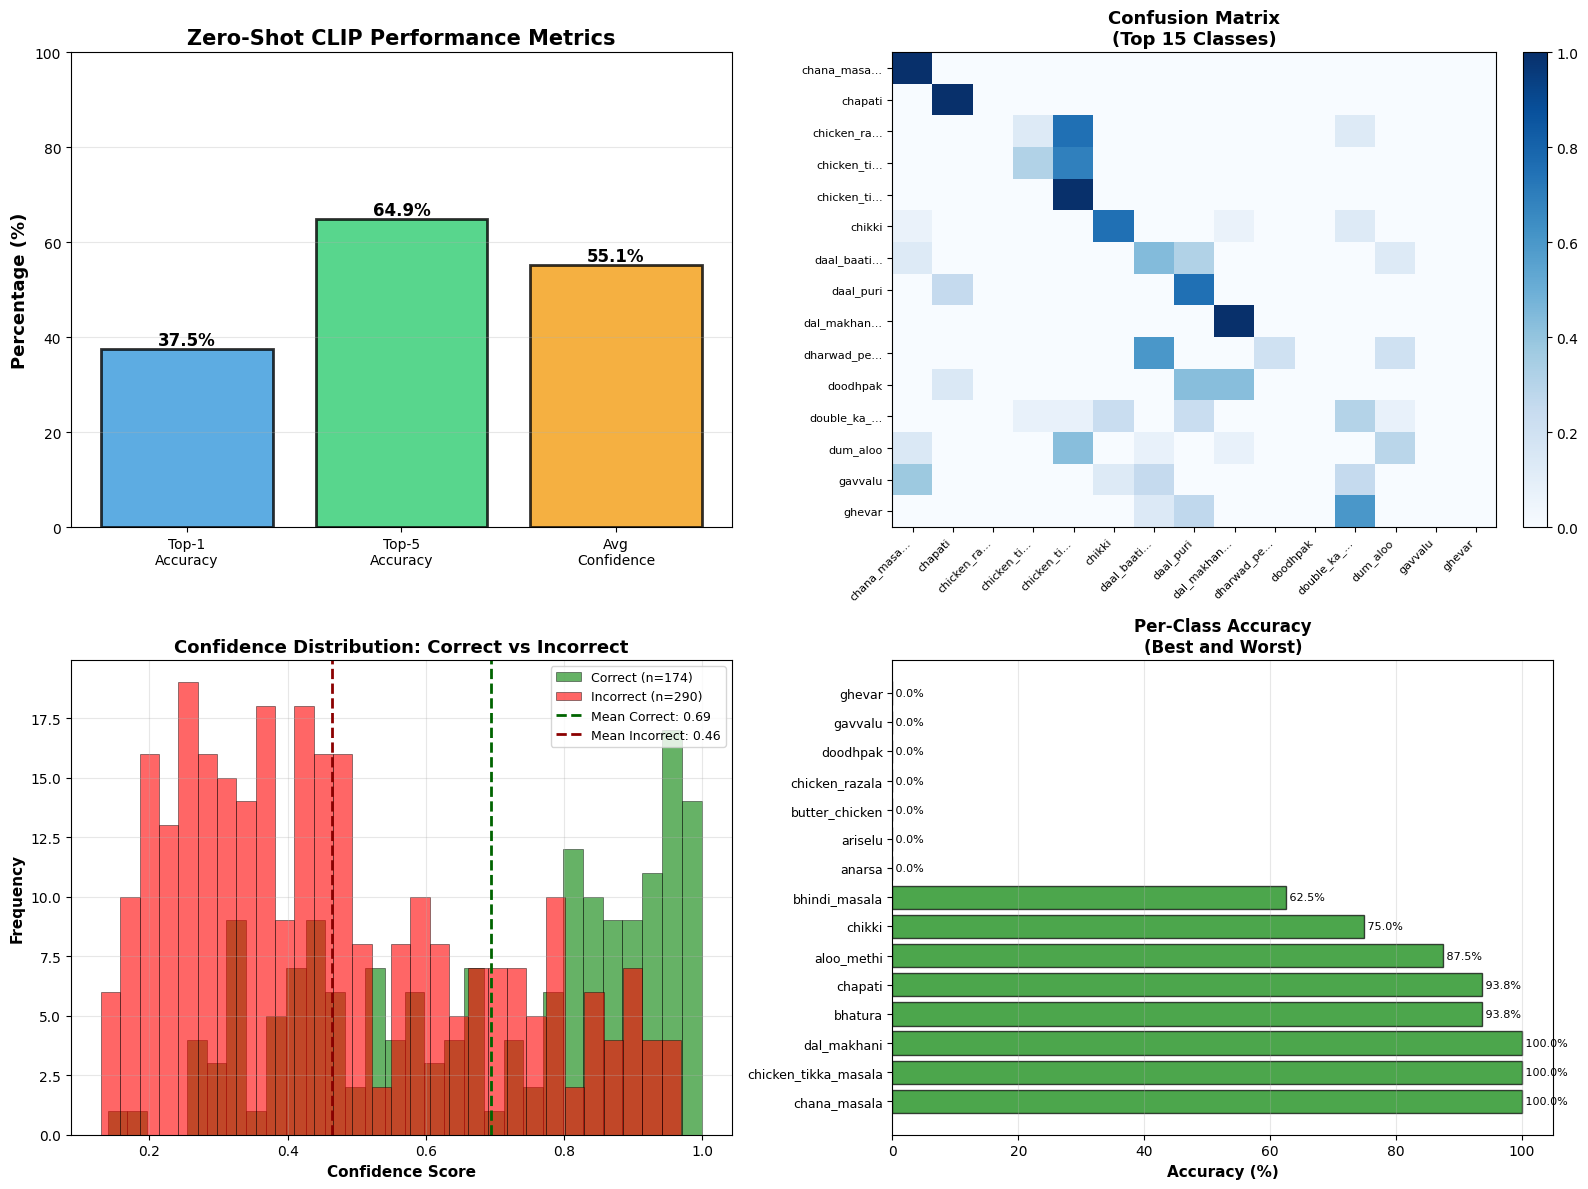

   ✅ Saved: zero_shot_performance_summary.png

📊 Creating sample predictions visualization...


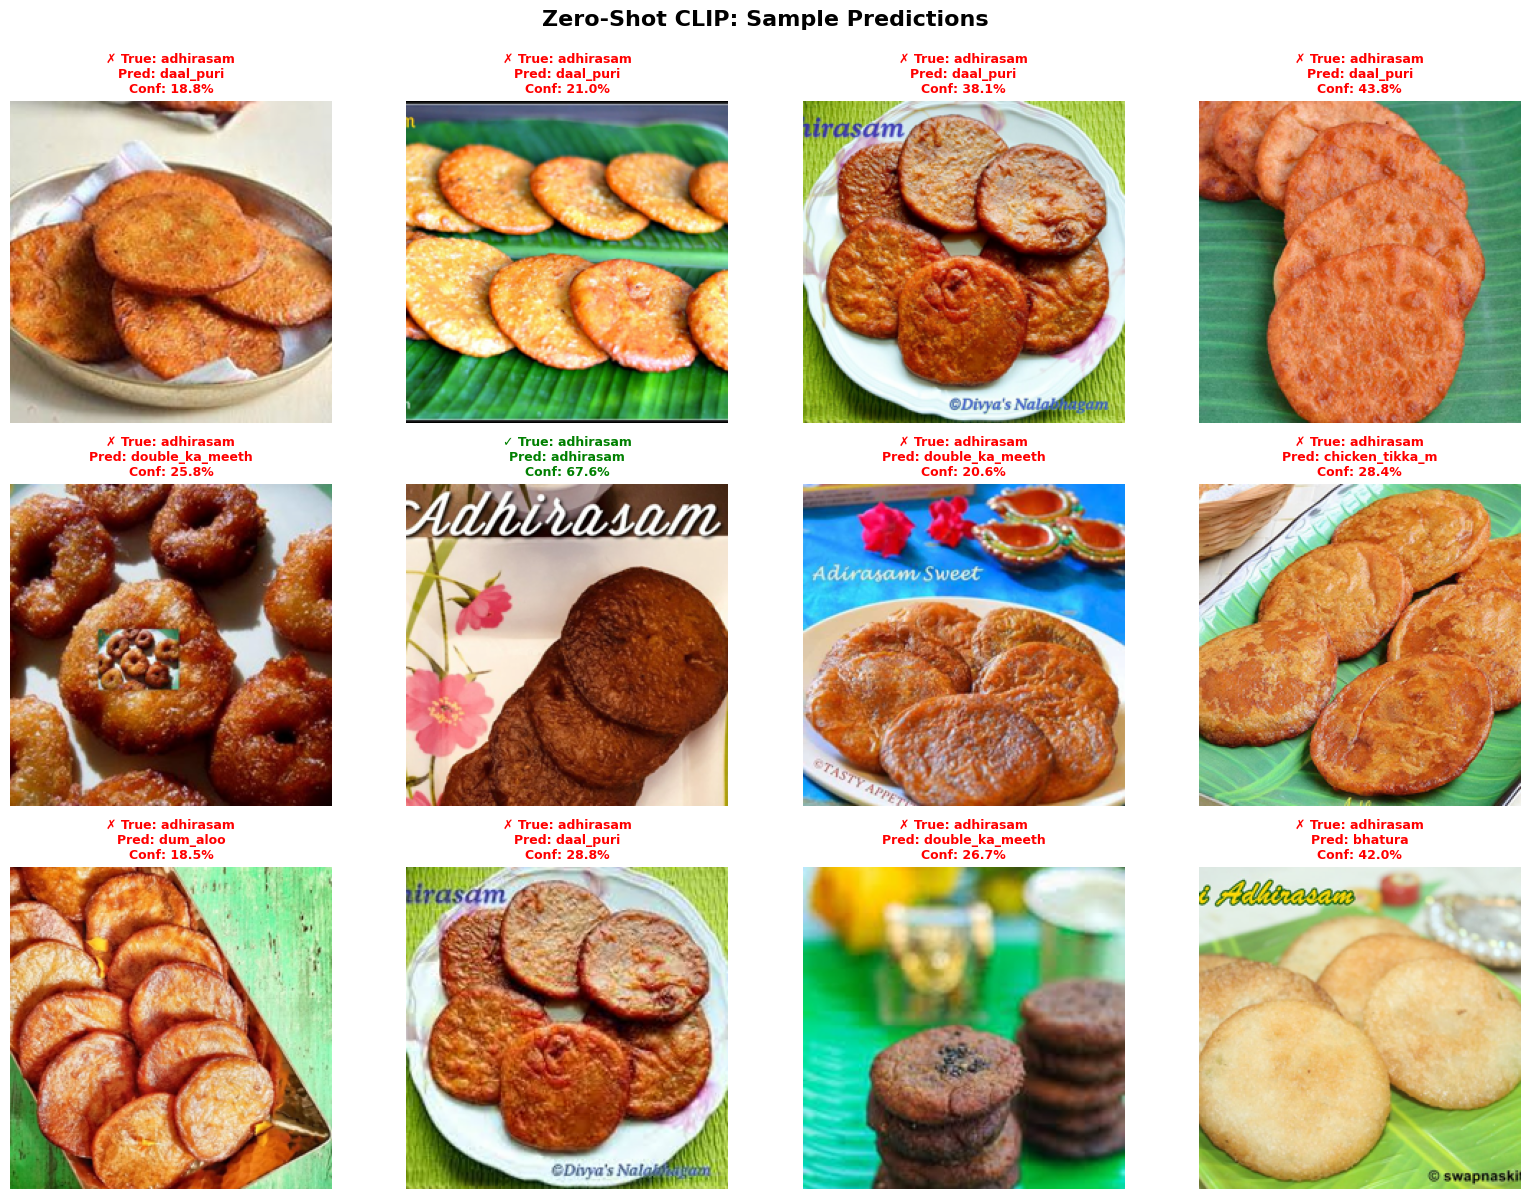

   ✅ Saved: zero_shot_sample_predictions.png

📊 Creating detailed analysis...


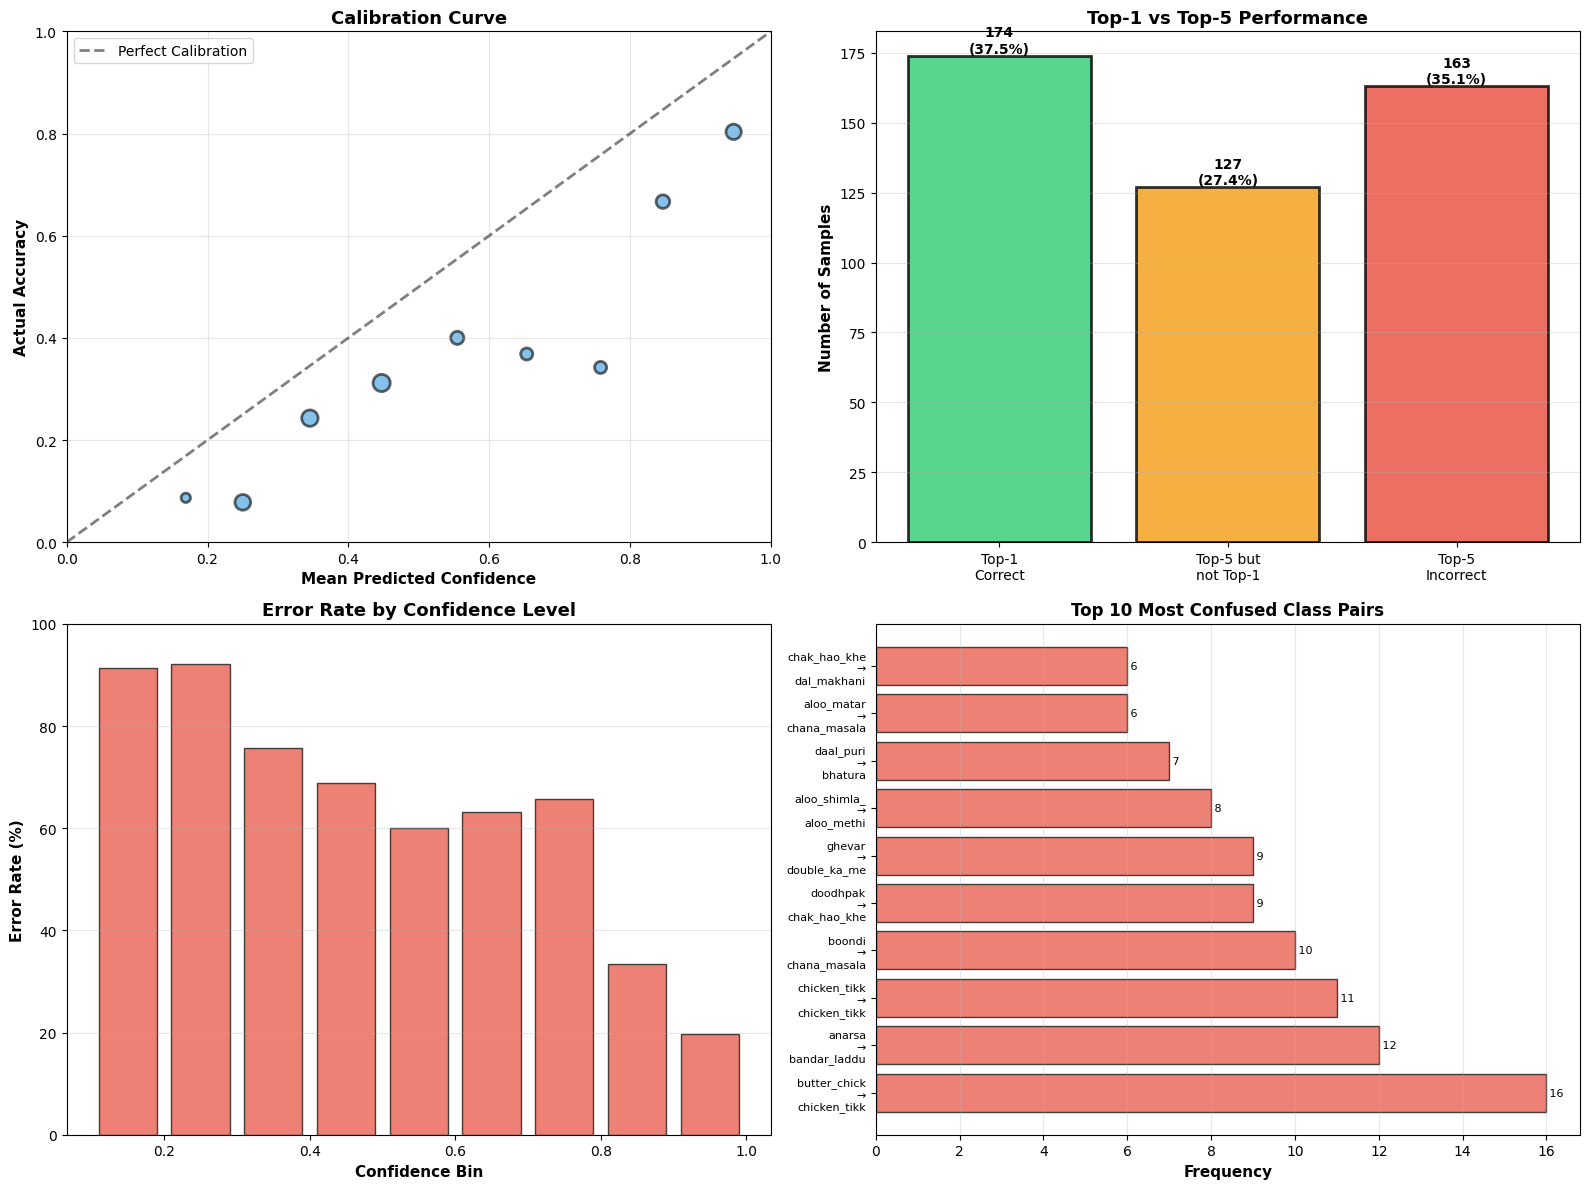

   ✅ Saved: zero_shot_detailed_analysis.png

📊 DETAILED ZERO-SHOT STATISTICS

🎯 Overall Performance:
   Top-1 Accuracy: 37.50%
   Top-5 Accuracy: 64.87%
   Total Samples: 464
   Correct: 174
   Incorrect: 290

🔍 Confidence Analysis:
   Overall Avg: 55.07%
   Correct Avg: 69.48%
   Incorrect Avg: 46.42%
   Confidence Gap: 23.06%

📈 Per-Class Statistics:
   Mean: 37.50%
   Std: 36.22%
   Best: chana_masala (100.00%)
   Worst: ghevar (0.00%)

💾 Per-class results saved to CSV

💾 All results and visualizations saved to: /content/drive/MyDrive/CapstoneProject/results/zero_shot_indianfood_30classes_16shot

📁 Generated Files:
   ✅ zero_shot_performance_summary.png
   ✅ zero_shot_sample_predictions.png
   ✅ zero_shot_detailed_analysis.png
   ✅ zero_shot_per_class_results.csv
   ✅ results.json
   ✅ predictions.npy, labels.npy, confidences.npy, logits.pt

✅ Zero-Shot experiment complete!

🎉 ZERO-SHOT CLIP READY!

📊 Quick Summary:
   Model: Zero-Shot CLIP
   Prompt: 'a photo of a {}'
   Classes: 3

In [ ]:
# ============================================================================
# CELL 7: Zero-Shot CLIP Implementation with Test Visualizations
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import pandas as pd
import torch
import os
import json
from tqdm import tqdm

print(f"\n{'='*70}")
print("🎯 ZERO-SHOT CLIP IMPLEMENTATION")
print("="*70)

# ============================================================================
# PART 1: Zero-Shot CLIP Class (Enhanced with detailed metrics)
# ============================================================================

class ZeroShotCLIP:
    """
    Zero-Shot CLIP classifier using hand-crafted prompts.
    No training required - uses frozen CLIP model.
    """

    def __init__(self, clip_model, tokenizer, class_names, prompt_template, device='cuda'):
        """
        Args:
            clip_model: Pre-trained CLIP model
            tokenizer: CLIP tokenizer
            class_names: List of class names
            prompt_template: Template like "a photo of a {}"
            device: 'cuda' or 'cpu'
        """
        self.clip_model = clip_model
        self.tokenizer = tokenizer
        self.class_names = class_names
        self.prompt_template = prompt_template
        self.device = device

        # Pre-compute text features
        self.text_features = self._build_text_features()

        print(f"✅ Zero-Shot CLIP initialized")
        print(f"   Classes: {len(class_names)}")
        print(f"   Prompt: '{prompt_template}'")

    def _build_text_features(self):
        """Pre-compute text features for all classes."""
        texts = [
            self.prompt_template.format(class_name.replace('_', ' '))
            for class_name in self.class_names
        ]

        text_tokens = self.tokenizer(texts).to(self.device)

        with torch.no_grad():
            text_features = self.clip_model.encode_text(text_tokens)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        return text_features

    def predict(self, images):
        """
        Predict class for batch of images.

        Args:
            images: Tensor of shape (batch_size, 3, H, W)

        Returns:
            logits: Tensor of shape (batch_size, num_classes)
        """
        with torch.no_grad():
            # Encode images
            image_features = self.clip_model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            # Compute similarity
            logits = (image_features @ self.text_features.t()) * self.clip_model.logit_scale.exp()

        return logits

    def evaluate(self, dataloader, collect_samples=True, max_samples=50):
        """
        Evaluate on a dataset with detailed metrics.

        Args:
            dataloader: DataLoader for evaluation
            collect_samples: Whether to collect sample images for visualization
            max_samples: Maximum number of samples to collect

        Returns:
            Dictionary with comprehensive results
        """
        self.clip_model.eval()

        all_predictions = []
        all_labels = []
        all_logits = []
        all_confidences = []
        all_top5_preds = []

        # For visualization
        sample_images = []
        sample_labels = []
        sample_predictions = []
        sample_confidences = []

        print(f"\n📊 Evaluating on {len(dataloader)} batches...")

        with torch.no_grad():
            for images, labels in tqdm(dataloader, desc="🔍 Zero-Shot Evaluation"):
                images = images.to(self.device)
                logits = self.predict(images)

                # Get predictions and confidences
                probs = torch.softmax(logits, dim=1)
                confidences, predictions = torch.max(probs, dim=1)

                # Get top-5 predictions
                top5_probs, top5_preds = torch.topk(probs, min(5, len(self.class_names)), dim=1)

                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.numpy())
                all_logits.append(logits.cpu())
                all_confidences.extend(confidences.cpu().numpy())
                all_top5_preds.extend(top5_preds.cpu().numpy())

                # Collect samples for visualization
                if collect_samples and len(sample_images) < max_samples:
                    for img, lbl, pred, conf in zip(images, labels, predictions, confidences):
                        if len(sample_images) < max_samples:
                            sample_images.append(img.cpu())
                            sample_labels.append(lbl.cpu().item())
                            sample_predictions.append(pred.cpu().item())
                            sample_confidences.append(conf.cpu().item())

        all_logits = torch.cat(all_logits, dim=0)
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)
        all_confidences = np.array(all_confidences)
        all_top5_preds = np.array(all_top5_preds)

        # Calculate metrics
        accuracy = (all_predictions == all_labels).sum() / len(all_labels) * 100

        # Top-5 accuracy
        top5_correct = sum([1 for i, label in enumerate(all_labels)
                           if label in all_top5_preds[i]])
        top5_accuracy = top5_correct / len(all_labels) * 100

        # Confidence analysis
        correct_mask = all_predictions == all_labels
        correct_confidences = all_confidences[correct_mask]
        incorrect_confidences = all_confidences[~correct_mask]

        print(f"\n✅ Evaluation complete!")
        print(f"   Top-1 Accuracy: {accuracy:.2f}%")
        print(f"   Top-5 Accuracy: {top5_accuracy:.2f}%")
        print(f"   Samples evaluated: {len(all_labels)}")

        return {
            'accuracy': accuracy,
            'top5_accuracy': top5_accuracy,
            'predictions': all_predictions,
            'labels': all_labels,
            'logits': all_logits,
            'confidences': all_confidences,
            'correct_confidences': correct_confidences,
            'incorrect_confidences': incorrect_confidences,
            'top5_predictions': all_top5_preds,
            'sample_images': sample_images,
            'sample_labels': sample_labels,
            'sample_predictions': sample_predictions,
            'sample_confidences': sample_confidences
        }


# ============================================================================
# PART 2: Visualization Functions
# ============================================================================

def visualize_zero_shot_results(zero_shot_model, results, class_names, save_dir):
    """
    Create comprehensive visualizations for zero-shot results.
    """

    print(f"\n{'='*70}")
    print("📊 CREATING ZERO-SHOT VISUALIZATIONS")
    print("="*70)

    os.makedirs(save_dir, exist_ok=True)

    predictions = results['predictions']
    labels = results['labels']
    confidences = results['confidences']

    # ========================================================================
    # Visualization 1: Overall Performance Summary (4 subplots)
    # ========================================================================

    print(f"\n📊 Creating performance summary...")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Accuracy Metrics
    ax = axes[0, 0]
    metrics = ['Top-1\nAccuracy', 'Top-5\nAccuracy', 'Avg\nConfidence']
    values = [
        results['accuracy'],
        results['top5_accuracy'],
        np.mean(confidences) * 100
    ]
    colors = ['#3498db', '#2ecc71', '#f39c12']

    bars = ax.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
    ax.set_title('Zero-Shot CLIP Performance Metrics', fontsize=15, fontweight='bold')
    ax.set_ylim([0, 100])
    ax.grid(True, axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.1f}%', ha='center', va='bottom',
               fontsize=12, fontweight='bold')

    # Plot 2: Confusion Matrix (top 15 classes)
    ax = axes[0, 1]

    unique_labels, counts = np.unique(labels, return_counts=True)
    n_display = min(15, len(unique_labels))

    if len(unique_labels) > n_display:
        top_indices = unique_labels[np.argsort(counts)[-n_display:]]
        mask = np.isin(labels, top_indices)
        filtered_labels = labels[mask]
        filtered_preds = predictions[mask]

        label_map = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted(top_indices))}
        remapped_labels = np.array([label_map[l] for l in filtered_labels])
        remapped_preds = np.array([label_map[p] if p in label_map else -1 for p in filtered_preds])

        valid_mask = remapped_preds != -1
        cm = confusion_matrix(remapped_labels[valid_mask], remapped_preds[valid_mask])
        display_classes = [class_names[i] for i in sorted(top_indices)]
    else:
        cm = confusion_matrix(labels, predictions)
        display_classes = class_names

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm)

    im = ax.imshow(cm_norm, cmap='Blues', aspect='auto')
    ax.set_title(f'Confusion Matrix\n(Top {n_display} Classes)', fontsize=13, fontweight='bold')

    tick_marks = np.arange(len(display_classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    short_names = [name[:10] + '...' if len(name) > 10 else name for name in display_classes]
    ax.set_xticklabels(short_names, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(short_names, fontsize=8)

    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Plot 3: Confidence Distribution
    ax = axes[1, 0]

    correct_mask = predictions == labels
    correct_conf = confidences[correct_mask]
    incorrect_conf = confidences[~correct_mask]

    ax.hist(correct_conf, bins=30, alpha=0.6, color='green',
           label=f'Correct (n={len(correct_conf)})', edgecolor='black', linewidth=0.5)
    ax.hist(incorrect_conf, bins=30, alpha=0.6, color='red',
           label=f'Incorrect (n={len(incorrect_conf)})', edgecolor='black', linewidth=0.5)

    ax.axvline(np.mean(correct_conf), color='darkgreen', linestyle='--', linewidth=2,
              label=f'Mean Correct: {np.mean(correct_conf):.2f}')
    if len(incorrect_conf) > 0:
        ax.axvline(np.mean(incorrect_conf), color='darkred', linestyle='--', linewidth=2,
                  label=f'Mean Incorrect: {np.mean(incorrect_conf):.2f}')

    ax.set_xlabel('Confidence Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title('Confidence Distribution: Correct vs Incorrect', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # Plot 4: Per-Class Accuracy
    ax = axes[1, 1]

    class_correct = np.zeros(len(class_names))
    class_total = np.zeros(len(class_names))

    for pred, label in zip(predictions, labels):
        class_total[label] += 1
        if pred == label:
            class_correct[label] += 1

    class_acc = {}
    for i in range(len(class_names)):
        if class_total[i] > 0:
            class_acc[i] = 100 * class_correct[i] / class_total[i]

    sorted_classes = sorted(class_acc.items(), key=lambda x: x[1], reverse=True)

    # Show top 8 and bottom 7
    if len(sorted_classes) > 15:
        top_classes = sorted_classes[:8]
        bottom_classes = sorted_classes[-7:]
        selected_classes = top_classes + bottom_classes
    else:
        selected_classes = sorted_classes

    class_indices = [idx for idx, _ in selected_classes]
    class_names_selected = [class_names[idx][:20] for idx in class_indices]
    class_accs = [acc for _, acc in selected_classes]

    colors_bars = ['green' if acc > 50 else 'red' for acc in class_accs]

    y_pos = np.arange(len(class_names_selected))
    bars = ax.barh(y_pos, class_accs, color=colors_bars, alpha=0.7, edgecolor='black')

    ax.set_yticks(y_pos)
    ax.set_yticklabels(class_names_selected, fontsize=9)
    ax.set_xlabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax.set_title('Per-Class Accuracy\n(Best and Worst)', fontsize=12, fontweight='bold')
    ax.grid(True, axis='x', alpha=0.3)

    for i, (bar, acc) in enumerate(zip(bars, class_accs)):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2.,
               f' {acc:.1f}%', va='center', fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'zero_shot_performance_summary.png'),
               dpi=300, bbox_inches='tight')
    plt.show()

    print(f"   ✅ Saved: zero_shot_performance_summary.png")

    # ========================================================================
    # Visualization 2: Sample Predictions
    # ========================================================================

    print(f"\n📊 Creating sample predictions visualization...")

    sample_images = results.get('sample_images', [])
    sample_labels = results.get('sample_labels', [])
    sample_predictions = results.get('sample_predictions', [])
    sample_confidences = results.get('sample_confidences', [])

    if len(sample_images) > 0:
        num_samples = min(12, len(sample_images))

        fig, axes = plt.subplots(3, 4, figsize=(16, 12))
        axes = axes.flatten()

        mean = np.array([0.48145466, 0.4578275, 0.40821073])
        std = np.array([0.26862954, 0.26130258, 0.27577711])

        for idx in range(num_samples):
            ax = axes[idx]

            image = sample_images[idx]
            true_label = sample_labels[idx]
            pred_label = sample_predictions[idx]
            confidence = sample_confidences[idx]

            # Denormalize
            img_display = image.permute(1, 2, 0).numpy()
            img_display = img_display * std + mean
            img_display = np.clip(img_display, 0, 1)

            ax.imshow(img_display)
            ax.axis('off')

            is_correct = (true_label == pred_label)
            color = 'green' if is_correct else 'red'
            marker = '✓' if is_correct else '✗'

            true_class = class_names[true_label]
            pred_class = class_names[pred_label]

            title = f'{marker} True: {true_class[:15]}\nPred: {pred_class[:15]}\nConf: {confidence*100:.1f}%'
            ax.set_title(title, fontsize=9, color=color, fontweight='bold')

        for idx in range(num_samples, len(axes)):
            axes[idx].axis('off')

        plt.suptitle('Zero-Shot CLIP: Sample Predictions', fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'zero_shot_sample_predictions.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        print(f"   ✅ Saved: zero_shot_sample_predictions.png")

    # ========================================================================
    # Visualization 3: Detailed Analysis
    # ========================================================================

    print(f"\n📊 Creating detailed analysis...")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Calibration Curve
    ax = axes[0, 0]

    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    bin_accs = []
    bin_confs = []
    bin_counts = []

    for i in range(n_bins):
        mask = (confidences >= bin_edges[i]) & (confidences < bin_edges[i+1])
        if mask.sum() > 0:
            bin_acc = (predictions[mask] == labels[mask]).sum() / mask.sum()
            bin_conf = confidences[mask].mean()
            bin_accs.append(bin_acc)
            bin_confs.append(bin_conf)
            bin_counts.append(mask.sum())

    if len(bin_accs) > 0:
        ax.scatter(bin_confs, bin_accs, s=[c*2 for c in bin_counts], alpha=0.6,
                  color='#3498db', edgecolors='black', linewidth=2)

    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5, label='Perfect Calibration')

    ax.set_xlabel('Mean Predicted Confidence', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual Accuracy', fontsize=11, fontweight='bold')
    ax.set_title('Calibration Curve', fontsize=13, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    # Plot 2: Top-5 Analysis
    ax = axes[0, 1]

    top5_preds = results['top5_predictions']

    in_top5_but_not_top1 = []
    for i, label in enumerate(labels):
        if predictions[i] != label and label in top5_preds[i]:
            in_top5_but_not_top1.append(i)

    top5_correct_count = int(results['top5_accuracy'] * len(labels) / 100)
    categories = ['Top-1\nCorrect', 'Top-5 but\nnot Top-1', 'Top-5\nIncorrect']
    values = [
        (predictions == labels).sum(),
        len(in_top5_but_not_top1),
        len(labels) - top5_correct_count
    ]
    colors_cat = ['#2ecc71', '#f39c12', '#e74c3c']

    bars = ax.bar(categories, values, color=colors_cat, alpha=0.8, edgecolor='black', linewidth=2)
    ax.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
    ax.set_title('Top-1 vs Top-5 Performance', fontsize=13, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        percentage = 100 * height / len(labels)
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{int(height)}\n({percentage:.1f}%)',
               ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Plot 3: Error Rate by Confidence
    ax = axes[1, 0]

    error_bins = []
    conf_bin_centers = []

    for i in range(n_bins):
        mask = (confidences >= bin_edges[i]) & (confidences < bin_edges[i+1])
        if mask.sum() > 0:
            error_rate = (predictions[mask] != labels[mask]).sum() / mask.sum() * 100
            error_bins.append(error_rate)
            conf_bin_centers.append(bin_centers[i])

    if len(error_bins) > 0:
        bars = ax.bar(conf_bin_centers, error_bins, width=0.08, alpha=0.7,
                     color='#e74c3c', edgecolor='black', linewidth=1)

    ax.set_xlabel('Confidence Bin', fontsize=11, fontweight='bold')
    ax.set_ylabel('Error Rate (%)', fontsize=11, fontweight='bold')
    ax.set_title('Error Rate by Confidence Level', fontsize=13, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim([0, 100])

    # Plot 4: Most Confused Pairs
    ax = axes[1, 1]

    confused_pairs = []
    for i in range(len(predictions)):
        if predictions[i] != labels[i]:
            confused_pairs.append((labels[i], predictions[i]))

    if len(confused_pairs) > 0:
        pair_counts = {}
        for true_label, pred_label in confused_pairs:
            pair = (true_label, pred_label)
            pair_counts[pair] = pair_counts.get(pair, 0) + 1

        top_confused = sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10]

        if len(top_confused) > 0:
            pair_labels = []
            pair_values = []

            for (true_idx, pred_idx), count in top_confused:
                true_class = class_names[true_idx]
                pred_class = class_names[pred_idx]
                label = f'{true_class[:12]}\n→\n{pred_class[:12]}'
                pair_labels.append(label)
                pair_values.append(count)

            y_pos = np.arange(len(pair_labels))
            bars = ax.barh(y_pos, pair_values, color='#e74c3c', alpha=0.7, edgecolor='black')

            ax.set_yticks(y_pos)
            ax.set_yticklabels(pair_labels, fontsize=8)
            ax.set_xlabel('Frequency', fontsize=11, fontweight='bold')
            ax.set_title('Top 10 Most Confused Class Pairs', fontsize=12, fontweight='bold')
            ax.grid(True, axis='x', alpha=0.3)

            for i, (bar, val) in enumerate(zip(bars, pair_values)):
                ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2.,
                       f' {val}', va='center', fontsize=8)
        else:
            ax.text(0.5, 0.5, 'No confusion data', ha='center', va='center',
                   fontsize=14, transform=ax.transAxes)
            ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'Perfect predictions!', ha='center', va='center',
               fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'zero_shot_detailed_analysis.png'),
               dpi=300, bbox_inches='tight')
    plt.show()

    print(f"   ✅ Saved: zero_shot_detailed_analysis.png")

    # ========================================================================
    # Print Statistics
    # ========================================================================

    print(f"\n{'='*70}")
    print("📊 DETAILED ZERO-SHOT STATISTICS")
    print("="*70)

    print(f"\n🎯 Overall Performance:")
    print(f"   Top-1 Accuracy: {results['accuracy']:.2f}%")
    print(f"   Top-5 Accuracy: {results['top5_accuracy']:.2f}%")
    print(f"   Total Samples: {len(labels)}")
    print(f"   Correct: {(predictions == labels).sum()}")
    print(f"   Incorrect: {(predictions != labels).sum()}")

    print(f"\n🔍 Confidence Analysis:")
    print(f"   Overall Avg: {np.mean(confidences)*100:.2f}%")
    print(f"   Correct Avg: {np.mean(correct_conf)*100:.2f}%")
    if len(incorrect_conf) > 0:
        print(f"   Incorrect Avg: {np.mean(incorrect_conf)*100:.2f}%")
        print(f"   Confidence Gap: {(np.mean(correct_conf) - np.mean(incorrect_conf))*100:.2f}%")

    if len(class_acc) > 0:
        print(f"\n📈 Per-Class Statistics:")
        print(f"   Mean: {np.mean(list(class_acc.values())):.2f}%")
        print(f"   Std: {np.std(list(class_acc.values())):.2f}%")
        if len(sorted_classes) > 0:
            print(f"   Best: {class_names[sorted_classes[0][0]]} ({sorted_classes[0][1]:.2f}%)")
            print(f"   Worst: {class_names[sorted_classes[-1][0]]} ({sorted_classes[-1][1]:.2f}%)")

    # Export per-class results
    per_class_results = []
    for i in range(len(class_names)):
        if class_total[i] > 0:
            per_class_results.append({
                'Class': class_names[i],
                'Accuracy': 100 * class_correct[i] / class_total[i],
                'Correct': int(class_correct[i]),
                'Total': int(class_total[i])
            })

    if len(per_class_results) > 0:
        per_class_df = pd.DataFrame(per_class_results)
        per_class_df = per_class_df.sort_values('Accuracy', ascending=False)
        per_class_df.to_csv(os.path.join(save_dir, 'zero_shot_per_class_results.csv'), index=False)
        print(f"\n💾 Per-class results saved to CSV")


# ============================================================================
# PART 3: Main Execution Function
# ============================================================================

def run_zero_shot_experiment(clip_model, tokenizer, class_names,
                             train_loader, val_loader, prompt_template,
                             save_dir, device='cuda'):
    """
    Run complete zero-shot experiment with visualizations.
    """
    print(f"\n{'='*70}")
    print("🎯 ZERO-SHOT CLIP EXPERIMENT")
    print("="*70)

    # Initialize zero-shot classifier
    zero_shot_model = ZeroShotCLIP(
        clip_model=clip_model,
        tokenizer=tokenizer,
        class_names=class_names,
        prompt_template=prompt_template,
        device=device
    )

    # Evaluate on validation set
    print(f"\n📊 Evaluating on validation set...")
    results = zero_shot_model.evaluate(val_loader, collect_samples=True, max_samples=50)

    print(f"\n{'='*70}")
    print(f"📈 ZERO-SHOT RESULTS:")
    print(f"   Top-1 Accuracy: {results['accuracy']:.2f}%")
    print(f"   Top-5 Accuracy: {results['top5_accuracy']:.2f}%")
    print("="*70)

    # Create visualizations
    visualize_zero_shot_results(zero_shot_model, results, class_names, save_dir)

    # Save results
    os.makedirs(save_dir, exist_ok=True)

    results_dict = {
        'method': 'Zero-Shot',
        'accuracy': float(results['accuracy']),
        'top5_accuracy': float(results['top5_accuracy']),
        'prompt_template': prompt_template,
        'num_classes': len(class_names),
        'class_names': class_names,
        'avg_confidence': float(np.mean(results['confidences']) * 100),
    }

    if len(results['correct_confidences']) > 0:
        results_dict['avg_correct_confidence'] = float(np.mean(results['correct_confidences']) * 100)

    if len(results['incorrect_confidences']) > 0:
        results_dict['avg_incorrect_confidence'] = float(np.mean(results['incorrect_confidences']) * 100)

    with open(os.path.join(save_dir, 'results.json'), 'w') as f:
        json.dump(results_dict, f, indent=2)

    # Save predictions
    np.save(os.path.join(save_dir, 'predictions.npy'), results['predictions'])
    np.save(os.path.join(save_dir, 'labels.npy'), results['labels'])
    np.save(os.path.join(save_dir, 'confidences.npy'), results['confidences'])
    torch.save(results['logits'], os.path.join(save_dir, 'logits.pt'))

    print(f"\n💾 All results and visualizations saved to: {save_dir}")
    print(f"\n📁 Generated Files:")
    print(f"   ✅ zero_shot_performance_summary.png")
    print(f"   ✅ zero_shot_sample_predictions.png")
    print(f"   ✅ zero_shot_detailed_analysis.png")
    print(f"   ✅ zero_shot_per_class_results.csv")
    print(f"   ✅ results.json")
    print(f"   ✅ predictions.npy, labels.npy, confidences.npy, logits.pt")

    return zero_shot_model, results


# ============================================================================
# PART 4: EXECUTE ZERO-SHOT EXPERIMENT
# ============================================================================

# Determine prompt template
if len(enabled_datasets) > 0:
    prompt_template = DATASET_CONFIG[enabled_datasets[0]]['prompt_template']
else:
    prompt_template = "a photo of a {}."

print(f"\n📝 Using prompt template: '{prompt_template}'")

# Run zero-shot experiment with visualizations
zero_shot_model, zero_shot_results = run_zero_shot_experiment(
    clip_model=clip_model,
    tokenizer=clip_tokenizer,
    class_names=class_names,
    train_loader=train_loader,
    val_loader=val_loader,
    prompt_template=prompt_template,
    save_dir=CHECKPOINT_DIRS['zero_shot'],
    device=device
)

print("\n✅ Zero-Shot experiment complete!")
print(f"\n{'='*70}")
print("🎉 ZERO-SHOT CLIP READY!")
print("="*70)
print(f"\n📊 Quick Summary:")
print(f"   Model: Zero-Shot CLIP")
print(f"   Prompt: '{prompt_template}'")
print(f"   Classes: {len(class_names)}")
print(f"   Test Samples: {len(zero_shot_results['labels'])}")
print(f"   Top-1 Accuracy: {zero_shot_results['accuracy']:.2f}%")
print(f"   Top-5 Accuracy: {zero_shot_results['top5_accuracy']:.2f}%")
print(f"\n📁 Results Location: {CHECKPOINT_DIRS['zero_shot']}")
print(f"\n🎯 Next: Proceed to Cell 8 for CoOp training!")
print("="*70)

## CELL 8: CoOp (Context Optimization) Implementation

In [ ]:
# ============================================================================
# CELL 8: CoOp (Context Optimization) Implementation
# ============================================================================

class CoOpPrompter(nn.Module):
    """
    CoOp: Learns continuous context tokens that are prepended/appended to class names.
    Context is FIXED for all images (not image-conditional).
    """

    def __init__(self, clip_model, classnames, n_ctx=16, csc=False,
                 pos='end', init_std=0.02, device='cuda'):
        """
        Args:
            clip_model: Pre-trained CLIP model
            classnames: List of class names
            n_ctx: Number of context tokens to learn
            csc: Class-specific context (separate context per class)
            pos: Context position ('end' or 'mid')
            init_std: Standard deviation for initialization
            device: 'cuda' or 'cpu'
        """
        super().__init__()

        self.clip = clip_model
        self.dtype = clip_model.text_projection.dtype
        self.device = device
        self.n_ctx = n_ctx
        self.csc = csc
        self.pos = pos
        self.classnames = classnames
        self.num_classes = len(classnames)

        # Get dimension of text embeddings
        ctx_dim = self.clip.token_embedding.weight.shape[1]

        # Initialize learnable context tokens
        if self.csc:
            # Class-specific context: separate context for each class
            self.ctx = nn.Parameter(
                torch.randn(self.num_classes, n_ctx, ctx_dim, device=device) * init_std
            )
            print(f"   Context: Class-specific ({self.num_classes} x {n_ctx} x {ctx_dim})")
        else:
            # Shared context: same context for all classes
            self.ctx = nn.Parameter(
                torch.randn(n_ctx, ctx_dim, device=device) * init_std
            )
            print(f"   Context: Shared ({n_ctx} x {ctx_dim})")

        # Tokenize class names
        self.tokenizer = open_clip.get_tokenizer("ViT-B-32")
        texts = [name.replace("_", " ") for name in classnames]
        self.class_tokens = self.tokenizer(texts).to(device)

        print(f"✅ CoOp Prompter initialized")
        print(f"   Classes: {self.num_classes}")
        print(f"   Context tokens: {n_ctx}")
        print(f"   Position: {pos}")
        print(f"   Trainable params: {sum(p.numel() for p in self.parameters()):,}")

    def _encode_text_from_embeddings(self, token_embeds):
        """Pass token embeddings through CLIP text encoder."""
        x = token_embeds + self.clip.positional_embedding
        x = self.clip.transformer(x)
        x = x[:, -1, :]  # Take features from EOS token
        x = self.clip.ln_final(x)
        x = x @ self.clip.text_projection
        return x

    def build_prompts(self):
        """Build text prompts by inserting learned context."""
        token_embed = self.clip.token_embedding
        class_tok_ids = self.class_tokens
        class_tok_embeds = token_embed(class_tok_ids)

        # Get context (expand if shared)
        if self.csc:
            ctx = self.ctx
        else:
            ctx = self.ctx.unsqueeze(0).expand(self.num_classes, -1, -1)

        # Build prompts for each class
        seqs = []
        T = class_tok_embeds.size(1)  # Max sequence length
        M = self.n_ctx
        half = M // 2

        START_ID = 49406  # [SOS] token
        END_ID = 49407    # [EOS] token

        for i in range(self.num_classes):
            cls_embeds = class_tok_embeds[i]

            # Find position of [EOS] token
            with torch.no_grad():
                ids = class_tok_ids[i]
                eos_pos = (ids == END_ID).nonzero(as_tuple=True)[0][0].item()

            # Extract valid class name tokens (between [SOS] and [EOS])
            cls_valid = cls_embeds[1:eos_pos]

            # Build sequence based on position
            if self.pos == "mid":
                # Insert context in the middle: [SOS] ctx1 [CLASS] ctx2 [EOS]
                seq = torch.cat([
                    token_embed.weight[START_ID].unsqueeze(0),
                    ctx[i, :half, :],
                    cls_valid,
                    ctx[i, half:, :],
                    token_embed.weight[END_ID].unsqueeze(0)
                ], dim=0)
            else:  # pos == "end"
                # Append context at end: [SOS] [CLASS] ctx [EOS]
                seq = torch.cat([
                    token_embed.weight[START_ID].unsqueeze(0),
                    cls_valid,
                    ctx[i, :, :],
                    token_embed.weight[END_ID].unsqueeze(0)
                ], dim=0)

            # Pad or truncate to fixed length
            if seq.size(0) > T:
                seq = seq[:T, :]
            else:
                pad = T - seq.size(0)
                if pad > 0:
                    seq = torch.cat([
                        seq,
                        torch.zeros(pad, seq.size(1), device=seq.device, dtype=seq.dtype)
                    ], dim=0)

            seqs.append(seq.unsqueeze(0))

        seqs = torch.cat(seqs, dim=0)
        return seqs

    def text_features(self):
        """Generate text features from learned prompts."""
        with torch.set_grad_enabled(self.training):
            seqs = self.build_prompts()
            feats = self._encode_text_from_embeddings(seqs)
            feats = feats / feats.norm(dim=-1, keepdim=True)
            return feats

    def forward(self, image_features):
        """
        Forward pass: compute logits for image features.

        Args:
            image_features: Tensor of shape (batch_size, feature_dim)

        Returns:
            logits: Tensor of shape (batch_size, num_classes)
        """
        text_feats = self.text_features()
        logits = (image_features @ text_feats.t()) * self.clip.logit_scale.exp()
        return logits


def train_coop_one_epoch(prompter, clip_model, train_loader, optimizer,
                         criterion, device, epoch):
    """Train CoOp for one epoch."""
    prompter.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}")

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Get frozen image features
        with torch.no_grad():
            image_features = clip_model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Forward pass (only context is trained)
        logits = prompter(image_features)
        loss = criterion(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        predictions = logits.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


def validate_coop(prompter, clip_model, val_loader, criterion, device):
    """Validate CoOp."""
    prompter.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images = images.to(device)
            labels = labels.to(device)

            # Get image features
            image_features = clip_model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            # Forward pass
            logits = prompter(image_features)
            loss = criterion(logits, labels)

            # Metrics
            total_loss += loss.item()
            predictions = logits.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.append(logits.cpu())

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    all_logits = torch.cat(all_logits, dim=0)

    return avg_loss, accuracy, np.array(all_predictions), np.array(all_labels), all_logits


print("✅ CoOp implementation ready!")

✅ CoOp implementation ready!


## CELL 9: CoCoOp (Conditional Context Optimization) Implementation

In [ ]:
# # ============================================================================
# # CELL 9: CoCoOp (Conditional Context Optimization) Implementation
# # ============================================================================

# class CoCoOpPrompter(nn.Module):
#     """
#     CoCoOp: Learns a meta-network that generates IMAGE-CONDITIONAL context.
#     Context adapts to each input image (unlike CoOp's fixed context).
#     """

#     def __init__(self, clip_model, classnames, n_ctx=16, pos='mid',
#                  init_std=0.02, device='cuda'):
#         """
#         Args:
#             clip_model: Pre-trained CLIP model
#             classnames: List of class names
#             n_ctx: Number of context tokens
#             pos: Context position ('end' or 'mid')
#             init_std: Standard deviation for initialization
#             device: 'cuda' or 'cpu'
#         """
#         super().__init__()

#         self.clip = clip_model
#         self.dtype = clip_model.text_projection.dtype
#         self.device = device
#         self.n_ctx = n_ctx
#         self.pos = pos
#         self.classnames = classnames
#         self.num_classes = len(classnames)

#         ctx_dim = self.clip.token_embedding.weight.shape[1]
#         vis_dim = self.clip.visual.output_dim

#         # Static base context (starting point)
#         self.ctx = nn.Parameter(
#             torch.randn(n_ctx, ctx_dim, device=device) * init_std
#         )

#         # Meta-network: generates image-specific adjustments - 2 layer

#         # hidden_dim = ctx_dim // 2
#         # self.meta_net = nn.Sequential(
#         #     nn.Linear(vis_dim, hidden_dim),
#         #     nn.ReLU(inplace=True),
#         #     nn.Linear(hidden_dim, n_ctx * ctx_dim)
#         # ).to(device) # Ensure the meta-network is moved to the specified device


#         # 4 layers - gradual compression
#         # hidden_dim1 = vis_dim // 2
#         # hidden_dim2 = ctx_dim
#         # hidden_dim = ctx_dim // 2

#         # self.meta_net = nn.Sequential(
#         #   nn.Linear(vis_dim, hidden_dim1),
#         #   nn.ReLU(inplace=True),
#         #   nn.Linear(hidden_dim1, hidden_dim2),
#         #   nn.ReLU(inplace=True),
#         #   nn.Linear(hidden_dim2, hidden_dim),
#         #   nn.ReLU(inplace=True),
#         #   nn.Linear(hidden_dim, n_ctx * ctx_dim)
#         # ).to(device)



#         #6-layer gradual compression architecture.
#         #Pattern: Smooth transition from input to output dimension

#         # Fix: Close triple quotes

#         #6 layer Calculate gradual step-down
#         hidden_dim1_6 = vis_dim * 3 // 4
#         hidden_dim2_6 = vis_dim // 2
#         hidden_dim3_6 = ctx_dim * 2
#         hidden_dim4_6 = ctx_dim * 3 // 2
#         hidden_dim_6 = ctx_dim // 2

#         self.meta_net = nn.Sequential(
#             nn.Linear(vis_dim, hidden_dim1_6),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.1),

#             nn.Linear(hidden_dim1_6, hidden_dim2_6),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.1),

#             nn.Linear(hidden_dim2_6, hidden_dim3_6),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.1),

#             nn.Linear(hidden_dim3_6, hidden_dim4_6),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.1),

#             nn.Linear(hidden_dim4_6, hidden_dim_6),
#             nn.ReLU(inplace=True),

#             nn.Linear(hidden_dim_6, n_ctx * ctx_dim)
#         ).to(device)
#         # Fix: Close triple quotes

#         #8-layer gradual compression architecture.
#         #Pattern: Smooth transition from input to output dimension

#         # Fix: Close triple quotes

#         # 8 layer Calculate gradual step-down
#         # hidden_dim1_8 = vis_dim * 3 // 4
#         # hidden_dim2_8 = vis_dim // 2
#         # hidden_dim3_8 = ctx_dim * 2
#         # hidden_dim4_8 = ctx_dim * 3 // 2
#         # hidden_dim5_8 = ctx_dim
#         # hidden_dim6_8 = ctx_dim * 3 // 4
#         # hidden_dim_8 = ctx_dim // 2

#         # self.meta_net_8_layer = nn.Sequential(
#         #     nn.Linear(vis_dim, hidden_dim1_8),
#         #     nn.ReLU(inplace=True),
#         #     nn.Dropout(0.1),

#         #     nn.Linear(hidden_dim1_8, hidden_dim2_8),
#         #     nn.ReLU(inplace=True),
#         #     nn.Dropout(0.1),

#         #     nn.Linear(hidden_dim2_8, hidden_dim3_8),
#         #     nn.ReLU(inplace=True),
#         #     nn.Dropout(0.1),

#         #     nn.Linear(hidden_dim3_8, hidden_dim4_8),
#         #     nn.ReLU(inplace=True),
#         #     nn.Dropout(0.1),

#         #     nn.Linear(hidden_dim4_8, hidden_dim5_8),
#         #     nn.ReLU(inplace=True),
#         #     nn.Dropout(0.1),

#         #     nn.Linear(hidden_dim5_8, hidden_dim6_8),
#         #     nn.ReLU(inplace=True),
#         #     nn.Dropout(0.1),

#         #     nn.Linear(hidden_dim6_8, hidden_dim_8),
#         #     nn.ReLU(inplace=True),

#         #     nn.Linear(hidden_dim_8, n_ctx * ctx_dim)
#         # ).to(device)
#         # Fix: Close triple quotes

#         # Initialize meta-network
#         for m in self.meta_net.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, std=0.02)
#                 nn.init.constant_(m.bias, 0.0)

#         # Tokenize class names
#         self.tokenizer = open_clip.get_tokenizer("ViT-B-32")
#         texts = [name.replace("_", " ") for name in classnames]
#         self.class_tokens = self.tokenizer(texts).to(device)

#         print(f"✅ CoCoOp Prompter initialized")
#         print(f"   Classes: {self.num_classes}")
#         print(f"   Context tokens: {n_ctx}")
#         print(f"   Position: {pos}")

#         # Print meta-network architecture details based on the selected architecture
#         if len(self.meta_net) == 7: # Corresponds to the 4-layer architecture
#              print(f"   Meta-network: {vis_dim} → {hidden_dim} → {n_ctx * ctx_dim}")
#         else:
#              print(f"   Meta-network: Custom/Unknown Architecture")

#         print(f"   Trainable params: {sum(p.numel() for p in self.parameters()):,}")

#     def generate_conditional_context(self, image_features):
#         """
#         Generate image-specific context using meta-network.

#         Args:
#             image_features: Tensor of shape (batch_size, vis_dim)

#         Returns:
#             conditional_ctx: Tensor of shape (batch_size, n_ctx, ctx_dim)
#         """
#         batch_size = image_features.size(0)

#         # Generate adjustment via meta-network
#         # Ensure image_features is on the correct device before passing to meta_net
#         # The meta_net itself also needs to be on the correct device
#         ctx_shift = self.meta_net(image_features)
#         ctx_shift = ctx_shift.view(batch_size, self.n_ctx, -1)

#         # Add to base context
#         conditional_ctx = self.ctx.unsqueeze(0) + ctx_shift

#         return conditional_ctx

#     def _encode_text_from_embeddings(self, token_embeds):
#         """Pass token embeddings through CLIP text encoder."""
#         x = token_embeds + self.clip.positional_embedding
#         x = self.clip.transformer(x)
#         x = x[:, -1, :]
#         x = self.clip.ln_final(x)
#         x = x @ self.clip.text_projection
#         return x

#     def build_conditional_prompts(self, image_features):
#         """
#         Build text prompts conditioned on input images.

#         Args:
#             image_features: Tensor of shape (batch_size, vis_dim)

#         Returns:
#             all_seqs: Tensor of shape (batch_size * num_classes, seq_len, ctx_dim)
#         """
#         batch_size = image_features.size(0)

#         # Generate image-conditional context
#         ctx = self.generate_conditional_context(image_features)

#         token_embed = self.clip.token_embedding
#         class_tok_ids = self.class_tokens
#         class_tok_embeds = token_embed(class_tok_ids)

#         START_ID = 49406
#         END_ID = 49407

#         all_seqs = []
#         T = 77  # Max sequence length for CLIP

#         for b in range(batch_size):
#             batch_ctx = ctx[b]  # Context for this image

#             for c in range(self.num_classes):
#                 cls_embeds = class_tok_embeds[c]

#                 # Find [EOS] position
#                 with torch.no_grad():
#                     ids = class_tok_ids[c]
#                     eos_pos = (ids == END_ID).nonzero(as_tuple=True)[0][0].item()

#                 cls_valid = cls_embeds[1:eos_pos]

#                 # Build sequence
#                 if self.pos == "mid":
#                     half = self.n_ctx // 2
#                     seq = torch.cat([
#                         token_embed.weight[START_ID].unsqueeze(0),
#                         batch_ctx[:half, :],
#                         cls_valid,
#                         batch_ctx[half:, :],
#                         token_embed.weight[END_ID].unsqueeze(0)
#                     ], dim=0)
#                 else:  # pos == "end"
#                     seq = torch.cat([
#                         token_embed.weight[START_ID].unsqueeze(0),
#                         cls_valid,
#                         batch_ctx,
#                         token_embed.weight[END_ID].unsqueeze(0)
#                     ], dim=0)

#                 # Pad or truncate
#                 if seq.size(0) > T:
#                     seq = seq[:T, :]
#                 else:
#                     pad = T - seq.size(0)
#                     if pad > 0:
#                         seq = torch.cat([
#                             seq,
#                             torch.zeros(pad, seq.size(1), device=seq.device, dtype=seq.dtype)
#                         ], dim=0)

#                 all_seqs.append(seq.unsqueeze(0))

#         all_seqs = torch.cat(all_seqs, dim=0)
#         return all_seqs

#     def forward(self, image_features):
#         """
#         Forward pass: generate conditional text features and compute logits.

#         Args:
#             image_features: Tensor of shape (batch_size, vis_dim)

#         Returns:
#             logits: Tensor of shape (batch_size, num_classes)
#         """
#         batch_size = image_features.size(0)

#         # Build conditional prompts
#         text_embeds = self.build_conditional_prompts(image_features)

#         # Encode text
#         text_features = self._encode_text_from_embeddings(text_embeds)
#         text_features = text_features / text_features.norm(dim=-1, keepdim=True)

#         # Reshape: (batch_size * num_classes, dim) → (batch_size, num_classes, dim)
#         text_features = text_features.view(batch_size, self.num_classes, -1)

#         # Normalize image features
#         image_features_norm = image_features / image_features.norm(dim=-1, keepdim=True)
#         image_features_norm = image_features_norm.unsqueeze(1)  # (batch_size, 1, dim)

#         # Compute similarity
#         logits = torch.bmm(image_features_norm, text_features.transpose(1, 2))
#         logits = logits.squeeze(1) * self.clip.logit_scale.exp()

#         return logits


# def train_cocoop_one_epoch(prompter, clip_model, train_loader, optimizer,
#                            criterion, device, epoch):
#     """Train CoCoOp for one epoch."""
#     prompter.train()
#     total_loss = 0
#     correct = 0
#     total = 0

#     pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}")

#     for images, labels in pbar:
#         images = images.to(device)
#         labels = labels.to(device)

#         # Get image features (frozen encoder)
#         with torch.no_grad():
#             image_features = clip_model.encode_image(images)

#         # Forward pass (meta-network generates conditional context)
#         logits = prompter(image_features)
#         loss = criterion(logits, labels)

#         # Backward pass
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Metrics
#         total_loss += loss.item()
#         predictions = logits.argmax(dim=1)
#         correct += (predictions == labels).sum().item()
#         total += labels.size(0)

#         pbar.set_postfix({
#             'loss': f'{loss.item():.4f}',
#             'acc': f'{100*correct/total:.2f}%'
#         })

#     avg_loss = total_loss / len(train_loader)
#     accuracy = 100 * correct / total

#     return avg_loss, accuracy


# def validate_cocoop(prompter, clip_model, val_loader, criterion, device):
#     """Validate CoCoOp."""
#     prompter.eval()
#     total_loss = 0
#     correct = 0
#     total = 0

#     all_predictions = []
#     all_labels = []
#     all_logits = []

#     with torch.no_grad():
#         for images, labels in tqdm(val_loader, desc="Validating"):
#             images = images.to(device)
#             labels = labels.to(device)

#             # Get image features
#             image_features = clip_model.encode_image(images)

#             # Forward pass
#             logits = prompter(image_features)
#             loss = criterion(logits, labels)

#             # Metrics
#             total_loss += loss.item()
#             predictions = logits.argmax(dim=1)
#             correct += (predictions == labels).sum().item()
#             total += labels.size(0)

#             all_predictions.extend(predictions.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#             all_logits.append(logits.cpu())

#     avg_loss = total_loss / len(val_loader)
#     accuracy = 100 * correct / total
#     all_logits = torch.cat(all_logits, dim=0)

#     return avg_loss, accuracy, np.array(all_predictions), np.array(all_labels), all_logits


# print("✅ CoCoOp implementation ready!")

In [ ]:
# ============================================================================
# CELL 9: CoCoOp (Conditional Context Optimization) Implementation
# ============================================================================

class CoCoOpPrompter(nn.Module):
    """
    CoCoOp: Learns a meta-network that generates IMAGE-CONDITIONAL context.
    Context adapts to each input image (unlike CoOp's fixed context).
    """

    def __init__(self, clip_model, classnames, n_ctx=16, pos='mid',
                 init_std=0.02, meta_net_layers=4, device='cuda'):
        """
        Args:
            clip_model: Pre-trained CLIP model
            classnames: List of class names
            n_ctx: Number of context tokens
            pos: Context position ('end' or 'mid')
            init_std: Standard deviation for initialization
            meta_net_layers: Number of layers in meta-network (2, 4, 6, or 8)
            device: 'cuda' or 'cpu'
        """
        super().__init__()

        self.clip = clip_model
        self.dtype = clip_model.text_projection.dtype
        self.device = device
        self.n_ctx = n_ctx
        self.pos = pos
        self.classnames = classnames
        self.num_classes = len(classnames)
        self.meta_net_layers = meta_net_layers

        ctx_dim = self.clip.token_embedding.weight.shape[1]
        vis_dim = self.clip.visual.output_dim

        # Static base context (starting point)
        self.ctx = nn.Parameter(
            torch.randn(n_ctx, ctx_dim, device=device) * init_std
        )

        # Build meta-network based on selected configuration
        self.meta_net = self._build_meta_net(vis_dim, ctx_dim, n_ctx, meta_net_layers).to(device)

        # Initialize meta-network
        for m in self.meta_net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, std=0.02)
                nn.init.constant_(m.bias, 0.0)

        # Tokenize class names
        self.tokenizer = open_clip.get_tokenizer("ViT-B-32")
        texts = [name.replace("_", " ") for name in classnames]
        self.class_tokens = self.tokenizer(texts).to(device)

        print(f"✅ CoCoOp Prompter initialized")
        print(f"   Classes: {self.num_classes}")
        print(f"   Context tokens: {n_ctx}")
        print(f"   Position: {pos}")
        print(f"   Meta-network layers: {meta_net_layers}")
        print(f"   Meta-network architecture: {self._get_meta_net_description(vis_dim, ctx_dim, n_ctx, meta_net_layers)}")
        print(f"   Trainable params: {sum(p.numel() for p in self.parameters()):,}")

    def _build_meta_net(self, vis_dim, ctx_dim, n_ctx, layers):
        """
        Build meta-network with specified number of layers.

        Args:
            vis_dim: Visual feature dimension
            ctx_dim: Context dimension
            n_ctx: Number of context tokens
            layers: Number of layers (2, 4, 6, or 8)

        Returns:
            nn.Sequential: Meta-network
        """
        output_dim = n_ctx * ctx_dim

        if layers == 2:
            # 2-layer: Simple architecture
            hidden_dim = ctx_dim // 2
            return nn.Sequential(
                nn.Linear(vis_dim, hidden_dim),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_dim, output_dim)
            )

        elif layers == 4:
            # 4-layer: Gradual compression
            hidden_dim1 = vis_dim // 2
            hidden_dim2 = ctx_dim
            hidden_dim3 = ctx_dim // 2
            return nn.Sequential(
                nn.Linear(vis_dim, hidden_dim1),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_dim1, hidden_dim2),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_dim2, hidden_dim3),
                nn.ReLU(inplace=True),
                nn.Linear(hidden_dim3, output_dim)
            )

        elif layers == 6:
            # 6-layer: Gradual compression with dropout
            hidden_dim1 = vis_dim * 3 // 4
            hidden_dim2 = vis_dim // 2
            hidden_dim3 = ctx_dim * 2
            hidden_dim4 = ctx_dim * 3 // 2
            hidden_dim5 = ctx_dim // 2
            return nn.Sequential(
                nn.Linear(vis_dim, hidden_dim1),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),

                nn.Linear(hidden_dim1, hidden_dim2),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),

                nn.Linear(hidden_dim2, hidden_dim3),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),

                nn.Linear(hidden_dim3, hidden_dim4),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),

                nn.Linear(hidden_dim4, hidden_dim5),
                nn.ReLU(inplace=True),

                nn.Linear(hidden_dim5, output_dim)
            )

        elif layers == 8:
            # 8-layer: Deep gradual compression with dropout
            hidden_dim1 = vis_dim * 3 // 4
            hidden_dim2 = vis_dim // 2
            hidden_dim3 = ctx_dim * 2
            hidden_dim4 = ctx_dim * 3 // 2
            hidden_dim5 = ctx_dim
            hidden_dim6 = ctx_dim * 3 // 4
            hidden_dim7 = ctx_dim // 2
            return nn.Sequential(
                nn.Linear(vis_dim, hidden_dim1),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),

                nn.Linear(hidden_dim1, hidden_dim2),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),

                nn.Linear(hidden_dim2, hidden_dim3),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),

                nn.Linear(hidden_dim3, hidden_dim4),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),

                nn.Linear(hidden_dim4, hidden_dim5),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),

                nn.Linear(hidden_dim5, hidden_dim6),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),

                nn.Linear(hidden_dim6, hidden_dim7),
                nn.ReLU(inplace=True),

                nn.Linear(hidden_dim7, output_dim)
            )

        else:
            raise ValueError(f"Unsupported number of layers: {layers}. Choose from [2, 4, 6, 8]")

    def _get_meta_net_description(self, vis_dim, ctx_dim, n_ctx, layers):
        """Get a string description of the meta-network architecture."""
        output_dim = n_ctx * ctx_dim

        if layers == 2:
            hidden_dim = ctx_dim // 2
            return f"{vis_dim} → {hidden_dim} → {output_dim}"

        elif layers == 4:
            hidden_dim1 = vis_dim // 2
            hidden_dim2 = ctx_dim
            hidden_dim3 = ctx_dim // 2
            return f"{vis_dim} → {hidden_dim1} → {hidden_dim2} → {hidden_dim3} → {output_dim}"

        elif layers == 6:
            hidden_dim1 = vis_dim * 3 // 4
            hidden_dim2 = vis_dim // 2
            hidden_dim3 = ctx_dim * 2
            hidden_dim4 = ctx_dim * 3 // 2
            hidden_dim5 = ctx_dim // 2
            return f"{vis_dim} → {hidden_dim1} → {hidden_dim2} → {hidden_dim3} → {hidden_dim4} → {hidden_dim5} → {output_dim}"

        elif layers == 8:
            hidden_dim1 = vis_dim * 3 // 4
            hidden_dim2 = vis_dim // 2
            hidden_dim3 = ctx_dim * 2
            hidden_dim4 = ctx_dim * 3 // 2
            hidden_dim5 = ctx_dim
            hidden_dim6 = ctx_dim * 3 // 4
            hidden_dim7 = ctx_dim // 2
            return f"{vis_dim} → {hidden_dim1} → {hidden_dim2} → {hidden_dim3} → {hidden_dim4} → {hidden_dim5} → {hidden_dim6} → {hidden_dim7} → {output_dim}"

        return "Unknown"

    def generate_conditional_context(self, image_features):
        """
        Generate image-specific context using meta-network.

        Args:
            image_features: Tensor of shape (batch_size, vis_dim)

        Returns:
            conditional_ctx: Tensor of shape (batch_size, n_ctx, ctx_dim)
        """
        batch_size = image_features.size(0)

        # Generate adjustment via meta-network
        ctx_shift = self.meta_net(image_features)
        ctx_shift = ctx_shift.view(batch_size, self.n_ctx, -1)

        # Add to base context
        conditional_ctx = self.ctx.unsqueeze(0) + ctx_shift

        return conditional_ctx

    def _encode_text_from_embeddings(self, token_embeds):
        """Pass token embeddings through CLIP text encoder."""
        x = token_embeds + self.clip.positional_embedding
        x = self.clip.transformer(x)
        x = x[:, -1, :]
        x = self.clip.ln_final(x)
        x = x @ self.clip.text_projection
        return x

    def build_conditional_prompts(self, image_features):
        """
        Build text prompts conditioned on input images.

        Args:
            image_features: Tensor of shape (batch_size, vis_dim)

        Returns:
            all_seqs: Tensor of shape (batch_size * num_classes, seq_len, ctx_dim)
        """
        batch_size = image_features.size(0)

        # Generate image-conditional context
        ctx = self.generate_conditional_context(image_features)

        token_embed = self.clip.token_embedding
        class_tok_ids = self.class_tokens
        class_tok_embeds = token_embed(class_tok_ids)

        START_ID = 49406
        END_ID = 49407

        all_seqs = []
        T = 77  # Max sequence length for CLIP

        for b in range(batch_size):
            batch_ctx = ctx[b]  # Context for this image

            for c in range(self.num_classes):
                cls_embeds = class_tok_embeds[c]

                # Find [EOS] position
                with torch.no_grad():
                    ids = class_tok_ids[c]
                    eos_pos = (ids == END_ID).nonzero(as_tuple=True)[0][0].item()

                cls_valid = cls_embeds[1:eos_pos]

                # Build sequence
                if self.pos == "mid":
                    half = self.n_ctx // 2
                    seq = torch.cat([
                        token_embed.weight[START_ID].unsqueeze(0),
                        batch_ctx[:half, :],
                        cls_valid,
                        batch_ctx[half:, :],
                        token_embed.weight[END_ID].unsqueeze(0)
                    ], dim=0)
                else:  # pos == "end"
                    seq = torch.cat([
                        token_embed.weight[START_ID].unsqueeze(0),
                        cls_valid,
                        batch_ctx,
                        token_embed.weight[END_ID].unsqueeze(0)
                    ], dim=0)

                # Pad or truncate
                if seq.size(0) > T:
                    seq = seq[:T, :]
                else:
                    pad = T - seq.size(0)
                    if pad > 0:
                        seq = torch.cat([
                            seq,
                            torch.zeros(pad, seq.size(1), device=seq.device, dtype=seq.dtype)
                        ], dim=0)

                all_seqs.append(seq.unsqueeze(0))

        all_seqs = torch.cat(all_seqs, dim=0)
        return all_seqs

    def forward(self, image_features):
        """
        Forward pass: generate conditional text features and compute logits.

        Args:
            image_features: Tensor of shape (batch_size, vis_dim)

        Returns:
            logits: Tensor of shape (batch_size, num_classes)
        """
        batch_size = image_features.size(0)

        # Build conditional prompts
        text_embeds = self.build_conditional_prompts(image_features)

        # Encode text
        text_features = self._encode_text_from_embeddings(text_embeds)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Reshape: (batch_size * num_classes, dim) → (batch_size, num_classes, dim)
        text_features = text_features.view(batch_size, self.num_classes, -1)

        # Normalize image features
        image_features_norm = image_features / image_features.norm(dim=-1, keepdim=True)
        image_features_norm = image_features_norm.unsqueeze(1)  # (batch_size, 1, dim)

        # Compute similarity
        logits = torch.bmm(image_features_norm, text_features.transpose(1, 2))
        logits = logits.squeeze(1) * self.clip.logit_scale.exp()

        return logits


def train_cocoop_one_epoch(prompter, clip_model, train_loader, optimizer,
                           criterion, device, epoch):
    """Train CoCoOp for one epoch."""
    prompter.train()
    total_loss = 0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch:02d}")

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Get image features (frozen encoder)
        with torch.no_grad():
            image_features = clip_model.encode_image(images)

        # Forward pass (meta-network generates conditional context)
        logits = prompter(image_features)
        loss = criterion(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        predictions = logits.argmax(dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.2f}%'
        })

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy


def validate_cocoop(prompter, clip_model, val_loader, criterion, device):
    """Validate CoCoOp."""
    prompter.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []
    all_logits = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images = images.to(device)
            labels = labels.to(device)

            # Get image features
            image_features = clip_model.encode_image(images)

            # Forward pass
            logits = prompter(image_features)
            loss = criterion(logits, labels)

            # Metrics
            total_loss += loss.item()
            predictions = logits.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.append(logits.cpu())

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total
    all_logits = torch.cat(all_logits, dim=0)

    return avg_loss, accuracy, np.array(all_predictions), np.array(all_labels), all_logits


print("✅ CoCoOp implementation ready!")

✅ CoCoOp implementation ready!


## CELL 10: Train CoOp and CoCoOp

In [ ]:
# ============================================================================
# CELL 10: Train CoOp and CoCoOp
# ============================================================================

def train_and_evaluate_coop(clip_model, class_names, train_loader, val_loader,
                            config, save_dir, device='cuda'):
    """Complete training pipeline for CoOp."""

    print(f"\n{'='*70}")
    print("🎨 TRAINING CoOp")
    print("="*70)

    # Initialize prompter
    prompter = CoOpPrompter(
        clip_model=clip_model,
        classnames=class_names,
        n_ctx=config['coop_n_ctx'],
        csc=config['coop_csc'],
        pos=config['coop_pos'],
        device=device
    )

    # Setup training
    optimizer = optim.Adam(
        prompter.parameters(),
        lr=config['coop_lr'],
        weight_decay=config['coop_weight_decay']
    )
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config['coop_epochs']
    )

    # Training loop
    best_val_acc = 0
    history = []

    print(f"\n🏋️  Starting training for {config['coop_epochs']} epochs...")

    for epoch in range(1, config['coop_epochs'] + 1):
        print(f"\n📊 Epoch {epoch}/{config['coop_epochs']}")
        print("-" * 70)

        # Train
        train_loss, train_acc = train_coop_one_epoch(
            prompter, clip_model, train_loader, optimizer,
            criterion, device, epoch
        )
        print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")

        # Validate
        val_loss, val_acc, val_preds, val_labels, val_logits = validate_coop(
            prompter, clip_model, val_loader, criterion, device
        )
        print(f"   Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

        # Save best model
        if val_acc >= best_val_acc:
            best_val_acc = val_acc

            os.makedirs(save_dir, exist_ok=True)
            torch.save({
                'epoch': epoch,
                'prompter_state_dict': prompter.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'config': config
            }, os.path.join(save_dir, 'best_model.pth'))

            # Save best predictions
            np.save(os.path.join(save_dir, 'predictions.npy'), val_preds)
            np.save(os.path.join(save_dir, 'labels.npy'), val_labels)
            torch.save(val_logits, os.path.join(save_dir, 'logits.pt'))

            print(f"   💾 Best model saved! (Val Acc: {val_acc:.2f}%)")

        # Record history
        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

        scheduler.step()

    # Save training history
    with open(os.path.join(save_dir, 'history.json'), 'w') as f:
        json.dump(history, f, indent=2)

    # Save final results
    results_dict = {
        'method': 'CoOp',
        'best_val_acc': float(best_val_acc),
        'config': config,
        'num_classes': len(class_names),
        'class_names': class_names
    }

    with open(os.path.join(save_dir, 'results.json'), 'w') as f:
        json.dump(results_dict, f, indent=2)

    print(f"\n{'='*70}")
    print(f"🎉 CoOp Training Complete!")
    print(f"   Best Val Acc: {best_val_acc:.2f}%")
    print(f"   Results saved to: {save_dir}")
    print("="*70)

    return prompter, best_val_acc, history


def train_and_evaluate_cocoop(clip_model, class_names, train_loader, val_loader,
                               config, save_dir, device='cuda'):
    """Complete training pipeline for CoCoOp."""

    print(f"\n{'='*70}")
    print("🎨 TRAINING CoCoOp")
    print("="*70)

    # Get meta_net_layers from config (default to 6 if not specified)
    meta_net_layers = config.get('cocoop_meta_net_layers', 6)

    # Initialize prompter with meta_net_layers parameter
    prompter = CoCoOpPrompter(
        clip_model=clip_model,
        classnames=class_names,
        n_ctx=config['cocoop_n_ctx'],
        pos=config['cocoop_pos'],
        meta_net_layers=meta_net_layers,
        device=device
    )

    # Setup training
    optimizer = optim.Adam(
        prompter.parameters(),
        lr=config['cocoop_lr'],
        weight_decay=config['cocoop_weight_decay']
    )
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config['cocoop_epochs']
    )

    # Training loop
    best_val_acc = 0
    history = []

    print(f"\n🏋️  Starting training for {config['cocoop_epochs']} epochs...")

    for epoch in range(1, config['cocoop_epochs'] + 1):
        print(f"\n📊 Epoch {epoch}/{config['cocoop_epochs']}")
        print("-" * 70)

        # Train
        train_loss, train_acc = train_cocoop_one_epoch(
            prompter, clip_model, train_loader, optimizer,
            criterion, device, epoch
        )
        print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")

        # Validate
        val_loss, val_acc, val_preds, val_labels, val_logits = validate_cocoop(
            prompter, clip_model, val_loader, criterion, device
        )
        print(f"   Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

        # Save best model
        if val_acc >= best_val_acc:
            best_val_acc = val_acc

            os.makedirs(save_dir, exist_ok=True)
            torch.save({
                'epoch': epoch,
                'prompter_state_dict': prompter.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'config': config,
                'meta_net_layers': meta_net_layers
            }, os.path.join(save_dir, 'best_model.pth'))

            # Save best predictions
            np.save(os.path.join(save_dir, 'predictions.npy'), val_preds)
            np.save(os.path.join(save_dir, 'labels.npy'), val_labels)
            torch.save(val_logits, os.path.join(save_dir, 'logits.pt'))

            print(f"   💾 Best model saved! (Val Acc: {val_acc:.2f}%)")

        # Record history
        history.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        })

        scheduler.step()

    # Save training history
    with open(os.path.join(save_dir, 'history.json'), 'w') as f:
        json.dump(history, f, indent=2)

    # Save final results
    results_dict = {
        'method': 'CoCoOp',
        'best_val_acc': float(best_val_acc),
        'meta_net_layers': meta_net_layers,
        'config': config,
        'num_classes': len(class_names),
        'class_names': class_names
    }

    with open(os.path.join(save_dir, 'results.json'), 'w') as f:
        json.dump(results_dict, f, indent=2)

    print(f"\n{'='*70}")
    print(f"🎉 CoCoOp Training Complete!")
    print(f"   Best Val Acc: {best_val_acc:.2f}%")
    print(f"   Meta-network layers: {meta_net_layers}")
    print(f"   Results saved to: {save_dir}")
    print("="*70)

    return prompter, best_val_acc, history

In [ ]:
# # ============================================================================
# # CELL 10: Train CoOp and CoCoOp
# # ============================================================================

# def train_and_evaluate_coop(clip_model, class_names, train_loader, val_loader,
#                             config, save_dir, device='cuda'):
#     """Complete training pipeline for CoOp."""

#     print(f"\n{'='*70}")
#     print("🎨 TRAINING CoOp")
#     print("="*70)

#     # Initialize prompter
#     prompter = CoOpPrompter(
#         clip_model=clip_model,
#         classnames=class_names,
#         n_ctx=config['coop_n_ctx'],
#         csc=config['coop_csc'],
#         pos=config['coop_pos'],
#         device=device
#     )

#     # Setup training
#     optimizer = optim.Adam(
#         prompter.parameters(),
#         lr=config['coop_lr'],
#         weight_decay=config['coop_weight_decay']
#     )
#     criterion = nn.CrossEntropyLoss()
#     scheduler = optim.lr_scheduler.CosineAnnealingLR(
#         optimizer,
#         T_max=config['coop_epochs']
#     )

#     # Training loop
#     best_val_acc = 0
#     history = []

#     print(f"\n🏋️  Starting training for {config['coop_epochs']} epochs...")

#     for epoch in range(1, config['coop_epochs'] + 1):
#         print(f"\n📊 Epoch {epoch}/{config['coop_epochs']}")
#         print("-" * 70)

#         # Train
#         train_loss, train_acc = train_coop_one_epoch(
#             prompter, clip_model, train_loader, optimizer,
#             criterion, device, epoch
#         )
#         print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")

#         # Validate
#         val_loss, val_acc, val_preds, val_labels, val_logits = validate_coop(
#             prompter, clip_model, val_loader, criterion, device
#         )
#         print(f"   Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

#         # Save best model
#         if val_acc >= best_val_acc:
#             best_val_acc = val_acc

#             os.makedirs(save_dir, exist_ok=True)
#             torch.save({
#                 'epoch': epoch,
#                 'prompter_state_dict': prompter.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_acc': val_acc,
#                 'config': config
#             }, os.path.join(save_dir, 'best_model.pth'))

#             # Save best predictions
#             np.save(os.path.join(save_dir, 'predictions.npy'), val_preds)
#             np.save(os.path.join(save_dir, 'labels.npy'), val_labels)
#             torch.save(val_logits, os.path.join(save_dir, 'logits.pt'))

#             print(f"   💾 Best model saved! (Val Acc: {val_acc:.2f}%)")

#         # Record history
#         history.append({
#             'epoch': epoch,
#             'train_loss': train_loss,
#             'train_acc': train_acc,
#             'val_loss': val_loss,
#             'val_acc': val_acc
#         })

#         scheduler.step()

#     # Save training history
#     with open(os.path.join(save_dir, 'history.json'), 'w') as f:
#         json.dump(history, f, indent=2)

#     # Save final results
#     results_dict = {
#         'method': 'CoOp',
#         'best_val_acc': float(best_val_acc),
#         'config': config,
#         'num_classes': len(class_names),
#         'class_names': class_names
#     }

#     with open(os.path.join(save_dir, 'results.json'), 'w') as f:
#         json.dump(results_dict, f, indent=2)

#     print(f"\n{'='*70}")
#     print(f"🎉 CoOp Training Complete!")
#     print(f"   Best Val Acc: {best_val_acc:.2f}%")
#     print(f"   Results saved to: {save_dir}")
#     print("="*70)

#     return prompter, best_val_acc, history


# def train_and_evaluate_cocoop(clip_model, class_names, train_loader, val_loader,
#                                config, save_dir, device='cuda'):
#     """Complete training pipeline for CoCoOp."""

#     print(f"\n{'='*70}")
#     print("🎨 TRAINING CoCoOp")
#     print("="*70)

#     # Initialize prompter
#     prompter = CoCoOpPrompter(
#         clip_model=clip_model,
#         classnames=class_names,
#         n_ctx=config['cocoop_n_ctx'],
#         pos=config['cocoop_pos'],
#         device=device
#     )

#     # Setup training
#     optimizer = optim.Adam(
#         prompter.parameters(),
#         lr=config['cocoop_lr'],
#         weight_decay=config['cocoop_weight_decay']
#     )
#     criterion = nn.CrossEntropyLoss()
#     scheduler = optim.lr_scheduler.CosineAnnealingLR(
#         optimizer,
#         T_max=config['cocoop_epochs']
#     )

#     # Training loop
#     best_val_acc = 0
#     history = []

#     print(f"\n🏋️  Starting training for {config['cocoop_epochs']} epochs...")

#     for epoch in range(1, config['cocoop_epochs'] + 1):
#         print(f"\n📊 Epoch {epoch}/{config['cocoop_epochs']}")
#         print("-" * 70)

#         # Train
#         train_loss, train_acc = train_cocoop_one_epoch(
#             prompter, clip_model, train_loader, optimizer,
#             criterion, device, epoch
#         )
#         print(f"   Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")

#         # Validate
#         val_loss, val_acc, val_preds, val_labels, val_logits = validate_cocoop(
#             prompter, clip_model, val_loader, criterion, device
#         )
#         print(f"   Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")

#         # Save best model
#         if val_acc >= best_val_acc:
#             best_val_acc = val_acc

#             os.makedirs(save_dir, exist_ok=True)
#             torch.save({
#                 'epoch': epoch,
#                 'prompter_state_dict': prompter.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_acc': val_acc,
#                 'config': config
#             }, os.path.join(save_dir, 'best_model.pth'))

#             # Save best predictions
#             np.save(os.path.join(save_dir, 'predictions.npy'), val_preds)
#             np.save(os.path.join(save_dir, 'labels.npy'), val_labels)
#             torch.save(val_logits, os.path.join(save_dir, 'logits.pt'))

#             print(f"   💾 Best model saved! (Val Acc: {val_acc:.2f}%)")

#         # Record history
#         history.append({
#             'epoch': epoch,
#             'train_loss': train_loss,
#             'train_acc': train_acc,
#             'val_loss': val_loss,
#             'val_acc': val_acc
#         })

#         scheduler.step()

#     # Save training history
#     with open(os.path.join(save_dir, 'history.json'), 'w') as f:
#         json.dump(history, f, indent=2)

#     # Save final results
#     results_dict = {
#         'method': 'CoCoOp',
#         'best_val_acc': float(best_val_acc),
#         'config': config,
#         'num_classes': len(class_names),
#         'class_names': class_names
#     }

#     with open(os.path.join(save_dir, 'results.json'), 'w') as f:
#         json.dump(results_dict, f, indent=2)

#     print(f"\n{'='*70}")
#     print(f"🎉 CoCoOp Training Complete!")
#     print(f"   Best Val Acc: {best_val_acc:.2f}%")
#     print(f"   Results saved to: {save_dir}")
#     print("="*70)

#     return prompter, best_val_acc, history




## CELL 10.1 Train CoOp

In [ ]:
# ============================================================================
# RUN TRAINING FOR BOTH METHODS
# ============================================================================

# Train CoOp
coop_prompter, coop_best_acc, coop_history = train_and_evaluate_coop(
    clip_model=clip_model,
    class_names=class_names,
    train_loader=train_loader,
    val_loader=val_loader,
    config=TRAIN_CONFIG,
    save_dir=CHECKPOINT_DIRS['coop'],
    device=device
)




🎨 TRAINING CoOp
   Context: Shared (16 x 512)
✅ CoOp Prompter initialized
   Classes: 30
   Context tokens: 16
   Position: end
   Trainable params: 151,285,505

🏋️  Starting training for 10 epochs...

📊 Epoch 1/10
----------------------------------------------------------------------


Epoch 01: 100%|██████████| 15/15 [02:59<00:00, 11.94s/it, loss=3.2449, acc=4.52%]


   Train: Loss=3.3532, Acc=4.52%


Validating: 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


   Val:   Loss=3.2379, Acc=18.75%
   💾 Best model saved! (Val Acc: 18.75%)

📊 Epoch 2/10
----------------------------------------------------------------------


Epoch 02: 100%|██████████| 15/15 [00:04<00:00,  3.58it/s, loss=2.7221, acc=18.28%]


   Train: Loss=2.9791, Acc=18.28%


Validating: 100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


   Val:   Loss=2.6782, Acc=20.04%
   💾 Best model saved! (Val Acc: 20.04%)

📊 Epoch 3/10
----------------------------------------------------------------------


Epoch 03: 100%|██████████| 15/15 [00:05<00:00,  2.70it/s, loss=2.4524, acc=26.24%]


   Train: Loss=2.4357, Acc=26.24%


Validating: 100%|██████████| 15/15 [00:03<00:00,  4.54it/s]


   Val:   Loss=2.2381, Acc=28.45%
   💾 Best model saved! (Val Acc: 28.45%)

📊 Epoch 4/10
----------------------------------------------------------------------


Epoch 04: 100%|██████████| 15/15 [00:05<00:00,  2.72it/s, loss=2.0303, acc=40.65%]


   Train: Loss=1.9922, Acc=40.65%


Validating: 100%|██████████| 15/15 [00:03<00:00,  4.45it/s]


   Val:   Loss=1.8955, Acc=41.16%
   💾 Best model saved! (Val Acc: 41.16%)

📊 Epoch 5/10
----------------------------------------------------------------------


Epoch 05: 100%|██████████| 15/15 [00:04<00:00,  3.34it/s, loss=1.7139, acc=50.75%]


   Train: Loss=1.6294, Acc=50.75%


Validating: 100%|██████████| 15/15 [00:03<00:00,  4.55it/s]


   Val:   Loss=1.6444, Acc=51.72%
   💾 Best model saved! (Val Acc: 51.72%)

📊 Epoch 6/10
----------------------------------------------------------------------


Epoch 06: 100%|██████████| 15/15 [00:04<00:00,  3.57it/s, loss=1.3869, acc=58.92%]


   Train: Loss=1.3995, Acc=58.92%


Validating: 100%|██████████| 15/15 [00:03<00:00,  4.52it/s]


   Val:   Loss=1.5551, Acc=52.59%
   💾 Best model saved! (Val Acc: 52.59%)

📊 Epoch 7/10
----------------------------------------------------------------------


Epoch 07: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s, loss=1.4824, acc=65.16%]


   Train: Loss=1.2125, Acc=65.16%


Validating: 100%|██████████| 15/15 [00:03<00:00,  4.47it/s]


   Val:   Loss=1.4637, Acc=55.60%
   💾 Best model saved! (Val Acc: 55.60%)

📊 Epoch 8/10
----------------------------------------------------------------------


Epoch 08: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s, loss=1.0231, acc=73.12%]


   Train: Loss=1.0861, Acc=73.12%


Validating: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


   Val:   Loss=1.3874, Acc=59.05%
   💾 Best model saved! (Val Acc: 59.05%)

📊 Epoch 9/10
----------------------------------------------------------------------


Epoch 09: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s, loss=0.9117, acc=76.34%]


   Train: Loss=1.0005, Acc=76.34%


Validating: 100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


   Val:   Loss=1.3647, Acc=59.91%
   💾 Best model saved! (Val Acc: 59.91%)

📊 Epoch 10/10
----------------------------------------------------------------------


Epoch 10: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s, loss=1.1536, acc=77.85%]


   Train: Loss=0.9697, Acc=77.85%


Validating: 100%|██████████| 15/15 [00:03<00:00,  4.67it/s]


   Val:   Loss=1.3569, Acc=60.13%
   💾 Best model saved! (Val Acc: 60.13%)

🎉 CoOp Training Complete!
   Best Val Acc: 60.13%
   Results saved to: /content/drive/MyDrive/CapstoneProject/results/coop_indianfood_30classes_16shot


## CELL 10.2 Train CoCoOp

In [ ]:
# Train CoCoOp
# Set the meta_net_layers in the config
TRAIN_CONFIG['cocoop_meta_net_layers'] = 8  # Choose from [2, 4, 6, 8]

# Then call the function normally
cocoop_prompter, cocoop_best_acc, cocoop_history = train_and_evaluate_cocoop(
    clip_model=clip_model,
    class_names=class_names,
    train_loader=train_loader,
    val_loader=val_loader,
    config=TRAIN_CONFIG,  # ← This contains cocoop_meta_net_layers
    save_dir=CHECKPOINT_DIRS['cocoop'],
    device=device
)


🎨 TRAINING CoCoOp
✅ CoCoOp Prompter initialized
   Classes: 30
   Context tokens: 16
   Position: end
   Meta-network layers: 8
   Meta-network architecture: 512 → 384 → 256 → 1024 → 768 → 512 → 384 → 256 → 8192
   Trainable params: 155,426,049

🏋️  Starting training for 10 epochs...

📊 Epoch 1/10
----------------------------------------------------------------------


Epoch 01: 100%|██████████| 15/15 [00:16<00:00,  1.09s/it, loss=3.0993, acc=6.45%]


   Train: Loss=3.3140, Acc=6.45%


Validating: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


   Val:   Loss=3.0208, Acc=17.03%
   💾 Best model saved! (Val Acc: 17.03%)

📊 Epoch 2/10
----------------------------------------------------------------------


Epoch 02: 100%|██████████| 15/15 [00:16<00:00,  1.11s/it, loss=1.9688, acc=22.58%]


   Train: Loss=2.5668, Acc=22.58%


Validating: 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]


   Val:   Loss=2.2880, Acc=27.59%
   💾 Best model saved! (Val Acc: 27.59%)

📊 Epoch 3/10
----------------------------------------------------------------------


Epoch 03: 100%|██████████| 15/15 [00:16<00:00,  1.10s/it, loss=1.5206, acc=40.65%]


   Train: Loss=1.8543, Acc=40.65%


Validating: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s]


   Val:   Loss=1.8108, Acc=44.40%
   💾 Best model saved! (Val Acc: 44.40%)

📊 Epoch 4/10
----------------------------------------------------------------------


Epoch 04: 100%|██████████| 15/15 [00:16<00:00,  1.09s/it, loss=1.6102, acc=59.57%]


   Train: Loss=1.4049, Acc=59.57%


Validating: 100%|██████████| 15/15 [00:08<00:00,  1.69it/s]


   Val:   Loss=1.5061, Acc=51.72%
   💾 Best model saved! (Val Acc: 51.72%)

📊 Epoch 5/10
----------------------------------------------------------------------


Epoch 05: 100%|██████████| 15/15 [00:19<00:00,  1.29s/it, loss=1.1463, acc=69.68%]


   Train: Loss=1.0606, Acc=69.68%


Validating: 100%|██████████| 15/15 [00:08<00:00,  1.75it/s]


   Val:   Loss=1.2817, Acc=61.85%
   💾 Best model saved! (Val Acc: 61.85%)

📊 Epoch 6/10
----------------------------------------------------------------------


Epoch 06: 100%|██████████| 15/15 [00:17<00:00,  1.19s/it, loss=0.7427, acc=77.42%]


   Train: Loss=0.8252, Acc=77.42%


Validating: 100%|██████████| 15/15 [00:09<00:00,  1.65it/s]


   Val:   Loss=1.1970, Acc=61.42%

📊 Epoch 7/10
----------------------------------------------------------------------


Epoch 07: 100%|██████████| 15/15 [00:16<00:00,  1.08s/it, loss=0.6559, acc=83.44%]


   Train: Loss=0.6831, Acc=83.44%


Validating: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


   Val:   Loss=1.0743, Acc=65.30%
   💾 Best model saved! (Val Acc: 65.30%)

📊 Epoch 8/10
----------------------------------------------------------------------


Epoch 08: 100%|██████████| 15/15 [00:19<00:00,  1.32s/it, loss=0.6328, acc=87.74%]


   Train: Loss=0.5620, Acc=87.74%


Validating: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]


   Val:   Loss=1.0303, Acc=66.59%
   💾 Best model saved! (Val Acc: 66.59%)

📊 Epoch 9/10
----------------------------------------------------------------------


Epoch 09: 100%|██████████| 15/15 [00:16<00:00,  1.09s/it, loss=0.4742, acc=90.32%]


   Train: Loss=0.4941, Acc=90.32%


Validating: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


   Val:   Loss=1.0202, Acc=67.24%
   💾 Best model saved! (Val Acc: 67.24%)

📊 Epoch 10/10
----------------------------------------------------------------------


Epoch 10: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it, loss=0.4441, acc=91.18%]


   Train: Loss=0.4586, Acc=91.18%


Validating: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s]

   Val:   Loss=1.0064, Acc=66.38%

🎉 CoCoOp Training Complete!
   Best Val Acc: 67.24%
   Meta-network layers: 8
   Results saved to: /content/drive/MyDrive/CapstoneProject/results/cocoop_indianfood_30classes_16shot


## CELL 10.5a: COMPREHENSIVE TESTING ON TRAINED CLASSES (VALIDATION)

In [ ]:
# ============================================================================
# CELL 10.5a: COMPREHENSIVE TESTING ON TRAINED CLASSES (VALIDATION)
# WITH ORGANIZED OUTPUT, DATASET NAME, AND COMPLETE WORD REPORT
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from datetime import datetime
import os
from docx import Document
from docx.shared import Inches, Pt, RGBColor
from docx.enum.text import WD_ALIGN_PARAGRAPH
import json

print(f"\n{'='*70}")
print("🧪 CELL 10.5a: TESTING ON TRAINED CLASSES (VALIDATION)")
print("="*70)

# ============================================================================
# HELPER: Extract Dataset Name
# ============================================================================

def extract_dataset_name(dataset_paths):
    """Extract a clean dataset name from the dataset paths."""

    if isinstance(dataset_paths, list):
        # Use the first dataset path
        dataset_path = dataset_paths[0] if len(dataset_paths) > 0 else "Unknown"
    else:
        dataset_path = dataset_paths

    # Extract the dataset name from path
    if isinstance(dataset_path, str):
        # Get the last folder name
        dataset_name = os.path.basename(os.path.normpath(dataset_path))

        # If it's empty, try the parent folder
        if not dataset_name:
            dataset_name = os.path.basename(os.path.dirname(dataset_path))

        # Clean up common patterns
        if dataset_name.lower() in ['train', 'test', 'val', 'validation']:
            # Go up one more level
            parent = os.path.dirname(os.path.normpath(dataset_path))
            dataset_name = os.path.basename(parent)

        return dataset_name if dataset_name else "Custom Dataset"

    return "Custom Dataset"


# ============================================================================
# SECTION 0: Create Timestamped Folder Structure
# ============================================================================

def create_timestamped_results_folder(base_dir):
    """Create organized folder structure with timestamp."""

    # Generate timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    date_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Create main results folder
    results_folder = os.path.join(base_dir, f'test_results_{timestamp}')

    # Create subfolders
    folders = {
        'main': results_folder,
        'validation': os.path.join(results_folder, '01_validation_results'),
        'visualizations': os.path.join(results_folder, '01_validation_results', 'visualizations'),
        'reports': os.path.join(results_folder, 'reports'),
        'data': os.path.join(results_folder, '01_validation_results', 'data'),
        'configs': os.path.join(results_folder, 'configs')
    }

    for folder in folders.values():
        os.makedirs(folder, exist_ok=True)

    print(f"\n📁 Created results folder structure:")
    print(f"   Main: {results_folder}")
    print(f"   Timestamp: {timestamp}")
    print(f"   Date: {date_str}")

    return folders, timestamp, date_str


# Create folder structure
result_folders, test_timestamp, test_date = create_timestamped_results_folder(
    CHECKPOINT_DIRS['comparison']
)

# Extract dataset name
dataset_name = extract_dataset_name(dataset_paths)
print(f"   Dataset: {dataset_name}")

# ============================================================================
# SECTION 1: Extract Model Configurations
# ============================================================================

def extract_model_configurations(coop_checkpoint_path, cocoop_checkpoint_path):
    """Extract and save model configurations."""

    print(f"\n📋 Extracting model configurations...")

    configs = {}

    # Load CoOp config
    coop_checkpoint = torch.load(coop_checkpoint_path, map_location='cpu')
    configs['CoOp'] = {
        'n_ctx': coop_checkpoint['config']['coop_n_ctx'],
        'csc': coop_checkpoint['config']['coop_csc'],
        'pos': coop_checkpoint['config']['coop_pos'],
        'epochs_trained': coop_checkpoint['epoch'],
        'best_val_acc': coop_checkpoint['val_acc'],
        'learning_rate': coop_checkpoint['config'].get('coop_lr', 'N/A'),
        'batch_size': coop_checkpoint['config'].get('coop_batch_size', 'N/A'),
        'optimizer': 'Adam',
        'total_parameters': sum(p.numel() for p in coop_checkpoint['prompter_state_dict'].values())
    }

    # Load CoCoOp config
    cocoop_checkpoint = torch.load(cocoop_checkpoint_path, map_location='cpu')

    # Extract meta_net_layers
    meta_net_layers = cocoop_checkpoint.get('meta_net_layers', None)
    if meta_net_layers is None:
        meta_net_layers = cocoop_checkpoint['config'].get('cocoop_meta_net_layers', 6)

    configs['CoCoOp'] = {
        'n_ctx': cocoop_checkpoint['config']['cocoop_n_ctx'],
        'pos': cocoop_checkpoint['config']['cocoop_pos'],
        'meta_net_layers': meta_net_layers,
        'epochs_trained': cocoop_checkpoint['epoch'],
        'best_val_acc': cocoop_checkpoint['val_acc'],
        'learning_rate': cocoop_checkpoint['config'].get('cocoop_lr', 'N/A'),
        'batch_size': cocoop_checkpoint['config'].get('cocoop_batch_size', 'N/A'),
        'optimizer': 'Adam',
        'meta_net_architecture': f'{meta_net_layers}-layer meta-network',
        'meta_net_activation': 'ReLU',
        'total_parameters': sum(p.numel() for p in cocoop_checkpoint['prompter_state_dict'].values())
    }

    # Zero-Shot config
    configs['Zero-Shot'] = {
        'prompt_template': prompt_template,
        'requires_training': False,
        'parameters': 0
    }

    # Save configurations to JSON
    config_path = os.path.join(result_folders['configs'], 'model_configurations.json')
    with open(config_path, 'w') as f:
        json.dump(configs, f, indent=2)

    print(f"   ✅ Configurations saved to: {config_path}")

    return configs


# Extract configurations
model_configs = extract_model_configurations(
    os.path.join(CHECKPOINT_DIRS['coop'], 'best_model.pth'),
    os.path.join(CHECKPOINT_DIRS['cocoop'], 'best_model.pth')
)

# ============================================================================
# SECTION 2: Load Best Models
# ============================================================================

def load_best_models(clip_model, class_names, checkpoint_dirs, device='cuda'):
    """Load the best trained models for CoOp and CoCoOp."""

    print(f"\n{'='*70}")
    print("📦 LOADING BEST MODELS")
    print("="*70)

    # Load CoOp
    print("\n🎨 Loading CoOp best model...")
    coop_checkpoint = torch.load(
        os.path.join(checkpoint_dirs['coop'], 'best_model.pth'),
        map_location=device
    )

    coop_prompter = CoOpPrompter(
        clip_model=clip_model,
        classnames=class_names,
        n_ctx=coop_checkpoint['config']['coop_n_ctx'],
        csc=coop_checkpoint['config']['coop_csc'],
        pos=coop_checkpoint['config']['coop_pos'],
        device=device
    )
    coop_prompter.load_state_dict(coop_checkpoint['prompter_state_dict'])
    coop_prompter.eval()

    print(f"   ✅ CoOp loaded (Epoch {coop_checkpoint['epoch']}, "
          f"Val Acc: {coop_checkpoint['val_acc']:.2f}%)")

    # Load CoCoOp
    print("\n🎨 Loading CoCoOp best model...")
    cocoop_checkpoint = torch.load(
        os.path.join(checkpoint_dirs['cocoop'], 'best_model.pth'),
        map_location=device
    )

    # CRITICAL FIX: Extract meta_net_layers from checkpoint
    meta_net_layers = cocoop_checkpoint.get('meta_net_layers', None)
    if meta_net_layers is None:
        meta_net_layers = cocoop_checkpoint['config'].get('cocoop_meta_net_layers', 6)

    print(f"   📐 Using {meta_net_layers}-layer meta-network architecture")

    cocoop_prompter = CoCoOpPrompter(
        clip_model=clip_model,
        classnames=class_names,
        n_ctx=cocoop_checkpoint['config']['cocoop_n_ctx'],
        pos=cocoop_checkpoint['config']['cocoop_pos'],
        meta_net_layers=meta_net_layers,
        device=device
    )
    cocoop_prompter.load_state_dict(cocoop_checkpoint['prompter_state_dict'])
    cocoop_prompter.eval()

    print(f"   ✅ CoCoOp loaded (Epoch {cocoop_checkpoint['epoch']}, "
          f"Val Acc: {cocoop_checkpoint['val_acc']:.2f}%)")

    return coop_prompter, cocoop_prompter


# Load best models
coop_test_model, cocoop_test_model = load_best_models(
    clip_model, class_names, CHECKPOINT_DIRS, device
)

def safe_classification_report(y_true, y_pred, target_names=None):
    """
    Generate classification report handling missing classes gracefully.

    Args:
        y_true: True labels
        y_pred: Predicted labels
        target_names: List of class names (optional)

    Returns:
        Classification report string
    """
    # Get unique classes in the data
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))

    if target_names is not None:
        # Check if lengths match
        if len(target_names) != len(unique_classes):
            print(f"Warning: {len(target_names)} target names provided, "
                  f"but only {len(unique_classes)} classes found in data")
            print(f"Classes present: {unique_classes}")

            # Filter target names to only include present classes
            if max(unique_classes) < len(target_names):
                filtered_names = [target_names[i] for i in unique_classes]
            else:
                print("Warning: Class indices exceed target_names length. Using numeric labels.")
                filtered_names = None
        else:
            filtered_names = target_names

        return classification_report(
            y_true,
            y_pred,
            labels=unique_classes,
            target_names=filtered_names,
            zero_division=0
        )
    else:
        return classification_report(y_true, y_pred, zero_division=0)

# ============================================================================
# SECTION 3: Comprehensive Testing Function
# ============================================================================

def comprehensive_test(model, model_name, clip_model, test_loader, class_names,
                       device='cuda', is_zero_shot=False):
    """
    Perform comprehensive testing with detailed metrics collection.
    """

    print(f"\n{'='*70}")
    print(f"🧪 TESTING: {model_name}")
    print("="*70)

    if not is_zero_shot:
        model.eval()
    clip_model.eval()

    # Storage for results
    all_predictions = []
    all_labels = []
    all_logits = []
    all_confidences = []
    all_top5_predictions = []

    # Per-class metrics
    class_correct = np.zeros(len(class_names))
    class_total = np.zeros(len(class_names))
    class_confidences = {i: [] for i in range(len(class_names))}

    # Sample tracking
    sample_images = []
    sample_labels = []
    sample_predictions = []
    sample_confidences = []

    print(f"\n📊 Processing {len(test_loader)} batches...")

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc=f"Testing {model_name}")):
            images = images.to(device)
            labels = labels.to(device)

            # Get predictions
            if is_zero_shot:
                logits = model.predict(images)
            else:
                image_features = clip_model.encode_image(images)
                if model_name == 'CoOp':
                    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                logits = model(image_features)

            # Compute predictions and confidences
            probs = torch.softmax(logits, dim=1)
            confidences, predictions = torch.max(probs, dim=1)

            # Get top-5 predictions
            top5_probs, top5_preds = torch.topk(probs, min(5, len(class_names)), dim=1)

            # Store results
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_logits.append(logits.cpu())
            all_confidences.extend(confidences.cpu().numpy())
            all_top5_predictions.extend(top5_preds.cpu().numpy())

            # Update per-class metrics
            for pred, label, conf in zip(predictions, labels, confidences):
                label_idx = label.item()
                class_total[label_idx] += 1
                class_confidences[label_idx].append(conf.item())

                if pred == label:
                    class_correct[label_idx] += 1

            # Store samples for visualization
            if len(sample_images) < 100:
                for img, lbl, pred, conf in zip(images, labels, predictions, confidences):
                    if len(sample_images) < 100:
                        sample_images.append(img.cpu())
                        sample_labels.append(lbl.cpu().item())
                        sample_predictions.append(pred.cpu().item())
                        sample_confidences.append(conf.cpu().item())

    # Concatenate logits
    all_logits = torch.cat(all_logits, dim=0)

    # Convert to numpy
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_confidences = np.array(all_confidences)
    all_top5_predictions = np.array(all_top5_predictions)

    # Calculate metrics
    accuracy = (all_predictions == all_labels).sum() / len(all_labels) * 100

    top5_correct = sum([1 for i, label in enumerate(all_labels)
                       if label in all_top5_predictions[i]])
    top5_accuracy = top5_correct / len(all_labels) * 100

    per_class_acc = {}
    per_class_conf = {}
    per_class_support = {}

    for i, class_name in enumerate(class_names):
        if class_total[i] > 0:
            per_class_acc[i] = 100 * class_correct[i] / class_total[i]
            per_class_conf[i] = np.mean(class_confidences[i]) if class_confidences[i] else 0
            per_class_support[i] = int(class_total[i])
        else:
            per_class_acc[i] = 0
            per_class_conf[i] = 0
            per_class_support[i] = 0

    cm = confusion_matrix(all_labels, all_predictions)

    # Get unique classes actually present in predictions and targets
    present_classes = np.unique(np.concatenate([all_labels, all_predictions]))

    # Filter target_names to only include present classes
    filtered_target_names = [class_names[i] for i in present_classes]

    # Generate report with labels parameter
    class_report = classification_report(
        all_labels,
        all_predictions,
        labels=present_classes,
        target_names=filtered_target_names,
        zero_division=0
    )

    avg_confidence = np.mean(all_confidences) * 100

    correct_mask = all_predictions == all_labels
    correct_confidences = all_confidences[correct_mask]
    incorrect_confidences = all_confidences[~correct_mask]

    avg_correct_conf = np.mean(correct_confidences) * 100 if len(correct_confidences) > 0 else 0
    avg_incorrect_conf = np.mean(incorrect_confidences) * 100 if len(incorrect_confidences) > 0 else 0

    # Print summary
    print(f"\n{'='*70}")
    print(f"📊 {model_name} TEST RESULTS")
    print("="*70)
    print(f"\n🎯 Overall Metrics:")
    print(f"   Accuracy (Top-1):     {accuracy:.2f}%")
    print(f"   Accuracy (Top-5):     {top5_accuracy:.2f}%")
    print(f"   Avg Confidence:       {avg_confidence:.2f}%")
    print(f"   Correct Predictions:  {correct_mask.sum()}/{len(all_labels)}")

    print(f"\n🔍 Confidence Analysis:")
    print(f"   Avg Confidence (Correct):   {avg_correct_conf:.2f}%")
    print(f"   Avg Confidence (Incorrect): {avg_incorrect_conf:.2f}%")
    print(f"   Confidence Gap:             {avg_correct_conf - avg_incorrect_conf:.2f}%")

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'top5_accuracy': top5_accuracy,
        'predictions': all_predictions,
        'labels': all_labels,
        'logits': all_logits,
        'confidences': all_confidences,
        'top5_predictions': all_top5_predictions,
        'confusion_matrix': cm,
        'classification_report': class_report,
        'per_class_accuracy': per_class_acc,
        'per_class_confidence': per_class_conf,
        'per_class_support': per_class_support,
        'avg_confidence': avg_confidence,
        'avg_correct_confidence': avg_correct_conf,
        'avg_incorrect_confidence': avg_incorrect_conf,
        'sample_images': sample_images,
        'sample_labels': sample_labels,
        'sample_predictions': sample_predictions,
        'sample_confidences': sample_confidences
    }


# ============================================================================
# SECTION 4: Run Tests on All Three Methods
# ============================================================================

print(f"\n{'='*70}")
print(f"🧪 TESTING ON VALIDATION SET ({len(class_names)} TRAINED CLASSES)")
print("="*70)

test_results_validation = {}

# Test Zero-Shot
test_results_validation['Zero-Shot'] = comprehensive_test(
    model=zero_shot_model,
    model_name='Zero-Shot',
    clip_model=clip_model,
    test_loader=val_loader,
    class_names=class_names,
    device=device,
    is_zero_shot=True
)

# Test CoOp
test_results_validation['CoOp'] = comprehensive_test(
    model=coop_test_model,
    model_name='CoOp',
    clip_model=clip_model,
    test_loader=val_loader,
    class_names=class_names,
    device=device,
    is_zero_shot=False
)

# Test CoCoOp
test_results_validation['CoCoOp'] = comprehensive_test(
    model=cocoop_test_model,
    model_name='CoCoOp',
    clip_model=clip_model,
    test_loader=val_loader,
    class_names=class_names,
    device=device,
    is_zero_shot=False
)

print(f"\n✅ Validation set testing complete!")

# ============================================================================
# SECTION 5: VISUALIZATION 1 - Overall Performance
# ============================================================================

def visualize_validation_performance(test_results_dict, class_names, save_dir):
    """Create comprehensive performance visualization for validation set."""

    print(f"\n📊 Creating overall performance visualization...")

    methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
    colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Row 1: Individual method performance
    for idx, method in enumerate(methods):
        ax = axes[0, idx]

        metrics = ['Top-1\nAcc', 'Top-5\nAcc', 'Avg\nConf']
        values = [
            test_results_dict[method]['accuracy'],
            test_results_dict[method]['top5_accuracy'],
            test_results_dict[method]['avg_confidence']
        ]

        bars = ax.bar(metrics, values, color=colors[method], alpha=0.8, edgecolor='black', linewidth=2)
        ax.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
        ax.set_title(f'{method}\nValidation Performance',
                    fontsize=13, fontweight='bold')
        ax.set_ylim([0, 100])
        ax.grid(True, axis='y', alpha=0.3)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom',
                   fontsize=10, fontweight='bold')

    # Row 2: Comparative analysis

    # Plot 1: Method Comparison
    ax = axes[1, 0]
    x = np.arange(len(methods))
    top1_accs = [test_results_dict[m]['accuracy'] for m in methods]
    top5_accs = [test_results_dict[m]['top5_accuracy'] for m in methods]

    width = 0.35
    bars1 = ax.bar(x - width/2, top1_accs, width, label='Top-1',
                  alpha=0.8, edgecolor='black', linewidth=2)
    bars2 = ax.bar(x + width/2, top5_accs, width, label='Top-5',
                  alpha=0.8, edgecolor='black', linewidth=2)

    ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax.set_title('Top-1 vs Top-5 Accuracy Comparison', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(methods)
    ax.legend(fontsize=10)
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim([0, 100])

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom',
                   fontsize=9, fontweight='bold')

    # Plot 2: Confidence Analysis
    ax = axes[1, 1]

    conf_metrics = ['Overall', 'Correct', 'Incorrect']
    x = np.arange(len(conf_metrics))
    width = 0.25

    for i, method in enumerate(methods):
        values = [
            test_results_dict[method]['avg_confidence'],
            test_results_dict[method]['avg_correct_confidence'],
            test_results_dict[method]['avg_incorrect_confidence']
        ]
        offset = width * (i - 1)
        ax.bar(x + offset, values, width, label=method,
              color=colors[method], alpha=0.7, edgecolor='black', linewidth=1)

    ax.set_ylabel('Confidence (%)', fontsize=11, fontweight='bold')
    ax.set_title('Confidence Score Analysis', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(conf_metrics)
    ax.legend(fontsize=9)
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim([0, 100])

    # Plot 3: Improvement over Zero-Shot
    ax = axes[1, 2]

    zs_acc = test_results_dict['Zero-Shot']['accuracy']
    improvements = {
        'CoOp': test_results_dict['CoOp']['accuracy'] - zs_acc,
        'CoCoOp': test_results_dict['CoCoOp']['accuracy'] - zs_acc
    }

    methods_imp = list(improvements.keys())
    values_imp = list(improvements.values())
    colors_imp = [colors[m] for m in methods_imp]

    bars = ax.bar(methods_imp, values_imp, color=colors_imp,
                 alpha=0.8, edgecolor='black', linewidth=2)

    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('Improvement (%)', fontsize=11, fontweight='bold')
    ax.set_title('Improvement over Zero-Shot Baseline', fontsize=13, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:+.2f}%', ha='center', va='bottom' if height > 0 else 'top',
               fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'validation_overall_performance.png'),
               dpi=300, bbox_inches='tight')
    plt.close()

    print(f"   ✅ Saved: validation_overall_performance.png")


visualize_validation_performance(test_results_validation, class_names,
                                result_folders['visualizations'])

# ============================================================================
# SECTION 6: VISUALIZATION 2 - Sample Predictions
# ============================================================================

def visualize_validation_sample_predictions(test_results_dict, class_names, save_dir):
    """Visualize sample predictions showing success and failure cases."""

    print(f"\n📊 Creating sample prediction visualization...")

    methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
    colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

    mean = np.array([0.48145466, 0.4578275, 0.40821073])
    std = np.array([0.26862954, 0.26130258, 0.27577711])

    for method in methods:
        print(f"\n   Processing {method} samples...")

        sample_images = test_results_dict[method]['sample_images']
        sample_labels = test_results_dict[method]['sample_labels']
        sample_predictions = test_results_dict[method]['sample_predictions']
        sample_confidences = test_results_dict[method]['sample_confidences']

        # Categorize samples
        correct_indices = []
        incorrect_indices = []
        borderline_indices = []

        for i in range(len(sample_images)):
            is_correct = (sample_predictions[i] == sample_labels[i])
            confidence = sample_confidences[i]

            if is_correct:
                correct_indices.append(i)
            else:
                incorrect_indices.append(i)

            if (is_correct and confidence < 0.7) or (not is_correct and confidence > 0.7):
                borderline_indices.append(i)

        # Select samples
        num_per_category = 4
        selected_correct = correct_indices[:num_per_category] if len(correct_indices) >= num_per_category else correct_indices
        selected_incorrect = incorrect_indices[:num_per_category] if len(incorrect_indices) >= num_per_category else incorrect_indices
        selected_borderline = borderline_indices[:num_per_category] if len(borderline_indices) >= num_per_category else borderline_indices

        # Create figure
        fig, axes = plt.subplots(3, 4, figsize=(16, 12))

        categories = [
            ('Correct Predictions', selected_correct, 'green'),
            ('Incorrect Predictions', selected_incorrect, 'red'),
            ('Borderline Cases', selected_borderline, 'orange')
        ]

        for row_idx, (category_name, indices, border_color) in enumerate(categories):
            for col_idx in range(4):
                ax = axes[row_idx, col_idx]

                if col_idx < len(indices):
                    idx = indices[col_idx]

                    image = sample_images[idx]
                    true_label = sample_labels[idx]
                    pred_label = sample_predictions[idx]
                    confidence = sample_confidences[idx]

                    # Denormalize
                    img_display = image.permute(1, 2, 0).numpy()
                    img_display = img_display * std + mean
                    img_display = np.clip(img_display, 0, 1)

                    ax.imshow(img_display)
                    ax.axis('off')

                    is_correct = (pred_label == true_label)
                    marker = '✓' if is_correct else '✗'

                    true_class = class_names[true_label]
                    pred_class = class_names[pred_label]

                    if is_correct:
                        title = f'{marker} CORRECT\nClass: {true_class[:18]}\nConf: {confidence*100:.1f}%'
                    else:
                        title = f'{marker} INCORRECT\nTrue: {true_class[:15]}\nPred: {pred_class[:15]}\nConf: {confidence*100:.1f}%'

                    ax.set_title(title, fontsize=9, color=border_color, fontweight='bold')

                    for spine in ax.spines.values():
                        spine.set_edgecolor(border_color)
                        spine.set_linewidth(3)
                        spine.set_visible(True)
                else:
                    ax.axis('off')

                if col_idx == 0:
                    ax.text(-0.1, 0.5, category_name, transform=ax.transAxes,
                           fontsize=12, fontweight='bold', rotation=90,
                           va='center', ha='right')

        plt.suptitle(f'{method}: Sample Predictions (Success & Failure Analysis)',
                    fontsize=16, fontweight='bold', y=0.995)

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f'validation_samples_{method.lower().replace("-", "")}.png'),
                   dpi=300, bbox_inches='tight')
        plt.close()

        print(f"   ✅ Saved: validation_samples_{method.lower().replace('-', '')}.png")


visualize_validation_sample_predictions(test_results_validation, class_names,
                                       result_folders['visualizations'])

# ============================================================================
# SECTION 7: VISUALIZATION 3 - Method Comparison
# ============================================================================

def visualize_method_comparison_validation(test_results_dict, class_names, save_dir, num_samples=12):
    """Compare all 3 methods on same samples."""

    print(f"\n📊 Creating method comparison visualization...")

    methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
    colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

    sample_images = test_results_dict['Zero-Shot']['sample_images'][:num_samples]
    sample_true_labels = test_results_dict['Zero-Shot']['sample_labels'][:num_samples]

    if len(sample_images) == 0:
        print("   ⚠️  No sample images available")
        return

    num_samples = len(sample_images)

    method_predictions = {}
    method_confidences = {}

    for method in methods:
        method_predictions[method] = test_results_dict[method]['sample_predictions'][:num_samples]
        method_confidences[method] = test_results_dict[method]['sample_confidences'][:num_samples]

    fig = plt.figure(figsize=(20, 4 * num_samples))
    gs = fig.add_gridspec(num_samples, 4, hspace=0.4, wspace=0.3)

    mean = np.array([0.48145466, 0.4578275, 0.40821073])
    std = np.array([0.26862954, 0.26130258, 0.27577711])

    for idx in range(num_samples):
        ax = fig.add_subplot(gs[idx, 0])

        image = sample_images[idx]
        true_label = sample_true_labels[idx]

        img_display = image.permute(1, 2, 0).numpy()
        img_display = img_display * std + mean
        img_display = np.clip(img_display, 0, 1)

        ax.imshow(img_display)
        ax.axis('off')
        ax.set_title(f'Sample {idx + 1}\nTrue: {class_names[true_label][:20]}',
                    fontsize=10, fontweight='bold', color='black')

        for method_idx, method in enumerate(methods):
            ax = fig.add_subplot(gs[idx, method_idx + 1])

            pred_label = method_predictions[method][idx]
            confidence = method_confidences[method][idx]

            is_correct = (pred_label == true_label)
            box_color = 'green' if is_correct else 'red'
            marker = '✓' if is_correct else '✗'

            ax.add_patch(plt.Rectangle((0, 0), 1, 1,
                                       facecolor=box_color,
                                       alpha=0.3,
                                       transform=ax.transAxes))

            pred_class = class_names[pred_label]
            text = f'{marker} {method}\n\nPredicted:\n{pred_class[:18]}\n\nConfidence:\n{confidence*100:.1f}%'

            ax.text(0.5, 0.5, text,
                   ha='center', va='center',
                   fontsize=9, fontweight='bold',
                   transform=ax.transAxes,
                   bbox=dict(boxstyle='round',
                            facecolor='white',
                            alpha=0.8,
                            edgecolor=box_color,
                            linewidth=2))

            ax.set_xlim(0, 1)
            ax.set_ylim(0, 1)
            ax.axis('off')

            if idx == 0:
                ax.set_title(method, fontsize=12, fontweight='bold',
                           color=colors[method], pad=10)

    plt.suptitle(f'Method Comparison on Validation Samples',
                fontsize=16, fontweight='bold', y=0.995)

    plt.savefig(os.path.join(save_dir, 'validation_method_comparison.png'),
               dpi=300, bbox_inches='tight')
    plt.close()

    print(f"   ✅ Saved: validation_method_comparison.png")


visualize_method_comparison_validation(test_results_validation, class_names,
                                      result_folders['visualizations'], num_samples=12)

# ============================================================================
# SECTION 8: VISUALIZATION 4 - Per-Class Performance
# ============================================================================

def visualize_validation_per_class(test_results_dict, class_names, save_dir):
    """Visualize per-class performance."""

    print(f"\n📊 Creating per-class performance visualization...")

    methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
    colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # Plot 1: Top 10 Best
    ax = axes[0, 0]

    class_avg_acc = {}
    for i, class_name in enumerate(class_names):
        accs = [test_results_dict[m]['per_class_accuracy'].get(i, 0) for m in methods]
        class_avg_acc[i] = np.mean(accs)

    sorted_classes = sorted(class_avg_acc.items(), key=lambda x: x[1], reverse=True)
    top_10 = sorted_classes[:10]

    top_10_indices = [idx for idx, _ in top_10]
    top_10_names = [class_names[idx][:20] for idx in top_10_indices]

    x = np.arange(len(top_10))
    width = 0.25

    for i, method in enumerate(methods):
        values = [test_results_dict[method]['per_class_accuracy'].get(idx, 0) for idx in top_10_indices]
        offset = width * (i - 1)
        ax.bar(x + offset, values, width, label=method,
              color=colors[method], alpha=0.7, edgecolor='black', linewidth=1)

    ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax.set_title('Top 10 Best Performing Classes', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(top_10_names, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=9)
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim([0, 105])

    # Plot 2: Bottom 10 Worst
    ax = axes[0, 1]

    bottom_10 = sorted_classes[-10:]
    bottom_10_indices = [idx for idx, _ in bottom_10]
    bottom_10_names = [class_names[idx][:20] for idx in bottom_10_indices]

    x = np.arange(len(bottom_10))

    for i, method in enumerate(methods):
        values = [test_results_dict[method]['per_class_accuracy'].get(idx, 0) for idx in bottom_10_indices]
        offset = width * (i - 1)
        ax.bar(x + offset, values, width, label=method,
              color=colors[method], alpha=0.7, edgecolor='black', linewidth=1)

    ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax.set_title('Bottom 10 Worst Performing Classes', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(bottom_10_names, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=9)
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim([0, 105])

    # Plot 3: Distribution
    ax = axes[1, 0]

    box_data = []
    box_labels = []

    for method in methods:
        per_class_acc = test_results_dict[method]['per_class_accuracy']
        values = [per_class_acc.get(i, 0) for i in range(len(class_names))]
        box_data.append(values)
        box_labels.append(method)

    bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                   showmeans=True, meanline=True)

    for patch, method in zip(bp['boxes'], methods):
        patch.set_facecolor(colors[method])
        patch.set_alpha(0.6)

    ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax.set_title('Per-Class Accuracy Distribution', fontsize=13, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim([0, 105])

    # Plot 4: Improvement Heatmap
    ax = axes[1, 1]

    top_15 = sorted_classes[:15]
    top_15_indices = [idx for idx, _ in top_15]
    top_15_names = [class_names[idx][:15] for idx in top_15_indices]

    improvement_data = []
    for idx in top_15_indices:
        zs_acc = test_results_dict['Zero-Shot']['per_class_accuracy'].get(idx, 0)
        coop_imp = test_results_dict['CoOp']['per_class_accuracy'].get(idx, 0) - zs_acc
        cocoop_imp = test_results_dict['CoCoOp']['per_class_accuracy'].get(idx, 0) - zs_acc
        improvement_data.append([coop_imp, cocoop_imp])

    im = ax.imshow(improvement_data, cmap='RdYlGn', aspect='auto', vmin=-20, vmax=20)

    ax.set_yticks(np.arange(len(top_15_names)))
    ax.set_yticklabels(top_15_names, fontsize=9)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['CoOp', 'CoCoOp'], fontsize=10)
    ax.set_title('Improvement over Zero-Shot (Top 15)', fontsize=13, fontweight='bold')

    for i in range(len(top_15_indices)):
        for j in range(2):
            text = ax.text(j, i, f'{improvement_data[i][j]:.1f}',
                         ha="center", va="center", color="black", fontsize=8, fontweight='bold')

    plt.colorbar(im, ax=ax, label='Improvement (%)')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'validation_per_class_performance.png'),
               dpi=300, bbox_inches='tight')
    plt.close()

    print(f"   ✅ Saved: validation_per_class_performance.png")


visualize_validation_per_class(test_results_validation, class_names,
                               result_folders['visualizations'])

# ============================================================================
# SECTION 9: Generate Word Document Report
# ============================================================================

def generate_word_report(test_results, model_configs, class_names,
                        folders, timestamp, date_str, dataset_name):
    """Generate comprehensive Word report with dataset name."""

    print(f"\n{'='*70}")
    print("📝 GENERATING COMPREHENSIVE WORD REPORT")
    print("="*70)

    try:
        doc = Document()

        # Title Page
        title = doc.add_heading('Prompt Learning Evaluation Report', 0)
        title.alignment = WD_ALIGN_PARAGRAPH.CENTER

        subtitle = doc.add_heading('Validation Set Testing Results', level=2)
        subtitle.alignment = WD_ALIGN_PARAGRAPH.CENTER

        dataset_heading = doc.add_heading(f'Dataset: {dataset_name}', level=2)
        dataset_heading.alignment = WD_ALIGN_PARAGRAPH.CENTER

        doc.add_paragraph()
        metadata_para = doc.add_paragraph()
        metadata_para.add_run(f'Report Generated: {date_str}\n').bold = True
        metadata_para.add_run(f'Test ID: {timestamp}\n')
        metadata_para.add_run(f'Dataset: {dataset_name}\n').bold = True
        metadata_para.add_run(f'Tested Classes: {len(class_names)}\n')
        metadata_para.add_run(f'Test Samples: {len(test_results["Zero-Shot"]["labels"])}\n')
        metadata_para.alignment = WD_ALIGN_PARAGRAPH.CENTER

        doc.add_page_break()

        # Executive Summary
        doc.add_heading('Executive Summary', level=1)

        methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
        best_method = max(methods, key=lambda m: test_results[m]['accuracy'])
        best_acc = test_results[best_method]['accuracy']

        summary_text = f"""
This report presents comprehensive evaluation results of three prompt learning methods
on the {dataset_name} dataset containing {len(class_names)} classes.

Dataset Information:
- Dataset: {dataset_name}
- Number of Classes: {len(class_names)}
- Test Samples: {len(test_results['Zero-Shot']['labels'])}
- Test Date: {date_str}

Key Highlights:
- Best Performing Method: {best_method} with {best_acc:.2f}% accuracy
- Evaluation Type: Validation Set (Trained Classes Only)
"""
        doc.add_paragraph(summary_text)

        # Performance table
        table = doc.add_table(rows=4, cols=4)
        table.style = 'Light Grid Accent 1'

        header_cells = table.rows[0].cells
        header_cells[0].text = 'Method'
        header_cells[1].text = 'Top-1 Accuracy'
        header_cells[2].text = 'Top-5 Accuracy'
        header_cells[3].text = 'Avg Confidence'

        for idx, method in enumerate(methods, 1):
            row_cells = table.rows[idx].cells
            row_cells[0].text = method
            row_cells[1].text = f"{test_results[method]['accuracy']:.2f}%"
            row_cells[2].text = f"{test_results[method]['top5_accuracy']:.2f}%"
            row_cells[3].text = f"{test_results[method]['avg_confidence']:.2f}%"

        doc.add_page_break()

        # Dataset Information
        doc.add_heading('Dataset Information', level=1)

        dataset_info = f"""
Dataset Name: {dataset_name}
Number of Classes: {len(class_names)}
Test Set Size: {len(test_results['Zero-Shot']['labels'])} images

This evaluation was conducted on the validation/test set containing only the classes
that were seen during training.
"""
        doc.add_paragraph(dataset_info)

        doc.add_heading('Sample Classes', level=2)
        sample_classes = class_names[:20] if len(class_names) >= 20 else class_names

        doc.add_paragraph(f"Showing {len(sample_classes)} of {len(class_names)} classes:")
        for i, cls in enumerate(sample_classes, 1):
            doc.add_paragraph(f"{i}. {cls}", style='List Number')

        if len(class_names) > 20:
            doc.add_paragraph(f"... and {len(class_names) - 20} more classes")

        doc.add_page_break()

        # Model Configurations
        doc.add_heading('Model Configurations', level=1)

        doc.add_heading('Zero-Shot CLIP', level=2)
        doc.add_paragraph(f"Prompt Template: {model_configs['Zero-Shot']['prompt_template']}")
        doc.add_paragraph("Training Required: No")

        doc.add_heading('CoOp (Context Optimization)', level=2)
        config_coop = f"""
Context Length: {model_configs['CoOp']['n_ctx']} tokens
Class-Specific Context: {model_configs['CoOp']['csc']}
Position: {model_configs['CoOp']['pos']}
Learning Rate: {model_configs['CoOp']['learning_rate']}
Epochs Trained: {model_configs['CoOp']['epochs_trained']}
Best Validation Accuracy: {model_configs['CoOp']['best_val_acc']:.2f}%
Total Parameters: {model_configs['CoOp']['total_parameters']:,}
"""
        doc.add_paragraph(config_coop)

        doc.add_heading('CoCoOp (Conditional Context Optimization)', level=2)
        config_cocoop = f"""
Context Length: {model_configs['CoCoOp']['n_ctx']} tokens
Meta-Network Architecture: {model_configs['CoCoOp']['meta_net_architecture']}
Learning Rate: {model_configs['CoCoOp']['learning_rate']}
Epochs Trained: {model_configs['CoCoOp']['epochs_trained']}
Best Validation Accuracy: {model_configs['CoCoOp']['best_val_acc']:.2f}%
Total Parameters: {model_configs['CoCoOp']['total_parameters']:,}
"""
        doc.add_paragraph(config_cocoop)

        doc.add_page_break()

        # Overall Performance
        doc.add_heading('Overall Performance Comparison', level=1)

        viz_path = os.path.join(folders['visualizations'], 'validation_overall_performance.png')
        if os.path.exists(viz_path):
            doc.add_picture(viz_path, width=Inches(6.5))
            doc.add_paragraph(f"Figure: Overall performance metrics on {dataset_name} validation set", style='Caption')

        doc.add_page_break()

        # Per-Method Results
        doc.add_heading('Per-Method Detailed Results', level=1)

        for method in methods:
            doc.add_heading(f'{method}', level=2)

            results = test_results[method]

            table = doc.add_table(rows=5, cols=2)
            table.style = 'Light Shading Accent 1'

            metrics_data = [
                ('Top-1 Accuracy', f"{results['accuracy']:.2f}%"),
                ('Top-5 Accuracy', f"{results['top5_accuracy']:.2f}%"),
                ('Average Confidence', f"{results['avg_confidence']:.2f}%"),
                ('Confidence Gap', f"{results['avg_correct_confidence'] - results['avg_incorrect_confidence']:.2f}%"),
            ]

            for idx, (metric, value) in enumerate(metrics_data):
                row_cells = table.rows[idx].cells
                row_cells[0].text = metric
                row_cells[1].text = value

            sample_img = os.path.join(folders['visualizations'],
                                     f'validation_samples_{method.lower().replace("-", "")}.png')
            if os.path.exists(sample_img):
                doc.add_paragraph()
                doc.add_picture(sample_img, width=Inches(6.5))
                doc.add_paragraph(f"Figure: {method} sample predictions on {dataset_name}", style='Caption')

            doc.add_page_break()

        # Method Comparison
        doc.add_heading('Method Comparison', level=1)

        comp_img = os.path.join(folders['visualizations'], 'validation_method_comparison.png')
        if os.path.exists(comp_img):
            doc.add_picture(comp_img, width=Inches(6.5))
            doc.add_paragraph(f"Figure: Method comparison on {dataset_name}", style='Caption')

        doc.add_page_break()

        # Per-Class Performance
        doc.add_heading('Per-Class Performance', level=1)

        per_class_img = os.path.join(folders['visualizations'], 'validation_per_class_performance.png')
        if os.path.exists(per_class_img):
            doc.add_picture(per_class_img, width=Inches(6.5))
            doc.add_paragraph(f"Figure: Per-class performance on {dataset_name}", style='Caption')

        doc.add_page_break()

        # Key Findings
        doc.add_heading('Key Findings', level=1)

        zs_acc = test_results['Zero-Shot']['accuracy']
        coop_imp = test_results['CoOp']['accuracy'] - zs_acc
        cocoop_imp = test_results['CoCoOp']['accuracy'] - zs_acc

        findings = [
            f"1. On {dataset_name}, {best_method} achieved best performance: {best_acc:.2f}%",
            f"2. CoOp improvement: {coop_imp:+.2f}% over Zero-Shot",
            f"3. CoCoOp improvement: {cocoop_imp:+.2f}% over Zero-Shot"
        ]

        for finding in findings:
            doc.add_paragraph(finding, style='List Bullet')

        doc.add_heading('Recommendations', level=2)

        recommendations = [
            f"1. Deploy {best_method} for {dataset_name}",
            "2. Monitor confidence scores",
            "3. Focus on improving weak classes"
        ]

        for rec in recommendations:
            doc.add_paragraph(rec, style='List Bullet')

        # Save
        report_path = os.path.join(folders['reports'], f'VALIDATION_REPORT_{dataset_name}_{timestamp}.docx')
        doc.save(report_path)

        print(f"\n✅ Word report generated!")
        print(f"   📊 Visualizations: 6")
        print(f"   📊 Dataset: {dataset_name}")
        print(f"   📍 Location: {report_path}")

        return report_path

    except Exception as e:
        print(f"\n❌ Error: {e}")
        import traceback
        traceback.print_exc()
        return None


# Generate report
report_path = generate_word_report(
    test_results_validation,
    model_configs,
    class_names,
    result_folders,
    test_timestamp,
    test_date,
    dataset_name
)

# ============================================================================
# SECTION 10: Export Data
# ============================================================================

print(f"\n💾 Exporting data files...")

data_dir = result_folders['data']

for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
    np.save(os.path.join(data_dir, f'{method.lower().replace("-", "")}_predictions.npy'),
            test_results_validation[method]['predictions'])
    np.save(os.path.join(data_dir, f'{method.lower().replace("-", "")}_labels.npy'),
            test_results_validation[method]['labels'])
    np.save(os.path.join(data_dir, f'{method.lower().replace("-", "")}_confidences.npy'),
            test_results_validation[method]['confidences'])

per_class_data = []
for i, class_name in enumerate(class_names):
    row = {'Class': class_name}
    for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
        row[f'{method}_Accuracy'] = test_results_validation[method]['per_class_accuracy'].get(i, 0)
        row[f'{method}_Support'] = test_results_validation[method]['per_class_support'].get(i, 0)
    per_class_data.append(row)

per_class_df = pd.DataFrame(per_class_data)
per_class_df.to_csv(os.path.join(data_dir, 'per_class_results.csv'), index=False)

print(f"   ✅ Data exported")

# ============================================================================
# SECTION 11: Final Summary
# ============================================================================

test_results = test_results_validation

print(f"\n{'='*70}")
print("✅ CELL 10.5a COMPLETE - VALIDATION TESTING DONE!")
print("="*70)

print(f"\n📊 Summary:")
print(f"   Dataset: {dataset_name}")
print(f"   Tested Classes: {len(class_names)}")
print(f"   Test Samples: {len(test_results['Zero-Shot']['labels'])}")

print(f"\n🏆 Results:")
for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
    acc = test_results[method]['accuracy']
    print(f"   {method:12s}: {acc:.2f}%")

print(f"\n📁 All Results Saved To:")
print(f"   Main: {result_folders['main']}")
print(f"   Report: {report_path}")

print(f"\n💾 Generated Files:")
print(f"   ✅ 6 Visualizations")
print(f"   ✅ 1 Word Report")
print(f"   ✅ Data Files")

print(f"\n🎯 Next: Run Cell 10.5b for full dataset testing!")
print("="*70)


🧪 CELL 10.5a: TESTING ON TRAINED CLASSES (VALIDATION)

📁 Created results folder structure:
   Main: /content/drive/MyDrive/CapstoneProject/results/comparison_indianfood_30classes_16shot/test_results_20251109_101712
   Timestamp: 20251109_101712
   Date: 2025-11-09 10:17:12
   Dataset: Indian Food Images

📋 Extracting model configurations...
   ✅ Configurations saved to: /content/drive/MyDrive/CapstoneProject/results/comparison_indianfood_30classes_16shot/test_results_20251109_101712/configs/model_configurations.json

📦 LOADING BEST MODELS

🎨 Loading CoOp best model...
   Context: Shared (16 x 512)
✅ CoOp Prompter initialized
   Classes: 30
   Context tokens: 16
   Position: end
   Trainable params: 151,285,505
   ✅ CoOp loaded (Epoch 10, Val Acc: 60.13%)

🎨 Loading CoCoOp best model...
   📐 Using 8-layer meta-network architecture
✅ CoCoOp Prompter initialized
   Classes: 30
   Context tokens: 16
   Position: end
   Meta-network layers: 8
   Meta-network architecture: 512 → 384 → 256 →

Testing Zero-Shot: 100%|██████████| 15/15 [00:08<00:00,  1.83it/s]



📊 Zero-Shot TEST RESULTS

🎯 Overall Metrics:
   Accuracy (Top-1):     37.50%
   Accuracy (Top-5):     64.87%
   Avg Confidence:       55.07%
   Correct Predictions:  174/464

🔍 Confidence Analysis:
   Avg Confidence (Correct):   69.48%
   Avg Confidence (Incorrect): 46.42%
   Confidence Gap:             23.06%

🧪 TESTING: CoOp

📊 Processing 15 batches...


Testing CoOp: 100%|██████████| 15/15 [00:03<00:00,  4.32it/s]



📊 CoOp TEST RESULTS

🎯 Overall Metrics:
   Accuracy (Top-1):     60.13%
   Accuracy (Top-5):     92.67%
   Avg Confidence:       42.83%
   Correct Predictions:  279/464

🔍 Confidence Analysis:
   Avg Confidence (Correct):   49.53%
   Avg Confidence (Incorrect): 32.72%
   Confidence Gap:             16.81%

🧪 TESTING: CoCoOp

📊 Processing 15 batches...


Testing CoCoOp: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]



📊 CoCoOp TEST RESULTS

🎯 Overall Metrics:
   Accuracy (Top-1):     67.24%
   Accuracy (Top-5):     95.69%
   Avg Confidence:       60.74%
   Correct Predictions:  312/464

🔍 Confidence Analysis:
   Avg Confidence (Correct):   69.02%
   Avg Confidence (Incorrect): 43.74%
   Confidence Gap:             25.28%

✅ Validation set testing complete!

📊 Creating overall performance visualization...
   ✅ Saved: validation_overall_performance.png

📊 Creating sample prediction visualization...

   Processing Zero-Shot samples...
   ✅ Saved: validation_samples_zeroshot.png

   Processing CoOp samples...
   ✅ Saved: validation_samples_coop.png

   Processing CoCoOp samples...
   ✅ Saved: validation_samples_cocoop.png

📊 Creating method comparison visualization...
   ✅ Saved: validation_method_comparison.png

📊 Creating per-class performance visualization...


/tmp/ipython-input-3046736458.py:926: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,


   ✅ Saved: validation_per_class_performance.png

📝 GENERATING COMPREHENSIVE WORD REPORT

✅ Word report generated!
   📊 Visualizations: 6
   📊 Dataset: Indian Food Images
   📍 Location: /content/drive/MyDrive/CapstoneProject/results/comparison_indianfood_30classes_16shot/test_results_20251109_101712/reports/VALIDATION_REPORT_Indian Food Images_20251109_101712.docx

💾 Exporting data files...
   ✅ Data exported

✅ CELL 10.5a COMPLETE - VALIDATION TESTING DONE!

📊 Summary:
   Dataset: Indian Food Images
   Tested Classes: 30
   Test Samples: 464

🏆 Results:
   Zero-Shot   : 37.50%
   CoOp        : 60.13%
   CoCoOp      : 67.24%

📁 All Results Saved To:
   Main: /content/drive/MyDrive/CapstoneProject/results/comparison_indianfood_30classes_16shot/test_results_20251109_101712
   Report: /content/drive/MyDrive/CapstoneProject/results/comparison_indianfood_30classes_16shot/test_results_20251109_101712/reports/VALIDATION_REPORT_Indian Food Images_20251109_101712.docx

💾 Generated Files:
   ✅ 6

In [ ]:
# # ============================================================================
# # CELL 10.5a: COMPREHENSIVE TESTING ON TRAINED CLASSES (VALIDATION)
# # WITH ORGANIZED OUTPUT, DATASET NAME, AND COMPLETE WORD REPORT
# # ============================================================================

# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix, classification_report
# import numpy as np
# import pandas as pd
# from tqdm import tqdm
# import torch
# from datetime import datetime
# import os
# from docx import Document
# from docx.shared import Inches, Pt, RGBColor
# from docx.enum.text import WD_ALIGN_PARAGRAPH
# import json

# print(f"\n{'='*70}")
# print("🧪 CELL 10.5a: TESTING ON TRAINED CLASSES (VALIDATION)")
# print("="*70)

# # ============================================================================
# # HELPER: Extract Dataset Name
# # ============================================================================

# def extract_dataset_name(dataset_paths):
#     """Extract a clean dataset name from the dataset paths."""

#     if isinstance(dataset_paths, list):
#         # Use the first dataset path
#         dataset_path = dataset_paths[0] if len(dataset_paths) > 0 else "Unknown"
#     else:
#         dataset_path = dataset_paths

#     # Extract the dataset name from path
#     if isinstance(dataset_path, str):
#         # Get the last folder name
#         dataset_name = os.path.basename(os.path.normpath(dataset_path))

#         # If it's empty, try the parent folder
#         if not dataset_name:
#             dataset_name = os.path.basename(os.path.dirname(dataset_path))

#         # Clean up common patterns
#         if dataset_name.lower() in ['train', 'test', 'val', 'validation']:
#             # Go up one more level
#             parent = os.path.dirname(os.path.normpath(dataset_path))
#             dataset_name = os.path.basename(parent)

#         return dataset_name if dataset_name else "Custom Dataset"

#     return "Custom Dataset"


# # ============================================================================
# # SECTION 0: Create Timestamped Folder Structure
# # ============================================================================

# def create_timestamped_results_folder(base_dir):
#     """Create organized folder structure with timestamp."""

#     # Generate timestamp
#     timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#     date_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

#     # Create main results folder
#     results_folder = os.path.join(base_dir, f'test_results_{timestamp}')

#     # Create subfolders
#     folders = {
#         'main': results_folder,
#         'validation': os.path.join(results_folder, '01_validation_results'),
#         'visualizations': os.path.join(results_folder, '01_validation_results', 'visualizations'),
#         'reports': os.path.join(results_folder, 'reports'),
#         'data': os.path.join(results_folder, '01_validation_results', 'data'),
#         'configs': os.path.join(results_folder, 'configs')
#     }

#     for folder in folders.values():
#         os.makedirs(folder, exist_ok=True)

#     print(f"\n📁 Created results folder structure:")
#     print(f"   Main: {results_folder}")
#     print(f"   Timestamp: {timestamp}")
#     print(f"   Date: {date_str}")

#     return folders, timestamp, date_str


# # Create folder structure
# result_folders, test_timestamp, test_date = create_timestamped_results_folder(
#     CHECKPOINT_DIRS['comparison']
# )

# # Extract dataset name
# dataset_name = extract_dataset_name(dataset_paths)
# print(f"   Dataset: {dataset_name}")

# # ============================================================================
# # SECTION 1: Extract Model Configurations
# # ============================================================================

# def extract_model_configurations(coop_checkpoint_path, cocoop_checkpoint_path):
#     """Extract and save model configurations."""

#     print(f"\n📋 Extracting model configurations...")

#     configs = {}

#     # Load CoOp config
#     coop_checkpoint = torch.load(coop_checkpoint_path, map_location='cpu')
#     configs['CoOp'] = {
#         'n_ctx': coop_checkpoint['config']['coop_n_ctx'],
#         'csc': coop_checkpoint['config']['coop_csc'],
#         'pos': coop_checkpoint['config']['coop_pos'],
#         'epochs_trained': coop_checkpoint['epoch'],
#         'best_val_acc': coop_checkpoint['val_acc'],
#         'learning_rate': coop_checkpoint['config'].get('coop_lr', 'N/A'),
#         'batch_size': coop_checkpoint['config'].get('coop_batch_size', 'N/A'),
#         'optimizer': 'SGD',
#         'total_parameters': sum(p.numel() for p in coop_checkpoint['prompter_state_dict'].values())
#     }

#     # Load CoCoOp config
#     cocoop_checkpoint = torch.load(cocoop_checkpoint_path, map_location='cpu')
#     configs['CoCoOp'] = {
#         'n_ctx': cocoop_checkpoint['config']['cocoop_n_ctx'],
#         'pos': cocoop_checkpoint['config']['cocoop_pos'],
#         'epochs_trained': cocoop_checkpoint['epoch'],
#         'best_val_acc': cocoop_checkpoint['val_acc'],
#         'learning_rate': cocoop_checkpoint['config'].get('cocoop_lr', 'N/A'),
#         'batch_size': cocoop_checkpoint['config'].get('cocoop_batch_size', 'N/A'),
#         'optimizer': 'SGD',
#         'meta_net_architecture': '512 → 32 → 8192',
#         'meta_net_activation': 'ReLU',
#         'total_parameters': sum(p.numel() for p in cocoop_checkpoint['prompter_state_dict'].values())
#     }

#     # Zero-Shot config
#     configs['Zero-Shot'] = {
#         'prompt_template': prompt_template,
#         'requires_training': False,
#         'parameters': 0
#     }

#     # Save configurations to JSON
#     config_path = os.path.join(result_folders['configs'], 'model_configurations.json')
#     with open(config_path, 'w') as f:
#         json.dump(configs, f, indent=2)

#     print(f"   ✅ Configurations saved to: {config_path}")

#     return configs


# # Extract configurations
# model_configs = extract_model_configurations(
#     os.path.join(CHECKPOINT_DIRS['coop'], 'best_model.pth'),
#     os.path.join(CHECKPOINT_DIRS['cocoop'], 'best_model.pth')
# )

# # ============================================================================
# # SECTION 2: Load Best Models
# # ============================================================================

# def load_best_models(clip_model, class_names, checkpoint_dirs, device='cuda'):
#     """Load the best trained models for CoOp and CoCoOp."""

#     print(f"\n{'='*70}")
#     print("📦 LOADING BEST MODELS")
#     print("="*70)

#     # Load CoOp
#     print("\n🎨 Loading CoOp best model...")
#     coop_checkpoint = torch.load(
#         os.path.join(checkpoint_dirs['coop'], 'best_model.pth'),
#         map_location=device
#     )

#     coop_prompter = CoOpPrompter(
#         clip_model=clip_model,
#         classnames=class_names,
#         n_ctx=coop_checkpoint['config']['coop_n_ctx'],
#         csc=coop_checkpoint['config']['coop_csc'],
#         pos=coop_checkpoint['config']['coop_pos'],
#         device=device
#     )
#     coop_prompter.load_state_dict(coop_checkpoint['prompter_state_dict'])
#     coop_prompter.eval()

#     print(f"   ✅ CoOp loaded (Epoch {coop_checkpoint['epoch']}, "
#           f"Val Acc: {coop_checkpoint['val_acc']:.2f}%)")

#     # Load CoCoOp
#     print("\n🎨 Loading CoCoOp best model...")
#     cocoop_checkpoint = torch.load(
#         os.path.join(checkpoint_dirs['cocoop'], 'best_model.pth'),
#         map_location=device
#     )

#     cocoop_prompter = CoCoOpPrompter(
#         clip_model=clip_model,
#         classnames=class_names,
#         n_ctx=cocoop_checkpoint['config']['cocoop_n_ctx'],
#         pos=cocoop_checkpoint['config']['cocoop_pos'],
#         device=device
#     )
#     cocoop_prompter.load_state_dict(cocoop_checkpoint['prompter_state_dict'])
#     cocoop_prompter.eval()

#     print(f"   ✅ CoCoOp loaded (Epoch {cocoop_checkpoint['epoch']}, "
#           f"Val Acc: {cocoop_checkpoint['val_acc']:.2f}%)")

#     return coop_prompter, cocoop_prompter


# # Load best models
# coop_test_model, cocoop_test_model = load_best_models(
#     clip_model, class_names, CHECKPOINT_DIRS, device
# )

# def safe_classification_report(y_true, y_pred, target_names=None):
#     """
#     Generate classification report handling missing classes gracefully.

#     Args:
#         y_true: True labels
#         y_pred: Predicted labels
#         target_names: List of class names (optional)

#     Returns:
#         Classification report string
#     """
#     # Get unique classes in the data
#     unique_classes = np.unique(np.concatenate([y_true, y_pred]))

#     if target_names is not None:
#         # Check if lengths match
#         if len(target_names) != len(unique_classes):
#             print(f"Warning: {len(target_names)} target names provided, "
#                   f"but only {len(unique_classes)} classes found in data")
#             print(f"Classes present: {unique_classes}")

#             # Filter target names to only include present classes
#             if max(unique_classes) < len(target_names):
#                 filtered_names = [target_names[i] for i in unique_classes]
#             else:
#                 print("Warning: Class indices exceed target_names length. Using numeric labels.")
#                 filtered_names = None
#         else:
#             filtered_names = target_names

#         return classification_report(
#             y_true,
#             y_pred,
#             labels=unique_classes,
#             target_names=filtered_names,
#             zero_division=0
#         )
#     else:
#         return classification_report(y_true, y_pred, zero_division=0)

# # ============================================================================
# # SECTION 3: Comprehensive Testing Function
# # ============================================================================

# def comprehensive_test(model, model_name, clip_model, test_loader, class_names,
#                        device='cuda', is_zero_shot=False):
#     """
#     Perform comprehensive testing with detailed metrics collection.
#     """

#     print(f"\n{'='*70}")
#     print(f"🧪 TESTING: {model_name}")
#     print("="*70)

#     if not is_zero_shot:
#         model.eval()
#     clip_model.eval()

#     # Storage for results
#     all_predictions = []
#     all_labels = []
#     all_logits = []
#     all_confidences = []
#     all_top5_predictions = []

#     # Per-class metrics
#     class_correct = np.zeros(len(class_names))
#     class_total = np.zeros(len(class_names))
#     class_confidences = {i: [] for i in range(len(class_names))}

#     # Sample tracking
#     sample_images = []
#     sample_labels = []
#     sample_predictions = []
#     sample_confidences = []

#     print(f"\n📊 Processing {len(test_loader)} batches...")

#     with torch.no_grad():
#         for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc=f"Testing {model_name}")):
#             images = images.to(device)
#             labels = labels.to(device)

#             # Get predictions
#             if is_zero_shot:
#                 logits = model.predict(images)
#             else:
#                 image_features = clip_model.encode_image(images)
#                 if model_name == 'CoOp':
#                     image_features = image_features / image_features.norm(dim=-1, keepdim=True)
#                 logits = model(image_features)

#             # Compute predictions and confidences
#             probs = torch.softmax(logits, dim=1)
#             confidences, predictions = torch.max(probs, dim=1)

#             # Get top-5 predictions
#             top5_probs, top5_preds = torch.topk(probs, min(5, len(class_names)), dim=1)

#             # Store results
#             all_predictions.extend(predictions.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
#             all_logits.append(logits.cpu())
#             all_confidences.extend(confidences.cpu().numpy())
#             all_top5_predictions.extend(top5_preds.cpu().numpy())

#             # Update per-class metrics
#             for pred, label, conf in zip(predictions, labels, confidences):
#                 label_idx = label.item()
#                 class_total[label_idx] += 1
#                 class_confidences[label_idx].append(conf.item())

#                 if pred == label:
#                     class_correct[label_idx] += 1

#             # Store samples for visualization
#             if len(sample_images) < 100:
#                 for img, lbl, pred, conf in zip(images, labels, predictions, confidences):
#                     if len(sample_images) < 100:
#                         sample_images.append(img.cpu())
#                         sample_labels.append(lbl.cpu().item())
#                         sample_predictions.append(pred.cpu().item())
#                         sample_confidences.append(conf.cpu().item())

#     # Concatenate logits
#     all_logits = torch.cat(all_logits, dim=0)

#     # Convert to numpy
#     all_predictions = np.array(all_predictions)
#     all_labels = np.array(all_labels)
#     all_confidences = np.array(all_confidences)
#     all_top5_predictions = np.array(all_top5_predictions)

#     # Calculate metrics
#     accuracy = (all_predictions == all_labels).sum() / len(all_labels) * 100

#     top5_correct = sum([1 for i, label in enumerate(all_labels)
#                        if label in all_top5_predictions[i]])
#     top5_accuracy = top5_correct / len(all_labels) * 100

#     per_class_acc = {}
#     per_class_conf = {}
#     per_class_support = {}

#     for i, class_name in enumerate(class_names):
#         if class_total[i] > 0:
#             per_class_acc[i] = 100 * class_correct[i] / class_total[i]
#             per_class_conf[i] = np.mean(class_confidences[i]) if class_confidences[i] else 0
#             per_class_support[i] = int(class_total[i])
#         else:
#             per_class_acc[i] = 0
#             per_class_conf[i] = 0
#             per_class_support[i] = 0

#     cm = confusion_matrix(all_labels, all_predictions)
#     '''
#     class_report = classification_report(
#         all_labels, all_predictions,
#         target_names=class_names,
#         output_dict=True,
#         zero_division=0
#     )
#     '''
#     # Fix ****
#     # Get unique classes actually present in predictions and targets
#     present_classes = np.unique(np.concatenate([all_labels, all_predictions]))

#     # Filter target_names to only include present classes
#     filtered_target_names = [class_names[i] for i in present_classes]

#     # Generate report with labels parameter
#     class_report = classification_report(
#         all_labels,
#         all_predictions,
#         labels=present_classes,  # Only classes that are present
#         target_names=filtered_target_names
#     )
#      # Fix ****


#     avg_confidence = np.mean(all_confidences) * 100

#     correct_mask = all_predictions == all_labels
#     correct_confidences = all_confidences[correct_mask]
#     incorrect_confidences = all_confidences[~correct_mask]

#     avg_correct_conf = np.mean(correct_confidences) * 100 if len(correct_confidences) > 0 else 0
#     avg_incorrect_conf = np.mean(incorrect_confidences) * 100 if len(incorrect_confidences) > 0 else 0

#     # Print summary
#     print(f"\n{'='*70}")
#     print(f"📊 {model_name} TEST RESULTS")
#     print("="*70)
#     print(f"\n🎯 Overall Metrics:")
#     print(f"   Accuracy (Top-1):     {accuracy:.2f}%")
#     print(f"   Accuracy (Top-5):     {top5_accuracy:.2f}%")
#     print(f"   Avg Confidence:       {avg_confidence:.2f}%")
#     print(f"   Correct Predictions:  {correct_mask.sum()}/{len(all_labels)}")

#     print(f"\n🔍 Confidence Analysis:")
#     print(f"   Avg Confidence (Correct):   {avg_correct_conf:.2f}%")
#     print(f"   Avg Confidence (Incorrect): {avg_incorrect_conf:.2f}%")
#     print(f"   Confidence Gap:             {avg_correct_conf - avg_incorrect_conf:.2f}%")

#     return {
#         'model_name': model_name,
#         'accuracy': accuracy,
#         'top5_accuracy': top5_accuracy,
#         'predictions': all_predictions,
#         'labels': all_labels,
#         'logits': all_logits,
#         'confidences': all_confidences,
#         'top5_predictions': all_top5_predictions,
#         'confusion_matrix': cm,
#         'classification_report': class_report,
#         'per_class_accuracy': per_class_acc,
#         'per_class_confidence': per_class_conf,
#         'per_class_support': per_class_support,
#         'avg_confidence': avg_confidence,
#         'avg_correct_confidence': avg_correct_conf,
#         'avg_incorrect_confidence': avg_incorrect_conf,
#         'sample_images': sample_images,
#         'sample_labels': sample_labels,
#         'sample_predictions': sample_predictions,
#         'sample_confidences': sample_confidences
#     }


# # ============================================================================
# # SECTION 4: Run Tests on All Three Methods
# # ============================================================================

# print(f"\n{'='*70}")
# print(f"🧪 TESTING ON VALIDATION SET ({len(class_names)} TRAINED CLASSES)")
# print("="*70)

# test_results_validation = {}

# # Test Zero-Shot
# test_results_validation['Zero-Shot'] = comprehensive_test(
#     model=zero_shot_model,
#     model_name='Zero-Shot',
#     clip_model=clip_model,
#     test_loader=val_loader,
#     class_names=class_names,
#     device=device,
#     is_zero_shot=True
# )

# # Test CoOp
# test_results_validation['CoOp'] = comprehensive_test(
#     model=coop_test_model,
#     model_name='CoOp',
#     clip_model=clip_model,
#     test_loader=val_loader,
#     class_names=class_names,
#     device=device,
#     is_zero_shot=False
# )

# # Test CoCoOp
# test_results_validation['CoCoOp'] = comprehensive_test(
#     model=cocoop_test_model,
#     model_name='CoCoOp',
#     clip_model=clip_model,
#     test_loader=val_loader,
#     class_names=class_names,
#     device=device,
#     is_zero_shot=False
# )

# print(f"\n✅ Validation set testing complete!")

# # ============================================================================
# # SECTION 5: VISUALIZATION 1 - Overall Performance
# # ============================================================================

# def visualize_validation_performance(test_results_dict, class_names, save_dir):
#     """Create comprehensive performance visualization for validation set."""

#     print(f"\n📊 Creating overall performance visualization...")

#     methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
#     colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

#     fig, axes = plt.subplots(2, 3, figsize=(18, 12))

#     # Row 1: Individual method performance
#     for idx, method in enumerate(methods):
#         ax = axes[0, idx]

#         metrics = ['Top-1\nAcc', 'Top-5\nAcc', 'Avg\nConf']
#         values = [
#             test_results_dict[method]['accuracy'],
#             test_results_dict[method]['top5_accuracy'],
#             test_results_dict[method]['avg_confidence']
#         ]

#         bars = ax.bar(metrics, values, color=colors[method], alpha=0.8, edgecolor='black', linewidth=2)
#         ax.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
#         ax.set_title(f'{method}\nValidation Performance',
#                     fontsize=13, fontweight='bold')
#         ax.set_ylim([0, 100])
#         ax.grid(True, axis='y', alpha=0.3)

#         for bar in bars:
#             height = bar.get_height()
#             ax.text(bar.get_x() + bar.get_width()/2., height,
#                    f'{height:.1f}%', ha='center', va='bottom',
#                    fontsize=10, fontweight='bold')

#     # Row 2: Comparative analysis

#     # Plot 1: Method Comparison
#     ax = axes[1, 0]
#     x = np.arange(len(methods))
#     top1_accs = [test_results_dict[m]['accuracy'] for m in methods]
#     top5_accs = [test_results_dict[m]['top5_accuracy'] for m in methods]

#     width = 0.35
#     bars1 = ax.bar(x - width/2, top1_accs, width, label='Top-1',
#                   alpha=0.8, edgecolor='black', linewidth=2)
#     bars2 = ax.bar(x + width/2, top5_accs, width, label='Top-5',
#                   alpha=0.8, edgecolor='black', linewidth=2)

#     ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
#     ax.set_title('Top-1 vs Top-5 Accuracy Comparison', fontsize=13, fontweight='bold')
#     ax.set_xticks(x)
#     ax.set_xticklabels(methods)
#     ax.legend(fontsize=10)
#     ax.grid(True, axis='y', alpha=0.3)
#     ax.set_ylim([0, 100])

#     for bars in [bars1, bars2]:
#         for bar in bars:
#             height = bar.get_height()
#             ax.text(bar.get_x() + bar.get_width()/2., height,
#                    f'{height:.1f}%', ha='center', va='bottom',
#                    fontsize=9, fontweight='bold')

#     # Plot 2: Confidence Analysis
#     ax = axes[1, 1]

#     conf_metrics = ['Overall', 'Correct', 'Incorrect']
#     x = np.arange(len(conf_metrics))
#     width = 0.25

#     for i, method in enumerate(methods):
#         values = [
#             test_results_dict[method]['avg_confidence'],
#             test_results_dict[method]['avg_correct_confidence'],
#             test_results_dict[method]['avg_incorrect_confidence']
#         ]
#         offset = width * (i - 1)
#         ax.bar(x + offset, values, width, label=method,
#               color=colors[method], alpha=0.7, edgecolor='black', linewidth=1)

#     ax.set_ylabel('Confidence (%)', fontsize=11, fontweight='bold')
#     ax.set_title('Confidence Score Analysis', fontsize=13, fontweight='bold')
#     ax.set_xticks(x)
#     ax.set_xticklabels(conf_metrics)
#     ax.legend(fontsize=9)
#     ax.grid(True, axis='y', alpha=0.3)
#     ax.set_ylim([0, 100])

#     # Plot 3: Improvement over Zero-Shot
#     ax = axes[1, 2]

#     zs_acc = test_results_dict['Zero-Shot']['accuracy']
#     improvements = {
#         'CoOp': test_results_dict['CoOp']['accuracy'] - zs_acc,
#         'CoCoOp': test_results_dict['CoCoOp']['accuracy'] - zs_acc
#     }

#     methods_imp = list(improvements.keys())
#     values_imp = list(improvements.values())
#     colors_imp = [colors[m] for m in methods_imp]

#     bars = ax.bar(methods_imp, values_imp, color=colors_imp,
#                  alpha=0.8, edgecolor='black', linewidth=2)

#     ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
#     ax.set_ylabel('Improvement (%)', fontsize=11, fontweight='bold')
#     ax.set_title('Improvement over Zero-Shot Baseline', fontsize=13, fontweight='bold')
#     ax.grid(True, axis='y', alpha=0.3)

#     for bar in bars:
#         height = bar.get_height()
#         ax.text(bar.get_x() + bar.get_width()/2., height,
#                f'{height:+.2f}%', ha='center', va='bottom' if height > 0 else 'top',
#                fontsize=11, fontweight='bold')

#     plt.tight_layout()
#     plt.savefig(os.path.join(save_dir, 'validation_overall_performance.png'),
#                dpi=300, bbox_inches='tight')
#     plt.close()

#     print(f"   ✅ Saved: validation_overall_performance.png")


# visualize_validation_performance(test_results_validation, class_names,
#                                 result_folders['visualizations'])

# # ============================================================================
# # SECTION 6: VISUALIZATION 2 - Sample Predictions
# # ============================================================================

# def visualize_validation_sample_predictions(test_results_dict, class_names, save_dir):
#     """Visualize sample predictions showing success and failure cases."""

#     print(f"\n📊 Creating sample prediction visualization...")

#     methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
#     colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

#     mean = np.array([0.48145466, 0.4578275, 0.40821073])
#     std = np.array([0.26862954, 0.26130258, 0.27577711])

#     for method in methods:
#         print(f"\n   Processing {method} samples...")

#         sample_images = test_results_dict[method]['sample_images']
#         sample_labels = test_results_dict[method]['sample_labels']
#         sample_predictions = test_results_dict[method]['sample_predictions']
#         sample_confidences = test_results_dict[method]['sample_confidences']

#         # Categorize samples
#         correct_indices = []
#         incorrect_indices = []
#         borderline_indices = []

#         for i in range(len(sample_images)):
#             is_correct = (sample_predictions[i] == sample_labels[i])
#             confidence = sample_confidences[i]

#             if is_correct:
#                 correct_indices.append(i)
#             else:
#                 incorrect_indices.append(i)

#             if (is_correct and confidence < 0.7) or (not is_correct and confidence > 0.7):
#                 borderline_indices.append(i)

#         # Select samples
#         num_per_category = 4
#         selected_correct = correct_indices[:num_per_category] if len(correct_indices) >= num_per_category else correct_indices
#         selected_incorrect = incorrect_indices[:num_per_category] if len(incorrect_indices) >= num_per_category else incorrect_indices
#         selected_borderline = borderline_indices[:num_per_category] if len(borderline_indices) >= num_per_category else borderline_indices

#         # Create figure
#         fig, axes = plt.subplots(3, 4, figsize=(16, 12))

#         categories = [
#             ('Correct Predictions', selected_correct, 'green'),
#             ('Incorrect Predictions', selected_incorrect, 'red'),
#             ('Borderline Cases', selected_borderline, 'orange')
#         ]

#         for row_idx, (category_name, indices, border_color) in enumerate(categories):
#             for col_idx in range(4):
#                 ax = axes[row_idx, col_idx]

#                 if col_idx < len(indices):
#                     idx = indices[col_idx]

#                     image = sample_images[idx]
#                     true_label = sample_labels[idx]
#                     pred_label = sample_predictions[idx]
#                     confidence = sample_confidences[idx]

#                     # Denormalize
#                     img_display = image.permute(1, 2, 0).numpy()
#                     img_display = img_display * std + mean
#                     img_display = np.clip(img_display, 0, 1)

#                     ax.imshow(img_display)
#                     ax.axis('off')

#                     is_correct = (pred_label == true_label)
#                     marker = '✓' if is_correct else '✗'

#                     true_class = class_names[true_label]
#                     pred_class = class_names[pred_label]

#                     if is_correct:
#                         title = f'{marker} CORRECT\nClass: {true_class[:18]}\nConf: {confidence*100:.1f}%'
#                     else:
#                         title = f'{marker} INCORRECT\nTrue: {true_class[:15]}\nPred: {pred_class[:15]}\nConf: {confidence*100:.1f}%'

#                     ax.set_title(title, fontsize=9, color=border_color, fontweight='bold')

#                     for spine in ax.spines.values():
#                         spine.set_edgecolor(border_color)
#                         spine.set_linewidth(3)
#                         spine.set_visible(True)
#                 else:
#                     ax.axis('off')

#                 if col_idx == 0:
#                     ax.text(-0.1, 0.5, category_name, transform=ax.transAxes,
#                            fontsize=12, fontweight='bold', rotation=90,
#                            va='center', ha='right')

#         plt.suptitle(f'{method}: Sample Predictions (Success & Failure Analysis)',
#                     fontsize=16, fontweight='bold', y=0.995)

#         plt.tight_layout()
#         plt.savefig(os.path.join(save_dir, f'validation_samples_{method.lower().replace("-", "")}.png'),
#                    dpi=300, bbox_inches='tight')
#         plt.close()

#         print(f"   ✅ Saved: validation_samples_{method.lower().replace('-', '')}.png")


# visualize_validation_sample_predictions(test_results_validation, class_names,
#                                        result_folders['visualizations'])

# # ============================================================================
# # SECTION 7: VISUALIZATION 3 - Method Comparison
# # ============================================================================

# def visualize_method_comparison_validation(test_results_dict, class_names, save_dir, num_samples=12):
#     """Compare all 3 methods on same samples."""

#     print(f"\n📊 Creating method comparison visualization...")

#     methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
#     colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

#     sample_images = test_results_dict['Zero-Shot']['sample_images'][:num_samples]
#     sample_true_labels = test_results_dict['Zero-Shot']['sample_labels'][:num_samples]

#     if len(sample_images) == 0:
#         print("   ⚠️  No sample images available")
#         return

#     num_samples = len(sample_images)

#     method_predictions = {}
#     method_confidences = {}

#     for method in methods:
#         method_predictions[method] = test_results_dict[method]['sample_predictions'][:num_samples]
#         method_confidences[method] = test_results_dict[method]['sample_confidences'][:num_samples]

#     fig = plt.figure(figsize=(20, 4 * num_samples))
#     gs = fig.add_gridspec(num_samples, 4, hspace=0.4, wspace=0.3)

#     mean = np.array([0.48145466, 0.4578275, 0.40821073])
#     std = np.array([0.26862954, 0.26130258, 0.27577711])

#     for idx in range(num_samples):
#         ax = fig.add_subplot(gs[idx, 0])

#         image = sample_images[idx]
#         true_label = sample_true_labels[idx]

#         img_display = image.permute(1, 2, 0).numpy()
#         img_display = img_display * std + mean
#         img_display = np.clip(img_display, 0, 1)

#         ax.imshow(img_display)
#         ax.axis('off')
#         ax.set_title(f'Sample {idx + 1}\nTrue: {class_names[true_label][:20]}',
#                     fontsize=10, fontweight='bold', color='black')

#         for method_idx, method in enumerate(methods):
#             ax = fig.add_subplot(gs[idx, method_idx + 1])

#             pred_label = method_predictions[method][idx]
#             confidence = method_confidences[method][idx]

#             is_correct = (pred_label == true_label)
#             box_color = 'green' if is_correct else 'red'
#             marker = '✓' if is_correct else '✗'

#             ax.add_patch(plt.Rectangle((0, 0), 1, 1,
#                                        facecolor=box_color,
#                                        alpha=0.3,
#                                        transform=ax.transAxes))

#             pred_class = class_names[pred_label]
#             text = f'{marker} {method}\n\nPredicted:\n{pred_class[:18]}\n\nConfidence:\n{confidence*100:.1f}%'

#             ax.text(0.5, 0.5, text,
#                    ha='center', va='center',
#                    fontsize=9, fontweight='bold',
#                    transform=ax.transAxes,
#                    bbox=dict(boxstyle='round',
#                             facecolor='white',
#                             alpha=0.8,
#                             edgecolor=box_color,
#                             linewidth=2))

#             ax.set_xlim(0, 1)
#             ax.set_ylim(0, 1)
#             ax.axis('off')

#             if idx == 0:
#                 ax.set_title(method, fontsize=12, fontweight='bold',
#                            color=colors[method], pad=10)

#     plt.suptitle(f'Method Comparison on Validation Samples',
#                 fontsize=16, fontweight='bold', y=0.995)

#     plt.savefig(os.path.join(save_dir, 'validation_method_comparison.png'),
#                dpi=300, bbox_inches='tight')
#     plt.close()

#     print(f"   ✅ Saved: validation_method_comparison.png")


# visualize_method_comparison_validation(test_results_validation, class_names,
#                                       result_folders['visualizations'], num_samples=12)

# # ============================================================================
# # SECTION 8: VISUALIZATION 4 - Per-Class Performance
# # ============================================================================

# def visualize_validation_per_class(test_results_dict, class_names, save_dir):
#     """Visualize per-class performance."""

#     print(f"\n📊 Creating per-class performance visualization...")

#     methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
#     colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

#     fig, axes = plt.subplots(2, 2, figsize=(18, 12))

#     # Plot 1: Top 10 Best
#     ax = axes[0, 0]

#     class_avg_acc = {}
#     for i, class_name in enumerate(class_names):
#         accs = [test_results_dict[m]['per_class_accuracy'].get(i, 0) for m in methods]
#         class_avg_acc[i] = np.mean(accs)

#     sorted_classes = sorted(class_avg_acc.items(), key=lambda x: x[1], reverse=True)
#     top_10 = sorted_classes[:10]

#     top_10_indices = [idx for idx, _ in top_10]
#     top_10_names = [class_names[idx][:20] for idx in top_10_indices]

#     x = np.arange(len(top_10))
#     width = 0.25

#     for i, method in enumerate(methods):
#         values = [test_results_dict[method]['per_class_accuracy'].get(idx, 0) for idx in top_10_indices]
#         offset = width * (i - 1)
#         ax.bar(x + offset, values, width, label=method,
#               color=colors[method], alpha=0.7, edgecolor='black', linewidth=1)

#     ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
#     ax.set_title('Top 10 Best Performing Classes', fontsize=13, fontweight='bold')
#     ax.set_xticks(x)
#     ax.set_xticklabels(top_10_names, rotation=45, ha='right', fontsize=9)
#     ax.legend(fontsize=9)
#     ax.grid(True, axis='y', alpha=0.3)
#     ax.set_ylim([0, 105])

#     # Plot 2: Bottom 10 Worst
#     ax = axes[0, 1]

#     bottom_10 = sorted_classes[-10:]
#     bottom_10_indices = [idx for idx, _ in bottom_10]
#     bottom_10_names = [class_names[idx][:20] for idx in bottom_10_indices]

#     x = np.arange(len(bottom_10))

#     for i, method in enumerate(methods):
#         values = [test_results_dict[method]['per_class_accuracy'].get(idx, 0) for idx in bottom_10_indices]
#         offset = width * (i - 1)
#         ax.bar(x + offset, values, width, label=method,
#               color=colors[method], alpha=0.7, edgecolor='black', linewidth=1)

#     ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
#     ax.set_title('Bottom 10 Worst Performing Classes', fontsize=13, fontweight='bold')
#     ax.set_xticks(x)
#     ax.set_xticklabels(bottom_10_names, rotation=45, ha='right', fontsize=9)
#     ax.legend(fontsize=9)
#     ax.grid(True, axis='y', alpha=0.3)
#     ax.set_ylim([0, 105])

#     # Plot 3: Distribution
#     ax = axes[1, 0]

#     box_data = []
#     box_labels = []

#     for method in methods:
#         per_class_acc = test_results_dict[method]['per_class_accuracy']
#         values = [per_class_acc.get(i, 0) for i in range(len(class_names))]
#         box_data.append(values)
#         box_labels.append(method)

#     bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
#                    showmeans=True, meanline=True)

#     for patch, method in zip(bp['boxes'], methods):
#         patch.set_facecolor(colors[method])
#         patch.set_alpha(0.6)

#     ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
#     ax.set_title('Per-Class Accuracy Distribution', fontsize=13, fontweight='bold')
#     ax.grid(True, axis='y', alpha=0.3)
#     ax.set_ylim([0, 105])

#     # Plot 4: Improvement Heatmap
#     ax = axes[1, 1]

#     top_15 = sorted_classes[:15]
#     top_15_indices = [idx for idx, _ in top_15]
#     top_15_names = [class_names[idx][:15] for idx in top_15_indices]

#     improvement_data = []
#     for idx in top_15_indices:
#         zs_acc = test_results_dict['Zero-Shot']['per_class_accuracy'].get(idx, 0)
#         coop_imp = test_results_dict['CoOp']['per_class_accuracy'].get(idx, 0) - zs_acc
#         cocoop_imp = test_results_dict['CoCoOp']['per_class_accuracy'].get(idx, 0) - zs_acc
#         improvement_data.append([coop_imp, cocoop_imp])

#     im = ax.imshow(improvement_data, cmap='RdYlGn', aspect='auto', vmin=-20, vmax=20)

#     ax.set_yticks(np.arange(len(top_15_names)))
#     ax.set_yticklabels(top_15_names, fontsize=9)
#     ax.set_xticks([0, 1])
#     ax.set_xticklabels(['CoOp', 'CoCoOp'], fontsize=10)
#     ax.set_title('Improvement over Zero-Shot (Top 15)', fontsize=13, fontweight='bold')

#     for i in range(len(top_15_indices)):
#         for j in range(2):
#             text = ax.text(j, i, f'{improvement_data[i][j]:.1f}',
#                          ha="center", va="center", color="black", fontsize=8, fontweight='bold')

#     plt.colorbar(im, ax=ax, label='Improvement (%)')

#     plt.tight_layout()
#     plt.savefig(os.path.join(save_dir, 'validation_per_class_performance.png'),
#                dpi=300, bbox_inches='tight')
#     plt.close()

#     print(f"   ✅ Saved: validation_per_class_performance.png")


# visualize_validation_per_class(test_results_validation, class_names,
#                                result_folders['visualizations'])

# # ============================================================================
# # SECTION 9: Generate Word Document Report
# # ============================================================================

# def generate_word_report(test_results, model_configs, class_names,
#                         folders, timestamp, date_str, dataset_name):
#     """Generate comprehensive Word report with dataset name."""

#     print(f"\n{'='*70}")
#     print("📝 GENERATING COMPREHENSIVE WORD REPORT")
#     print("="*70)

#     try:
#         doc = Document()

#         # Title Page
#         title = doc.add_heading('Prompt Learning Evaluation Report', 0)
#         title.alignment = WD_ALIGN_PARAGRAPH.CENTER

#         subtitle = doc.add_heading('Validation Set Testing Results', level=2)
#         subtitle.alignment = WD_ALIGN_PARAGRAPH.CENTER

#         dataset_heading = doc.add_heading(f'Dataset: {dataset_name}', level=2)
#         dataset_heading.alignment = WD_ALIGN_PARAGRAPH.CENTER

#         doc.add_paragraph()
#         metadata_para = doc.add_paragraph()
#         metadata_para.add_run(f'Report Generated: {date_str}\n').bold = True
#         metadata_para.add_run(f'Test ID: {timestamp}\n')
#         metadata_para.add_run(f'Dataset: {dataset_name}\n').bold = True
#         metadata_para.add_run(f'Tested Classes: {len(class_names)}\n')
#         metadata_para.add_run(f'Test Samples: {len(test_results["Zero-Shot"]["labels"])}\n')
#         metadata_para.alignment = WD_ALIGN_PARAGRAPH.CENTER

#         doc.add_page_break()

#         # Executive Summary
#         doc.add_heading('Executive Summary', level=1)

#         methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
#         best_method = max(methods, key=lambda m: test_results[m]['accuracy'])
#         best_acc = test_results[best_method]['accuracy']

#         summary_text = f"""
# This report presents comprehensive evaluation results of three prompt learning methods
# on the {dataset_name} dataset containing {len(class_names)} classes.

# Dataset Information:
# - Dataset: {dataset_name}
# - Number of Classes: {len(class_names)}
# - Test Samples: {len(test_results['Zero-Shot']['labels'])}
# - Test Date: {date_str}

# Key Highlights:
# - Best Performing Method: {best_method} with {best_acc:.2f}% accuracy
# - Evaluation Type: Validation Set (Trained Classes Only)
# """
#         doc.add_paragraph(summary_text)

#         # Performance table
#         table = doc.add_table(rows=4, cols=4)
#         table.style = 'Light Grid Accent 1'

#         header_cells = table.rows[0].cells
#         header_cells[0].text = 'Method'
#         header_cells[1].text = 'Top-1 Accuracy'
#         header_cells[2].text = 'Top-5 Accuracy'
#         header_cells[3].text = 'Avg Confidence'

#         for idx, method in enumerate(methods, 1):
#             row_cells = table.rows[idx].cells
#             row_cells[0].text = method
#             row_cells[1].text = f"{test_results[method]['accuracy']:.2f}%"
#             row_cells[2].text = f"{test_results[method]['top5_accuracy']:.2f}%"
#             row_cells[3].text = f"{test_results[method]['avg_confidence']:.2f}%"

#         doc.add_page_break()

#         # Dataset Information
#         doc.add_heading('Dataset Information', level=1)

#         dataset_info = f"""
# Dataset Name: {dataset_name}
# Number of Classes: {len(class_names)}
# Test Set Size: {len(test_results['Zero-Shot']['labels'])} images

# This evaluation was conducted on the validation/test set containing only the classes
# that were seen during training.
# """
#         doc.add_paragraph(dataset_info)

#         doc.add_heading('Sample Classes', level=2)
#         sample_classes = class_names[:20] if len(class_names) >= 20 else class_names

#         doc.add_paragraph(f"Showing {len(sample_classes)} of {len(class_names)} classes:")
#         for i, cls in enumerate(sample_classes, 1):
#             doc.add_paragraph(f"{i}. {cls}", style='List Number')

#         if len(class_names) > 20:
#             doc.add_paragraph(f"... and {len(class_names) - 20} more classes")

#         doc.add_page_break()

#         # Model Configurations
#         doc.add_heading('Model Configurations', level=1)

#         doc.add_heading('Zero-Shot CLIP', level=2)
#         doc.add_paragraph(f"Prompt Template: {model_configs['Zero-Shot']['prompt_template']}")
#         doc.add_paragraph("Training Required: No")

#         doc.add_heading('CoOp (Context Optimization)', level=2)
#         config_coop = f"""
# Context Length: {model_configs['CoOp']['n_ctx']} tokens
# Class-Specific Context: {model_configs['CoOp']['csc']}
# Position: {model_configs['CoOp']['pos']}
# Learning Rate: {model_configs['CoOp']['learning_rate']}
# Epochs Trained: {model_configs['CoOp']['epochs_trained']}
# Best Validation Accuracy: {model_configs['CoOp']['best_val_acc']:.2f}%
# Total Parameters: {model_configs['CoOp']['total_parameters']:,}
# """
#         doc.add_paragraph(config_coop)

#         doc.add_heading('CoCoOp (Conditional Context Optimization)', level=2)
#         config_cocoop = f"""
# Context Length: {model_configs['CoCoOp']['n_ctx']} tokens
# Meta-Network Architecture: {model_configs['CoCoOp']['meta_net_architecture']}
# Learning Rate: {model_configs['CoCoOp']['learning_rate']}
# Epochs Trained: {model_configs['CoCoOp']['epochs_trained']}
# Best Validation Accuracy: {model_configs['CoCoOp']['best_val_acc']:.2f}%
# Total Parameters: {model_configs['CoCoOp']['total_parameters']:,}
# """
#         doc.add_paragraph(config_cocoop)

#         doc.add_page_break()

#         # Overall Performance
#         doc.add_heading('Overall Performance Comparison', level=1)

#         viz_path = os.path.join(folders['visualizations'], 'validation_overall_performance.png')
#         if os.path.exists(viz_path):
#             doc.add_picture(viz_path, width=Inches(6.5))
#             doc.add_paragraph(f"Figure: Overall performance metrics on {dataset_name} validation set", style='Caption')

#         doc.add_page_break()

#         # Per-Method Results
#         doc.add_heading('Per-Method Detailed Results', level=1)

#         for method in methods:
#             doc.add_heading(f'{method}', level=2)

#             results = test_results[method]

#             table = doc.add_table(rows=5, cols=2)
#             table.style = 'Light Shading Accent 1'

#             metrics_data = [
#                 ('Top-1 Accuracy', f"{results['accuracy']:.2f}%"),
#                 ('Top-5 Accuracy', f"{results['top5_accuracy']:.2f}%"),
#                 ('Average Confidence', f"{results['avg_confidence']:.2f}%"),
#                 ('Confidence Gap', f"{results['avg_correct_confidence'] - results['avg_incorrect_confidence']:.2f}%"),
#             ]

#             for idx, (metric, value) in enumerate(metrics_data):
#                 row_cells = table.rows[idx].cells
#                 row_cells[0].text = metric
#                 row_cells[1].text = value

#             sample_img = os.path.join(folders['visualizations'],
#                                      f'validation_samples_{method.lower().replace("-", "")}.png')
#             if os.path.exists(sample_img):
#                 doc.add_paragraph()
#                 doc.add_picture(sample_img, width=Inches(6.5))
#                 doc.add_paragraph(f"Figure: {method} sample predictions on {dataset_name}", style='Caption')

#             doc.add_page_break()

#         # Method Comparison
#         doc.add_heading('Method Comparison', level=1)

#         comp_img = os.path.join(folders['visualizations'], 'validation_method_comparison.png')
#         if os.path.exists(comp_img):
#             doc.add_picture(comp_img, width=Inches(6.5))
#             doc.add_paragraph(f"Figure: Method comparison on {dataset_name}", style='Caption')

#         doc.add_page_break()

#         # Per-Class Performance
#         doc.add_heading('Per-Class Performance', level=1)

#         per_class_img = os.path.join(folders['visualizations'], 'validation_per_class_performance.png')
#         if os.path.exists(per_class_img):
#             doc.add_picture(per_class_img, width=Inches(6.5))
#             doc.add_paragraph(f"Figure: Per-class performance on {dataset_name}", style='Caption')

#         doc.add_page_break()

#         # Key Findings
#         doc.add_heading('Key Findings', level=1)

#         zs_acc = test_results['Zero-Shot']['accuracy']
#         coop_imp = test_results['CoOp']['accuracy'] - zs_acc
#         cocoop_imp = test_results['CoCoOp']['accuracy'] - zs_acc

#         findings = [
#             f"1. On {dataset_name}, {best_method} achieved best performance: {best_acc:.2f}%",
#             f"2. CoOp improvement: {coop_imp:+.2f}% over Zero-Shot",
#             f"3. CoCoOp improvement: {cocoop_imp:+.2f}% over Zero-Shot"
#         ]

#         for finding in findings:
#             doc.add_paragraph(finding, style='List Bullet')

#         doc.add_heading('Recommendations', level=2)

#         recommendations = [
#             f"1. Deploy {best_method} for {dataset_name}",
#             "2. Monitor confidence scores",
#             "3. Focus on improving weak classes"
#         ]

#         for rec in recommendations:
#             doc.add_paragraph(rec, style='List Bullet')

#         # Save
#         report_path = os.path.join(folders['reports'], f'VALIDATION_REPORT_{dataset_name}_{timestamp}.docx')
#         doc.save(report_path)

#         print(f"\n✅ Word report generated!")
#         print(f"   📊 Visualizations: 6")
#         print(f"   📊 Dataset: {dataset_name}")
#         print(f"   📍 Location: {report_path}")

#         return report_path

#     except Exception as e:
#         print(f"\n❌ Error: {e}")
#         import traceback
#         traceback.print_exc()
#         return None


# # Generate report
# report_path = generate_word_report(
#     test_results_validation,
#     model_configs,
#     class_names,
#     result_folders,
#     test_timestamp,
#     test_date,
#     dataset_name
# )

# # ============================================================================
# # SECTION 10: Export Data
# # ============================================================================

# print(f"\n💾 Exporting data files...")

# data_dir = result_folders['data']

# for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
#     np.save(os.path.join(data_dir, f'{method.lower().replace("-", "")}_predictions.npy'),
#             test_results_validation[method]['predictions'])
#     np.save(os.path.join(data_dir, f'{method.lower().replace("-", "")}_labels.npy'),
#             test_results_validation[method]['labels'])
#     np.save(os.path.join(data_dir, f'{method.lower().replace("-", "")}_confidences.npy'),
#             test_results_validation[method]['confidences'])

# per_class_data = []
# for i, class_name in enumerate(class_names):
#     row = {'Class': class_name}
#     for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
#         row[f'{method}_Accuracy'] = test_results_validation[method]['per_class_accuracy'].get(i, 0)
#         row[f'{method}_Support'] = test_results_validation[method]['per_class_support'].get(i, 0)
#     per_class_data.append(row)

# per_class_df = pd.DataFrame(per_class_data)
# per_class_df.to_csv(os.path.join(data_dir, 'per_class_results.csv'), index=False)

# print(f"   ✅ Data exported")

# # ============================================================================
# # SECTION 11: Final Summary
# # ============================================================================

# test_results = test_results_validation

# print(f"\n{'='*70}")
# print("✅ CELL 10.5a COMPLETE - VALIDATION TESTING DONE!")
# print("="*70)

# print(f"\n📊 Summary:")
# print(f"   Dataset: {dataset_name}")
# print(f"   Tested Classes: {len(class_names)}")
# print(f"   Test Samples: {len(test_results['Zero-Shot']['labels'])}")

# print(f"\n🏆 Results:")
# for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
#     acc = test_results[method]['accuracy']
#     print(f"   {method:12s}: {acc:.2f}%")

# print(f"\n📁 All Results Saved To:")
# print(f"   Main: {result_folders['main']}")
# print(f"   Report: {report_path}")

# print(f"\n💾 Generated Files:")
# print(f"   ✅ 6 Visualizations")
# print(f"   ✅ 1 Word Report")
# print(f"   ✅ Data Files")

# print(f"\n🎯 Next: Run Cell 10.5b for full dataset testing!")
# print("="*70)

# Full Dataset Test - Resource Intensive

## CELL 10.5b: COMPREHENSIVE TESTING ON FULL DATASET (ALL CLASSES)

In [ ]:
# ============================================================================
# CELL 10.5b: COMPREHENSIVE TESTING ON FULL DATASET (ALL CLASSES)
# WITH ORGANIZED OUTPUT AND COMPLETE WORD REPORT
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from datetime import datetime
import os
import random
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from docx import Document
from docx.shared import Inches, Pt, RGBColor
from docx.enum.text import WD_ALIGN_PARAGRAPH
import json

print(f"\n{'='*70}")
print("🧪 CELL 10.5b: TESTING ON FULL DATASET (ALL CLASSES)")
print("="*70)

# ============================================================================
# SECTION 1: Analyze Dataset Scope
# ============================================================================

def analyze_full_dataset_scope(dataset_paths, trained_classes, transform):
    """
    Analyze what classes were trained vs available in full dataset.
    """
    print(f"\n{'='*70}")
    print("📊 FULL DATASET SCOPE ANALYSIS")
    print("="*70)

    # Load full dataset to see all available classes
    full_samples = []
    full_classes = []

    for dataset_path in dataset_paths:
        if os.path.exists(dataset_path):
            print(f"\n📂 Scanning: {dataset_path}")
            try:
                full_dataset = UniversalImageDataset(dataset_path, transform=transform)
                class_offset = len(full_classes)

                for img_path, label in full_dataset.samples:
                    full_samples.append((img_path, label + class_offset))

                full_classes.extend(full_dataset.classes)

            except Exception as e:
                print(f"   ⚠️  Error: {e}")

    print(f"\n{'='*70}")
    print("📊 SCOPE SUMMARY:")
    print("="*70)
    print(f"   Classes in FULL dataset:    {len(full_classes)}")
    print(f"   Classes TRAINED on:         {len(trained_classes)}")
    print(f"   Unseen classes:             {len(full_classes) - len(trained_classes)}")
    print(f"\n   Training coverage:          {100 * len(trained_classes) / len(full_classes):.1f}%")

    # Check which classes were trained
    trained_set = set(trained_classes)
    unseen_classes = [c for c in full_classes if c not in trained_set]

    if len(unseen_classes) > 0:
        print(f"\n   ⚠️  {len(unseen_classes)} classes NOT seen during training")
        print(f"   📋 First 10 unseen classes:")
        for i, c in enumerate(unseen_classes[:10], 1):
            print(f"      {i}. {c}")
        if len(unseen_classes) > 10:
            print(f"      ... and {len(unseen_classes) - 10} more")

    return full_classes, full_samples


# Analyze dataset scope
full_class_list, full_sample_list = analyze_full_dataset_scope(
    dataset_paths, class_names, get_transform(TRAIN_CONFIG['image_size'])
)

# ============================================================================
# SECTION 2: Decision - Should we run full dataset test?
# ============================================================================

print(f"\n{'='*70}")
print("🎯 TEST CONFIGURATION")
print("="*70)

TRAINED_CLASSES_ONLY = len(class_names)
FULL_DATASET_CLASSES = len(full_class_list)

if TRAINED_CLASSES_ONLY < FULL_DATASET_CLASSES:
    print(f"\n✅ Will run FULL DATASET test:")
    print(f"   • Total classes: {FULL_DATASET_CLASSES}")
    print(f"   • Trained classes: {TRAINED_CLASSES_ONLY}")
    print(f"   • Unseen classes: {FULL_DATASET_CLASSES - TRAINED_CLASSES_ONLY}")
    RUN_FULL_DATASET_TEST = True
else:
    print(f"\n⏭️  Skipping full dataset test:")
    print(f"   • All {TRAINED_CLASSES_ONLY} classes were used in training")
    print(f"   • No unseen classes to test generalization")
    RUN_FULL_DATASET_TEST = False

if not RUN_FULL_DATASET_TEST:
    print(f"\n{'='*70}")
    print("✅ CELL 10.5b COMPLETE - No unseen classes to test!")
    print("="*70)
    print(f"\n💡 All classes were used in training.")
    print(f"   Refer to Cell 10.5a results for complete analysis.")
    print("="*70)
else:

    # ============================================================================
    # SECTION 3: Create Full Dataset Folder Structure
    # ============================================================================

    full_dataset_folder = os.path.join(result_folders['main'], '02_full_dataset_results')
    full_viz_folder = os.path.join(full_dataset_folder, 'visualizations')
    full_data_folder = os.path.join(full_dataset_folder, 'data')

    os.makedirs(full_dataset_folder, exist_ok=True)
    os.makedirs(full_viz_folder, exist_ok=True)
    os.makedirs(full_data_folder, exist_ok=True)

    print(f"\n📁 Created full dataset results folder:")
    print(f"   Location: {full_dataset_folder}")

    # ============================================================================
    # SECTION 4: Prepare Full Dataset
    # ============================================================================

    print(f"\n{'='*70}")
    print("📦 PREPARING FULL DATASET")
    print("="*70)

    class FullDataset(Dataset):
        def __init__(self, samples, classes, transform):
            self.samples = samples
            self.classes = classes
            self.transform = transform

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            img_path, label = self.samples[idx]
            try:
                image = Image.open(img_path).convert('RGB')
            except:
                image = Image.new('RGB', (224, 224), color='black')
            if self.transform:
                image = self.transform(image)
            return image, label

    # Use 80/20 split
    random.seed(TRAIN_CONFIG['seed'])
    random.shuffle(full_sample_list)
    split_point = int(0.8 * len(full_sample_list))
    full_test_samples = full_sample_list[split_point:]

    full_test_dataset = FullDataset(
        full_test_samples,
        full_class_list,
        get_transform(TRAIN_CONFIG['image_size'])
    )

    full_test_loader = DataLoader(
        full_test_dataset,
        batch_size=TRAIN_CONFIG['coop_batch_size'],
        shuffle=False,
        num_workers=TRAIN_CONFIG['num_workers'],
        pin_memory=True
    )

    print(f"   ✅ Full test set: {len(full_test_dataset)} samples, {len(full_class_list)} classes")

    # ============================================================================
    # SECTION 5: Create Models for Full Dataset
    # ============================================================================

    print(f"\n{'='*70}")
    print("🎨 CREATING MODELS FOR FULL DATASET")
    print("="*70)

    # Get prompt template for the dataset
    enabled_dataset = [name for name, config in DATASET_CONFIG.items() if config['enabled']][0]
    prompt_template = DATASET_CONFIG[enabled_dataset]['prompt_template']

    # Zero-Shot for ALL classes
    full_zero_shot_model = ZeroShotCLIP(
        clip_model=clip_model,
        tokenizer=clip_tokenizer,
        class_names=full_class_list,
        prompt_template=prompt_template,
        device=device
    )
    print(f"   ✅ Zero-Shot model created for {len(full_class_list)} classes")

    # CoOp for ALL classes
    print(f"\n⚠️  Note: CoOp and CoCoOp were trained on {len(class_names)} classes")
    print(f"   Testing on {len(full_class_list)} classes (including {len(full_class_list) - len(class_names)} unseen)")

    full_coop_prompter = CoOpPrompter(
        clip_model=clip_model,
        classnames=full_class_list,
        n_ctx=TRAIN_CONFIG['coop_n_ctx'],
        csc=TRAIN_CONFIG['coop_csc'],
        pos=TRAIN_CONFIG['coop_pos'],
        device=device
    )

    with torch.no_grad():
        if TRAIN_CONFIG['coop_csc']:
            # Class-specific context: only copy for trained classes
            full_coop_prompter.ctx.data[:len(class_names)] = coop_test_model.ctx.data
        else:
            # Shared context: just clone
            full_coop_prompter.ctx.data = coop_test_model.ctx.data.clone()

    full_coop_prompter.eval()
    print(f"   ✅ CoOp model extended to {len(full_class_list)} classes")

    # CoCoOp for ALL classes - FIXED: Match the trained model's architecture
    print(f"\n🔧 Creating CoCoOp with matching architecture...")

    # Extract meta_net_layers from the trained model's config
    cocoop_meta_net_layers = model_configs['CoCoOp'].get('meta_net_layers', 4)

    print(f"   Using meta_net_layers: {cocoop_meta_net_layers}")

    full_cocoop_prompter = CoCoOpPrompter(
        clip_model=clip_model,
        classnames=full_class_list,
        n_ctx=TRAIN_CONFIG['cocoop_n_ctx'],
        pos=TRAIN_CONFIG['cocoop_pos'],
        meta_net_layers=cocoop_meta_net_layers,  # CRITICAL: Match trained model
        device=device
    )

    # Transfer learned parameters
    with torch.no_grad():
        full_cocoop_prompter.ctx.data = cocoop_test_model.ctx.data.clone()
        full_cocoop_prompter.meta_net.load_state_dict(cocoop_test_model.meta_net.state_dict())

    full_cocoop_prompter.eval()
    print(f"   ✅ CoCoOp model extended to {len(full_class_list)} classes")

    # ============================================================================
    # SECTION 6: Run Tests on Full Dataset
    # ============================================================================

    print(f"\n{'='*70}")
    print(f"🧪 TESTING ON FULL DATASET ({len(full_class_list)} CLASSES)")
    print("="*70)

    test_results_full = {}

    # Test Zero-Shot
    test_results_full['Zero-Shot'] = comprehensive_test(
        model=full_zero_shot_model,
        model_name='Zero-Shot',
        clip_model=clip_model,
        test_loader=full_test_loader,
        class_names=full_class_list,
        device=device,
        is_zero_shot=True
    )

    # Test CoOp
    test_results_full['CoOp'] = comprehensive_test(
        model=full_coop_prompter,
        model_name='CoOp',
        clip_model=clip_model,
        test_loader=full_test_loader,
        class_names=full_class_list,
        device=device,
        is_zero_shot=False
    )

    # Test CoCoOp
    test_results_full['CoCoOp'] = comprehensive_test(
        model=full_cocoop_prompter,
        model_name='CoCoOp',
        clip_model=clip_model,
        test_loader=full_test_loader,
        class_names=full_class_list,
        device=device,
        is_zero_shot=False
    )

    print(f"\n✅ Full dataset testing complete!")

    # ============================================================================
    # SECTION 7: Calculate Generalization Metrics
    # ============================================================================

    def calculate_generalization_metrics(test_results_val, test_results_full,
                                         trained_classes, full_classes):
        """Calculate comprehensive generalization metrics."""

        print(f"\n📊 Calculating generalization metrics...")

        metrics = {}
        methods = ['Zero-Shot', 'CoOp', 'CoCoOp']

        trained_set = set(trained_classes)
        seen_indices = [i for i, c in enumerate(full_classes) if c in trained_set]
        unseen_indices = [i for i, c in enumerate(full_classes) if c not in trained_set]

        for method in methods:
            predictions = test_results_full[method]['predictions']
            labels = test_results_full[method]['labels']

            # Calculate seen/unseen accuracy
            seen_mask = np.isin(labels, seen_indices)
            unseen_mask = np.isin(labels, unseen_indices)

            if seen_mask.sum() > 0:
                seen_acc = (predictions[seen_mask] == labels[seen_mask]).sum() / seen_mask.sum() * 100
            else:
                seen_acc = 0

            if unseen_mask.sum() > 0:
                unseen_acc = (predictions[unseen_mask] == labels[unseen_mask]).sum() / unseen_mask.sum() * 100
            else:
                unseen_acc = 0

            # Generalization gap
            val_acc = test_results_val[method]['accuracy']
            full_acc = test_results_full[method]['accuracy']
            gen_gap = val_acc - full_acc

            # Transfer efficiency
            if method in ['CoOp', 'CoCoOp']:
                zs_val = test_results_val['Zero-Shot']['accuracy']
                zs_full = test_results_full['Zero-Shot']['accuracy']

                val_gain = val_acc - zs_val
                full_gain = full_acc - zs_full

                if val_gain > 0:
                    transfer_efficiency = (full_gain / val_gain) * 100
                else:
                    transfer_efficiency = 0
            else:
                transfer_efficiency = None

            metrics[method] = {
                'validation_acc': val_acc,
                'full_dataset_acc': full_acc,
                'seen_acc': seen_acc,
                'unseen_acc': unseen_acc,
                'generalization_gap': gen_gap,
                'transfer_gap': seen_acc - unseen_acc,
                'transfer_efficiency': transfer_efficiency
            }

        print(f"   ✅ Generalization metrics calculated")

        return metrics


    generalization_metrics = calculate_generalization_metrics(
        test_results_validation, test_results_full,
        class_names, full_class_list
    )

    # ============================================================================
    # SECTION 8: VISUALIZATION 1 - Validation vs Full Dataset
    # ============================================================================

    def visualize_validation_vs_full(test_results_val, test_results_full,
                                     trained_classes, full_classes, save_dir):
        """Compare validation vs full dataset performance."""

        print(f"\n📊 Creating validation vs full dataset comparison...")

        methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
        colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Row 1: Validation results
        for idx, method in enumerate(methods):
            ax = axes[0, idx]

            metrics = ['Top-1\nAcc', 'Top-5\nAcc', 'Avg\nConf']
            values = [
                test_results_val[method]['accuracy'],
                test_results_val[method]['top5_accuracy'],
                test_results_val[method]['avg_confidence']
            ]

            bars = ax.bar(metrics, values, color=colors[method], alpha=0.8,
                         edgecolor='black', linewidth=2)
            ax.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
            ax.set_title(f'{method}\nValidation ({len(trained_classes)} classes)',
                        fontsize=13, fontweight='bold')
            ax.set_ylim([0, 100])
            ax.grid(True, axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}%', ha='center', va='bottom',
                       fontsize=10, fontweight='bold')

        # Row 2: Full dataset results
        for idx, method in enumerate(methods):
            ax = axes[1, idx]

            metrics = ['Top-1\nAcc', 'Top-5\nAcc', 'Avg\nConf']
            values = [
                test_results_full[method]['accuracy'],
                test_results_full[method]['top5_accuracy'],
                test_results_full[method]['avg_confidence']
            ]

            bars = ax.bar(metrics, values, color=colors[method], alpha=0.8,
                         edgecolor='black', linewidth=2)
            ax.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
            ax.set_title(f'{method}\nFull Dataset ({len(full_classes)} classes)',
                        fontsize=13, fontweight='bold')
            ax.set_ylim([0, 100])
            ax.grid(True, axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}%', ha='center', va='bottom',
                       fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'full_validation_vs_full_dataset.png'),
                   dpi=300, bbox_inches='tight')
        plt.close()

        print(f"   ✅ Saved: full_validation_vs_full_dataset.png")


    visualize_validation_vs_full(test_results_validation, test_results_full,
                                 class_names, full_class_list, full_viz_folder)

    # ============================================================================
    # SECTION 9: VISUALIZATION 2 - Seen vs Unseen Performance
    # ============================================================================

    def visualize_seen_vs_unseen(test_results_full, trained_classes, full_classes,
                                 gen_metrics, save_dir):
        """Compare performance on seen vs unseen classes."""

        print(f"\n📊 Creating seen vs unseen classes comparison...")

        trained_class_set = set(trained_classes)
        seen_indices = [i for i, c in enumerate(full_classes) if c in trained_class_set]
        unseen_indices = [i for i, c in enumerate(full_classes) if c not in trained_class_set]

        methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
        colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Row 1: Bar charts
        for idx, method in enumerate(methods):
            ax = axes[0, idx]

            seen_acc = gen_metrics[method]['seen_acc']
            unseen_acc = gen_metrics[method]['unseen_acc']
            overall_acc = gen_metrics[method]['full_dataset_acc']

            categories = ['Seen\nClasses', 'Unseen\nClasses', 'Overall']
            values = [seen_acc, unseen_acc, overall_acc]
            bar_colors = [colors[method], colors[method], 'gray']

            bars = ax.bar(categories, values, color=bar_colors,
                          alpha=0.8, edgecolor='black', linewidth=2)

            ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
            ax.set_title(f'{method}', fontsize=13, fontweight='bold')
            ax.set_ylim([0, 100])
            ax.grid(True, axis='y', alpha=0.3)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}%', ha='center', va='bottom',
                        fontsize=10, fontweight='bold')

        # Row 2: Analysis

        # Plot 1: Transfer Gap
        ax = axes[1, 0]
        transfer_gaps = [gen_metrics[m]['transfer_gap'] for m in methods]

        bars = ax.bar(methods, transfer_gaps, color=[colors[m] for m in methods],
                     alpha=0.8, edgecolor='black', linewidth=2)

        ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax.set_ylabel('Transfer Gap (%)', fontsize=11, fontweight='bold')
        ax.set_title('Seen-Unseen Gap\n(Lower = Better)', fontsize=13, fontweight='bold')
        ax.grid(True, axis='y', alpha=0.3)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top',
                   fontsize=10, fontweight='bold')

        # Plot 2: Box Plot
        ax = axes[1, 1]

        box_data = []
        box_labels = []
        box_colors_list = []

        for method in methods:
            per_class_acc = test_results_full[method]['per_class_accuracy']

            seen_accs = [per_class_acc.get(i, 0) for i in seen_indices if per_class_acc.get(i, 0) > 0]
            unseen_accs = [per_class_acc.get(i, 0) for i in unseen_indices if per_class_acc.get(i, 0) > 0]

            if len(seen_accs) > 0:
                box_data.append(seen_accs)
                box_labels.append(f'{method}\n(Seen)')
                box_colors_list.append(colors[method])

            if len(unseen_accs) > 0:
                box_data.append(unseen_accs)
                box_labels.append(f'{method}\n(Unseen)')
                box_colors_list.append(colors[method])

        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                       showmeans=True, meanline=True)

        for patch, color in zip(bp['boxes'], box_colors_list):
            patch.set_facecolor(color)
            patch.set_alpha(0.5)

        ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
        ax.set_title('Per-Class Distribution', fontsize=13, fontweight='bold')
        ax.grid(True, axis='y', alpha=0.3)
        ax.set_ylim([0, 105])

        # Plot 3: Summary Table
        ax = axes[1, 2]
        ax.axis('off')

        table_data = [['Method', 'Seen', 'Unseen', 'Gap']]

        for method in methods:
            table_data.append([
                method,
                f"{gen_metrics[method]['seen_acc']:.1f}%",
                f"{gen_metrics[method]['unseen_acc']:.1f}%",
                f"{gen_metrics[method]['transfer_gap']:+.1f}%"
            ])

        table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                        colWidths=[0.3, 0.23, 0.23, 0.24])

        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2.5)

        for i in range(4):
            cell = table[(0, i)]
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white')

        ax.set_title('Summary Statistics', fontsize=13, fontweight='bold', pad=20)

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'full_seen_vs_unseen_performance.png'),
                   dpi=300, bbox_inches='tight')
        plt.close()

        print(f"   ✅ Saved: full_seen_vs_unseen_performance.png")


    visualize_seen_vs_unseen(test_results_full, class_names, full_class_list,
                            generalization_metrics, full_viz_folder)

    # ============================================================================
    # SECTION 10: VISUALIZATION 3 - Sample Predictions (4 Categories)
    # ============================================================================

    def visualize_full_dataset_samples(test_results_dict, class_names_list,
                                       trained_classes, save_dir):
        """Visualize samples: Seen Correct, Seen Incorrect, Unseen Correct, Unseen Incorrect."""

        print(f"\n📊 Creating full dataset sample predictions...")

        methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
        trained_set = set(trained_classes)

        mean = np.array([0.48145466, 0.4578275, 0.40821073])
        std = np.array([0.26862954, 0.26130258, 0.27577711])

        for method in methods:
            print(f"\n   Processing {method} samples...")

            sample_images = test_results_dict[method]['sample_images']
            sample_labels = test_results_dict[method]['sample_labels']
            sample_predictions = test_results_dict[method]['sample_predictions']
            sample_confidences = test_results_dict[method]['sample_confidences']

            # Categorize
            seen_correct = []
            seen_incorrect = []
            unseen_correct = []
            unseen_incorrect = []

            for i in range(len(sample_images)):
                true_class = class_names_list[sample_labels[i]]
                is_seen = true_class in trained_set
                is_correct = (sample_predictions[i] == sample_labels[i])

                if is_seen and is_correct:
                    seen_correct.append(i)
                elif is_seen and not is_correct:
                    seen_incorrect.append(i)
                elif not is_seen and is_correct:
                    unseen_correct.append(i)
                else:
                    unseen_incorrect.append(i)

            # Select samples
            num_per_category = 3
            selected = [
                ('Seen Classes - Correct', seen_correct[:num_per_category], 'green'),
                ('Seen Classes - Incorrect', seen_incorrect[:num_per_category], 'red'),
                ('Unseen Classes - Correct', unseen_correct[:num_per_category], 'blue'),
                ('Unseen Classes - Incorrect', unseen_incorrect[:num_per_category], 'orange')
            ]

            # Create figure
            fig, axes = plt.subplots(4, 3, figsize=(15, 16))

            for row_idx, (category_name, indices, border_color) in enumerate(selected):
                for col_idx in range(3):
                    ax = axes[row_idx, col_idx]

                    if col_idx < len(indices):
                        idx = indices[col_idx]

                        image = sample_images[idx]
                        true_label = sample_labels[idx]
                        pred_label = sample_predictions[idx]
                        confidence = sample_confidences[idx]

                        # Denormalize
                        img_display = image.permute(1, 2, 0).numpy()
                        img_display = img_display * std + mean
                        img_display = np.clip(img_display, 0, 1)

                        ax.imshow(img_display)
                        ax.axis('off')

                        is_correct = (pred_label == true_label)
                        marker = '✓' if is_correct else '✗'

                        true_class = class_names_list[true_label]
                        pred_class = class_names_list[pred_label]

                        if is_correct:
                            title = f'{marker} CORRECT\nClass: {true_class[:15]}\nConf: {confidence*100:.1f}%'
                        else:
                            title = f'{marker} INCORRECT\nTrue: {true_class[:12]}\nPred: {pred_class[:12]}\nConf: {confidence*100:.1f}%'

                        ax.set_title(title, fontsize=8, color=border_color, fontweight='bold')

                        for spine in ax.spines.values():
                            spine.set_edgecolor(border_color)
                            spine.set_linewidth(3)
                            spine.set_visible(True)
                    else:
                        ax.axis('off')

                    if col_idx == 0:
                        ax.text(-0.1, 0.5, category_name, transform=ax.transAxes,
                               fontsize=10, fontweight='bold', rotation=90,
                               va='center', ha='right')

            plt.suptitle(f'{method}: Full Dataset Samples (Seen vs Unseen)',
                        fontsize=14, fontweight='bold', y=0.995)

            plt.tight_layout()
            plt.savefig(os.path.join(save_dir, f'full_samples_{method.lower().replace("-", "")}.png'),
                       dpi=300, bbox_inches='tight')
            plt.close()

            print(f"   ✅ Saved: full_samples_{method.lower().replace('-', '')}.png")


    visualize_full_dataset_samples(test_results_full, full_class_list,
                                   class_names, full_viz_folder)

    # ============================================================================
    # SECTION 11: VISUALIZATION 4 - Method Comparison
    # ============================================================================

    def visualize_full_method_comparison(test_results_dict, class_names_list,
                                        trained_classes, save_dir, num_samples=12):
        """Compare all 3 methods on same samples."""

        print(f"\n📊 Creating full dataset method comparison...")

        methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
        colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}
        trained_set = set(trained_classes)

        sample_images = test_results_dict['Zero-Shot']['sample_images'][:num_samples]
        sample_true_labels = test_results_dict['Zero-Shot']['sample_labels'][:num_samples]

        if len(sample_images) == 0:
            print("   ⚠️  No sample images available")
            return

        num_samples = len(sample_images)

        method_predictions = {}
        method_confidences = {}

        for method in methods:
            method_predictions[method] = test_results_dict[method]['sample_predictions'][:num_samples]
            method_confidences[method] = test_results_dict[method]['sample_confidences'][:num_samples]

        fig = plt.figure(figsize=(20, 4 * num_samples))
        gs = fig.add_gridspec(num_samples, 4, hspace=0.4, wspace=0.3)

        mean = np.array([0.48145466, 0.4578275, 0.40821073])
        std = np.array([0.26862954, 0.26130258, 0.27577711])

        for idx in range(num_samples):
            ax = fig.add_subplot(gs[idx, 0])

            image = sample_images[idx]
            true_label = sample_true_labels[idx]
            true_class = class_names_list[true_label]

            is_seen = true_class in trained_set
            class_type = "SEEN" if is_seen else "UNSEEN"
            type_color = "blue" if is_seen else "purple"

            img_display = image.permute(1, 2, 0).numpy()
            img_display = img_display * std + mean
            img_display = np.clip(img_display, 0, 1)

            ax.imshow(img_display)
            ax.axis('off')
            ax.set_title(f'Sample {idx + 1} [{class_type}]\nTrue: {true_class[:18]}',
                        fontsize=10, fontweight='bold', color=type_color)

            for method_idx, method in enumerate(methods):
                ax = fig.add_subplot(gs[idx, method_idx + 1])

                pred_label = method_predictions[method][idx]
                confidence = method_confidences[method][idx]

                is_correct = (pred_label == true_label)
                box_color = 'green' if is_correct else 'red'
                marker = '✓' if is_correct else '✗'

                ax.add_patch(plt.Rectangle((0, 0), 1, 1,
                                           facecolor=box_color,
                                           alpha=0.3,
                                           transform=ax.transAxes))

                pred_class = class_names_list[pred_label]
                text = f'{marker} {method}\n\nPredicted:\n{pred_class[:16]}\n\nConfidence:\n{confidence*100:.1f}%'

                ax.text(0.5, 0.5, text,
                       ha='center', va='center',
                       fontsize=9, fontweight='bold',
                       transform=ax.transAxes,
                       bbox=dict(boxstyle='round',
                                facecolor='white',
                                alpha=0.8,
                                edgecolor=box_color,
                                linewidth=2))

                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.axis('off')

                if idx == 0:
                    ax.set_title(method, fontsize=12, fontweight='bold',
                               color=colors[method], pad=10)

        plt.suptitle(f'Method Comparison on Full Dataset (Seen & Unseen)',
                    fontsize=16, fontweight='bold', y=0.995)

        plt.savefig(os.path.join(save_dir, 'full_method_comparison_samples.png'),
                   dpi=300, bbox_inches='tight')
        plt.close()

        print(f"   ✅ Saved: full_method_comparison_samples.png")


    visualize_full_method_comparison(test_results_full, full_class_list,
                                    class_names, full_viz_folder, num_samples=12)

    # ============================================================================
    # SECTION 12: VISUALIZATION 5 - Transfer Learning Analysis
    # ============================================================================

    def visualize_transfer_learning(test_results_val, test_results_full,
                                   gen_metrics, save_dir):
        """Analyze transfer learning effectiveness."""

        print(f"\n📊 Creating transfer learning analysis...")

        methods = ['CoOp', 'CoCoOp']
        colors = {'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # Plot 1: Accuracy Comparison
        ax = axes[0, 0]

        categories = ['Validation\n(Trained)', 'Full Dataset\n(All)', 'Zero-Shot\n(Baseline)']
        x = np.arange(len(methods))
        width = 0.25

        for i, cat_name in enumerate(categories):
            if 'Validation' in cat_name:
                values = [gen_metrics[m]['validation_acc'] for m in methods]
            elif 'Full' in cat_name:
                values = [gen_metrics[m]['full_dataset_acc'] for m in methods]
            else:
                values = [gen_metrics['Zero-Shot']['full_dataset_acc']] * len(methods)

            offset = width * (i - 1)
            bars = ax.bar(x + offset, values, width, label=cat_name,
                          alpha=0.8, edgecolor='black', linewidth=1)

            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height:.1f}', ha='center', va='bottom', fontsize=8)

        ax.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
        ax.set_title('Performance Across Scenarios', fontsize=13, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(methods)
        ax.legend(fontsize=9)
        ax.grid(True, axis='y', alpha=0.3)
        ax.set_ylim([0, 100])

        # Plot 2: Transfer Efficiency
        ax = axes[0, 1]

        transfer_scores = [gen_metrics[m]['transfer_efficiency'] for m in methods]

        bars = ax.bar(methods, transfer_scores,
                      color=[colors[m] for m in methods],
                      alpha=0.8, edgecolor='black', linewidth=2)

        ax.axhline(y=100, color='red', linestyle='--', linewidth=2,
                  label='Perfect Transfer', alpha=0.7)
        ax.set_ylabel('Transfer Efficiency (%)', fontsize=11, fontweight='bold')
        ax.set_title('Transfer Efficiency\n(Higher = Better)',
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(True, axis='y', alpha=0.3)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom',
                    fontsize=11, fontweight='bold')

        # Plot 3: Generalization Gap
        ax = axes[1, 0]

        gaps = [gen_metrics[m]['generalization_gap'] for m in methods]

        bars = ax.bar(methods, gaps, color=[colors[m] for m in methods],
                     alpha=0.8, edgecolor='black', linewidth=2)

        ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax.set_ylabel('Generalization Gap (%)', fontsize=11, fontweight='bold')
        ax.set_title('Validation-Full Gap\n(Lower = Better)',
                    fontsize=13, fontweight='bold')
        ax.grid(True, axis='y', alpha=0.3)

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom' if height > 0 else 'top',
                   fontsize=11, fontweight='bold')

        # Plot 4: Summary Table
        ax = axes[1, 1]
        ax.axis('off')

        table_data = [
            ['Metric', 'CoOp', 'CoCoOp'],
            ['Validation', f"{gen_metrics['CoOp']['validation_acc']:.2f}%",
             f"{gen_metrics['CoCoOp']['validation_acc']:.2f}%"],
            ['Full Dataset', f"{gen_metrics['CoOp']['full_dataset_acc']:.2f}%",
             f"{gen_metrics['CoCoOp']['full_dataset_acc']:.2f}%"],
            ['Gap', f"{gaps[0]:.2f}%", f"{gaps[1]:.2f}%"],
            ['Transfer Eff.', f"{transfer_scores[0]:.1f}%", f"{transfer_scores[1]:.1f}%"],
        ]

        table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                        colWidths=[0.4, 0.3, 0.3])

        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2.5)

        for i in range(3):
            cell = table[(0, i)]
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white')

        ax.set_title('Transfer Learning Summary', fontsize=13, fontweight='bold', pad=20)

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'full_transfer_learning_analysis.png'),
                   dpi=300, bbox_inches='tight')
        plt.close()

        print(f"   ✅ Saved: full_transfer_learning_analysis.png")


    visualize_transfer_learning(test_results_validation, test_results_full,
                               generalization_metrics, full_viz_folder)

    # ============================================================================
    # SECTION 13: Generate Word Document Report
    # ============================================================================

    def generate_full_dataset_word_report(test_results_val, test_results_full,
                                         gen_metrics, model_configs,
                                         trained_classes, full_classes,
                                         folders, timestamp, date_str):
        """Generate comprehensive Word report for full dataset."""

        print(f"\n{'='*70}")
        print("📝 GENERATING FULL DATASET WORD REPORT")
        print("="*70)

        try:
            doc = Document()

            # Title Page
            title = doc.add_heading('Prompt Learning Evaluation Report', 0)
            title.alignment = WD_ALIGN_PARAGRAPH.CENTER

            subtitle = doc.add_heading('Full Dataset Generalization Analysis', level=2)
            subtitle.alignment = WD_ALIGN_PARAGRAPH.CENTER

            doc.add_paragraph()
            metadata_para = doc.add_paragraph()
            metadata_para.add_run(f'Report Generated: {date_str}\n').bold = True
            metadata_para.add_run(f'Test ID: {timestamp}\n')
            metadata_para.add_run(f'Total Classes: {len(full_classes)}\n')
            metadata_para.add_run(f'Trained Classes: {len(trained_classes)}\n')
            metadata_para.add_run(f'Unseen Classes: {len(full_classes) - len(trained_classes)}\n')
            metadata_para.alignment = WD_ALIGN_PARAGRAPH.CENTER

            doc.add_page_break()

            # Executive Summary
            doc.add_heading('Executive Summary', level=1)

            methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
            best_full = max(methods, key=lambda m: test_results_full[m]['accuracy'])
            best_acc = test_results_full[best_full]['accuracy']

            best_gen = min(methods, key=lambda m: gen_metrics[m]['generalization_gap'])
            best_gen_gap = gen_metrics[best_gen]['generalization_gap']

            summary = f"""
This report evaluates generalization across {len(full_classes)} classes
({len(full_classes) - len(trained_classes)} unseen during training).

Key Highlights:
- Best Performance: {best_full} with {best_acc:.2f}%
- Best Generalization: {best_gen} (gap: {best_gen_gap:.2f}%)
- Training Coverage: {100 * len(trained_classes) / len(full_classes):.1f}%
"""
            doc.add_paragraph(summary)

            # Performance table
            table = doc.add_table(rows=4, cols=4)
            table.style = 'Light Grid Accent 1'

            header_cells = table.rows[0].cells
            header_cells[0].text = 'Method'
            header_cells[1].text = 'Validation'
            header_cells[2].text = 'Full Dataset'
            header_cells[3].text = 'Gap'

            for idx, method in enumerate(methods, 1):
                row_cells = table.rows[idx].cells
                row_cells[0].text = method
                row_cells[1].text = f"{gen_metrics[method]['validation_acc']:.2f}%"
                row_cells[2].text = f"{gen_metrics[method]['full_dataset_acc']:.2f}%"
                row_cells[3].text = f"{gen_metrics[method]['generalization_gap']:+.2f}%"

            doc.add_page_break()

            # Model Configurations
            doc.add_heading('Model Configurations', level=1)

            doc.add_heading('CoOp', level=2)
            doc.add_paragraph(f"Context Length: {model_configs['CoOp']['n_ctx']}")
            doc.add_paragraph(f"Parameters: {model_configs['CoOp']['total_parameters']:,}")

            doc.add_heading('CoCoOp', level=2)
            doc.add_paragraph(f"Context Length: {model_configs['CoCoOp']['n_ctx']}")
            doc.add_paragraph(f"Meta-Network: {model_configs['CoCoOp']['meta_net_architecture']}")
            doc.add_paragraph(f"Parameters: {model_configs['CoCoOp']['total_parameters']:,}")

            doc.add_page_break()

            # Validation vs Full Dataset
            doc.add_heading('Validation vs Full Dataset', level=1)

            viz1 = os.path.join(folders['main'], '02_full_dataset_results', 'visualizations',
                               'full_validation_vs_full_dataset.png')
            if os.path.exists(viz1):
                doc.add_picture(viz1, width=Inches(6.5))
                doc.add_paragraph("Figure: Validation vs Full Dataset comparison", style='Caption')

            doc.add_page_break()

            # Seen vs Unseen
            doc.add_heading('Seen vs Unseen Classes', level=1)

            viz2 = os.path.join(folders['main'], '02_full_dataset_results', 'visualizations',
                               'full_seen_vs_unseen_performance.png')
            if os.path.exists(viz2):
                doc.add_picture(viz2, width=Inches(6.5))
                doc.add_paragraph("Figure: Seen vs Unseen performance", style='Caption')

            doc.add_page_break()

            # Sample Predictions
            doc.add_heading('Sample Predictions', level=1)

            for method in methods:
                doc.add_heading(f'{method}', level=2)

                viz_sample = os.path.join(folders['main'], '02_full_dataset_results', 'visualizations',
                                         f'full_samples_{method.lower().replace("-", "")}.png')
                if os.path.exists(viz_sample):
                    doc.add_picture(viz_sample, width=Inches(6.5))
                    doc.add_paragraph(f"Figure: {method} samples", style='Caption')

                doc.add_page_break()

            # Method Comparison
            doc.add_heading('Method Comparison', level=1)

            viz_comp = os.path.join(folders['main'], '02_full_dataset_results', 'visualizations',
                                   'full_method_comparison_samples.png')
            if os.path.exists(viz_comp):
                doc.add_picture(viz_comp, width=Inches(6.5))
                doc.add_paragraph("Figure: Method comparison", style='Caption')

            doc.add_page_break()

            # Transfer Learning
            doc.add_heading('Transfer Learning Analysis', level=1)

            viz_transfer = os.path.join(folders['main'], '02_full_dataset_results', 'visualizations',
                                       'full_transfer_learning_analysis.png')
            if os.path.exists(viz_transfer):
                doc.add_picture(viz_transfer, width=Inches(6.5))
                doc.add_paragraph("Figure: Transfer learning analysis", style='Caption')

            doc.add_page_break()

            # Key Findings
            doc.add_heading('Key Findings', level=1)

            findings = [
                f"1. {best_full} achieved best performance: {best_acc:.2f}%",
                f"2. {best_gen} shows best generalization (gap: {best_gen_gap:.2f}%)",
                f"3. CoOp transfer efficiency: {gen_metrics['CoOp']['transfer_efficiency']:.1f}%",
                f"4. CoCoOp transfer efficiency: {gen_metrics['CoCoOp']['transfer_efficiency']:.1f}%"
            ]

            for finding in findings:
                doc.add_paragraph(finding, style='List Bullet')

            # Save
            report_path = os.path.join(folders['reports'], f'FULL_DATASET_REPORT_{timestamp}.docx')
            doc.save(report_path)

            print(f"\n✅ Word report generated!")
            print(f"   📊 Visualizations: 7")
            print(f"   📍 Location: {report_path}")

            return report_path

        except Exception as e:
            print(f"\n❌ Error: {e}")
            import traceback
            traceback.print_exc()
            return None


    # Generate report
    full_report_path = generate_full_dataset_word_report(
        test_results_validation, test_results_full,
        generalization_metrics, model_configs,
        class_names, full_class_list,
        result_folders, test_timestamp, test_date
    )

    # ============================================================================
    # SECTION 14: Export Data
    # ============================================================================

    print(f"\n💾 Exporting data files...")

    for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
        np.save(os.path.join(full_data_folder, f'{method.lower().replace("-", "")}_predictions.npy'),
                test_results_full[method]['predictions'])

    gen_metrics_df = pd.DataFrame(generalization_metrics).T
    gen_metrics_df.to_csv(os.path.join(full_data_folder, 'generalization_metrics.csv'))

    print(f"   ✅ Data exported")

    # ============================================================================
    # SECTION 15: Final Summary
    # ============================================================================

    test_results_full_dataset = test_results_full

    print(f"\n{'='*70}")
    print("✅ CELL 10.5b COMPLETE - FULL DATASET TESTING DONE!")
    print("="*70)

    print(f"\n📊 Summary:")
    print(f"   Total Classes: {len(full_class_list)}")
    print(f"   Trained: {len(class_names)}")
    print(f"   Unseen: {len(full_class_list) - len(class_names)}")

    # *** FIX: Define methods variable here ***
    methods = ['Zero-Shot', 'CoOp', 'CoCoOp']

    print(f"\n🏆 Results:")
    for method in methods:
        acc = test_results_full[method]['accuracy']
        gap = generalization_metrics[method]['generalization_gap']
        print(f"   {method:12s}: {acc:.2f}% (gap: {gap:+.2f}%)")

    gaps = {m: generalization_metrics[m]['generalization_gap'] for m in methods}
    best_gen = min(gaps, key=gaps.get)
    print(f"\n   🏆 Best Generalizer: {best_gen}")

    print(f"\n📁 Results Saved:")
    print(f"   Main: {result_folders['main']}")
    print(f"   Report: {full_report_path}")

    print(f"\n💾 Generated:")
    print(f"   ✅ 7 Visualizations")
    print(f"   ✅ 1 Word Report")
    print(f"   ✅ Data Files")

    print(f"\n🎯 Testing complete!")
    print("="*70)


🧪 CELL 10.5b: TESTING ON FULL DATASET (ALL CLASSES)

📊 FULL DATASET SCOPE ANALYSIS

📂 Scanning: /content/drive/MyDrive/CapstoneProject/data/flowers-102
📂 Scanning dataset: /content/drive/MyDrive/CapstoneProject/data/flowers-102
   ℹ️  Detected: Direct structure
   • pink_primrose                 :    40 images
   • hard-leaved_pocket_orchid     :    60 images
   • canterbury_bells              :    40 images
   • sweet_pea                     :    56 images
   • english_marigold              :    65 images
   • tiger_lily                    :    45 images
   • moon_orchid                   :    40 images
   • bird_of_paradise              :    85 images
   • monkshood                     :    46 images
   • globe_thistle                 :    45 images
   • snapdragon                    :    87 images
   • colts_foot                    :    87 images
   • king_protea                   :    49 images
   • spear_thistle                 :    48 images
   • yellow_iris                   : 

Testing Zero-Shot: 100%|██████████| 52/52 [03:32<00:00,  4.08s/it]



📊 Zero-Shot TEST RESULTS

🎯 Overall Metrics:
   Accuracy (Top-1):     58.97%
   Accuracy (Top-5):     79.85%
   Avg Confidence:       51.21%
   Correct Predictions:  966/1638

🔍 Confidence Analysis:
   Avg Confidence (Correct):   64.34%
   Avg Confidence (Incorrect): 32.34%
   Confidence Gap:             32.00%

🧪 TESTING: CoOp

📊 Processing 52 batches...


Testing CoOp: 100%|██████████| 52/52 [00:08<00:00,  6.11it/s]



📊 CoOp TEST RESULTS

🎯 Overall Metrics:
   Accuracy (Top-1):     42.00%
   Accuracy (Top-5):     47.44%
   Avg Confidence:       45.88%
   Correct Predictions:  688/1638

🔍 Confidence Analysis:
   Avg Confidence (Correct):   66.51%
   Avg Confidence (Incorrect): 30.94%
   Confidence Gap:             35.57%

🧪 TESTING: CoCoOp

📊 Processing 52 batches...


Testing CoCoOp: 100%|██████████| 52/52 [01:33<00:00,  1.81s/it]



📊 CoCoOp TEST RESULTS

🎯 Overall Metrics:
   Accuracy (Top-1):     42.98%
   Accuracy (Top-5):     48.41%
   Avg Confidence:       58.81%
   Correct Predictions:  704/1638

🔍 Confidence Analysis:
   Avg Confidence (Correct):   80.48%
   Avg Confidence (Incorrect): 42.47%
   Confidence Gap:             38.00%

✅ Full dataset testing complete!

📊 Calculating generalization metrics...
   ✅ Generalization metrics calculated

📊 Creating validation vs full dataset comparison...
   ✅ Saved: full_validation_vs_full_dataset.png

📊 Creating seen vs unseen classes comparison...


/tmp/ipython-input-1906380061.py:537: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,


   ✅ Saved: full_seen_vs_unseen_performance.png

📊 Creating full dataset sample predictions...

   Processing Zero-Shot samples...
   ✅ Saved: full_samples_zeroshot.png

   Processing CoOp samples...
   ✅ Saved: full_samples_coop.png

   Processing CoCoOp samples...
   ✅ Saved: full_samples_cocoop.png

📊 Creating full dataset method comparison...
   ✅ Saved: full_method_comparison_samples.png

📊 Creating transfer learning analysis...
   ✅ Saved: full_transfer_learning_analysis.png

📝 GENERATING FULL DATASET WORD REPORT

✅ Word report generated!
   📊 Visualizations: 7
   📍 Location: /content/drive/MyDrive/CapstoneProject/results/comparison_flowers_50classes_16shot/test_results_20251031_102821/reports/FULL_DATASET_REPORT_20251031_102821.docx

💾 Exporting data files...
   ✅ Data exported

✅ CELL 10.5b COMPLETE - FULL DATASET TESTING DONE!

📊 Summary:
   Total Classes: 102
   Trained: 50
   Unseen: 52

🏆 Results:
   Zero-Shot   : 58.97% (gap: +6.28%)
   CoOp        : 42.00% (gap: +51.87%)


# Extras

## CELL 11: Comprehensive Evaluation and Metrics

In [ ]:
# ============================================================================
# CELL 11: Comprehensive Evaluation and Metrics
# ============================================================================

def compute_detailed_metrics(predictions, labels, class_names):
    """Compute detailed per-class and overall metrics."""

    # Overall accuracy
    accuracy = accuracy_score(labels, predictions) * 100

    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, predictions, average=None, zero_division=0
    )

    # Macro averages
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )

    # Build per-class dataframe
    per_class_df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision * 100,
        'Recall': recall * 100,
        'F1-Score': f1 * 100,
        'Support': support
    })

    # Sort by F1-score
    per_class_df = per_class_df.sort_values('F1-Score', ascending=False)

    metrics = {
        'accuracy': accuracy,
        'macro_precision': macro_precision * 100,
        'macro_recall': macro_recall * 100,
        'macro_f1': macro_f1 * 100,
        'per_class': per_class_df
    }

    return metrics


def evaluate_all_methods(val_loader, class_names, device='cuda'):
    """Evaluate all three methods and compile results."""

    print(f"\n{'='*70}")
    print("📊 COMPREHENSIVE EVALUATION OF ALL METHODS")
    print("="*70)

    results = {}

    # ========================================================================
    # Load Zero-Shot results
    # ========================================================================
    print("\n🔍 Zero-Shot CLIP:")
    zs_preds = np.load(os.path.join(CHECKPOINT_DIRS['zero_shot'], 'predictions.npy'))
    zs_labels = np.load(os.path.join(CHECKPOINT_DIRS['zero_shot'], 'labels.npy'))
    zs_metrics = compute_detailed_metrics(zs_preds, zs_labels, class_names)

    print(f"   Accuracy: {zs_metrics['accuracy']:.2f}%")
    print(f"   Macro F1: {zs_metrics['macro_f1']:.2f}%")

    results['Zero-Shot'] = {
        'predictions': zs_preds,
        'labels': zs_labels,
        'metrics': zs_metrics
    }

    # ========================================================================
    # Load CoOp results
    # ========================================================================
    print("\n🎨 CoOp:")
    coop_preds = np.load(os.path.join(CHECKPOINT_DIRS['coop'], 'predictions.npy'))
    coop_labels = np.load(os.path.join(CHECKPOINT_DIRS['coop'], 'labels.npy'))
    coop_metrics = compute_detailed_metrics(coop_preds, coop_labels, class_names)

    print(f"   Accuracy: {coop_metrics['accuracy']:.2f}%")
    print(f"   Macro F1: {coop_metrics['macro_f1']:.2f}%")

    results['CoOp'] = {
        'predictions': coop_preds,
        'labels': coop_labels,
        'metrics': coop_metrics
    }

    # ========================================================================
    # Load CoCoOp results
    # ========================================================================
    print("\n🎨 CoCoOp:")
    cocoop_preds = np.load(os.path.join(CHECKPOINT_DIRS['cocoop'], 'predictions.npy'))
    cocoop_labels = np.load(os.path.join(CHECKPOINT_DIRS['cocoop'], 'labels.npy'))
    cocoop_metrics = compute_detailed_metrics(cocoop_preds, cocoop_labels, class_names)

    print(f"   Accuracy: {cocoop_metrics['accuracy']:.2f}%")
    print(f"   Macro F1: {cocoop_metrics['macro_f1']:.2f}%")

    results['CoCoOp'] = {
        'predictions': cocoop_preds,
        'labels': cocoop_labels,
        'metrics': cocoop_metrics
    }

    # ========================================================================
    # Summary comparison
    # ========================================================================
    print(f"\n{'='*70}")
    print("📈 COMPARISON SUMMARY")
    print("="*70)

    comparison_df = pd.DataFrame({
        'Method': ['Zero-Shot', 'CoOp', 'CoCoOp'],
        'Accuracy': [
            zs_metrics['accuracy'],
            coop_metrics['accuracy'],
            cocoop_metrics['accuracy']
        ],
        'Macro Precision': [
            zs_metrics['macro_precision'],
            coop_metrics['macro_precision'],
            cocoop_metrics['macro_precision']
        ],
        'Macro Recall': [
            zs_metrics['macro_recall'],
            coop_metrics['macro_recall'],
            cocoop_metrics['macro_recall']
        ],
        'Macro F1': [
            zs_metrics['macro_f1'],
            coop_metrics['macro_f1'],
            cocoop_metrics['macro_f1']
        ]
    })

    print(comparison_df.to_string(index=False))

    # Find best method
    best_method = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Method']
    best_acc = comparison_df['Accuracy'].max()

    print(f"\n🏆 Best Method: {best_method} ({best_acc:.2f}%)")

    # Calculate improvements
    zs_acc = comparison_df.loc[comparison_df['Method'] == 'Zero-Shot', 'Accuracy'].values[0]
    coop_improvement = coop_metrics['accuracy'] - zs_acc
    cocoop_improvement = cocoop_metrics['accuracy'] - zs_acc

    print(f"\n📊 Improvements over Zero-Shot:")
    print(f"   CoOp:   {coop_improvement:+.2f}%")
    print(f"   CoCoOp: {cocoop_improvement:+.2f}%")

    # Save comparison
    os.makedirs(CHECKPOINT_DIRS['comparison'], exist_ok=True)
    comparison_df.to_csv(
        os.path.join(CHECKPOINT_DIRS['comparison'], 'method_comparison.csv'),
        index=False
    )

    return results, comparison_df


# Run comprehensive evaluation
all_results, comparison_table = evaluate_all_methods(val_loader, class_names, device)

print("\n✅ Evaluation complete!")


📊 Generating visualizations...


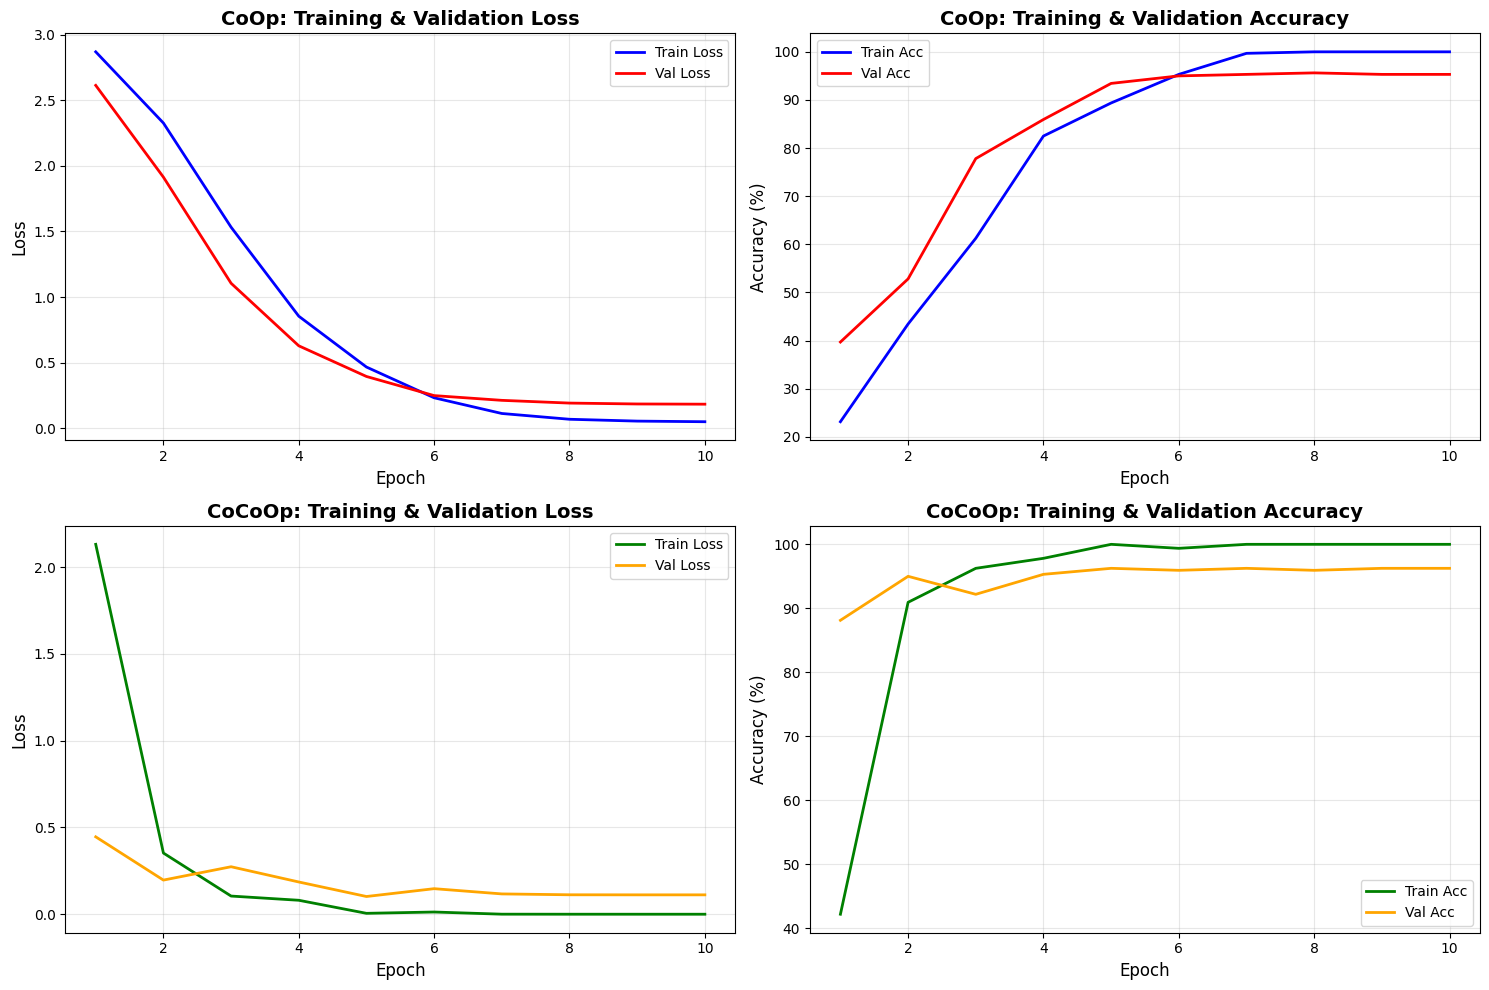

💾 Training curves saved to: /content/drive/MyDrive/CapstoneProject/results/comparison/training_curves.png


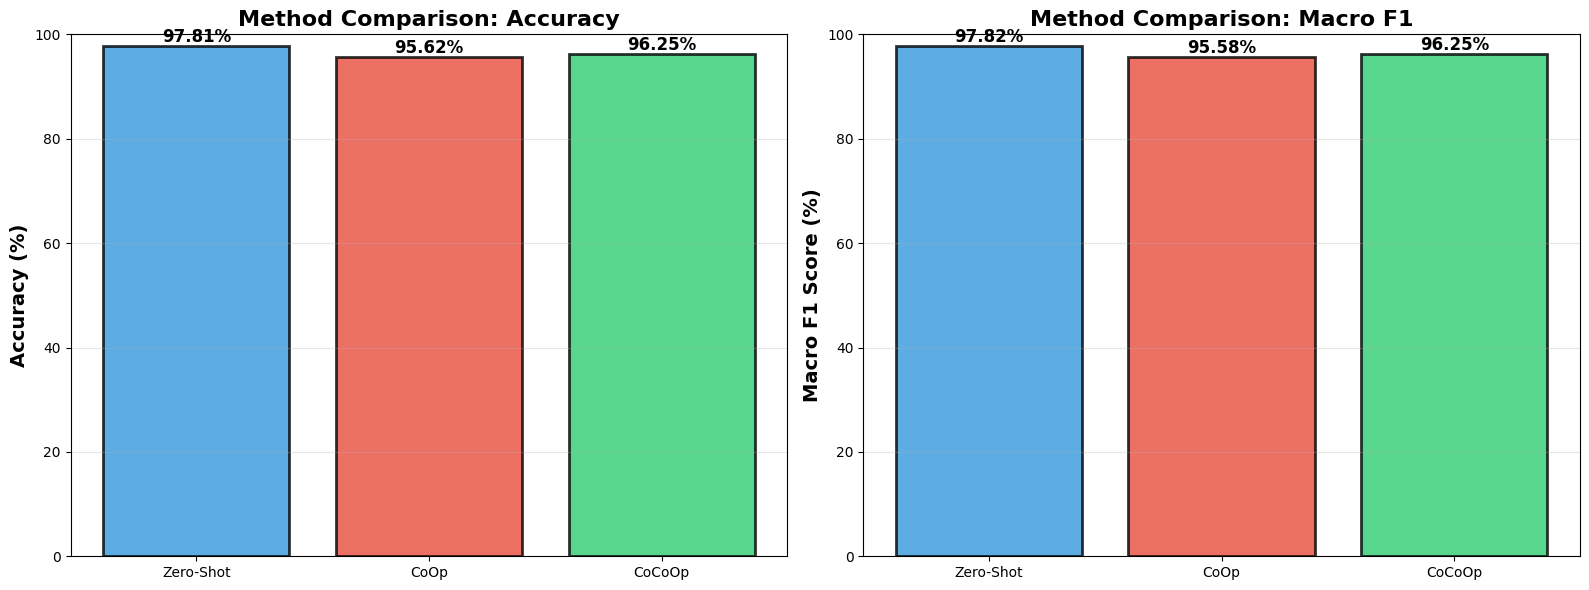

💾 Method comparison saved to: /content/drive/MyDrive/CapstoneProject/results/comparison/method_comparison.png


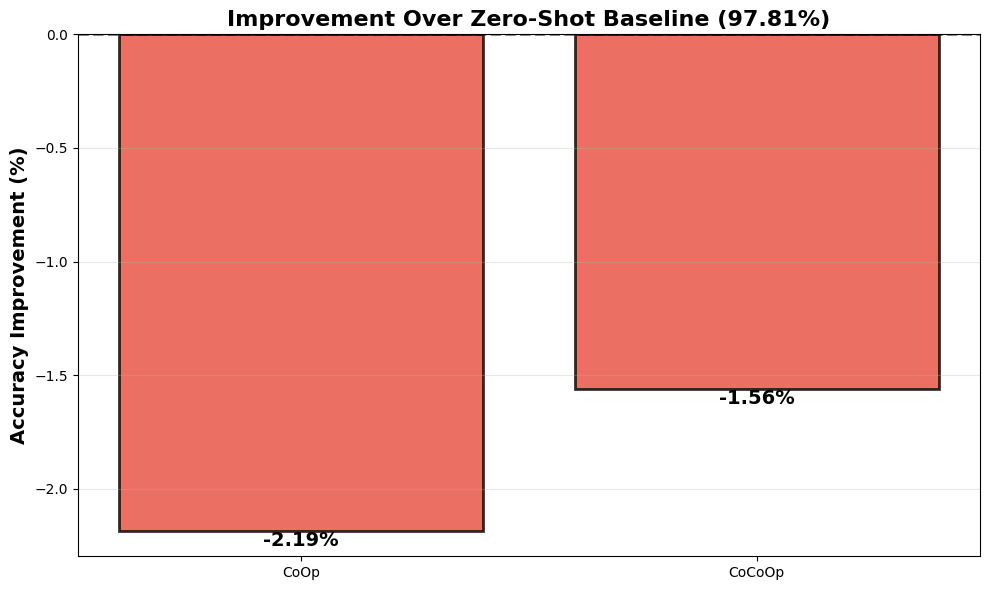

💾 Improvement chart saved to: /content/drive/MyDrive/CapstoneProject/results/comparison/improvement_over_baseline.png

✅ Part 1 visualizations complete!


In [ ]:
# ============================================================================
# CELL 12: Visualization - Part 1
# ============================================================================

def plot_training_curves(coop_history, cocoop_history, save_dir):
    """Plot training and validation curves for CoOp and CoCoOp."""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Extract data
    coop_epochs = [h['epoch'] for h in coop_history]
    coop_train_loss = [h['train_loss'] for h in coop_history]
    coop_val_loss = [h['val_loss'] for h in coop_history]
    coop_train_acc = [h['train_acc'] for h in coop_history]
    coop_val_acc = [h['val_acc'] for h in coop_history]

    cocoop_epochs = [h['epoch'] for h in cocoop_history]
    cocoop_train_loss = [h['train_loss'] for h in cocoop_history]
    cocoop_val_loss = [h['val_loss'] for h in cocoop_history]
    cocoop_train_acc = [h['train_acc'] for h in cocoop_history]
    cocoop_val_acc = [h['val_acc'] for h in cocoop_history]

    # Plot 1: CoOp Loss
    axes[0, 0].plot(coop_epochs, coop_train_loss, 'b-', label='Train Loss', linewidth=2)
    axes[0, 0].plot(coop_epochs, coop_val_loss, 'r-', label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('CoOp: Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: CoOp Accuracy
    axes[0, 1].plot(coop_epochs, coop_train_acc, 'b-', label='Train Acc', linewidth=2)
    axes[0, 1].plot(coop_epochs, coop_val_acc, 'r-', label='Val Acc', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0, 1].set_title('CoOp: Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: CoCoOp Loss
    axes[1, 0].plot(cocoop_epochs, cocoop_train_loss, 'g-', label='Train Loss', linewidth=2)
    axes[1, 0].plot(cocoop_epochs, cocoop_val_loss, 'orange', label='Val Loss', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('Loss', fontsize=12)
    axes[1, 0].set_title('CoCoOp: Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: CoCoOp Accuracy
    axes[1, 1].plot(cocoop_epochs, cocoop_train_acc, 'g-', label='Train Acc', linewidth=2)
    axes[1, 1].plot(cocoop_epochs, cocoop_val_acc, 'orange', label='Val Acc', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1, 1].set_title('CoCoOp: Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Training curves saved to: {save_dir}/training_curves.png")


def plot_method_comparison(comparison_df, save_dir):
    """Plot bar chart comparing all three methods."""

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    methods = comparison_df['Method'].values
    metrics_to_plot = ['Accuracy', 'Macro F1']
    colors = ['#3498db', '#e74c3c', '#2ecc71']  # Blue, Red, Green

    # Plot 1: Accuracy comparison
    ax = axes[0]
    bars = ax.bar(methods, comparison_df['Accuracy'].values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
    ax.set_title('Method Comparison: Accuracy', fontsize=16, fontweight='bold')
    ax.set_ylim([0, 100])
    ax.grid(True, axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Plot 2: Macro F1 comparison
    ax = axes[1]
    bars = ax.bar(methods, comparison_df['Macro F1'].values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax.set_ylabel('Macro F1 Score (%)', fontsize=14, fontweight='bold')
    ax.set_title('Method Comparison: Macro F1', fontsize=16, fontweight='bold')
    ax.set_ylim([0, 100])
    ax.grid(True, axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'method_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Method comparison saved to: {save_dir}/method_comparison.png")


def plot_improvement_over_baseline(comparison_df, save_dir):
    """Plot improvement of CoOp and CoCoOp over Zero-Shot baseline."""

    baseline_acc = comparison_df.loc[comparison_df['Method'] == 'Zero-Shot', 'Accuracy'].values[0]

    improvements = {
        'CoOp': comparison_df.loc[comparison_df['Method'] == 'CoOp', 'Accuracy'].values[0] - baseline_acc,
        'CoCoOp': comparison_df.loc[comparison_df['Method'] == 'CoCoOp', 'Accuracy'].values[0] - baseline_acc
    }

    fig, ax = plt.subplots(figsize=(10, 6))

    methods = list(improvements.keys())
    values = list(improvements.values())
    colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in values]

    bars = ax.bar(methods, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.5)
    ax.set_ylabel('Accuracy Improvement (%)', fontsize=14, fontweight='bold')
    ax.set_title(f'Improvement Over Zero-Shot Baseline ({baseline_acc:.2f}%)',
                 fontsize=16, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:+.2f}%',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'improvement_over_baseline.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Improvement chart saved to: {save_dir}/improvement_over_baseline.png")


# Generate all visualizations
print("\n📊 Generating visualizations...")

plot_training_curves(coop_history, cocoop_history, CHECKPOINT_DIRS['comparison'])
plot_method_comparison(comparison_table, CHECKPOINT_DIRS['comparison'])
plot_improvement_over_baseline(comparison_table, CHECKPOINT_DIRS['comparison'])

print("\n✅ Part 1 visualizations complete!")

Extras


📊 GENERATING CONFUSION MATRICES
✅ Displaying all 20 classes.


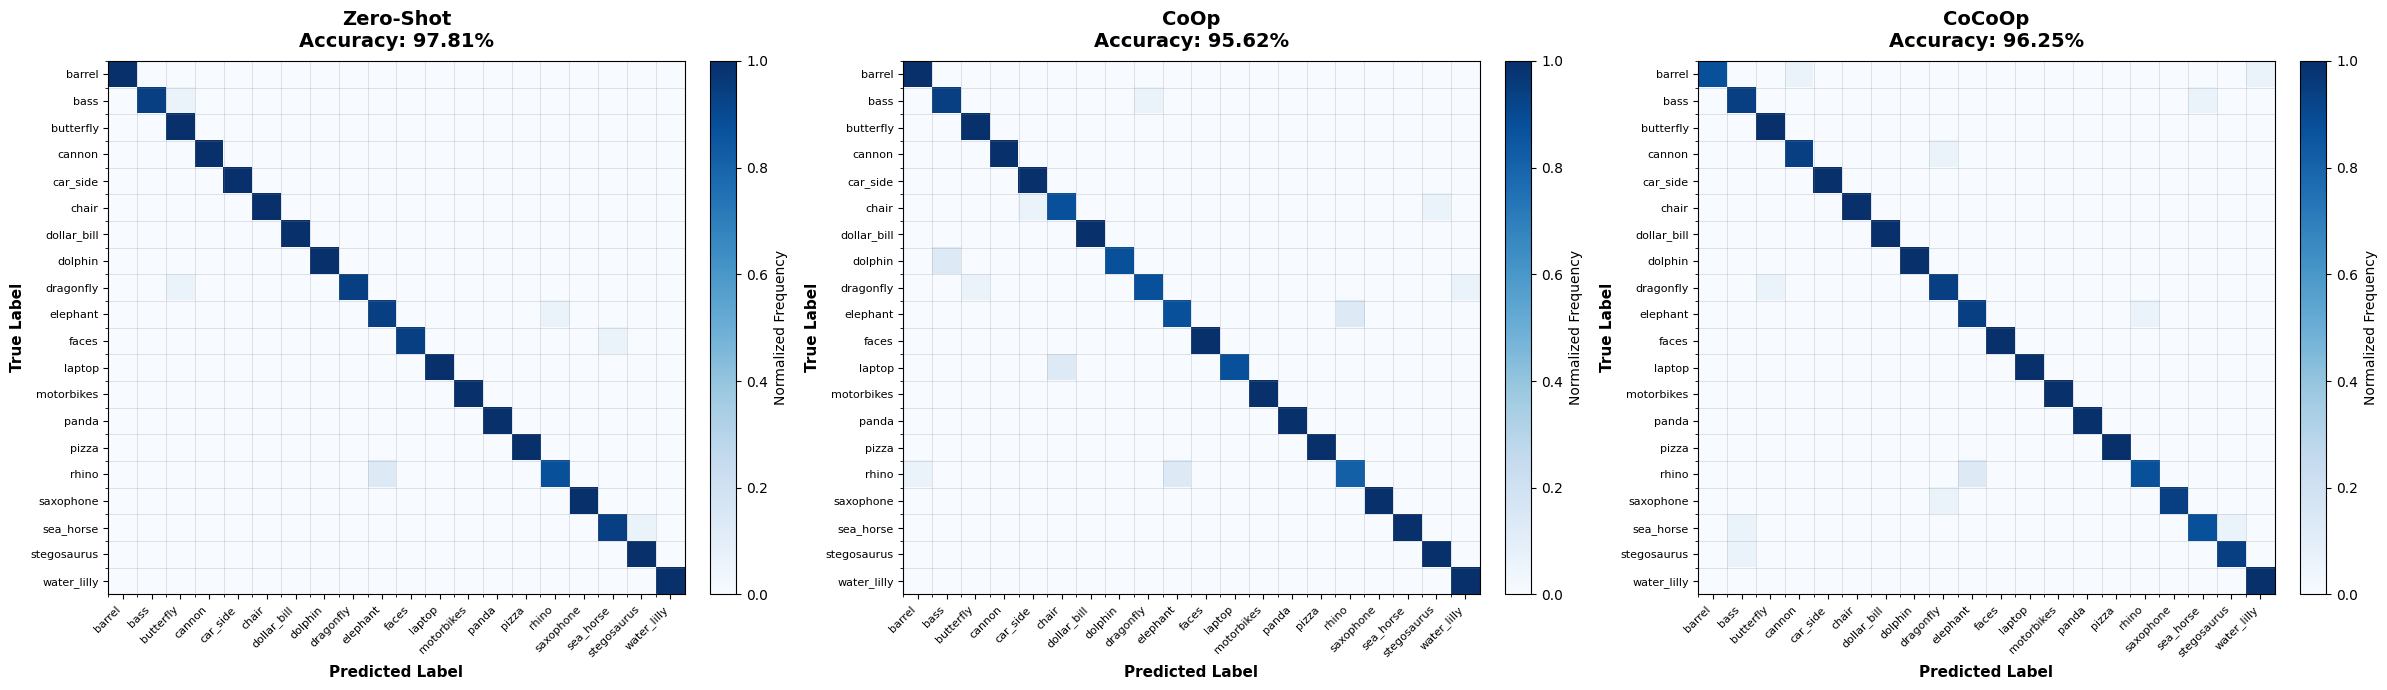

💾 Confusion matrices saved to: /content/drive/MyDrive/CapstoneProject/results/comparison/confusion_matrices.png
   💾 Zero-Shot confusion matrix saved
   💾 CoOp confusion matrix saved
   💾 CoCoOp confusion matrix saved

✅ Confusion matrices complete!


In [ ]:
# ============================================================================
# CELL 13: Confusion Matrices for All Methods
# ============================================================================

def plot_confusion_matrices(all_results, class_names, save_dir, max_classes_display=20):
    """
    Plot confusion matrices for all three methods side by side.
    If there are too many classes, show a subset or aggregate.
    """

    print(f"\n{'='*70}")
    print("📊 GENERATING CONFUSION MATRICES")
    print("="*70)

    n_classes = len(class_names)

    # Determine if we need to aggregate classes
    if n_classes > max_classes_display:
        print(f"⚠️  {n_classes} classes detected. Showing top {max_classes_display} by frequency.")
        display_mode = 'subset'
    else:
        print(f"✅ Displaying all {n_classes} classes.")
        display_mode = 'full'

    fig, axes = plt.subplots(1, 3, figsize=(24, 7))

    methods = ['Zero-Shot', 'CoOp', 'CoCoOp']

    for idx, (method, ax) in enumerate(zip(methods, axes)):
        predictions = all_results[method]['predictions']
        labels = all_results[method]['labels']

        if display_mode == 'subset':
            # Find most frequent classes
            unique_labels, counts = np.unique(labels, return_counts=True)
            top_classes_idx = unique_labels[np.argsort(counts)[-max_classes_display:]]

            # Filter predictions and labels
            mask = np.isin(labels, top_classes_idx)
            filtered_labels = labels[mask]
            filtered_preds = predictions[mask]

            # Remap to sequential indices
            label_map = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted(top_classes_idx))}
            remapped_labels = np.array([label_map[l] for l in filtered_labels])
            remapped_preds = np.array([label_map[p] if p in label_map else -1 for p in filtered_preds])

            # Remove invalid predictions
            valid_mask = remapped_preds != -1
            remapped_labels = remapped_labels[valid_mask]
            remapped_preds = remapped_preds[valid_mask]

            display_class_names = [class_names[i] for i in sorted(top_classes_idx)]
            cm = confusion_matrix(remapped_labels, remapped_preds)
        else:
            cm = confusion_matrix(labels, predictions)
            display_class_names = class_names

        # Normalize confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero

        # Plot
        im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', aspect='auto')
        ax.set_title(f'{method}\nAccuracy: {all_results[method]["metrics"]["accuracy"]:.2f}%',
                    fontsize=14, fontweight='bold', pad=10)

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Normalized Frequency', fontsize=10)

        # Set ticks
        tick_marks = np.arange(len(display_class_names))
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)

        # Truncate long class names
        short_names = [name[:15] + '...' if len(name) > 15 else name
                      for name in display_class_names]

        ax.set_xticklabels(short_names, rotation=45, ha='right', fontsize=8)
        ax.set_yticklabels(short_names, fontsize=8)

        ax.set_ylabel('True Label', fontsize=11, fontweight='bold')
        ax.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')

        # Add grid
        ax.set_xticks(np.arange(len(display_class_names))-.5, minor=True)
        ax.set_yticks(np.arange(len(display_class_names))-.5, minor=True)
        ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Confusion matrices saved to: {save_dir}/confusion_matrices.png")

    # Also create individual high-resolution confusion matrices
    for method in methods:
        fig, ax = plt.subplots(figsize=(12, 10))

        predictions = all_results[method]['predictions']
        labels = all_results[method]['labels']

        if display_mode == 'subset':
            unique_labels, counts = np.unique(labels, return_counts=True)
            top_classes_idx = unique_labels[np.argsort(counts)[-max_classes_display:]]
            mask = np.isin(labels, top_classes_idx)
            filtered_labels = labels[mask]
            filtered_preds = predictions[mask]
            label_map = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted(top_classes_idx))}
            remapped_labels = np.array([label_map[l] for l in filtered_labels])
            remapped_preds = np.array([label_map[p] if p in label_map else -1 for p in filtered_preds])
            valid_mask = remapped_preds != -1
            remapped_labels = remapped_labels[valid_mask]
            remapped_preds = remapped_preds[valid_mask]
            display_class_names = [class_names[i] for i in sorted(top_classes_idx)]
            cm = confusion_matrix(remapped_labels, remapped_preds)
        else:
            cm = confusion_matrix(labels, predictions)
            display_class_names = class_names

        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.nan_to_num(cm_normalized)

        im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', aspect='auto')
        ax.set_title(f'{method} - Confusion Matrix\nAccuracy: {all_results[method]["metrics"]["accuracy"]:.2f}%',
                    fontsize=16, fontweight='bold', pad=15)

        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Normalized Frequency', fontsize=12)

        tick_marks = np.arange(len(display_class_names))
        ax.set_xticks(tick_marks)
        ax.set_yticks(tick_marks)

        short_names = [name[:20] + '...' if len(name) > 20 else name
                      for name in display_class_names]

        ax.set_xticklabels(short_names, rotation=45, ha='right', fontsize=9)
        ax.set_yticklabels(short_names, fontsize=9)

        ax.set_ylabel('True Label', fontsize=13, fontweight='bold')
        ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')

        plt.tight_layout()

        filename = f'confusion_matrix_{method.lower().replace("-", "_")}.png'
        plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')
        plt.close()

        print(f"   💾 {method} confusion matrix saved")


# Generate confusion matrices
plot_confusion_matrices(all_results, class_names, CHECKPOINT_DIRS['comparison'], max_classes_display=20)

print("\n✅ Confusion matrices complete!")


📊 PER-CLASS PERFORMANCE ANALYSIS


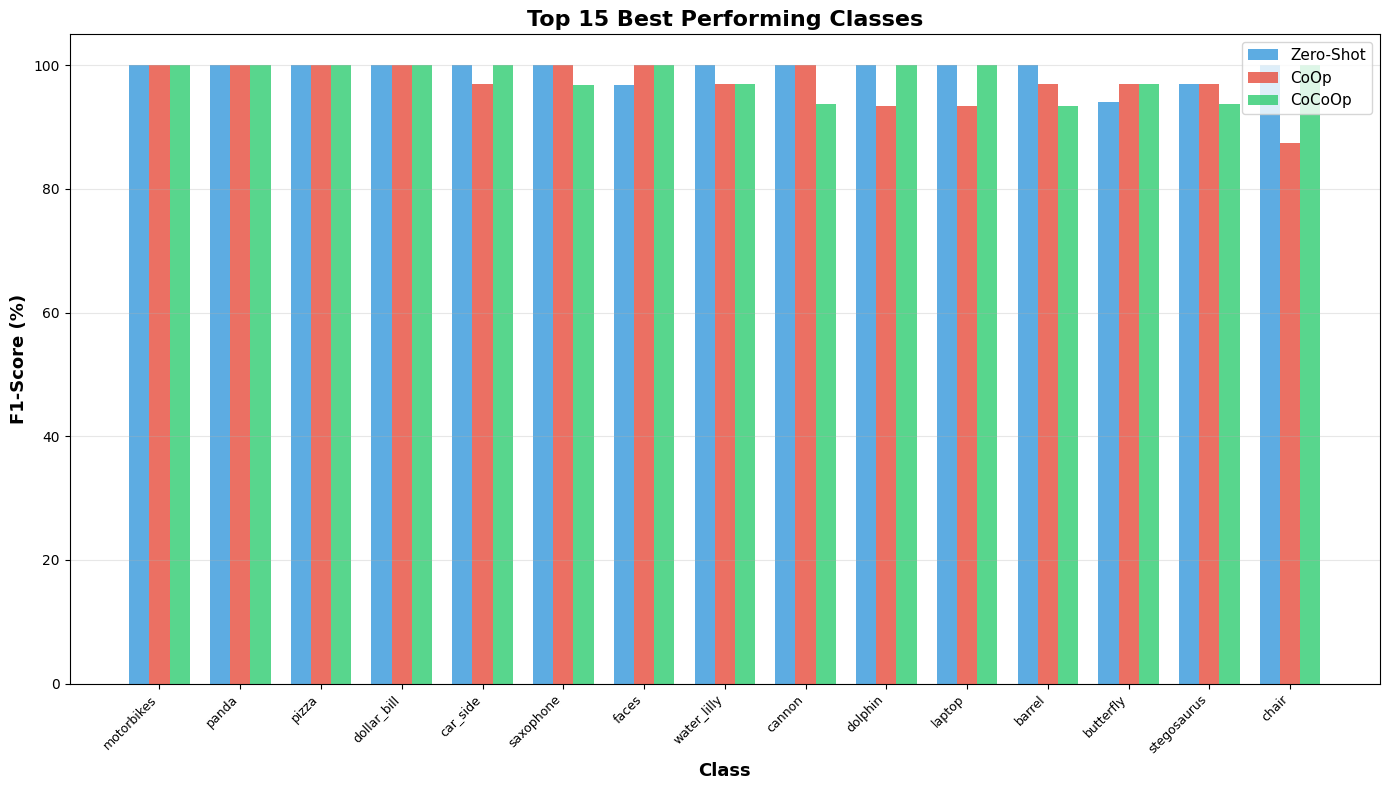

💾 Top classes chart saved


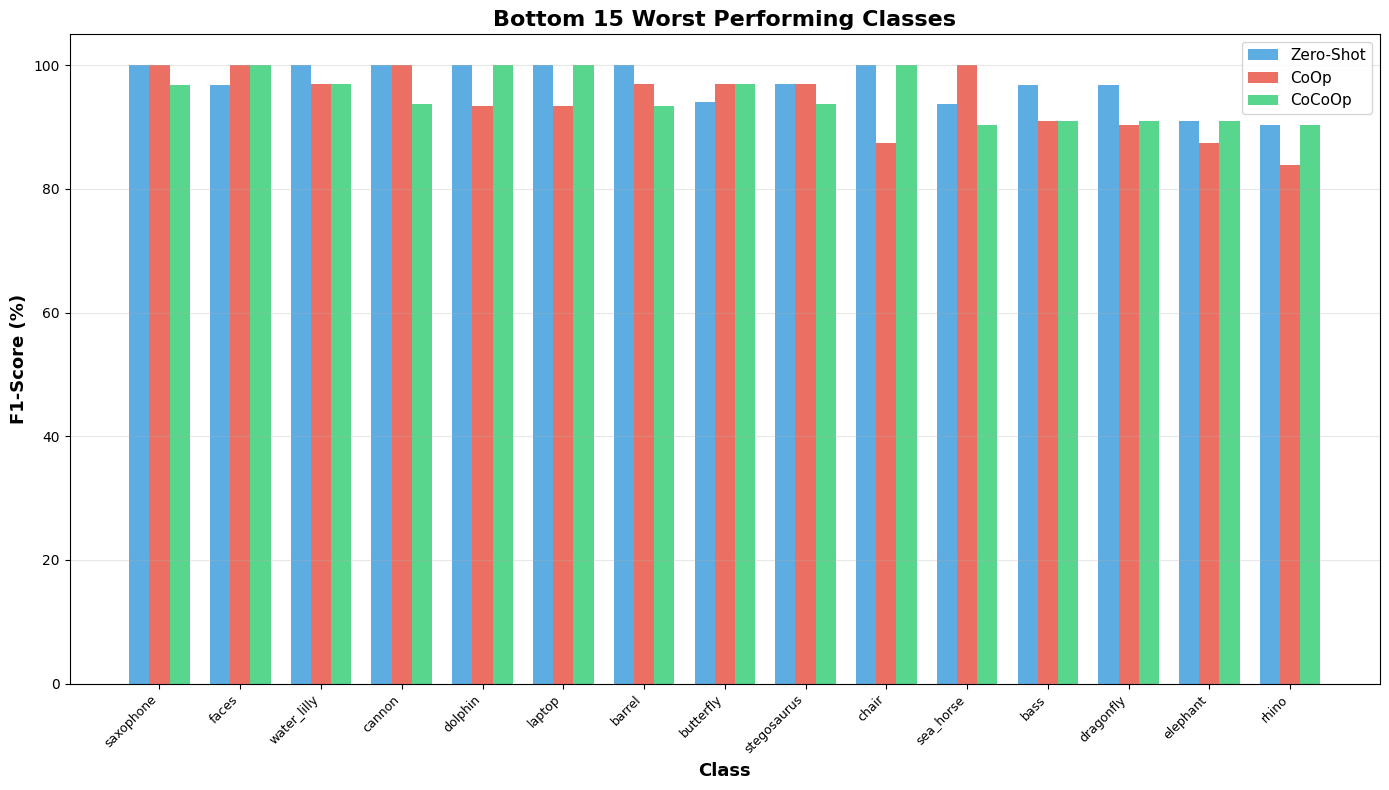

💾 Bottom classes chart saved


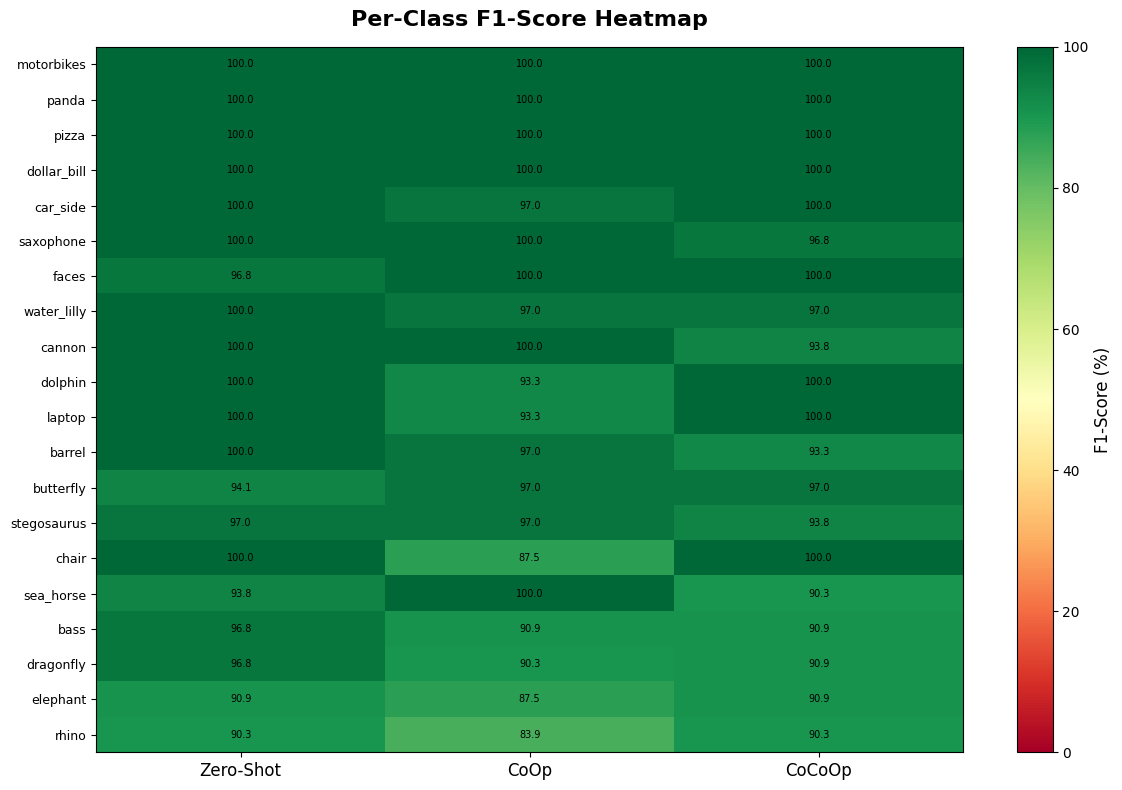

💾 Per-class heatmap saved
💾 Per-class comparison CSV saved

📊 Per-Class Performance Summary:

Zero-Shot:
   Mean F1:   97.82%
   Std F1:    3.12%
   Min F1:    90.32%
   Max F1:    100.00%

CoOp:
   Mean F1:   95.58%
   Std F1:    4.97%
   Min F1:    83.87%
   Max F1:    100.00%

CoCoOp:
   Mean F1:   96.25%
   Std F1:    3.90%
   Min F1:    90.32%
   Max F1:    100.00%

✅ Per-class analysis complete!


In [ ]:
# ============================================================================
# CELL 14: Per-Class Performance Analysis
# ============================================================================

def plot_per_class_comparison(all_results, class_names, save_dir, top_n=15):
    """
    Compare per-class performance across all methods.
    Show top N best and worst performing classes.
    """

    print(f"\n{'='*70}")
    print("📊 PER-CLASS PERFORMANCE ANALYSIS")
    print("="*70)

    # Collect F1 scores for each method
    methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
    per_class_data = []

    for method in methods:
        per_class_df = all_results[method]['metrics']['per_class']
        per_class_data.append(per_class_df)

    # Merge all dataframes
    merged_df = per_class_data[0][['Class', 'F1-Score']].copy()
    merged_df.columns = ['Class', 'Zero-Shot_F1']

    for i, method in enumerate(methods[1:], 1):
        temp_df = per_class_data[i][['Class', 'F1-Score']].copy()
        temp_df.columns = ['Class', f'{method}_F1']
        merged_df = merged_df.merge(temp_df, on='Class', how='outer')

    # Fill NaN with 0
    merged_df = merged_df.fillna(0)

    # Calculate average F1 across methods
    merged_df['Avg_F1'] = merged_df[['Zero-Shot_F1', 'CoOp_F1', 'CoCoOp_F1']].mean(axis=1)

    # Sort by average F1
    merged_df = merged_df.sort_values('Avg_F1', ascending=False)

    # ========================================================================
    # Plot 1: Top N Best Performing Classes
    # ========================================================================
    top_classes = merged_df.head(top_n)

    fig, ax = plt.subplots(figsize=(14, 8))

    x = np.arange(len(top_classes))
    width = 0.25

    bars1 = ax.bar(x - width, top_classes['Zero-Shot_F1'], width,
                   label='Zero-Shot', color='#3498db', alpha=0.8)
    bars2 = ax.bar(x, top_classes['CoOp_F1'], width,
                   label='CoOp', color='#e74c3c', alpha=0.8)
    bars3 = ax.bar(x + width, top_classes['CoCoOp_F1'], width,
                   label='CoCoOp', color='#2ecc71', alpha=0.8)

    ax.set_xlabel('Class', fontsize=13, fontweight='bold')
    ax.set_ylabel('F1-Score (%)', fontsize=13, fontweight='bold')
    ax.set_title(f'Top {top_n} Best Performing Classes', fontsize=16, fontweight='bold')
    ax.set_xticks(x)

    # Truncate class names for display
    short_names = [name[:20] + '...' if len(name) > 20 else name
                  for name in top_classes['Class']]
    ax.set_xticklabels(short_names, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=11)
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim([0, 105])

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'top_classes_performance.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Top classes chart saved")

    # ========================================================================
    # Plot 2: Bottom N Worst Performing Classes
    # ========================================================================
    bottom_classes = merged_df.tail(top_n)

    fig, ax = plt.subplots(figsize=(14, 8))

    x = np.arange(len(bottom_classes))

    bars1 = ax.bar(x - width, bottom_classes['Zero-Shot_F1'], width,
                   label='Zero-Shot', color='#3498db', alpha=0.8)
    bars2 = ax.bar(x, bottom_classes['CoOp_F1'], width,
                   label='CoOp', color='#e74c3c', alpha=0.8)
    bars3 = ax.bar(x + width, bottom_classes['CoCoOp_F1'], width,
                   label='CoCoOp', color='#2ecc71', alpha=0.8)

    ax.set_xlabel('Class', fontsize=13, fontweight='bold')
    ax.set_ylabel('F1-Score (%)', fontsize=13, fontweight='bold')
    ax.set_title(f'Bottom {top_n} Worst Performing Classes', fontsize=16, fontweight='bold')
    ax.set_xticks(x)

    short_names = [name[:20] + '...' if len(name) > 20 else name
                  for name in bottom_classes['Class']]
    ax.set_xticklabels(short_names, rotation=45, ha='right', fontsize=9)
    ax.legend(fontsize=11)
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim([0, 105])

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'bottom_classes_performance.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Bottom classes chart saved")

    # ========================================================================
    # Plot 3: Heatmap of F1 scores
    # ========================================================================
    if len(class_names) <= 30:  # Only show heatmap if manageable number of classes
        fig, ax = plt.subplots(figsize=(12, max(8, len(class_names) * 0.3)))

        # Prepare data for heatmap
        heatmap_data = merged_df[['Zero-Shot_F1', 'CoOp_F1', 'CoCoOp_F1']].values

        im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

        ax.set_xticks(np.arange(3))
        ax.set_yticks(np.arange(len(merged_df)))
        ax.set_xticklabels(['Zero-Shot', 'CoOp', 'CoCoOp'], fontsize=12)

        short_names = [name[:25] + '...' if len(name) > 25 else name
                      for name in merged_df['Class']]
        ax.set_yticklabels(short_names, fontsize=9)

        ax.set_title('Per-Class F1-Score Heatmap', fontsize=16, fontweight='bold', pad=15)

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('F1-Score (%)', fontsize=12)

        # Add text annotations
        for i in range(len(merged_df)):
            for j in range(3):
                text = ax.text(j, i, f'{heatmap_data[i, j]:.1f}',
                             ha="center", va="center", color="black", fontsize=7)

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'per_class_heatmap.png'), dpi=300, bbox_inches='tight')
        plt.show()

        print(f"💾 Per-class heatmap saved")

    # ========================================================================
    # Save detailed per-class comparison to CSV
    # ========================================================================
    merged_df.to_csv(os.path.join(save_dir, 'per_class_comparison.csv'), index=False)
    print(f"💾 Per-class comparison CSV saved")

    # Print summary statistics
    print(f"\n{'='*70}")
    print("📊 Per-Class Performance Summary:")
    print("="*70)

    for method in methods:
        f1_scores = merged_df[f'{method}_F1'].values
        print(f"\n{method}:")
        print(f"   Mean F1:   {np.mean(f1_scores):.2f}%")
        print(f"   Std F1:    {np.std(f1_scores):.2f}%")
        print(f"   Min F1:    {np.min(f1_scores):.2f}%")
        print(f"   Max F1:    {np.max(f1_scores):.2f}%")

    return merged_df


# Generate per-class analysis
per_class_comparison = plot_per_class_comparison(
    all_results, class_names, CHECKPOINT_DIRS['comparison'], top_n=15
)

print("\n✅ Per-class analysis complete!")


📸 VISUALIZING SAMPLE PREDICTIONS


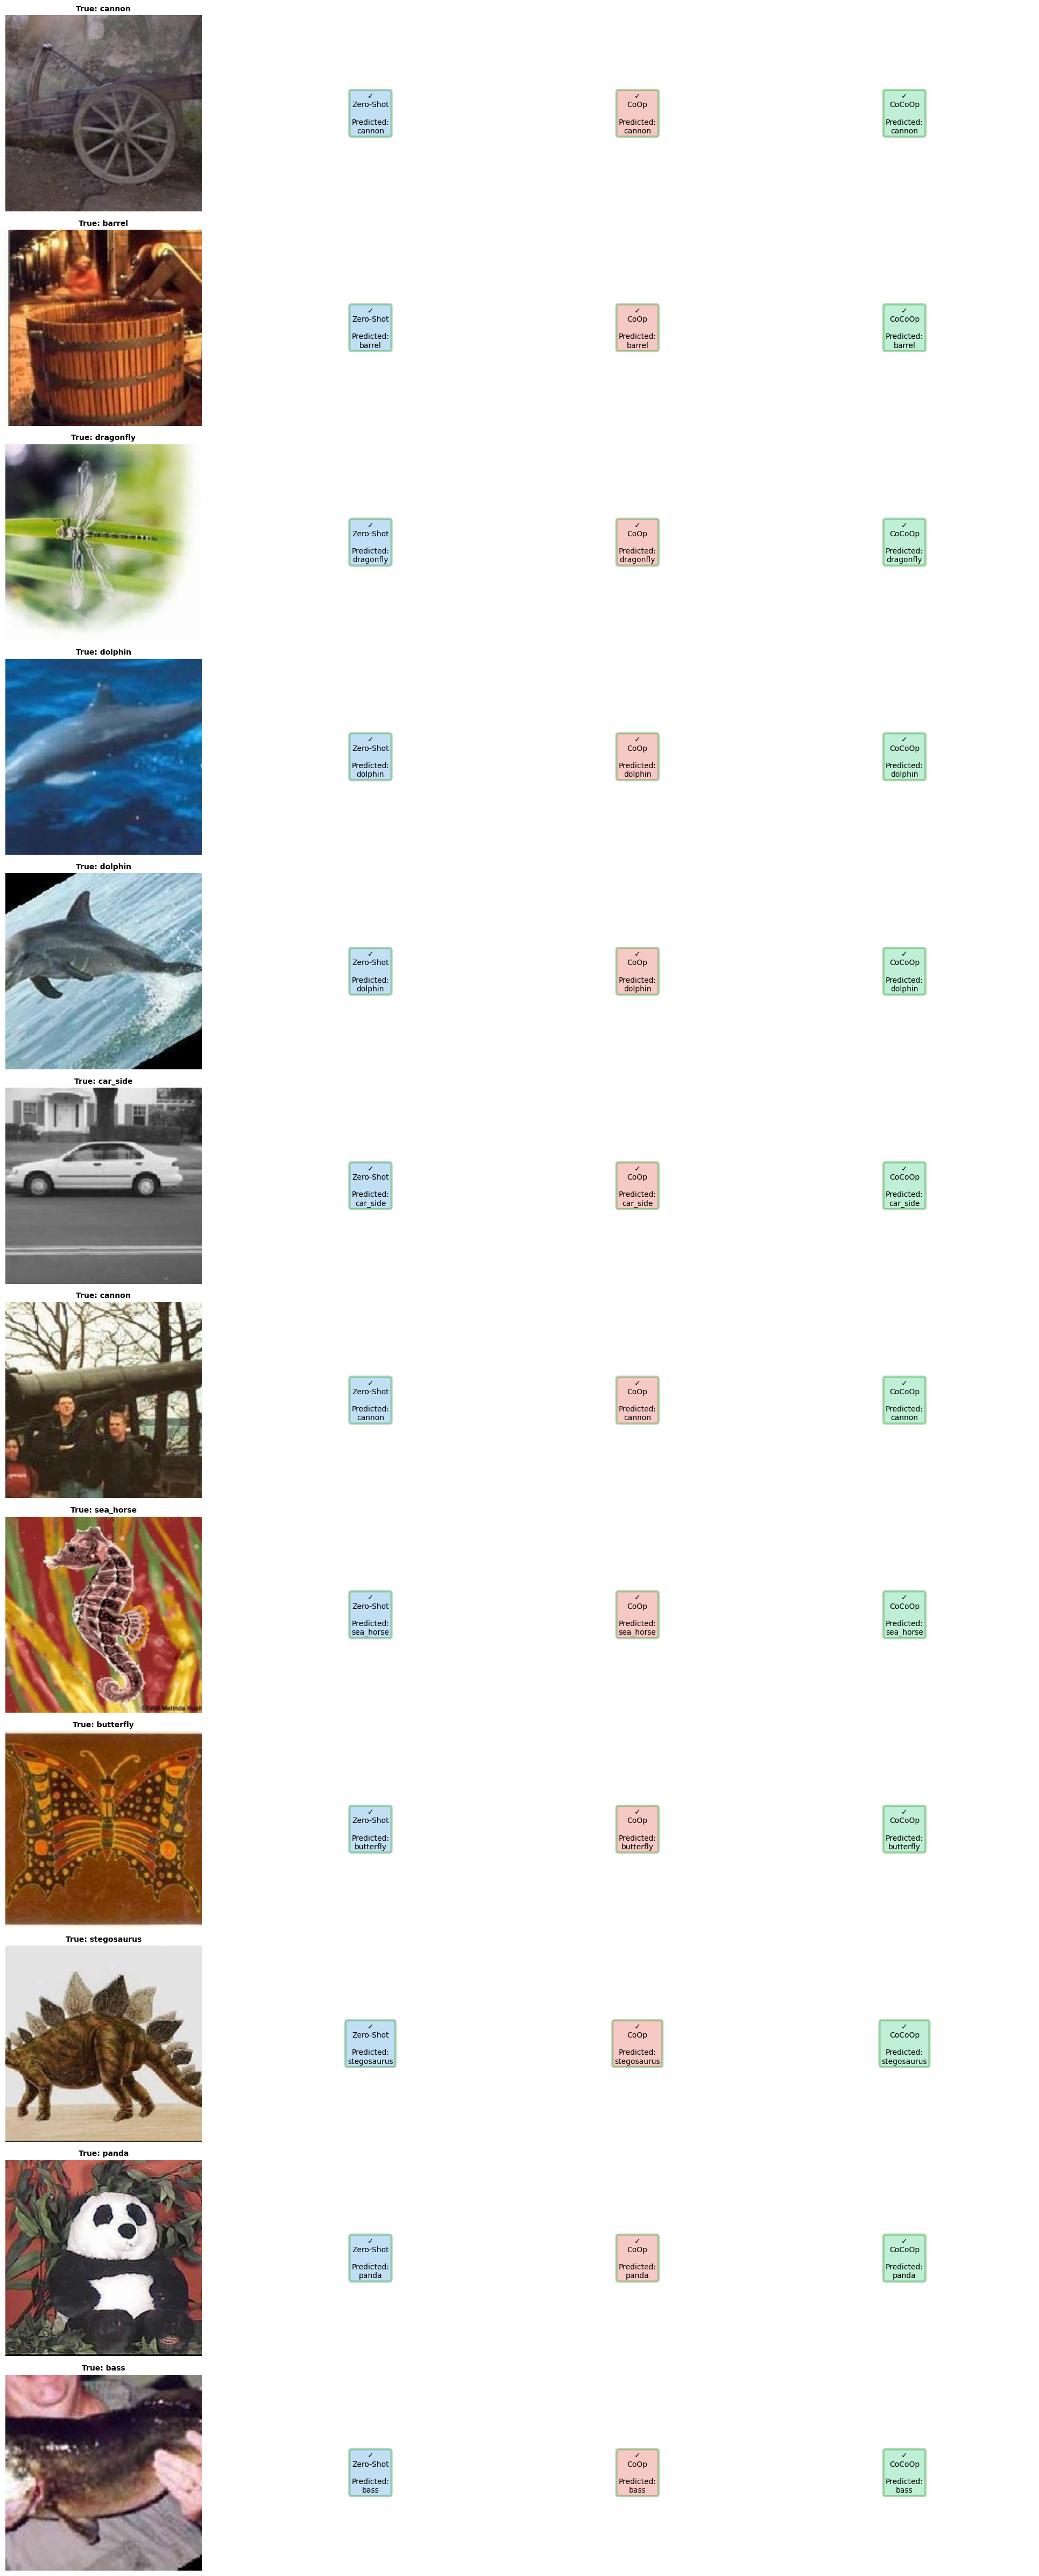

💾 Sample predictions saved to: /content/drive/MyDrive/CapstoneProject/results/comparison/sample_predictions.png

🔍 Finding interesting misclassifications...

📊 Interesting Cases:
   Samples where CoOp fixes Zero-Shot errors: 2
   Samples where CoCoOp fixes Zero-Shot errors: 2
   Samples where CoOp breaks Zero-Shot correct: 9
   Samples where CoCoOp breaks Zero-Shot correct: 7


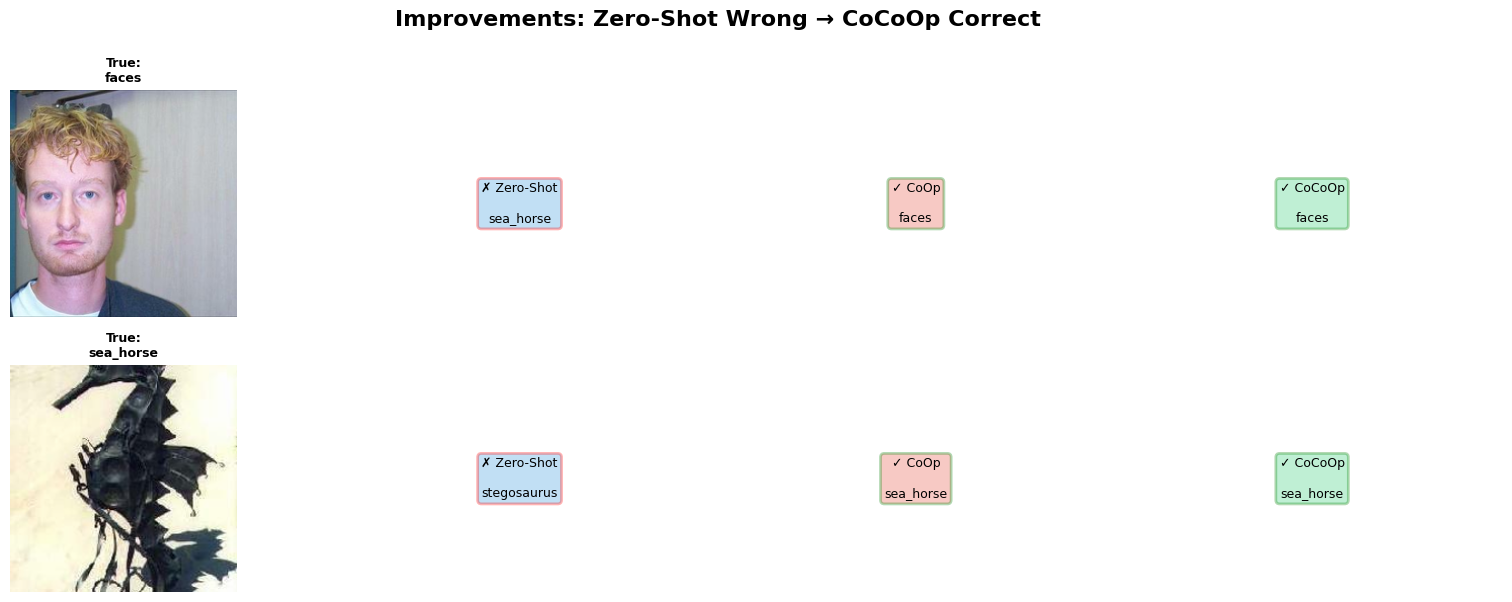

💾 Improvements visualization saved

✅ Sample predictions visualization complete!


In [ ]:
# ============================================================================
# CELL 15: Sample Predictions Visualization
# ============================================================================

def visualize_sample_predictions(val_dataset, all_results, class_names,
                                save_dir, num_samples=12, seed=42):
    """
    Visualize random sample predictions from all three methods.
    Show correct and incorrect predictions.
    """

    print(f"\n{'='*70}")
    print("📸 VISUALIZING SAMPLE PREDICTIONS")
    print("="*70)

    set_seed(seed)

    # Get random samples
    total_samples = len(val_dataset)
    sample_indices = random.sample(range(total_samples), min(num_samples, total_samples))

    # Create figure
    rows = num_samples
    cols = 4  # Image + 3 methods
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))

    if rows == 1:
        axes = axes.reshape(1, -1)

    methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
    method_colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

    for row_idx, sample_idx in enumerate(sample_indices):
        # Get image and true label
        image, true_label = val_dataset[sample_idx]
        true_class = class_names[true_label]

        # Denormalize image for display
        mean = np.array([0.48145466, 0.4578275, 0.40821073])
        std = np.array([0.26862954, 0.26130258, 0.27577711])
        img_display = image.cpu().permute(1, 2, 0).numpy()
        img_display = img_display * std + mean
        img_display = np.clip(img_display, 0, 1)

        # Plot image
        ax = axes[row_idx, 0]
        ax.imshow(img_display)
        ax.set_title(f'True: {true_class[:25]}', fontsize=10, fontweight='bold', color='black')
        ax.axis('off')

        # Plot predictions for each method
        for col_idx, method in enumerate(methods, 1):
            ax = axes[row_idx, col_idx]

            # Get prediction for this sample
            pred_label = all_results[method]['predictions'][sample_idx]
            pred_class = class_names[pred_label]

            # Determine if correct
            is_correct = (pred_label == true_label)
            color = 'green' if is_correct else 'red'
            marker = '✓' if is_correct else '✗'

            # Display prediction
            ax.text(0.5, 0.5, f'{marker}\n{method}\n\nPredicted:\n{pred_class[:25]}',
                   ha='center', va='center', fontsize=10,
                   bbox=dict(boxstyle='round', facecolor=method_colors[method],
                           alpha=0.3, edgecolor=color, linewidth=3),
                   transform=ax.transAxes, wrap=True)
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'sample_predictions.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Sample predictions saved to: {save_dir}/sample_predictions.png")

    # ========================================================================
    # Create a focused view: Show only misclassified samples
    # ========================================================================
    print("\n🔍 Finding interesting misclassifications...")

    # Find samples where methods disagree
    zs_preds = all_results['Zero-Shot']['predictions']
    coop_preds = all_results['CoOp']['predictions']
    cocoop_preds = all_results['CoCoOp']['predictions']
    labels = all_results['Zero-Shot']['labels']

    # Find samples where CoOp or CoCoOp correct but Zero-Shot wrong
    improved_by_coop = np.where((zs_preds != labels) & (coop_preds == labels))[0]
    improved_by_cocoop = np.where((zs_preds != labels) & (cocoop_preds == labels))[0]

    # Find samples where Zero-Shot correct but others wrong
    degraded_by_coop = np.where((zs_preds == labels) & (coop_preds != labels))[0]
    degraded_by_cocoop = np.where((zs_preds == labels) & (cocoop_preds != labels))[0]

    print(f"\n📊 Interesting Cases:")
    print(f"   Samples where CoOp fixes Zero-Shot errors: {len(improved_by_coop)}")
    print(f"   Samples where CoCoOp fixes Zero-Shot errors: {len(improved_by_cocoop)}")
    print(f"   Samples where CoOp breaks Zero-Shot correct: {len(degraded_by_coop)}")
    print(f"   Samples where CoCoOp breaks Zero-Shot correct: {len(degraded_by_cocoop)}")

    # Visualize improvements
    if len(improved_by_cocoop) > 0:
        num_show = min(6, len(improved_by_cocoop))
        sample_indices = random.sample(list(improved_by_cocoop), num_show)

        fig, axes = plt.subplots(num_show, 4, figsize=(16, num_show * 3))
        if num_show == 1:
            axes = axes.reshape(1, -1)

        fig.suptitle('Improvements: Zero-Shot Wrong → CoCoOp Correct',
                    fontsize=16, fontweight='bold', y=0.995)

        for row_idx, sample_idx in enumerate(sample_indices):
            image, true_label = val_dataset[sample_idx]
            true_class = class_names[true_label]

            mean = np.array([0.48145466, 0.4578275, 0.40821073])
            std = np.array([0.26862954, 0.26130258, 0.27577711])
            img_display = image.cpu().permute(1, 2, 0).numpy()
            img_display = img_display * std + mean
            img_display = np.clip(img_display, 0, 1)

            # Image
            axes[row_idx, 0].imshow(img_display)
            axes[row_idx, 0].set_title(f'True:\n{true_class[:20]}', fontsize=9, fontweight='bold')
            axes[row_idx, 0].axis('off')

            # Methods
            for col_idx, method in enumerate(methods, 1):
                pred_label = all_results[method]['predictions'][sample_idx]
                pred_class = class_names[pred_label]
                is_correct = (pred_label == true_label)
                color = 'green' if is_correct else 'red'
                marker = '✓' if is_correct else '✗'

                axes[row_idx, col_idx].text(
                    0.5, 0.5, f'{marker} {method}\n\n{pred_class[:20]}',
                    ha='center', va='center', fontsize=9,
                    bbox=dict(boxstyle='round', facecolor=method_colors[method],
                            alpha=0.3, edgecolor=color, linewidth=2),
                    transform=axes[row_idx, col_idx].transAxes
                )
                axes[row_idx, col_idx].axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'improvements_visualization.png'),
                   dpi=300, bbox_inches='tight')
        plt.show()

        print(f"💾 Improvements visualization saved")


# Generate sample predictions visualization
visualize_sample_predictions(
    val_dataset, all_results, class_names,
    CHECKPOINT_DIRS['comparison'], num_samples=12, seed=42
)

print("\n✅ Sample predictions visualization complete!")


🎯 CLASS DIFFICULTY ANALYSIS

🚀 TOP 10 Classes with Highest CoCoOp Improvement:
   faces                                   : ZS= 93.8% → CoCoOp=100.0% (+  6.2%)
   bass                                    : ZS= 93.8% → CoCoOp= 93.8% (+  0.0%)
   butterfly                               : ZS=100.0% → CoCoOp=100.0% (+  0.0%)
   car_side                                : ZS=100.0% → CoCoOp=100.0% (+  0.0%)
   chair                                   : ZS=100.0% → CoCoOp=100.0% (+  0.0%)
   dollar_bill                             : ZS=100.0% → CoCoOp=100.0% (+  0.0%)
   dolphin                                 : ZS=100.0% → CoCoOp=100.0% (+  0.0%)
   dragonfly                               : ZS= 93.8% → CoCoOp= 93.8% (+  0.0%)
   elephant                                : ZS= 93.8% → CoCoOp= 93.8% (+  0.0%)
   laptop                                  : ZS=100.0% → CoCoOp=100.0% (+  0.0%)

😰 TOP 10 Most Difficult Classes (Low Avg Accuracy):
   rhino                                   : Avg= 85.4% (

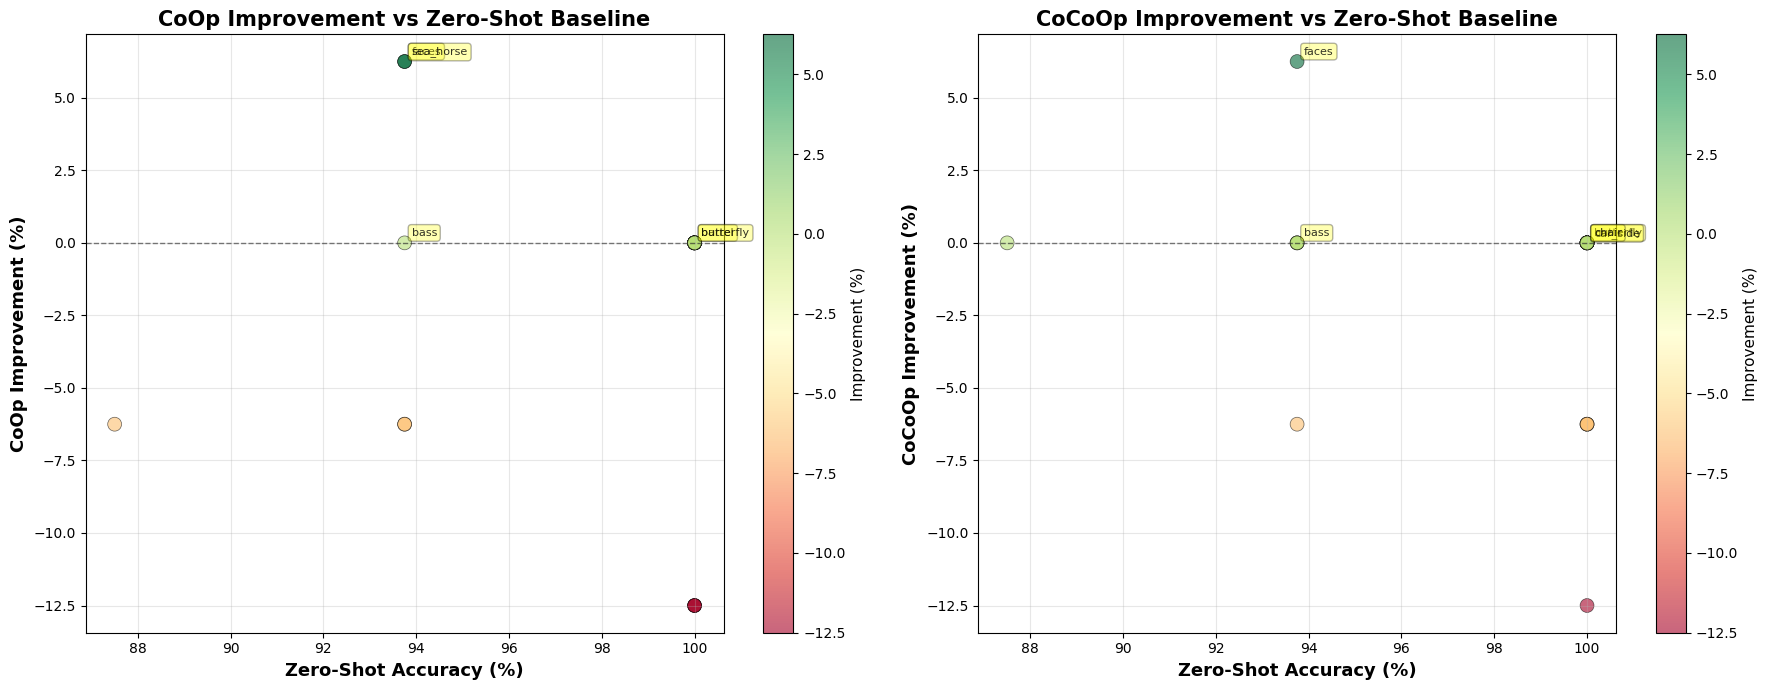


💾 Improvement scatter plot saved


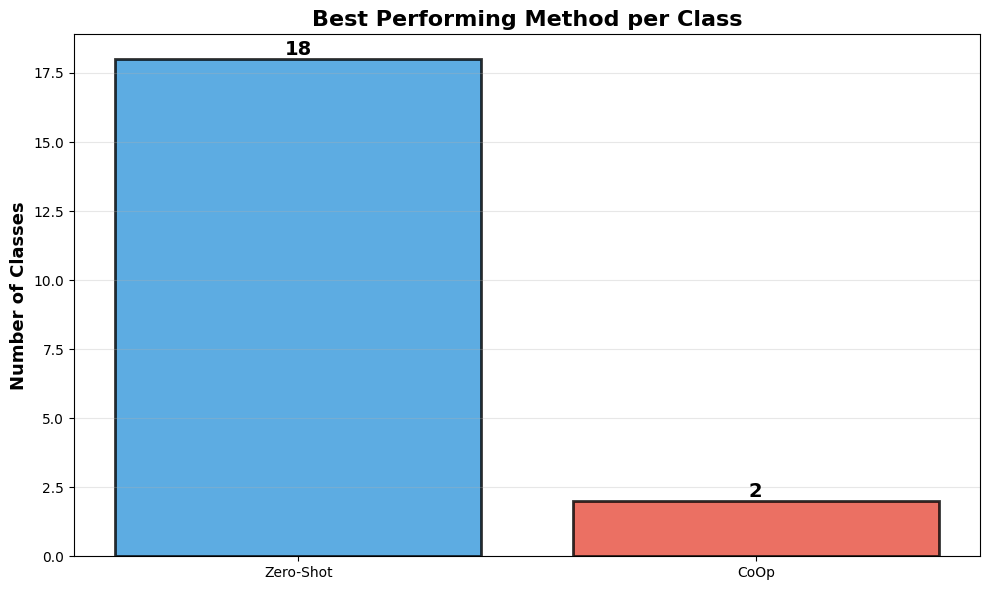

💾 Best method distribution saved


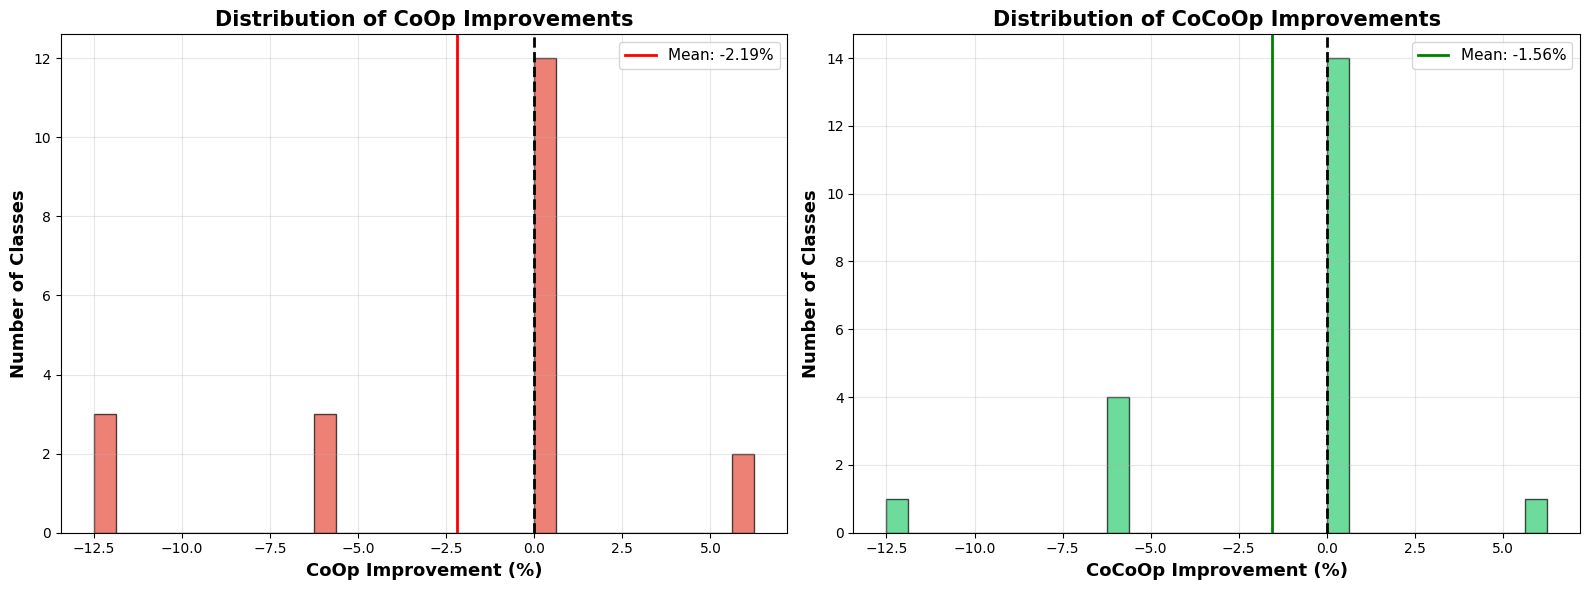

💾 Improvement distribution saved
💾 Class difficulty analysis CSV saved

📊 IMPROVEMENT STATISTICS:

CoOp:
   Classes improved: 2/20 (10.0%)
   Classes degraded: 6/20 (30.0%)
   Mean improvement: -2.19%
   Max improvement: 6.25%
   Max degradation: -12.50%

CoCoOp:
   Classes improved: 1/20 (5.0%)
   Classes degraded: 5/20 (25.0%)
   Mean improvement: -1.56%
   Max improvement: 6.25%
   Max degradation: -12.50%

✅ Class difficulty analysis complete!


In [ ]:
# ============================================================================
# CELL 16: Top/Bottom Performing Classes Detailed Analysis
# ============================================================================

def analyze_class_difficulty_across_methods(all_results, class_names, save_dir):
    """
    Analyze which classes are consistently easy/hard across all methods.
    Identify classes where prompt learning helps most.
    """

    print(f"\n{'='*70}")
    print("🎯 CLASS DIFFICULTY ANALYSIS")
    print("="*70)

    methods = ['Zero-Shot', 'CoOp', 'CoCoOp']

    # Collect per-class accuracies
    class_accuracies = {}

    for method in methods:
        predictions = all_results[method]['predictions']
        labels = all_results[method]['labels']

        class_correct = defaultdict(int)
        class_total = defaultdict(int)

        for pred, label in zip(predictions, labels):
            class_total[label] += 1
            if pred == label:
                class_correct[label] += 1

        class_acc = {}
        for class_idx in range(len(class_names)):
            if class_total[class_idx] > 0:
                class_acc[class_idx] = 100 * class_correct[class_idx] / class_total[class_idx]
            else:
                class_acc[class_idx] = 0

        class_accuracies[method] = class_acc

    # Build comparison dataframe
    comparison_data = []
    for class_idx in range(len(class_names)):
        row = {
            'Class': class_names[class_idx],
            'Zero-Shot': class_accuracies['Zero-Shot'][class_idx],
            'CoOp': class_accuracies['CoOp'][class_idx],
            'CoCoOp': class_accuracies['CoCoOp'][class_idx]
        }
        row['Avg'] = np.mean([row['Zero-Shot'], row['CoOp'], row['CoCoOp']])
        row['CoOp_Gain'] = row['CoOp'] - row['Zero-Shot']
        row['CoCoOp_Gain'] = row['CoCoOp'] - row['Zero-Shot']
        row['Best_Method'] = max([('Zero-Shot', row['Zero-Shot']),
                                  ('CoOp', row['CoOp']),
                                  ('CoCoOp', row['CoCoOp'])],
                                 key=lambda x: x[1])[0]
        comparison_data.append(row)

    df = pd.DataFrame(comparison_data)

    # ========================================================================
    # Analysis 1: Classes with highest CoCoOp improvement
    # ========================================================================
    print("\n🚀 TOP 10 Classes with Highest CoCoOp Improvement:")
    print("="*70)

    top_improved = df.nlargest(10, 'CoCoOp_Gain')
    for idx, row in top_improved.iterrows():
        print(f"   {row['Class'][:40]:40s}: "
              f"ZS={row['Zero-Shot']:5.1f}% → CoCoOp={row['CoCoOp']:5.1f}% "
              f"(+{row['CoCoOp_Gain']:5.1f}%)")

    # ========================================================================
    # Analysis 2: Consistently difficult classes
    # ========================================================================
    print(f"\n😰 TOP 10 Most Difficult Classes (Low Avg Accuracy):")
    print("="*70)

    hardest = df.nsmallest(10, 'Avg')
    for idx, row in hardest.iterrows():
        print(f"   {row['Class'][:40]:40s}: "
              f"Avg={row['Avg']:5.1f}% "
              f"(ZS={row['Zero-Shot']:5.1f}%, CoOp={row['CoOp']:5.1f}%, CoCoOp={row['CoCoOp']:5.1f}%)")

    # ========================================================================
    # Analysis 3: Consistently easy classes
    # ========================================================================
    print(f"\n🎉 TOP 10 Easiest Classes (High Avg Accuracy):")
    print("="*70)

    easiest = df.nlargest(10, 'Avg')
    for idx, row in easiest.iterrows():
        print(f"   {row['Class'][:40]:40s}: "
              f"Avg={row['Avg']:5.1f}% "
              f"(ZS={row['Zero-Shot']:5.1f}%, CoOp={row['CoOp']:5.1f}%, CoCoOp={row['CoCoOp']:5.1f}%)")

    # ========================================================================
    # Visualization 1: Scatter plot of improvements
    # ========================================================================
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # Plot CoOp improvement
    ax = axes[0]
    scatter = ax.scatter(df['Zero-Shot'], df['CoOp_Gain'],
                        c=df['CoOp_Gain'], cmap='RdYlGn',
                        s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Zero-Shot Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_ylabel('CoOp Improvement (%)', fontsize=13, fontweight='bold')
    ax.set_title('CoOp Improvement vs Zero-Shot Baseline', fontsize=15, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Improvement (%)', fontsize=11)

    # Annotate top improvers
    top_5_improved = df.nlargest(5, 'CoOp_Gain')
    for idx, row in top_5_improved.iterrows():
        ax.annotate(row['Class'][:15],
                   xy=(row['Zero-Shot'], row['CoOp_Gain']),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=8, alpha=0.8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

    # Plot CoCoOp improvement
    ax = axes[1]
    scatter = ax.scatter(df['Zero-Shot'], df['CoCoOp_Gain'],
                        c=df['CoCoOp_Gain'], cmap='RdYlGn',
                        s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xlabel('Zero-Shot Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_ylabel('CoCoOp Improvement (%)', fontsize=13, fontweight='bold')
    ax.set_title('CoCoOp Improvement vs Zero-Shot Baseline', fontsize=15, fontweight='bold')
    ax.grid(True, alpha=0.3)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Improvement (%)', fontsize=11)

    # Annotate top improvers
    top_5_improved = df.nlargest(5, 'CoCoOp_Gain')
    for idx, row in top_5_improved.iterrows():
        ax.annotate(row['Class'][:15],
                   xy=(row['Zero-Shot'], row['CoCoOp_Gain']),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=8, alpha=0.8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'improvement_scatter.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n💾 Improvement scatter plot saved")

    # ========================================================================
    # Visualization 2: Method preference by class
    # ========================================================================
    method_counts = df['Best_Method'].value_counts()

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(method_counts.index, method_counts.values,
                  color=['#3498db', '#e74c3c', '#2ecc71'],
                  alpha=0.8, edgecolor='black', linewidth=2)

    ax.set_ylabel('Number of Classes', fontsize=13, fontweight='bold')
    ax.set_title('Best Performing Method per Class', fontsize=16, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'best_method_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Best method distribution saved")

    # ========================================================================
    # Visualization 3: Improvement distribution
    # ========================================================================
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # CoOp improvement distribution
    ax = axes[0]
    ax.hist(df['CoOp_Gain'], bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax.axvline(x=df['CoOp_Gain'].mean(), color='red', linestyle='-', linewidth=2,
              label=f'Mean: {df["CoOp_Gain"].mean():.2f}%')
    ax.set_xlabel('CoOp Improvement (%)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Number of Classes', fontsize=13, fontweight='bold')
    ax.set_title('Distribution of CoOp Improvements', fontsize=15, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # CoCoOp improvement distribution
    ax = axes[1]
    ax.hist(df['CoCoOp_Gain'], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax.axvline(x=df['CoCoOp_Gain'].mean(), color='green', linestyle='-', linewidth=2,
              label=f'Mean: {df["CoCoOp_Gain"].mean():.2f}%')
    ax.set_xlabel('CoCoOp Improvement (%)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Number of Classes', fontsize=13, fontweight='bold')
    ax.set_title('Distribution of CoCoOp Improvements', fontsize=15, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'improvement_distribution.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Improvement distribution saved")

    # ========================================================================
    # Save detailed analysis to CSV
    # ========================================================================
    df_sorted = df.sort_values('CoCoOp_Gain', ascending=False)
    df_sorted.to_csv(os.path.join(save_dir, 'class_difficulty_analysis.csv'), index=False)

    print(f"💾 Class difficulty analysis CSV saved")

    # ========================================================================
    # Summary statistics
    # ========================================================================
    print(f"\n{'='*70}")
    print("📊 IMPROVEMENT STATISTICS:")
    print("="*70)

    coop_improved = (df['CoOp_Gain'] > 0).sum()
    coop_degraded = (df['CoOp_Gain'] < 0).sum()
    cocoop_improved = (df['CoCoOp_Gain'] > 0).sum()
    cocoop_degraded = (df['CoCoOp_Gain'] < 0).sum()

    print(f"\nCoOp:")
    print(f"   Classes improved: {coop_improved}/{len(df)} ({100*coop_improved/len(df):.1f}%)")
    print(f"   Classes degraded: {coop_degraded}/{len(df)} ({100*coop_degraded/len(df):.1f}%)")
    print(f"   Mean improvement: {df['CoOp_Gain'].mean():.2f}%")
    print(f"   Max improvement: {df['CoOp_Gain'].max():.2f}%")
    print(f"   Max degradation: {df['CoOp_Gain'].min():.2f}%")

    print(f"\nCoCoOp:")
    print(f"   Classes improved: {cocoop_improved}/{len(df)} ({100*cocoop_improved/len(df):.1f}%)")
    print(f"   Classes degraded: {cocoop_degraded}/{len(df)} ({100*cocoop_degraded/len(df):.1f}%)")
    print(f"   Mean improvement: {df['CoCoOp_Gain'].mean():.2f}%")
    print(f"   Max improvement: {df['CoCoOp_Gain'].max():.2f}%")
    print(f"   Max degradation: {df['CoCoOp_Gain'].min():.2f}%")

    return df


# Run class difficulty analysis
class_difficulty_df = analyze_class_difficulty_across_methods(
    all_results, class_names, CHECKPOINT_DIRS['comparison']
)

print("\n✅ Class difficulty analysis complete!")

In [ ]:
# ============================================================================
# CELL 17: Generate Comprehensive Final Report
# ============================================================================

def generate_final_report(all_results, comparison_table, class_names,
                         train_config, save_dir):
    """
    Generate a comprehensive text report summarizing all results.
    """

    print(f"\n{'='*70}")
    print("📝 GENERATING COMPREHENSIVE REPORT")
    print("="*70)

    report_path = os.path.join(save_dir, 'COMPREHENSIVE_REPORT.txt')

    with open(report_path, 'w', encoding='utf-8') as f:
        # ====================================================================
        # Header
        # ====================================================================
        f.write("="*80 + "\n")
        f.write("COMPREHENSIVE EXPERIMENTAL REPORT\n")
        f.write("Zero-Shot CLIP vs CoOp vs CoCoOp\n")
        f.write("="*80 + "\n\n")

        f.write(f"Report Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Device: {device}\n")
        if device == 'cuda':
            f.write(f"GPU: {torch.cuda.get_device_name(0)}\n")
        f.write("\n")

        # ====================================================================
        # Experiment Configuration
        # ====================================================================
        f.write("="*80 + "\n")
        f.write("EXPERIMENT CONFIGURATION\n")
        f.write("="*80 + "\n\n")

        f.write(f"CLIP Model: {train_config['clip_model']}\n")
        f.write(f"Image Size: {train_config['image_size']}x{train_config['image_size']}\n")
        f.write(f"Number of Classes: {len(class_names)}\n")
        f.write(f"Max Classes: {train_config['max_classes'] or 'ALL'}\n")
        f.write(f"Shots per Class: {train_config['shots_per_class'] or 'FULL'}\n")
        f.write(f"Training Samples: {len(train_dataset)}\n")
        f.write(f"Validation Samples: {len(val_dataset)}\n\n")

        f.write("CoOp Configuration:\n")
        f.write(f"  Context Tokens: {train_config['coop_n_ctx']}\n")
        f.write(f"  Class-Specific Context: {train_config['coop_csc']}\n")
        f.write(f"  Context Position: {train_config['coop_pos']}\n")
        f.write(f"  Epochs: {train_config['coop_epochs']}\n")
        f.write(f"  Learning Rate: {train_config['coop_lr']}\n")
        f.write(f"  Batch Size: {train_config['coop_batch_size']}\n\n")

        f.write("CoCoOp Configuration:\n")
        f.write(f"  Context Tokens: {train_config['cocoop_n_ctx']}\n")
        f.write(f"  Context Position: {train_config['cocoop_pos']}\n")
        f.write(f"  Epochs: {train_config['cocoop_epochs']}\n")
        f.write(f"  Learning Rate: {train_config['cocoop_lr']}\n")
        f.write(f"  Batch Size: {train_config['cocoop_batch_size']}\n\n")

        # ====================================================================
        # Overall Results
        # ====================================================================
        f.write("="*80 + "\n")
        f.write("OVERALL RESULTS\n")
        f.write("="*80 + "\n\n")

        f.write(f"{'Method':<20} {'Accuracy':<15} {'Precision':<15} {'Recall':<15} {'F1-Score':<15}\n")
        f.write("-"*80 + "\n")

        for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
            metrics = all_results[method]['metrics']
            f.write(f"{method:<20} "
                   f"{metrics['accuracy']:<15.2f} "
                   f"{metrics['macro_precision']:<15.2f} "
                   f"{metrics['macro_recall']:<15.2f} "
                   f"{metrics['macro_f1']:<15.2f}\n")

        f.write("\n")

        # ====================================================================
        # Best Method
        # ====================================================================
        best_method = comparison_table.loc[comparison_table['Accuracy'].idxmax(), 'Method']
        best_acc = comparison_table['Accuracy'].max()

        f.write("="*80 + "\n")
        f.write("WINNER\n")
        f.write("="*80 + "\n\n")
        f.write(f"🏆 Best Method: {best_method}\n")
        f.write(f"   Accuracy: {best_acc:.2f}%\n\n")

        # ====================================================================
        # Improvements over Zero-Shot
        # ====================================================================
        zs_acc = comparison_table.loc[comparison_table['Method'] == 'Zero-Shot', 'Accuracy'].values[0]
        coop_acc = comparison_table.loc[comparison_table['Method'] == 'CoOp', 'Accuracy'].values[0]
        cocoop_acc = comparison_table.loc[comparison_table['Method'] == 'CoCoOp', 'Accuracy'].values[0]

        coop_improvement = coop_acc - zs_acc
        cocoop_improvement = cocoop_acc - zs_acc

        f.write("="*80 + "\n")
        f.write("IMPROVEMENTS OVER ZERO-SHOT BASELINE\n")
        f.write("="*80 + "\n\n")
        f.write(f"Zero-Shot Baseline: {zs_acc:.2f}%\n\n")
        f.write(f"CoOp:   {coop_acc:.2f}% ({coop_improvement:+.2f}%)\n")
        f.write(f"CoCoOp: {cocoop_acc:.2f}% ({cocoop_improvement:+.2f}%)\n\n")

        if cocoop_improvement > coop_improvement:
            f.write("✅ CoCoOp shows better improvement than CoOp\n")
            f.write(f"   Additional gain: {cocoop_improvement - coop_improvement:+.2f}%\n\n")
        elif coop_improvement > cocoop_improvement:
            f.write("✅ CoOp shows better improvement than CoCoOp\n")
            f.write(f"   Additional gain: {coop_improvement - cocoop_improvement:+.2f}%\n\n")
        else:
            f.write("⚖️  CoOp and CoCoOp show similar improvements\n\n")

        # ====================================================================
        # Per-Class Analysis Summary
        # ====================================================================
        f.write("="*80 + "\n")
        f.write("PER-CLASS PERFORMANCE SUMMARY\n")
        f.write("="*80 + "\n\n")

        for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
            per_class_df = all_results[method]['metrics']['per_class']

            f.write(f"{method}:\n")
            f.write(f"  Mean F1-Score: {per_class_df['F1-Score'].mean():.2f}%\n")
            f.write(f"  Std F1-Score:  {per_class_df['F1-Score'].std():.2f}%\n")
            f.write(f"  Min F1-Score:  {per_class_df['F1-Score'].min():.2f}%\n")
            f.write(f"  Max F1-Score:  {per_class_df['F1-Score'].max():.2f}%\n\n")

        # ====================================================================
        # Top 10 Best Performing Classes
        # ====================================================================
        f.write("="*80 + "\n")
        f.write("TOP 10 BEST PERFORMING CLASSES (by average F1)\n")
        f.write("="*80 + "\n\n")

        # Calculate average F1 across methods
        class_avg_f1 = {}
        for class_name in class_names:
            f1_scores = []
            for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
                per_class_df = all_results[method]['metrics']['per_class']
                class_row = per_class_df[per_class_df['Class'] == class_name]
                if not class_row.empty:
                    f1_scores.append(class_row['F1-Score'].values[0])
            if f1_scores:
                class_avg_f1[class_name] = np.mean(f1_scores)

        top_10_classes = sorted(class_avg_f1.items(), key=lambda x: x[1], reverse=True)[:10]

        for idx, (class_name, avg_f1) in enumerate(top_10_classes, 1):
            f.write(f"{idx:2d}. {class_name[:50]:<50s}: {avg_f1:6.2f}%\n")

        f.write("\n")

        # ====================================================================
        # Top 10 Worst Performing Classes
        # ====================================================================
        f.write("="*80 + "\n")
        f.write("TOP 10 WORST PERFORMING CLASSES (by average F1)\n")
        f.write("="*80 + "\n\n")

        bottom_10_classes = sorted(class_avg_f1.items(), key=lambda x: x[1])[:10]

        for idx, (class_name, avg_f1) in enumerate(bottom_10_classes, 1):
            f.write(f"{idx:2d}. {class_name[:50]:<50s}: {avg_f1:6.2f}%\n")

        f.write("\n")

        # ====================================================================
        # Classes with Largest Improvements
        # ====================================================================
        f.write("="*80 + "\n")
        f.write("TOP 10 CLASSES WITH LARGEST CoCoOp IMPROVEMENTS\n")
        f.write("="*80 + "\n\n")

        class_improvements = {}
        for class_name in class_names:
            zs_f1 = all_results['Zero-Shot']['metrics']['per_class']
            zs_f1 = zs_f1[zs_f1['Class'] == class_name]['F1-Score'].values

            cocoop_f1 = all_results['CoCoOp']['metrics']['per_class']
            cocoop_f1 = cocoop_f1[cocoop_f1['Class'] == class_name]['F1-Score'].values

            if len(zs_f1) > 0 and len(cocoop_f1) > 0:
                improvement = cocoop_f1[0] - zs_f1[0]
                class_improvements[class_name] = (zs_f1[0], cocoop_f1[0], improvement)

        top_improvements = sorted(class_improvements.items(), key=lambda x: x[1][2], reverse=True)[:10]

        for idx, (class_name, (zs, cocoop, imp)) in enumerate(top_improvements, 1):
            f.write(f"{idx:2d}. {class_name[:40]:<40s}: "
                   f"ZS={zs:5.1f}% → CoCoOp={cocoop:5.1f}% ({imp:+6.1f}%)\n")

        f.write("\n")

        # ====================================================================
        # Key Insights
        # ====================================================================
        f.write("="*80 + "\n")
        f.write("KEY INSIGHTS\n")
        f.write("="*80 + "\n\n")

        # Insight 1: Overall performance
        if cocoop_acc > coop_acc and cocoop_acc > zs_acc:
            f.write("1. CoCoOp achieves the highest accuracy among all methods.\n")
            f.write("   The image-conditional context generation provides better adaptability.\n\n")
        elif coop_acc > cocoop_acc and coop_acc > zs_acc:
            f.write("1. CoOp achieves the highest accuracy among all methods.\n")
            f.write("   Fixed context optimization is sufficient for this dataset.\n\n")
        else:
            f.write("1. Zero-Shot performs competitively with prompt learning methods.\n")
            f.write("   The hand-crafted prompts are well-suited for this task.\n\n")

        # Insight 2: Improvement consistency
        coop_improved_classes = sum(1 for cls in class_names
                                    if class_improvements.get(cls, (0, 0, 0))[2] > 0)

        f.write(f"2. Prompt learning improves {coop_improved_classes}/{len(class_names)} classes.\n")
        if coop_improved_classes > len(class_names) * 0.7:
            f.write("   High consistency across classes suggests robust improvements.\n\n")
        else:
            f.write("   Mixed results suggest dataset-specific effectiveness.\n\n")

        # Insight 3: Training efficiency
        f.write("3. Training Efficiency:\n")
        f.write(f"   CoOp epochs: {train_config['coop_epochs']}\n")
        f.write(f"   CoCoOp epochs: {train_config['cocoop_epochs']}\n")
        f.write("   Both methods converge quickly due to frozen CLIP backbone.\n\n")

        # ====================================================================
        # Recommendations
        # ====================================================================
        f.write("="*80 + "\n")
        f.write("RECOMMENDATIONS\n")
        f.write("="*80 + "\n\n")

        if cocoop_improvement > 5:
            f.write("1. ✅ RECOMMENDED: Deploy CoCoOp for production use.\n")
            f.write(f"   Significant improvement (+{cocoop_improvement:.2f}%) justifies added complexity.\n\n")
        elif coop_improvement > 5:
            f.write("1. ✅ RECOMMENDED: Deploy CoOp for production use.\n")
            f.write(f"   Good improvement (+{coop_improvement:.2f}%) with simpler architecture.\n\n")
        else:
            f.write("1. ⚠️  CONSIDER: Zero-Shot may be sufficient.\n")
            f.write("   Limited improvements may not justify training overhead.\n\n")

        f.write("2. For classes with low performance across all methods:\n")
        f.write("   - Consider collecting more training data\n")
        f.write("   - Review class definitions for ambiguity\n")
        f.write("   - Try different prompt templates\n\n")

        f.write("3. For deployment:\n")
        f.write("   - Use ensemble of methods for critical applications\n")
        f.write("   - Monitor per-class performance in production\n")
        f.write("   - Consider fine-tuning on domain-specific data\n\n")

        # ====================================================================
        # Files Generated
        # ====================================================================
        f.write("="*80 + "\n")
        f.write("GENERATED FILES\n")
        f.write("="*80 + "\n\n")

        files_list = [
            "training_curves.png",
            "method_comparison.png",
            "improvement_over_baseline.png",
            "confusion_matrices.png",
            "per_class_comparison.csv",
            "top_classes_performance.png",
            "bottom_classes_performance.png",
            "sample_predictions.png",
            "improvement_scatter.png",
            "class_difficulty_analysis.csv",
            "COMPREHENSIVE_REPORT.txt"
        ]

        for file in files_list:
            f.write(f"  ✓ {file}\n")

        f.write("\n")
        f.write("="*80 + "\n")
        f.write("END OF REPORT\n")
        f.write("="*80 + "\n")

    print(f"\n✅ Comprehensive report generated!")
    print(f"📄 Report saved to: {report_path}")

    # Also print summary to console
    print(f"\n{'='*70}")
    print("📊 EXPERIMENT SUMMARY")
    print("="*70)
    print(f"\n🏆 Best Method: {best_method} ({best_acc:.2f}%)")
    print(f"\n📈 Results:")
    print(f"   Zero-Shot: {zs_acc:.2f}%")
    print(f"   CoOp:      {coop_acc:.2f}% ({coop_improvement:+.2f}%)")
    print(f"   CoCoOp:    {cocoop_acc:.2f}% ({cocoop_improvement:+.2f}%)")
    print(f"\n📁 All results saved to: {save_dir}")
    print("="*70)


# Generate final report
generate_final_report(
    all_results, comparison_table, class_names,
    TRAIN_CONFIG, CHECKPOINT_DIRS['comparison']
)

print("\n✅ Final report complete!")

In [ ]:
# ============================================================================
# CELL 18: Export All Results and Create Summary Dashboard
# ============================================================================

def create_summary_dashboard(all_results, comparison_table, class_names, save_dir):
    """
    Create a single comprehensive dashboard visualization.
    """

    print(f"\n{'='*70}")
    print("📊 CREATING SUMMARY DASHBOARD")
    print("="*70)

    # Create large figure with multiple subplots
    fig = plt.figure(figsize=(24, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)

    methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
    colors = {'Zero-Shot': '#3498db', 'CoOp': '#e74c3c', 'CoCoOp': '#2ecc71'}

    # ========================================================================
    # Plot 1: Overall Accuracy Comparison (Top Left)
    # ========================================================================
    ax1 = fig.add_subplot(gs[0, 0])
    accuracies = [all_results[m]['metrics']['accuracy'] for m in methods]
    bars = ax1.bar(methods, accuracies, color=[colors[m] for m in methods],
                   alpha=0.8, edgecolor='black', linewidth=2)
    ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Overall Accuracy', fontsize=14, fontweight='bold')
    ax1.set_ylim([0, 100])
    ax1.grid(True, axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

    # ========================================================================
    # Plot 2: Macro F1 Comparison (Top Middle)
    # ========================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    f1_scores = [all_results[m]['metrics']['macro_f1'] for m in methods]
    bars = ax2.bar(methods, f1_scores, color=[colors[m] for m in methods],
                   alpha=0.8, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Macro F1 (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Macro F1-Score', fontsize=14, fontweight='bold')
    ax2.set_ylim([0, 100])
    ax2.grid(True, axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

    # ========================================================================
    # Plot 3: Improvement over Zero-Shot (Top Right)
    # ========================================================================
    ax3 = fig.add_subplot(gs[0, 2])
    zs_acc = all_results['Zero-Shot']['metrics']['accuracy']
    improvements = [all_results[m]['metrics']['accuracy'] - zs_acc for m in methods[1:]]
    improvement_methods = methods[1:]

    bars = ax3.bar(improvement_methods, improvements,
                   color=[colors[m] for m in improvement_methods],
                   alpha=0.8, edgecolor='black', linewidth=2)
    ax3.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
    ax3.set_ylabel('Improvement (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Improvement over Zero-Shot', fontsize=14, fontweight='bold')
    ax3.grid(True, axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:+.1f}%', ha='center',
                va='bottom' if height > 0 else 'top',
                fontsize=11, fontweight='bold')

    # ========================================================================
    # Plot 4: Training Curves - CoOp Loss (Middle Left)
    # ========================================================================
    ax4 = fig.add_subplot(gs[1, 0])
    coop_epochs = [h['epoch'] for h in coop_history]
    coop_train_loss = [h['train_loss'] for h in coop_history]
    coop_val_loss = [h['val_loss'] for h in coop_history]

    ax4.plot(coop_epochs, coop_train_loss, 'b-', label='Train', linewidth=2, marker='o')
    ax4.plot(coop_epochs, coop_val_loss, 'r-', label='Val', linewidth=2, marker='s')
    ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Loss', fontsize=11, fontweight='bold')
    ax4.set_title('CoOp Training Loss', fontsize=13, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)

    # ========================================================================
    # Plot 5: Training Curves - CoOp Accuracy (Middle Middle)
    # ========================================================================
    ax5 = fig.add_subplot(gs[1, 1])
    coop_train_acc = [h['train_acc'] for h in coop_history]
    coop_val_acc = [h['val_acc'] for h in coop_history]

    ax5.plot(coop_epochs, coop_train_acc, 'b-', label='Train', linewidth=2, marker='o')
    ax5.plot(coop_epochs, coop_val_acc, 'r-', label='Val', linewidth=2, marker='s')
    ax5.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
    ax5.set_title('CoOp Training Accuracy', fontsize=13, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3)

    # ========================================================================
    # Plot 6: Training Curves - CoCoOp Loss (Middle Right)
    # ========================================================================
    ax6 = fig.add_subplot(gs[1, 2])
    cocoop_epochs = [h['epoch'] for h in cocoop_history]
    cocoop_train_loss = [h['train_loss'] for h in cocoop_history]
    cocoop_val_loss = [h['val_loss'] for h in cocoop_history]

    ax6.plot(cocoop_epochs, cocoop_train_loss, 'g-', label='Train', linewidth=2, marker='o')
    ax6.plot(cocoop_epochs, cocoop_val_loss, 'orange', label='Val', linewidth=2, marker='s')
    ax6.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Loss', fontsize=11, fontweight='bold')
    ax6.set_title('CoCoOp Training Loss', fontsize=13, fontweight='bold')
    ax6.legend(fontsize=10)
    ax6.grid(True, alpha=0.3)

    # ========================================================================
    # Plot 7: Per-Class F1 Distribution (Bottom Left)
    # ========================================================================
    ax7 = fig.add_subplot(gs[2, 0])

    for method in methods:
        per_class_df = all_results[method]['metrics']['per_class']
        f1_values = per_class_df['F1-Score'].values
        ax7.hist(f1_values, bins=20, alpha=0.5, label=method,
                color=colors[method], edgecolor='black')

    ax7.set_xlabel('F1-Score (%)', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Number of Classes', fontsize=11, fontweight='bold')
    ax7.set_title('Per-Class F1-Score Distribution', fontsize=13, fontweight='bold')
    ax7.legend(fontsize=10)
    ax7.grid(True, alpha=0.3)

    # ========================================================================
    # Plot 8: Precision-Recall Comparison (Bottom Middle)
    # ========================================================================
    ax8 = fig.add_subplot(gs[2, 1])

    precisions = [all_results[m]['metrics']['macro_precision'] for m in methods]
    recalls = [all_results[m]['metrics']['macro_recall'] for m in methods]

    for i, method in enumerate(methods):
        ax8.scatter(recalls[i], precisions[i], s=300,
                   color=colors[method], alpha=0.7,
                   edgecolors='black', linewidth=2, label=method)
        ax8.annotate(method, (recalls[i], precisions[i]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=10, fontweight='bold')

    ax8.set_xlabel('Recall (%)', fontsize=11, fontweight='bold')
    ax8.set_ylabel('Precision (%)', fontsize=11, fontweight='bold')
    ax8.set_title('Precision vs Recall', fontsize=13, fontweight='bold')
    ax8.grid(True, alpha=0.3)
    ax8.set_xlim([0, 105])
    ax8.set_ylim([0, 105])

    # Add diagonal line
    ax8.plot([0, 100], [0, 100], 'k--', alpha=0.3, linewidth=1)

    # ========================================================================
    # Plot 9: Class Count by Best Method (Bottom Right)
    # ========================================================================
    ax9 = fig.add_subplot(gs[2, 2])

    best_methods = []
    for class_idx in range(len(class_names)):
        class_accs = {}
        for method in methods:
            predictions = all_results[method]['predictions']
            labels = all_results[method]['labels']

            class_mask = labels == class_idx
            if class_mask.sum() > 0:
                class_preds = predictions[class_mask]
                class_labels = labels[class_mask]
                class_acc = (class_preds == class_labels).sum() / len(class_labels) * 100
                class_accs[method] = class_acc

        if class_accs:
            best_method = max(class_accs, key=class_accs.get)
            best_methods.append(best_method)

    method_counts = pd.Series(best_methods).value_counts()
    bars = ax9.bar(method_counts.index, method_counts.values,
                   color=[colors[m] for m in method_counts.index],
                   alpha=0.8, edgecolor='black', linewidth=2)

    ax9.set_ylabel('Number of Classes', fontsize=11, fontweight='bold')
    ax9.set_title('Classes Won by Each Method', fontsize=13, fontweight='bold')
    ax9.grid(True, axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax9.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom',
                fontsize=11, fontweight='bold')

    # ========================================================================
    # Plot 10-12: Mini Confusion Matrices (Bottom Row)
    # ========================================================================
    for idx, method in enumerate(methods):
        ax = fig.add_subplot(gs[3, idx])

        predictions = all_results[method]['predictions']
        labels = all_results[method]['labels']

        # Show simplified confusion matrix (top 10 classes by frequency)
        unique_labels, counts = np.unique(labels, return_counts=True)
        if len(unique_labels) > 10:
            top_classes_idx = unique_labels[np.argsort(counts)[-10:]]
            mask = np.isin(labels, top_classes_idx)
            filtered_labels = labels[mask]
            filtered_preds = predictions[mask]

            label_map = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted(top_classes_idx))}
            remapped_labels = np.array([label_map[l] for l in filtered_labels])
            remapped_preds = np.array([label_map[p] if p in label_map else -1 for p in filtered_preds])

            valid_mask = remapped_preds != -1
            remapped_labels = remapped_labels[valid_mask]
            remapped_preds = remapped_preds[valid_mask]

            cm = confusion_matrix(remapped_labels, remapped_preds)
        else:
            cm = confusion_matrix(labels, predictions)

        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.nan_to_num(cm_normalized)

        im = ax.imshow(cm_normalized, cmap='Blues', aspect='auto')
        ax.set_title(f'{method} Confusion Matrix\n(Top 10 Classes)',
                    fontsize=11, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])

    # ========================================================================
    # Overall Title
    # ========================================================================
    fig.suptitle('Comprehensive Experimental Dashboard\nZero-Shot vs CoOp vs CoCoOp',
                fontsize=20, fontweight='bold', y=0.995)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'COMPREHENSIVE_DASHBOARD.png'),
               dpi=300, bbox_inches='tight')
    plt.show()

    print(f"💾 Comprehensive dashboard saved!")


def export_all_results_to_excel(all_results, comparison_table, class_names, save_dir):
    """Export all results to a single Excel file with multiple sheets."""

    print(f"\n📊 Exporting results to Excel...")

    excel_path = os.path.join(save_dir, 'ALL_RESULTS.xlsx')

    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        # Sheet 1: Overall Comparison
        comparison_table.to_excel(writer, sheet_name='Overall Comparison', index=False)

        # Sheet 2-4: Per-Class Results for each method
        for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
            per_class_df = all_results[method]['metrics']['per_class']
            per_class_df.to_excel(writer, sheet_name=f'{method} Per-Class', index=False)

        # Sheet 5: Class-by-Class Comparison
        comparison_data = []
        for class_idx, class_name in enumerate(class_names):
            row = {'Class': class_name}

            for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
                per_class_df = all_results[method]['metrics']['per_class']
                class_row = per_class_df[per_class_df['Class'] == class_name]

                if not class_row.empty:
                    row[f'{method}_F1'] = class_row['F1-Score'].values[0]
                    row[f'{method}_Precision'] = class_row['Precision'].values[0]
                    row[f'{method}_Recall'] = class_row['Recall'].values[0]
                else:
                    row[f'{method}_F1'] = 0
                    row[f'{method}_Precision'] = 0
                    row[f'{method}_Recall'] = 0

            # Calculate improvements
            row['CoOp_Improvement'] = row['CoOp_F1'] - row['Zero-Shot_F1']
            row['CoCoOp_Improvement'] = row['CoCoOp_F1'] - row['Zero-Shot_F1']

            comparison_data.append(row)

        comparison_df = pd.DataFrame(comparison_data)
        comparison_df.to_excel(writer, sheet_name='Class Comparison', index=False)

        # Sheet 6: Summary Statistics
        summary_data = {
            'Metric': ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1'],
            'Zero-Shot': [
                all_results['Zero-Shot']['metrics']['accuracy'],
                all_results['Zero-Shot']['metrics']['macro_precision'],
                all_results['Zero-Shot']['metrics']['macro_recall'],
                all_results['Zero-Shot']['metrics']['macro_f1']
            ],
            'CoOp': [
                all_results['CoOp']['metrics']['accuracy'],
                all_results['CoOp']['metrics']['macro_precision'],
                all_results['CoOp']['metrics']['macro_recall'],
                all_results['CoOp']['metrics']['macro_f1']
            ],
            'CoCoOp': [
                all_results['CoCoOp']['metrics']['accuracy'],
                all_results['CoCoOp']['metrics']['macro_precision'],
                all_results['CoCoOp']['metrics']['macro_recall'],
                all_results['CoCoOp']['metrics']['macro_f1']
            ]
        }
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, sheet_name='Summary Statistics', index=False)

        # Sheet 7: Training History - CoOp
        coop_history_df = pd.DataFrame(coop_history)
        coop_history_df.to_excel(writer, sheet_name='CoOp Training History', index=False)

        # Sheet 8: Training History - CoCoOp
        cocoop_history_df = pd.DataFrame(cocoop_history)
        cocoop_history_df.to_excel(writer, sheet_name='CoCoOp Training History', index=False)

    print(f"✅ Excel file saved to: {excel_path}")


def create_final_summary():
    """Print final summary to console."""

    print(f"\n{'='*70}")
    print("🎉 EXPERIMENT COMPLETE!")
    print("="*70)

    zs_acc = all_results['Zero-Shot']['metrics']['accuracy']
    coop_acc = all_results['CoOp']['metrics']['accuracy']
    cocoop_acc = all_results['CoCoOp']['metrics']['accuracy']

    print(f"\n📊 Final Results:")
    print(f"   Zero-Shot: {zs_acc:.2f}%")
    print(f"   CoOp:      {coop_acc:.2f}% ({coop_acc - zs_acc:+.2f}%)")
    print(f"   CoCoOp:    {cocoop_acc:.2f}% ({cocoop_acc - zs_acc:+.2f}%)")

    best_method = max([('Zero-Shot', zs_acc), ('CoOp', coop_acc), ('CoCoOp', cocoop_acc)],
                     key=lambda x: x[1])[0]

    print(f"\n🏆 Winner: {best_method}")

    print(f"\n📁 All results saved to:")
    print(f"   {CHECKPOINT_DIRS['comparison']}")

    print(f"\n📄 Key Files Generated:")
    print(f"   • COMPREHENSIVE_DASHBOARD.png - Visual summary")
    print(f"   • COMPREHENSIVE_REPORT.txt - Detailed text report")
    print(f"   • ALL_RESULTS.xlsx - Excel with all metrics")
    print(f"   • confusion_matrices.png - Confusion matrices")
    print(f"   • training_curves.png - Training progress")
    print(f"   • per_class_comparison.csv - Per-class analysis")

    print(f"\n💡 Next Steps:")
    print(f"   1. Review COMPREHENSIVE_REPORT.txt for insights")
    print(f"   2. Check COMPREHENSIVE_DASHBOARD.png for visual overview")
    print(f"   3. Analyze per_class_comparison.csv for class-specific issues")
    print(f"   4. Consider ensemble methods if accuracies are close")

    print(f"\n{'='*70}")
    print("✅ ALL DONE!")
    print("="*70)


# ============================================================================
# RUN FINAL EXPORT AND SUMMARY
# ============================================================================

# Create comprehensive dashboard
create_summary_dashboard(all_results, comparison_table, class_names,
                        CHECKPOINT_DIRS['comparison'])

# Export to Excel
export_all_results_to_excel(all_results, comparison_table, class_names,
                            CHECKPOINT_DIRS['comparison'])

# Create final summary
create_final_summary()

print("\n✨ Thank you for using this experimental framework! ✨")

NameError: name 'all_results' is not defined

In [ ]:
# ============================================================================
# BONUS: Quick Analysis and Utility Functions
# ============================================================================

def quick_method_comparison():
    """Quick comparison of all three methods."""
    print("\n" + "="*70)
    print("⚡ QUICK COMPARISON")
    print("="*70)

    for method in ['Zero-Shot', 'CoOp', 'CoCoOp']:
        metrics = all_results[method]['metrics']
        print(f"\n{method}:")
        print(f"  Accuracy:  {metrics['accuracy']:.2f}%")
        print(f"  Precision: {metrics['macro_precision']:.2f}%")
        print(f"  Recall:    {metrics['macro_recall']:.2f}%")
        print(f"  F1-Score:  {metrics['macro_f1']:.2f}%")


def find_interesting_samples(num_samples=5):
    """Find interesting samples where methods disagree."""
    print("\n" + "="*70)
    print("🔍 FINDING INTERESTING SAMPLES")
    print("="*70)

    zs_preds = all_results['Zero-Shot']['predictions']
    coop_preds = all_results['CoOp']['predictions']
    cocoop_preds = all_results['CoCoOp']['predictions']
    labels = all_results['Zero-Shot']['labels']

    # All wrong
    all_wrong = np.where((zs_preds != labels) &
                        (coop_preds != labels) &
                        (cocoop_preds != labels))[0]

    # All correct
    all_correct = np.where((zs_preds == labels) &
                          (coop_preds == labels) &
                          (cocoop_preds == labels))[0]

    # CoCoOp only correct
    cocoop_only = np.where((zs_preds != labels) &
                          (coop_preds != labels) &
                          (cocoop_preds == labels))[0]

    # Zero-shot only correct
    zs_only = np.where((zs_preds == labels) &
                      (coop_preds != labels) &
                      (cocoop_preds != labels))[0]

    print(f"\n📊 Sample Categories:")
    print(f"  All methods correct:     {len(all_correct):4d} samples")
    print(f"  All methods wrong:       {len(all_wrong):4d} samples")
    print(f"  Only CoCoOp correct:     {len(cocoop_only):4d} samples")
    print(f"  Only Zero-Shot correct:  {len(zs_only):4d} samples")

    if len(cocoop_only) > 0:
        print(f"\n🎯 CoCoOp Success Cases (first {min(num_samples, len(cocoop_only))}):")
        for idx in random.sample(list(cocoop_only), min(num_samples, len(cocoop_only))):
            true_class = class_names[labels[idx]]
            zs_class = class_names[zs_preds[idx]]
            coop_class = class_names[coop_preds[idx]]
            cocoop_class = class_names[cocoop_preds[idx]]

            print(f"\n  Sample {idx}:")
            print(f"    True:      {true_class}")
            print(f"    Zero-Shot: {zs_class}")
            print(f"    CoOp:      {coop_class}")
            print(f"    CoCoOp:    {cocoop_class} ✓")


def plot_method_agreement():
    """Visualize agreement between methods."""
    print("\n📊 Generating method agreement visualization...")

    zs_preds = all_results['Zero-Shot']['predictions']
    coop_preds = all_results['CoOp']['predictions']
    cocoop_preds = all_results['CoCoOp']['predictions']

    # Calculate pairwise agreement
    zs_coop_agree = (zs_preds == coop_preds).sum() / len(zs_preds) * 100
    zs_cocoop_agree = (zs_preds == cocoop_preds).sum() / len(zs_preds) * 100
    coop_cocoop_agree = (coop_preds == cocoop_preds).sum() / len(coop_preds) * 100

    # Create agreement matrix
    agreement_matrix = np.array([
        [100, zs_coop_agree, zs_cocoop_agree],
        [zs_coop_agree, 100, coop_cocoop_agree],
        [zs_cocoop_agree, coop_cocoop_agree, 100]
    ])

    fig, ax = plt.subplots(figsize=(10, 8))

    im = ax.imshow(agreement_matrix, cmap='YlGn', vmin=0, vmax=100)

    methods = ['Zero-Shot', 'CoOp', 'CoCoOp']
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(methods, fontsize=12, fontweight='bold')
    ax.set_yticklabels(methods, fontsize=12, fontweight='bold')

    # Add text annotations
    for i in range(3):
        for j in range(3):
            text = ax.text(j, i, f'{agreement_matrix[i, j]:.1f}%',
                         ha="center", va="center", color="black",
                         fontsize=14, fontweight='bold')

    ax.set_title('Prediction Agreement Between Methods (%)',
                fontsize=16, fontweight='bold', pad=20)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Agreement (%)', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(os.path.join(CHECKPOINT_DIRS['comparison'], 'method_agreement.png'),
               dpi=300, bbox_inches='tight')
    plt.show()

    print(f"✅ Method agreement matrix saved!")

    print(f"\n📊 Pairwise Agreement:")
    print(f"  Zero-Shot vs CoOp:   {zs_coop_agree:.2f}%")
    print(f"  Zero-Shot vs CoCoOp: {zs_cocoop_agree:.2f}%")
    print(f"  CoOp vs CoCoOp:      {coop_cocoop_agree:.2f}%")


# ============================================================================
# RUN BONUS ANALYSES
# ============================================================================

print("\n🎁 Running bonus analyses...")

quick_method_comparison()
find_interesting_samples(num_samples=5)
plot_method_agreement()

print("\n✅ All bonus analyses complete!")
print("\n" + "="*70)
print("🎊 COMPLETE EXPERIMENTAL FRAMEWORK FINISHED!")
print("="*70)